In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import json
import sys

from tqdm import tqdm

# config_file = sys.argv[1]

config_file = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/config_kdv.json'


with open(config_file, "r") as f:
    config = json.load(f)["linear"]
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]
# figures_path = '/home/guoyue/Learning-Parametric-Koopman-Decompositions/examples/ParametricKoopman/kdv/kdv_results/figures_tau_10'



n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from koopmanlib.functions import *
from koopmanlib.target import KortewegDeVriesTarget
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

# Load data
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]


pknn_epochs = config["nn_settings"]["pknn_epochs"]


2024-07-31 13:10:05.304067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 13:10:05.453019: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 13:10:06.215537: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-07-31 13:10:06.215759: W tensorflow/compiler/xla/stre

In [2]:


# Build model
## PK-NN
# from tensorflow.keras.optimizers import Adam

# from koopmanlib.dictionary import PsiNN_obs
# from koopmanlib.param_solver import KoopmanParametricDLSolver

# n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

# dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# from koopmanlib.K_structure import Model_K_u_Layer_One

# model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

# solver_pk = KoopmanParametricDLSolver(
#     target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
# )

# model_pk, model_K_u_pred_pk = solver_pk.generate_model()

# model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

# def compute_pk_obs(y0, param_list, B_obs):
#     param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)

#     psi_y = dic_pk(y0)
#     obs_list = [psi_y @ B_obs]

#     tau = param_list.shape[0]

#     for i in range(tau):
#         psi_y = model_K_u_pred_pk([param[i], psi_y])
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Linear
# from koopmanlib.param_solver import KoopmanLinearDLSolver

# dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_linear = KoopmanLinearDLSolver(
#     dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_linear, model_K_u_pred_linear = solver_linear.build_model()

# solver_linear.model.load_weights(
#     os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_linear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_linear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
#             "Layer_B"
#         )(param)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))
# ## Bilinear
# from koopmanlib.param_solver import KoopmanBilinearDLSolver

# dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

# solver_bilinear = KoopmanBilinearDLSolver(
#     dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
# )

# model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()
# solver_bilinear.model.load_weights(
#     os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
# )
# def compute_bilinear_obs(y0, param_list, B_obs):
#     param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
#     y0 = y0.reshape(1, -1)
#     psi_y = solver_bilinear.dic.call(y0)
#     obs_list = [psi_y @ B_obs]

#     for param in param_list:
#         u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
#         u_psiy_list = []
#         for curr in u_psiy:
#             u_psiy_list.append(curr)
#         u_psiy_list = tf.concat(u_psiy_list, axis=-1)

#         psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
#             psi_y
#         ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
#         obs_next = psi_y @ B_obs
#         obs_list.append(obs_next)

#     return np.squeeze(np.asarray(obs_list))



In [3]:

# Testing problems
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "darkblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"
## Prediction
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list
    
pred_traj_number = 10
np.random.seed(625)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)


In [4]:

# for seed_IC, seed_u in seed_list:
#     # Forward prediction problem setting
#     y0_pred = kdv.generate_y0(seed_IC)

#     # Set the seed of param_list
#     np.random.seed(seed_u)

#     param_pred = (
#         np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
#     )

#     y0_pred_list.append(y0_pred)
#     param_pred_list.append(param_pred)
# error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
#     dic=dic_pk,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_pk_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )

# mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
#     error_mass_list_pk
# )
# momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
#     compute_stat_info(error_momentum_list_pk)
# )
# error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
#     dic=dic_linear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_linear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
#     compute_stat_info(error_mass_list_linear)
# )
# (
#     momentum_mean_linear,
#     momentum_std_linear,
#     momentum_mean_plus_linear,
#     momentum_mean_minus_linear,
# ) = compute_stat_info(error_momentum_list_linear)
# error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
#     dic=dic_bilinear,
#     compute_kdv_soln_func=compute_kdv_soln,
#     compute_obs_func_model=compute_bilinear_obs,
#     error_func=compute_diff_ratio_one_traj,
#     y0_pred_list=y0_pred_list,
#     param_pred_list=param_pred_list,
#     dx=dx,
# )
# mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
#     compute_stat_info(error_mass_list_bilinear)
# )
# (
#     momentum_mean_bilinear,
#     momentum_std_bilinear,
#     momentum_mean_plus_bilinear,
#     momentum_mean_minus_bilinear,
# ) = compute_stat_info(error_momentum_list_bilinear)
# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Mass", fontsize=28)


# plt.plot(mass_mean_pk,
#           label="Ours", 
#           color=pk_curve,
#           linestyle=pk_linestyle,
#           linewidth=3, 
#           alpha=0.5)
# plt.fill_between(
#     t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
# )

# plt.plot(mass_mean_linear, 
#          label="M2", 
#          color=linear_curve,
#          linestyle=linear_linestyle, 
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_linear, 0),
#     mass_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(mass_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve,
#          linestyle=bilinear_linestyle,
#            linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(mass_mean_minus_bilinear, 0),
#     mass_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Mass Done---')

# t_axis = np.arange(0, traj_len_pred + 1, 1)

# # plt.title("Momentum", fontsize=28)
# plt.plot(momentum_mean_pk, 
#          label="Ours", 
#          color=pk_curve,
#          linestyle=pk_linestyle, 
#          linewidth=3, 
#          alpha=0.5)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_pk, 0),
#     momentum_mean_plus_pk,
#     color=pk_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_linear,
#           label="M2", 
#           color=linear_curve,
#           linestyle=linear_linestyle,
#           linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_linear, 0),
#     momentum_mean_plus_linear,
#     color=linear_shadow,
#     alpha=0.5,
# )

# plt.plot(momentum_mean_bilinear, 
#          label="M3", 
#          color=bilinear_curve, 
#         linestyle=bilinear_linestyle,
#          linewidth=3)
# plt.fill_between(
#     t_axis,
#     np.maximum(momentum_mean_minus_bilinear, 0),
#     momentum_mean_plus_bilinear,
#     color=bilinear_shadow,
#     alpha=0.5,
# )

# plt.xlabel(r"$n$", fontsize=28)
# plt.ylabel("Error", fontsize=28)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_pred.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

# print('---Predict Momentum Done---')


## Build vanilla model

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
# Set the default data type to float64
tf.keras.backend.set_floatx('float64')

# Define the input layers
input_x = layers.Input(shape=(Nx,))
input_u = layers.Input(shape=(param_dim,))

# Concatenate the inputs
concatenated = layers.Concatenate()([input_x, input_u])

# Hidden layer
hidden_layer = layers.Dense(20, activation='relu')(concatenated) 

# Output layer
output_y = layers.Dense(Nx, activation='linear')(hidden_layer)

# Create the model
model_vanilla = models.Model(inputs=[input_x, input_u], outputs=output_y)

# Print model summary to check the number of parameters
model_vanilla.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 20)           2640        ['concatenate[0][0]']        

2024-07-31 13:10:08.522012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-31 13:10:08.522056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-07-31 13:10:08.522062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-07-31 13:10:08.522210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-07-31 13:10:08.522231: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-07-31 13:10:08.522236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4
2024-07-31 13:10:08.522582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [6]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model_vanilla.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=50,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-12,
)

In [7]:
history_nonlinear = model_vanilla.fit([data_x, data_u], data_y, epochs=pknn_epochs, batch_size=200, callbacks=lr_callback)

Epoch 1/500
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0060 - lr: 1.0000e-03
Epoch 2/500
1000/1000 [==============================] - 2s 2ms/step - loss: 3.5878e-04 - lr: 1.0000e-03
Epoch 3/500
1000/1000 [==============================] - 2s 2ms/step - loss: 1.2825e-04 - lr: 1.0000e-03
Epoch 4/500
1000/1000 [==============================] - 2s 2ms/step - loss: 8.1361e-05 - lr: 1.0000e-03
Epoch 5/500
1000/1000 [==============================] - 2s 2ms/step - loss: 5.0001e-05 - lr: 1.0000e-03
Epoch 6/500
1000/1000 [==============================] - 2s 2ms/step - loss: 3.5658e-05 - lr: 1.0000e-03
Epoch 7/500
1000/1000 [==============================] - 2s 2ms/step - loss: 3.0883e-05 - lr: 1.0000e-03
Epoch 8/500
1000/1000 [==============================] - 2s 2ms/step - loss: 2.8414e-05 - lr: 1.0000e-03
Epoch 9/500
1000/1000 [==============================] - 2s 2ms/step - loss: 2.6156e-05 - lr: 1.0000e-03
Epoch 10/500
1000/1000 [==============================] - 2

In [8]:

# Tracking problem
from scipy.optimize import minimize
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))


In [9]:
def compute_mass(inputs):
    obs_mass = dx * tf.reshape(tf.math.reduce_sum(inputs, axis=-1), shape=(-1, 1))
    return obs_mass

def compute_momentum(inputs):
    obs_momentum = dx * tf.reshape(
        tf.math.reduce_sum(tf.square(inputs), axis=-1), shape=(-1, 1)
    )
    return obs_momentum

In [10]:
def mpc_loss_vanilla(param, tau, ref_list, y0, obs_func, lambda_param):
    param = tf.reshape(param, shape=(tau, 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    y_list = [y0]

    for i in range(tau):
        y_next = model_vanilla([y_list[-1], param[i]])
        obs_next = obs_func(y_next)
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [11]:

import time
def VanillaMPC(y0, tau, traj_len, soln_ref, kdv_solver, obs_func, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                obs_func,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            obs_func,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list



In [12]:

### Track mass
tau = 10  # time horizon
# lambda_param = 0.005
# lambda_param = 0

vanilla_opt_control_mass_0, vanilla_kdv_opt_mass_soln_0, vanilla_results_mass_0, vanilla_t_list_mass_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)

vanilla_opt_control_mass_5, vanilla_kdv_opt_mass_soln_5, vanilla_results_mass_5, vanilla_t_list_mass_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_mass,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)


vanilla_kdv_opt_mass_0 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_0, axis=-1)
vanilla_kdv_opt_mass_5 = dx * tf.reduce_sum(vanilla_kdv_opt_mass_soln_5, axis=-1)

### Check exact control for KdV equation
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=vanilla_opt_control_mass_0.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))


Processing time steps:   0%|          | 1/989 [00:02<41:24,  2.52s/it]

*** current time *** 0
optimize time:  2.1922779083251953


Processing time steps:   0%|          | 2/989 [00:03<26:13,  1.59s/it]

*** current time *** 1
optimize time:  0.6885826587677002


Processing time steps:   0%|          | 3/989 [00:04<21:30,  1.31s/it]

*** current time *** 2
optimize time:  0.7077834606170654


Processing time steps:   0%|          | 4/989 [00:05<20:09,  1.23s/it]

*** current time *** 3
optimize time:  0.7879021167755127


Processing time steps:   1%|          | 5/989 [00:06<18:27,  1.13s/it]

*** current time *** 4
optimize time:  0.6861028671264648


Processing time steps:   1%|          | 6/989 [00:07<17:39,  1.08s/it]

*** current time *** 5
optimize time:  0.6762199401855469


Processing time steps:   1%|          | 7/989 [00:08<17:00,  1.04s/it]

*** current time *** 6
optimize time:  0.697824239730835


Processing time steps:   1%|          | 8/989 [00:09<16:53,  1.03s/it]

*** current time *** 7
optimize time:  0.6979756355285645


Processing time steps:   1%|          | 9/989 [00:10<16:41,  1.02s/it]

*** current time *** 8
optimize time:  0.6902980804443359


Processing time steps:   1%|          | 10/989 [00:11<16:33,  1.01s/it]

*** current time *** 9
optimize time:  0.7134411334991455


Processing time steps:   1%|          | 11/989 [00:12<16:27,  1.01s/it]

*** current time *** 10
optimize time:  0.7292098999023438


Processing time steps:   1%|          | 12/989 [00:13<16:48,  1.03s/it]

*** current time *** 11
optimize time:  0.7262165546417236


Processing time steps:   1%|▏         | 13/989 [00:14<16:15,  1.00it/s]

*** current time *** 12
optimize time:  0.6637852191925049


Processing time steps:   1%|▏         | 14/989 [00:15<16:05,  1.01it/s]

*** current time *** 13
optimize time:  0.7055277824401855


Processing time steps:   2%|▏         | 15/989 [00:16<15:39,  1.04it/s]

*** current time *** 14
optimize time:  0.6431629657745361


Processing time steps:   2%|▏         | 16/989 [00:17<15:21,  1.06it/s]

*** current time *** 15
optimize time:  0.6412677764892578


Processing time steps:   2%|▏         | 17/989 [00:18<15:21,  1.05it/s]

*** current time *** 16
optimize time:  0.6399598121643066


Processing time steps:   2%|▏         | 18/989 [00:19<15:03,  1.07it/s]

*** current time *** 17
optimize time:  0.628777265548706


Processing time steps:   2%|▏         | 19/989 [00:19<14:49,  1.09it/s]

*** current time *** 18
optimize time:  0.6233172416687012


Processing time steps:   2%|▏         | 20/989 [00:20<14:39,  1.10it/s]

*** current time *** 19
optimize time:  0.6260712146759033


Processing time steps:   2%|▏         | 21/989 [00:21<14:32,  1.11it/s]

*** current time *** 20
optimize time:  0.627593994140625


Processing time steps:   2%|▏         | 22/989 [00:22<14:26,  1.12it/s]

*** current time *** 21
optimize time:  0.6235883235931396


Processing time steps:   2%|▏         | 23/989 [00:23<14:24,  1.12it/s]

*** current time *** 22
optimize time:  0.6319668292999268


Processing time steps:   2%|▏         | 24/989 [00:24<14:31,  1.11it/s]

*** current time *** 23
optimize time:  0.6567971706390381


Processing time steps:   3%|▎         | 25/989 [00:25<14:28,  1.11it/s]

*** current time *** 24
optimize time:  0.6252450942993164


Processing time steps:   3%|▎         | 26/989 [00:26<14:24,  1.11it/s]

*** current time *** 25
optimize time:  0.6282017230987549


Processing time steps:   3%|▎         | 27/989 [00:27<14:19,  1.12it/s]

*** current time *** 26
optimize time:  0.6244432926177979


Processing time steps:   3%|▎         | 28/989 [00:27<14:17,  1.12it/s]

*** current time *** 27
optimize time:  0.6285593509674072


Processing time steps:   3%|▎         | 29/989 [00:28<14:39,  1.09it/s]

*** current time *** 28
optimize time:  0.6572198867797852


Processing time steps:   3%|▎         | 30/989 [00:29<14:49,  1.08it/s]

*** current time *** 29
optimize time:  0.6835341453552246


Processing time steps:   3%|▎         | 31/989 [00:31<15:38,  1.02it/s]

*** current time *** 30
optimize time:  0.7490837574005127


Processing time steps:   3%|▎         | 32/989 [00:32<16:14,  1.02s/it]

*** current time *** 31
optimize time:  0.7541146278381348


Processing time steps:   3%|▎         | 33/989 [00:33<16:36,  1.04s/it]

*** current time *** 32
optimize time:  0.7566835880279541


Processing time steps:   3%|▎         | 34/989 [00:34<16:22,  1.03s/it]

*** current time *** 33
optimize time:  0.6745727062225342


Processing time steps:   4%|▎         | 35/989 [00:35<16:08,  1.02s/it]

*** current time *** 34
optimize time:  0.6770501136779785


Processing time steps:   4%|▎         | 36/989 [00:36<15:55,  1.00s/it]

*** current time *** 35
optimize time:  0.6940014362335205


Processing time steps:   4%|▎         | 37/989 [00:37<15:58,  1.01s/it]

*** current time *** 36
optimize time:  0.6974761486053467


Processing time steps:   4%|▍         | 38/989 [00:38<15:49,  1.00it/s]

*** current time *** 37
optimize time:  0.6828055381774902


Processing time steps:   4%|▍         | 39/989 [00:39<15:46,  1.00it/s]

*** current time *** 38
optimize time:  0.6822376251220703


Processing time steps:   4%|▍         | 40/989 [00:40<15:42,  1.01it/s]

*** current time *** 39
optimize time:  0.7217428684234619


Processing time steps:   4%|▍         | 41/989 [00:41<15:34,  1.01it/s]

*** current time *** 40
optimize time:  0.707200288772583


Processing time steps:   4%|▍         | 42/989 [00:42<16:04,  1.02s/it]

*** current time *** 41
optimize time:  0.7518808841705322


Processing time steps:   4%|▍         | 43/989 [00:43<15:47,  1.00s/it]

*** current time *** 42
optimize time:  0.7037951946258545


Processing time steps:   4%|▍         | 44/989 [00:44<16:02,  1.02s/it]

*** current time *** 43
optimize time:  0.7981524467468262


Processing time steps:   5%|▍         | 45/989 [00:45<16:15,  1.03s/it]

*** current time *** 44
optimize time:  0.7526125907897949


Processing time steps:   5%|▍         | 46/989 [00:46<16:08,  1.03s/it]

*** current time *** 45
optimize time:  0.7351515293121338


Processing time steps:   5%|▍         | 47/989 [00:47<15:51,  1.01s/it]

*** current time *** 46
optimize time:  0.7002847194671631


Processing time steps:   5%|▍         | 48/989 [00:48<15:50,  1.01s/it]

*** current time *** 47
optimize time:  0.6988122463226318


Processing time steps:   5%|▍         | 49/989 [00:49<15:49,  1.01s/it]

*** current time *** 48
optimize time:  0.7448804378509521


Processing time steps:   5%|▌         | 50/989 [00:50<15:52,  1.01s/it]

*** current time *** 49
optimize time:  0.7062246799468994


Processing time steps:   5%|▌         | 51/989 [00:51<15:47,  1.01s/it]

*** current time *** 50
optimize time:  0.6841225624084473


Processing time steps:   5%|▌         | 52/989 [00:52<15:29,  1.01it/s]

*** current time *** 51
optimize time:  0.6904067993164062


Processing time steps:   5%|▌         | 53/989 [00:53<15:23,  1.01it/s]

*** current time *** 52
optimize time:  0.7127971649169922


Processing time steps:   5%|▌         | 54/989 [00:54<15:30,  1.00it/s]

*** current time *** 53
optimize time:  0.6840629577636719


Processing time steps:   6%|▌         | 55/989 [00:55<15:23,  1.01it/s]

*** current time *** 54
optimize time:  0.7030963897705078


Processing time steps:   6%|▌         | 56/989 [00:56<15:38,  1.01s/it]

*** current time *** 55
optimize time:  0.7190024852752686


Processing time steps:   6%|▌         | 57/989 [00:57<17:11,  1.11s/it]

*** current time *** 56
optimize time:  0.9402954578399658


Processing time steps:   6%|▌         | 58/989 [00:58<18:17,  1.18s/it]

*** current time *** 57
optimize time:  0.9309957027435303


Processing time steps:   6%|▌         | 59/989 [01:00<19:05,  1.23s/it]

*** current time *** 58
optimize time:  0.9398739337921143


Processing time steps:   6%|▌         | 60/989 [01:03<27:28,  1.77s/it]

*** current time *** 59
optimize time:  2.774310350418091


Processing time steps:   6%|▌         | 61/989 [01:06<32:25,  2.10s/it]

*** current time *** 60
optimize time:  2.4388835430145264


Processing time steps:   6%|▋         | 62/989 [01:09<36:02,  2.33s/it]

*** current time *** 61
optimize time:  2.543001174926758


Processing time steps:   6%|▋         | 63/989 [01:10<29:39,  1.92s/it]

*** current time *** 62
optimize time:  0.7011125087738037


Processing time steps:   6%|▋         | 64/989 [01:12<33:02,  2.14s/it]

*** current time *** 63
optimize time:  2.378812551498413


Processing time steps:   7%|▋         | 65/989 [01:13<27:48,  1.81s/it]

*** current time *** 64
optimize time:  0.7268297672271729


Processing time steps:   7%|▋         | 66/989 [01:16<30:46,  2.00s/it]

*** current time *** 65
optimize time:  2.1168789863586426


Processing time steps:   7%|▋         | 67/989 [01:17<26:42,  1.74s/it]

*** current time *** 66
optimize time:  0.7761626243591309


Processing time steps:   7%|▋         | 68/989 [01:19<29:48,  1.94s/it]

*** current time *** 67
optimize time:  2.121107816696167


Processing time steps:   7%|▋         | 69/989 [01:20<25:25,  1.66s/it]

*** current time *** 68
optimize time:  0.7205104827880859


Processing time steps:   7%|▋         | 70/989 [01:21<22:28,  1.47s/it]

*** current time *** 69
optimize time:  0.6832423210144043


Processing time steps:   7%|▋         | 71/989 [01:22<20:14,  1.32s/it]

*** current time *** 70
optimize time:  0.7012155055999756


Processing time steps:   7%|▋         | 72/989 [01:23<18:39,  1.22s/it]

*** current time *** 71
optimize time:  0.7231028079986572


Processing time steps:   7%|▋         | 73/989 [01:25<20:55,  1.37s/it]

*** current time *** 72
optimize time:  1.3982553482055664


Processing time steps:   7%|▋         | 74/989 [01:27<25:34,  1.68s/it]

*** current time *** 73
optimize time:  2.126344680786133


Processing time steps:   8%|▊         | 75/989 [01:28<22:41,  1.49s/it]

*** current time *** 74
optimize time:  0.7355437278747559


Processing time steps:   8%|▊         | 76/989 [01:29<20:17,  1.33s/it]

*** current time *** 75
optimize time:  0.6840329170227051


Processing time steps:   8%|▊         | 77/989 [01:32<25:17,  1.66s/it]

*** current time *** 76
optimize time:  2.112621545791626


Processing time steps:   8%|▊         | 78/989 [01:33<22:07,  1.46s/it]

*** current time *** 77
optimize time:  0.6968522071838379


Processing time steps:   8%|▊         | 79/989 [01:35<26:06,  1.72s/it]

*** current time *** 78
optimize time:  2.078603744506836


Processing time steps:   8%|▊         | 80/989 [01:36<22:40,  1.50s/it]

*** current time *** 79
optimize time:  0.7139158248901367


Processing time steps:   8%|▊         | 81/989 [01:39<26:54,  1.78s/it]

*** current time *** 80
optimize time:  2.0976712703704834


Processing time steps:   8%|▊         | 82/989 [01:41<30:43,  2.03s/it]

*** current time *** 81
optimize time:  2.2945871353149414


Processing time steps:   8%|▊         | 83/989 [01:42<26:34,  1.76s/it]

*** current time *** 82
optimize time:  0.7825906276702881


Processing time steps:   8%|▊         | 84/989 [01:43<23:39,  1.57s/it]

*** current time *** 83
optimize time:  0.7723977565765381


Processing time steps:   9%|▊         | 85/989 [01:45<21:38,  1.44s/it]

*** current time *** 84
optimize time:  0.7758908271789551


Processing time steps:   9%|▊         | 86/989 [01:47<27:06,  1.80s/it]

*** current time *** 85
optimize time:  2.308041572570801


Processing time steps:   9%|▉         | 87/989 [01:50<30:55,  2.06s/it]

*** current time *** 86
optimize time:  2.306032657623291


Processing time steps:   9%|▉         | 88/989 [01:51<26:37,  1.77s/it]

*** current time *** 87
optimize time:  0.7692508697509766


Processing time steps:   9%|▉         | 89/989 [01:52<23:40,  1.58s/it]

*** current time *** 88
optimize time:  0.7641208171844482


Processing time steps:   9%|▉         | 90/989 [01:54<27:12,  1.82s/it]

*** current time *** 89
optimize time:  2.1033272743225098


Processing time steps:   9%|▉         | 91/989 [01:55<23:34,  1.58s/it]

*** current time *** 90
optimize time:  0.7145380973815918


Processing time steps:   9%|▉         | 92/989 [01:58<27:54,  1.87s/it]

*** current time *** 91
optimize time:  2.1451098918914795


Processing time steps:   9%|▉         | 93/989 [01:59<24:08,  1.62s/it]

*** current time *** 92
optimize time:  0.7175216674804688


Processing time steps:  10%|▉         | 94/989 [02:00<21:52,  1.47s/it]

*** current time *** 93
optimize time:  0.7713079452514648


Processing time steps:  10%|▉         | 95/989 [02:03<26:25,  1.77s/it]

*** current time *** 94
optimize time:  2.2274327278137207


Processing time steps:  10%|▉         | 96/989 [02:04<23:10,  1.56s/it]

*** current time *** 95
optimize time:  0.741377592086792


Processing time steps:  10%|▉         | 97/989 [02:06<26:46,  1.80s/it]

*** current time *** 96
optimize time:  2.0801446437835693


Processing time steps:  10%|▉         | 98/989 [02:07<23:21,  1.57s/it]

*** current time *** 97
optimize time:  0.7559325695037842


Processing time steps:  10%|█         | 99/989 [02:10<27:07,  1.83s/it]

*** current time *** 98
optimize time:  2.105722665786743


Processing time steps:  10%|█         | 100/989 [02:12<29:36,  2.00s/it]

*** current time *** 99
optimize time:  2.0696916580200195


Processing time steps:  10%|█         | 101/989 [02:13<25:41,  1.74s/it]

*** current time *** 100
optimize time:  0.7589607238769531


Processing time steps:  10%|█         | 102/989 [02:14<22:54,  1.55s/it]

*** current time *** 101
optimize time:  0.7616651058197021


Processing time steps:  10%|█         | 103/989 [02:15<20:54,  1.42s/it]

*** current time *** 102
optimize time:  0.7695815563201904


Processing time steps:  11%|█         | 104/989 [02:16<18:57,  1.29s/it]

*** current time *** 103
optimize time:  0.7136175632476807


Processing time steps:  11%|█         | 105/989 [02:17<18:24,  1.25s/it]

*** current time *** 104
optimize time:  0.8392012119293213


Processing time steps:  11%|█         | 106/989 [02:18<17:23,  1.18s/it]

*** current time *** 105
optimize time:  0.698817253112793


Processing time steps:  11%|█         | 107/989 [02:19<16:31,  1.12s/it]

*** current time *** 106
optimize time:  0.6854865550994873


Processing time steps:  11%|█         | 108/989 [02:21<16:26,  1.12s/it]

*** current time *** 107
optimize time:  0.7546517848968506


Processing time steps:  11%|█         | 109/989 [02:22<16:02,  1.09s/it]

*** current time *** 108
optimize time:  0.7751760482788086


Processing time steps:  11%|█         | 110/989 [02:23<15:26,  1.05s/it]

*** current time *** 109
optimize time:  0.6995470523834229


Processing time steps:  11%|█         | 111/989 [02:24<15:41,  1.07s/it]

*** current time *** 110
optimize time:  0.7649335861206055


Processing time steps:  11%|█▏        | 112/989 [02:25<15:54,  1.09s/it]

*** current time *** 111
optimize time:  0.760340690612793


Processing time steps:  11%|█▏        | 113/989 [02:26<16:00,  1.10s/it]

*** current time *** 112
optimize time:  0.7606637477874756


Processing time steps:  12%|█▏        | 114/989 [02:27<16:03,  1.10s/it]

*** current time *** 113
optimize time:  0.755573034286499


Processing time steps:  12%|█▏        | 115/989 [02:28<16:04,  1.10s/it]

*** current time *** 114
optimize time:  0.7631335258483887


Processing time steps:  12%|█▏        | 116/989 [02:29<16:05,  1.11s/it]

*** current time *** 115
optimize time:  0.762554407119751


Processing time steps:  12%|█▏        | 117/989 [02:30<16:05,  1.11s/it]

*** current time *** 116
optimize time:  0.7622847557067871


Processing time steps:  12%|█▏        | 118/989 [02:31<16:01,  1.10s/it]

*** current time *** 117
optimize time:  0.7534401416778564


Processing time steps:  12%|█▏        | 119/989 [02:32<15:33,  1.07s/it]

*** current time *** 118
optimize time:  0.7253968715667725


Processing time steps:  12%|█▏        | 120/989 [02:33<15:07,  1.04s/it]

*** current time *** 119
optimize time:  0.6897945404052734


Processing time steps:  12%|█▏        | 121/989 [02:34<14:49,  1.02s/it]

*** current time *** 120
optimize time:  0.7046833038330078


Processing time steps:  12%|█▏        | 122/989 [02:35<14:40,  1.02s/it]

*** current time *** 121
optimize time:  0.7044129371643066


Processing time steps:  12%|█▏        | 123/989 [02:36<14:33,  1.01s/it]

*** current time *** 122
optimize time:  0.69773268699646


Processing time steps:  13%|█▎        | 124/989 [02:37<14:23,  1.00it/s]

*** current time *** 123
optimize time:  0.6842856407165527


Processing time steps:  13%|█▎        | 125/989 [02:38<14:21,  1.00it/s]

*** current time *** 124
optimize time:  0.6872701644897461


Processing time steps:  13%|█▎        | 126/989 [02:39<14:37,  1.02s/it]

*** current time *** 125
optimize time:  0.7303640842437744


Processing time steps:  13%|█▎        | 127/989 [02:40<14:48,  1.03s/it]

*** current time *** 126
optimize time:  0.71114182472229


Processing time steps:  13%|█▎        | 128/989 [02:42<15:10,  1.06s/it]

*** current time *** 127
optimize time:  0.7682006359100342


Processing time steps:  13%|█▎        | 129/989 [02:43<15:13,  1.06s/it]

*** current time *** 128
optimize time:  0.7652251720428467


Processing time steps:  13%|█▎        | 130/989 [02:44<14:26,  1.01s/it]

*** current time *** 129
optimize time:  0.6274192333221436


Processing time steps:  13%|█▎        | 131/989 [02:44<13:53,  1.03it/s]

*** current time *** 130
optimize time:  0.6221542358398438


Processing time steps:  13%|█▎        | 132/989 [02:45<13:31,  1.06it/s]

*** current time *** 131
optimize time:  0.6271626949310303


Processing time steps:  13%|█▎        | 133/989 [02:47<18:34,  1.30s/it]

*** current time *** 132
optimize time:  1.8704781532287598


Processing time steps:  14%|█▎        | 134/989 [02:48<16:48,  1.18s/it]

*** current time *** 133
optimize time:  0.6273996829986572


Processing time steps:  14%|█▎        | 135/989 [02:50<20:50,  1.46s/it]

*** current time *** 134
optimize time:  1.8675596714019775


Processing time steps:  14%|█▍        | 136/989 [02:51<18:20,  1.29s/it]

*** current time *** 135
optimize time:  0.6220300197601318


Processing time steps:  14%|█▍        | 137/989 [02:53<22:01,  1.55s/it]

*** current time *** 136
optimize time:  1.8987338542938232


Processing time steps:  14%|█▍        | 138/989 [02:56<24:27,  1.72s/it]

*** current time *** 137
optimize time:  1.8692340850830078


Processing time steps:  14%|█▍        | 139/989 [02:57<20:50,  1.47s/it]

*** current time *** 138
optimize time:  0.6218268871307373


Processing time steps:  14%|█▍        | 140/989 [02:57<18:22,  1.30s/it]

*** current time *** 139
optimize time:  0.627554178237915


Processing time steps:  14%|█▍        | 141/989 [02:58<16:37,  1.18s/it]

*** current time *** 140
optimize time:  0.6223669052124023


Processing time steps:  14%|█▍        | 142/989 [03:01<22:05,  1.57s/it]

*** current time *** 141
optimize time:  2.0608861446380615


Processing time steps:  14%|█▍        | 143/989 [03:03<26:26,  1.88s/it]

*** current time *** 142
optimize time:  2.2914841175079346


Processing time steps:  15%|█▍        | 144/989 [03:04<22:26,  1.59s/it]

*** current time *** 143
optimize time:  0.6794426441192627


Processing time steps:  15%|█▍        | 145/989 [03:05<20:09,  1.43s/it]

*** current time *** 144
optimize time:  0.6981005668640137


Processing time steps:  15%|█▍        | 146/989 [03:06<18:17,  1.30s/it]

*** current time *** 145
optimize time:  0.682105302810669


Processing time steps:  15%|█▍        | 147/989 [03:09<22:46,  1.62s/it]

*** current time *** 146
optimize time:  2.0528957843780518


Processing time steps:  15%|█▍        | 148/989 [03:11<25:45,  1.84s/it]

*** current time *** 147
optimize time:  2.0386221408843994


Processing time steps:  15%|█▌        | 149/989 [03:12<22:05,  1.58s/it]

*** current time *** 148
optimize time:  0.6769917011260986


Processing time steps:  15%|█▌        | 150/989 [03:13<19:37,  1.40s/it]

*** current time *** 149
optimize time:  0.6771800518035889


Processing time steps:  15%|█▌        | 151/989 [03:14<17:52,  1.28s/it]

*** current time *** 150
optimize time:  0.7229263782501221


Processing time steps:  15%|█▌        | 152/989 [03:15<16:43,  1.20s/it]

*** current time *** 151
optimize time:  0.6970927715301514


Processing time steps:  15%|█▌        | 153/989 [03:16<15:44,  1.13s/it]

*** current time *** 152
optimize time:  0.6782753467559814


Processing time steps:  16%|█▌        | 154/989 [03:17<15:33,  1.12s/it]

*** current time *** 153
optimize time:  0.742767333984375


Processing time steps:  16%|█▌        | 155/989 [03:20<21:53,  1.58s/it]

*** current time *** 154
optimize time:  2.293414831161499


Processing time steps:  16%|█▌        | 156/989 [03:22<26:21,  1.90s/it]

*** current time *** 155
optimize time:  2.30363130569458


Processing time steps:  16%|█▌        | 157/989 [03:23<22:58,  1.66s/it]

*** current time *** 156
optimize time:  0.7776226997375488


Processing time steps:  16%|█▌        | 158/989 [03:26<26:02,  1.88s/it]

*** current time *** 157
optimize time:  2.0794284343719482


Processing time steps:  16%|█▌        | 159/989 [03:28<28:07,  2.03s/it]

*** current time *** 158
optimize time:  2.0776915550231934


Processing time steps:  16%|█▌        | 160/989 [03:29<23:46,  1.72s/it]

*** current time *** 159
optimize time:  0.6834108829498291


Processing time steps:  16%|█▋        | 161/989 [03:30<20:50,  1.51s/it]

*** current time *** 160
optimize time:  0.6946775913238525


Processing time steps:  16%|█▋        | 162/989 [03:31<18:39,  1.35s/it]

*** current time *** 161
optimize time:  0.6776432991027832


Processing time steps:  16%|█▋        | 163/989 [03:32<16:57,  1.23s/it]

*** current time *** 162
optimize time:  0.6876506805419922


Processing time steps:  17%|█▋        | 164/989 [03:33<15:52,  1.16s/it]

*** current time *** 163
optimize time:  0.7132792472839355


Processing time steps:  17%|█▋        | 165/989 [03:34<15:17,  1.11s/it]

*** current time *** 164
optimize time:  0.6911585330963135


Processing time steps:  17%|█▋        | 166/989 [03:37<20:35,  1.50s/it]

*** current time *** 165
optimize time:  2.074209213256836


Processing time steps:  17%|█▋        | 167/989 [03:38<18:25,  1.35s/it]

*** current time *** 166
optimize time:  0.7053112983703613


Processing time steps:  17%|█▋        | 168/989 [03:40<22:51,  1.67s/it]

*** current time *** 167
optimize time:  2.116830587387085


Processing time steps:  17%|█▋        | 169/989 [03:41<20:02,  1.47s/it]

*** current time *** 168
optimize time:  0.7269442081451416


Processing time steps:  17%|█▋        | 170/989 [03:42<18:02,  1.32s/it]

*** current time *** 169
optimize time:  0.7071373462677002


Processing time steps:  17%|█▋        | 171/989 [03:43<16:51,  1.24s/it]

*** current time *** 170
optimize time:  0.7050800323486328


Processing time steps:  17%|█▋        | 172/989 [03:44<15:46,  1.16s/it]

*** current time *** 171
optimize time:  0.7008178234100342


Processing time steps:  17%|█▋        | 173/989 [03:45<15:02,  1.11s/it]

*** current time *** 172
optimize time:  0.7229280471801758


Processing time steps:  18%|█▊        | 174/989 [03:46<14:34,  1.07s/it]

*** current time *** 173
optimize time:  0.6902613639831543


Processing time steps:  18%|█▊        | 175/989 [03:47<14:17,  1.05s/it]

*** current time *** 174
optimize time:  0.6933796405792236


Processing time steps:  18%|█▊        | 176/989 [03:48<14:01,  1.04s/it]

*** current time *** 175
optimize time:  0.6859190464019775


Processing time steps:  18%|█▊        | 177/989 [03:50<19:26,  1.44s/it]

*** current time *** 176
optimize time:  2.102278232574463


Processing time steps:  18%|█▊        | 178/989 [03:51<17:32,  1.30s/it]

*** current time *** 177
optimize time:  0.7149920463562012


Processing time steps:  18%|█▊        | 179/989 [03:54<21:53,  1.62s/it]

*** current time *** 178
optimize time:  2.081003189086914


Processing time steps:  18%|█▊        | 180/989 [03:56<25:02,  1.86s/it]

*** current time *** 179
optimize time:  2.098341464996338


Processing time steps:  18%|█▊        | 181/989 [03:57<21:29,  1.60s/it]

*** current time *** 180
optimize time:  0.7017946243286133


Processing time steps:  18%|█▊        | 182/989 [03:58<18:55,  1.41s/it]

*** current time *** 181
optimize time:  0.6896867752075195


Processing time steps:  19%|█▊        | 183/989 [04:00<22:54,  1.70s/it]

*** current time *** 182
optimize time:  2.097740888595581


Processing time steps:  19%|█▊        | 184/989 [04:02<22:47,  1.70s/it]

*** current time *** 183
optimize time:  1.4073066711425781


Processing time steps:  19%|█▊        | 185/989 [04:05<27:59,  2.09s/it]

*** current time *** 184
optimize time:  2.648646354675293


Processing time steps:  19%|█▉        | 186/989 [04:06<23:58,  1.79s/it]

*** current time *** 185
optimize time:  0.7656149864196777


Processing time steps:  19%|█▉        | 187/989 [04:07<21:12,  1.59s/it]

*** current time *** 186
optimize time:  0.7787549495697021


Processing time steps:  19%|█▉        | 188/989 [04:10<25:26,  1.91s/it]

*** current time *** 187
optimize time:  2.3166582584381104


Processing time steps:  19%|█▉        | 189/989 [04:12<27:21,  2.05s/it]

*** current time *** 188
optimize time:  2.117326498031616


Processing time steps:  19%|█▉        | 190/989 [04:13<23:10,  1.74s/it]

*** current time *** 189
optimize time:  0.7041926383972168


Processing time steps:  19%|█▉        | 191/989 [04:14<20:16,  1.52s/it]

*** current time *** 190
optimize time:  0.6898355484008789


Processing time steps:  19%|█▉        | 192/989 [04:16<18:56,  1.43s/it]

*** current time *** 191
optimize time:  0.7931931018829346


Processing time steps:  20%|█▉        | 193/989 [04:19<25:04,  1.89s/it]

*** current time *** 192
optimize time:  2.603520393371582


Processing time steps:  20%|█▉        | 194/989 [04:21<26:46,  2.02s/it]

*** current time *** 193
optimize time:  2.0673487186431885


Processing time steps:  20%|█▉        | 195/989 [04:22<22:44,  1.72s/it]

*** current time *** 194
optimize time:  0.7128856182098389


Processing time steps:  20%|█▉        | 196/989 [04:23<20:08,  1.52s/it]

*** current time *** 195
optimize time:  0.7416377067565918


Processing time steps:  20%|█▉        | 197/989 [04:24<18:02,  1.37s/it]

*** current time *** 196
optimize time:  0.6804823875427246


Processing time steps:  20%|██        | 198/989 [04:25<16:36,  1.26s/it]

*** current time *** 197
optimize time:  0.6865198612213135


Processing time steps:  20%|██        | 199/989 [04:28<22:06,  1.68s/it]

*** current time *** 198
optimize time:  2.3133785724639893


Processing time steps:  20%|██        | 200/989 [04:30<26:09,  1.99s/it]

*** current time *** 199
optimize time:  2.3869566917419434


Processing time steps:  20%|██        | 201/989 [04:32<22:40,  1.73s/it]

*** current time *** 200
optimize time:  0.7737336158752441


Processing time steps:  20%|██        | 202/989 [04:33<20:12,  1.54s/it]

*** current time *** 201
optimize time:  0.7687714099884033


Processing time steps:  21%|██        | 203/989 [04:34<17:59,  1.37s/it]

*** current time *** 202
optimize time:  0.7169709205627441


Processing time steps:  21%|██        | 204/989 [04:35<16:38,  1.27s/it]

*** current time *** 203
optimize time:  0.7155046463012695


Processing time steps:  21%|██        | 205/989 [04:36<15:27,  1.18s/it]

*** current time *** 204
optimize time:  0.7149820327758789


Processing time steps:  21%|██        | 206/989 [04:37<14:51,  1.14s/it]

*** current time *** 205
optimize time:  0.7067821025848389


Processing time steps:  21%|██        | 207/989 [04:38<14:19,  1.10s/it]

*** current time *** 206
optimize time:  0.6888449192047119


Processing time steps:  21%|██        | 208/989 [04:39<13:56,  1.07s/it]

*** current time *** 207
optimize time:  0.7025134563446045


Processing time steps:  21%|██        | 209/989 [04:40<13:57,  1.07s/it]

*** current time *** 208
optimize time:  0.728217601776123


Processing time steps:  21%|██        | 210/989 [04:42<20:12,  1.56s/it]

*** current time *** 209
optimize time:  2.3264403343200684


Processing time steps:  21%|██▏       | 211/989 [04:44<18:29,  1.43s/it]

*** current time *** 210
optimize time:  0.7740726470947266


Processing time steps:  21%|██▏       | 212/989 [04:46<23:09,  1.79s/it]

*** current time *** 211
optimize time:  2.2668354511260986


Processing time steps:  22%|██▏       | 213/989 [04:49<28:18,  2.19s/it]

*** current time *** 212
optimize time:  2.667769432067871


Processing time steps:  22%|██▏       | 214/989 [04:50<23:53,  1.85s/it]

*** current time *** 213
optimize time:  0.7346220016479492


Processing time steps:  22%|██▏       | 215/989 [04:51<20:34,  1.59s/it]

*** current time *** 214
optimize time:  0.7030298709869385


Processing time steps:  22%|██▏       | 216/989 [04:53<19:32,  1.52s/it]

*** current time *** 215
optimize time:  0.9246435165405273


Processing time steps:  22%|██▏       | 217/989 [04:54<18:53,  1.47s/it]

*** current time *** 216
optimize time:  0.9457368850708008


Processing time steps:  22%|██▏       | 218/989 [04:55<18:16,  1.42s/it]

*** current time *** 217
optimize time:  0.9091019630432129


Processing time steps:  22%|██▏       | 219/989 [04:57<17:50,  1.39s/it]

*** current time *** 218
optimize time:  0.911156415939331


Processing time steps:  22%|██▏       | 220/989 [04:58<16:51,  1.32s/it]

*** current time *** 219
optimize time:  0.7943973541259766


Processing time steps:  22%|██▏       | 221/989 [04:59<17:40,  1.38s/it]

*** current time *** 220
optimize time:  1.0783977508544922


Processing time steps:  22%|██▏       | 222/989 [05:01<18:08,  1.42s/it]

*** current time *** 221
optimize time:  1.0571057796478271


Processing time steps:  23%|██▎       | 223/989 [05:02<17:05,  1.34s/it]

*** current time *** 222
optimize time:  0.8886942863464355


Processing time steps:  23%|██▎       | 224/989 [05:05<22:29,  1.76s/it]

*** current time *** 223
optimize time:  2.404768466949463


Processing time steps:  23%|██▎       | 225/989 [05:07<25:48,  2.03s/it]

*** current time *** 224
optimize time:  2.2788448333740234


Processing time steps:  23%|██▎       | 226/989 [05:09<22:15,  1.75s/it]

*** current time *** 225
optimize time:  0.7591798305511475


Processing time steps:  23%|██▎       | 227/989 [05:10<19:49,  1.56s/it]

*** current time *** 226
optimize time:  0.7581934928894043


Processing time steps:  23%|██▎       | 228/989 [05:11<18:06,  1.43s/it]

*** current time *** 227
optimize time:  0.7719526290893555


Processing time steps:  23%|██▎       | 229/989 [05:12<16:53,  1.33s/it]

*** current time *** 228
optimize time:  0.7644426822662354


Processing time steps:  23%|██▎       | 230/989 [05:13<15:24,  1.22s/it]

*** current time *** 229
optimize time:  0.6903951168060303


Processing time steps:  23%|██▎       | 231/989 [05:14<14:39,  1.16s/it]

*** current time *** 230
optimize time:  0.7023906707763672


Processing time steps:  23%|██▎       | 232/989 [05:15<13:49,  1.10s/it]

*** current time *** 231
optimize time:  0.6827960014343262


Processing time steps:  24%|██▎       | 233/989 [05:16<13:28,  1.07s/it]

*** current time *** 232
optimize time:  0.6727588176727295


Processing time steps:  24%|██▎       | 234/989 [05:17<13:09,  1.05s/it]

*** current time *** 233
optimize time:  0.7059738636016846


Processing time steps:  24%|██▍       | 235/989 [05:18<12:52,  1.03s/it]

*** current time *** 234
optimize time:  0.6995396614074707


Processing time steps:  24%|██▍       | 236/989 [05:19<12:46,  1.02s/it]

*** current time *** 235
optimize time:  0.697180986404419


Processing time steps:  24%|██▍       | 237/989 [05:20<12:40,  1.01s/it]

*** current time *** 236
optimize time:  0.703073263168335


Processing time steps:  24%|██▍       | 238/989 [05:21<13:00,  1.04s/it]

*** current time *** 237
optimize time:  0.7525408267974854


Processing time steps:  24%|██▍       | 239/989 [05:23<18:47,  1.50s/it]

*** current time *** 238
optimize time:  2.2459170818328857


Processing time steps:  24%|██▍       | 240/989 [05:26<22:54,  1.84s/it]

*** current time *** 239
optimize time:  2.2565696239471436


Processing time steps:  24%|██▍       | 241/989 [05:27<20:10,  1.62s/it]

*** current time *** 240
optimize time:  0.7554621696472168


Processing time steps:  24%|██▍       | 242/989 [05:28<18:14,  1.46s/it]

*** current time *** 241
optimize time:  0.75539231300354


Processing time steps:  25%|██▍       | 243/989 [05:29<16:13,  1.31s/it]

*** current time *** 242
optimize time:  0.6679782867431641


Processing time steps:  25%|██▍       | 244/989 [05:30<14:42,  1.18s/it]

*** current time *** 243
optimize time:  0.6391816139221191


Processing time steps:  25%|██▍       | 245/989 [05:31<13:36,  1.10s/it]

*** current time *** 244
optimize time:  0.6325955390930176


Processing time steps:  25%|██▍       | 246/989 [05:32<12:50,  1.04s/it]

*** current time *** 245
optimize time:  0.6355290412902832


Processing time steps:  25%|██▍       | 247/989 [05:33<12:21,  1.00it/s]

*** current time *** 246
optimize time:  0.646618127822876


Processing time steps:  25%|██▌       | 248/989 [05:34<12:00,  1.03it/s]

*** current time *** 247
optimize time:  0.6408264636993408


Processing time steps:  25%|██▌       | 249/989 [05:35<11:46,  1.05it/s]

*** current time *** 248
optimize time:  0.6462876796722412


Processing time steps:  25%|██▌       | 250/989 [05:36<11:34,  1.06it/s]

*** current time *** 249
optimize time:  0.6401021480560303


Processing time steps:  25%|██▌       | 251/989 [05:36<11:27,  1.07it/s]

*** current time *** 250
optimize time:  0.6436469554901123


Processing time steps:  25%|██▌       | 252/989 [05:38<12:05,  1.02it/s]

*** current time *** 251
optimize time:  0.7540237903594971


Processing time steps:  26%|██▌       | 253/989 [05:39<12:34,  1.03s/it]

*** current time *** 252
optimize time:  0.7591135501861572


Processing time steps:  26%|██▌       | 254/989 [05:40<12:54,  1.05s/it]

*** current time *** 253
optimize time:  0.7676904201507568


Processing time steps:  26%|██▌       | 255/989 [05:41<13:04,  1.07s/it]

*** current time *** 254
optimize time:  0.7603979110717773


Processing time steps:  26%|██▌       | 256/989 [05:42<13:03,  1.07s/it]

*** current time *** 255
optimize time:  0.7600154876708984


Processing time steps:  26%|██▌       | 257/989 [05:43<12:50,  1.05s/it]

*** current time *** 256
optimize time:  0.7188093662261963


Processing time steps:  26%|██▌       | 258/989 [05:44<12:45,  1.05s/it]

*** current time *** 257
optimize time:  0.6790533065795898


Processing time steps:  26%|██▌       | 259/989 [05:45<12:28,  1.02s/it]

*** current time *** 258
optimize time:  0.6938812732696533


Processing time steps:  26%|██▋       | 260/989 [05:46<12:44,  1.05s/it]

*** current time *** 259
optimize time:  0.7657921314239502


Processing time steps:  26%|██▋       | 261/989 [05:47<12:49,  1.06s/it]

*** current time *** 260
optimize time:  0.7598757743835449


Processing time steps:  26%|██▋       | 262/989 [05:48<13:14,  1.09s/it]

*** current time *** 261
optimize time:  0.7265734672546387


Processing time steps:  27%|██▋       | 263/989 [05:49<13:19,  1.10s/it]

*** current time *** 262
optimize time:  0.7655577659606934


Processing time steps:  27%|██▋       | 264/989 [05:51<13:22,  1.11s/it]

*** current time *** 263
optimize time:  0.7624177932739258


Processing time steps:  27%|██▋       | 265/989 [05:52<13:23,  1.11s/it]

*** current time *** 264
optimize time:  0.7697889804840088


Processing time steps:  27%|██▋       | 266/989 [05:53<13:27,  1.12s/it]

*** current time *** 265
optimize time:  0.7684786319732666


Processing time steps:  27%|██▋       | 267/989 [05:54<13:07,  1.09s/it]

*** current time *** 266
optimize time:  0.7038857936859131


Processing time steps:  27%|██▋       | 268/989 [05:55<12:40,  1.05s/it]

*** current time *** 267
optimize time:  0.6888093948364258


Processing time steps:  27%|██▋       | 269/989 [05:56<13:09,  1.10s/it]

*** current time *** 268
optimize time:  0.8964939117431641


Processing time steps:  27%|██▋       | 270/989 [05:57<12:48,  1.07s/it]

*** current time *** 269
optimize time:  0.6855568885803223


Processing time steps:  27%|██▋       | 271/989 [05:58<12:25,  1.04s/it]

*** current time *** 270
optimize time:  0.7011270523071289


Processing time steps:  28%|██▊       | 272/989 [05:59<12:22,  1.04s/it]

*** current time *** 271
optimize time:  0.7091569900512695


Processing time steps:  28%|██▊       | 273/989 [06:00<13:07,  1.10s/it]

*** current time *** 272
optimize time:  0.7863235473632812


Processing time steps:  28%|██▊       | 274/989 [06:02<13:41,  1.15s/it]

*** current time *** 273
optimize time:  0.9557759761810303


Processing time steps:  28%|██▊       | 275/989 [06:03<13:36,  1.14s/it]

*** current time *** 274
optimize time:  0.780296802520752


Processing time steps:  28%|██▊       | 276/989 [06:04<13:32,  1.14s/it]

*** current time *** 275
optimize time:  0.7827246189117432


Processing time steps:  28%|██▊       | 277/989 [06:05<13:29,  1.14s/it]

*** current time *** 276
optimize time:  0.774869441986084


Processing time steps:  28%|██▊       | 278/989 [06:06<13:26,  1.13s/it]

*** current time *** 277
optimize time:  0.7735846042633057


Processing time steps:  28%|██▊       | 279/989 [06:07<13:11,  1.11s/it]

*** current time *** 278
optimize time:  0.7677459716796875


Processing time steps:  28%|██▊       | 280/989 [06:08<13:15,  1.12s/it]

*** current time *** 279
optimize time:  0.7293462753295898


Processing time steps:  28%|██▊       | 281/989 [06:10<14:05,  1.19s/it]

*** current time *** 280
optimize time:  0.953437328338623


Processing time steps:  29%|██▊       | 282/989 [06:11<13:28,  1.14s/it]

*** current time *** 281
optimize time:  0.7211565971374512


Processing time steps:  29%|██▊       | 283/989 [06:12<12:55,  1.10s/it]

*** current time *** 282
optimize time:  0.6935985088348389


Processing time steps:  29%|██▊       | 284/989 [06:13<12:40,  1.08s/it]

*** current time *** 283
optimize time:  0.7133519649505615


Processing time steps:  29%|██▉       | 285/989 [06:14<12:21,  1.05s/it]

*** current time *** 284
optimize time:  0.7083065509796143


Processing time steps:  29%|██▉       | 286/989 [06:15<12:11,  1.04s/it]

*** current time *** 285
optimize time:  0.699169397354126


Processing time steps:  29%|██▉       | 287/989 [06:16<12:04,  1.03s/it]

*** current time *** 286
optimize time:  0.708258867263794


Processing time steps:  29%|██▉       | 288/989 [06:17<11:54,  1.02s/it]

*** current time *** 287
optimize time:  0.727907657623291


Processing time steps:  29%|██▉       | 289/989 [06:18<11:56,  1.02s/it]

*** current time *** 288
optimize time:  0.697822093963623


Processing time steps:  29%|██▉       | 290/989 [06:19<12:07,  1.04s/it]

*** current time *** 289
optimize time:  0.7282352447509766


Processing time steps:  29%|██▉       | 291/989 [06:20<12:21,  1.06s/it]

*** current time *** 290
optimize time:  0.7621724605560303


Processing time steps:  30%|██▉       | 292/989 [06:21<12:30,  1.08s/it]

*** current time *** 291
optimize time:  0.7567591667175293


Processing time steps:  30%|██▉       | 293/989 [06:22<12:17,  1.06s/it]

*** current time *** 292
optimize time:  0.6784408092498779


Processing time steps:  30%|██▉       | 294/989 [06:23<11:59,  1.04s/it]

*** current time *** 293
optimize time:  0.6918580532073975


Processing time steps:  30%|██▉       | 295/989 [06:24<12:14,  1.06s/it]

*** current time *** 294
optimize time:  0.8307201862335205


Processing time steps:  30%|██▉       | 296/989 [06:25<11:59,  1.04s/it]

*** current time *** 295
optimize time:  0.675114631652832


Processing time steps:  30%|███       | 297/989 [06:26<11:48,  1.02s/it]

*** current time *** 296
optimize time:  0.7023396492004395


Processing time steps:  30%|███       | 298/989 [06:27<11:37,  1.01s/it]

*** current time *** 297
optimize time:  0.7145678997039795


Processing time steps:  30%|███       | 299/989 [06:28<11:54,  1.04s/it]

*** current time *** 298
optimize time:  0.7724142074584961


Processing time steps:  30%|███       | 300/989 [06:29<12:11,  1.06s/it]

*** current time *** 299
optimize time:  0.7864251136779785


Processing time steps:  30%|███       | 301/989 [06:30<12:25,  1.08s/it]

*** current time *** 300
optimize time:  0.7912135124206543


Processing time steps:  31%|███       | 302/989 [06:32<12:34,  1.10s/it]

*** current time *** 301
optimize time:  0.784693717956543


Processing time steps:  31%|███       | 303/989 [06:33<12:33,  1.10s/it]

*** current time *** 302
optimize time:  0.7789549827575684


Processing time steps:  31%|███       | 304/989 [06:34<12:34,  1.10s/it]

*** current time *** 303
optimize time:  0.7492668628692627


Processing time steps:  31%|███       | 305/989 [06:35<12:09,  1.07s/it]

*** current time *** 304
optimize time:  0.6864144802093506


Processing time steps:  31%|███       | 306/989 [06:36<11:56,  1.05s/it]

*** current time *** 305
optimize time:  0.7050590515136719


Processing time steps:  31%|███       | 307/989 [06:37<11:39,  1.03s/it]

*** current time *** 306
optimize time:  0.688025712966919


Processing time steps:  31%|███       | 308/989 [06:38<11:26,  1.01s/it]

*** current time *** 307
optimize time:  0.6763994693756104


Processing time steps:  31%|███       | 309/989 [06:39<11:25,  1.01s/it]

*** current time *** 308
optimize time:  0.6892490386962891


Processing time steps:  31%|███▏      | 310/989 [06:40<11:16,  1.00it/s]

*** current time *** 309
optimize time:  0.6904420852661133


Processing time steps:  31%|███▏      | 311/989 [06:41<11:11,  1.01it/s]

*** current time *** 310
optimize time:  0.6733577251434326


Processing time steps:  32%|███▏      | 312/989 [06:42<11:15,  1.00it/s]

*** current time *** 311
optimize time:  0.6875948905944824


Processing time steps:  32%|███▏      | 313/989 [06:43<11:09,  1.01it/s]

*** current time *** 312
optimize time:  0.7092492580413818


Processing time steps:  32%|███▏      | 314/989 [06:44<11:14,  1.00it/s]

*** current time *** 313
optimize time:  0.6770563125610352


Processing time steps:  32%|███▏      | 315/989 [06:45<11:07,  1.01it/s]

*** current time *** 314
optimize time:  0.7118973731994629


Processing time steps:  32%|███▏      | 316/989 [06:46<11:10,  1.00it/s]

*** current time *** 315
optimize time:  0.705974817276001


Processing time steps:  32%|███▏      | 317/989 [06:47<11:09,  1.00it/s]

*** current time *** 316
optimize time:  0.6886575222015381


Processing time steps:  32%|███▏      | 318/989 [06:48<11:07,  1.00it/s]

*** current time *** 317
optimize time:  0.6794111728668213


Processing time steps:  32%|███▏      | 319/989 [06:49<11:06,  1.01it/s]

*** current time *** 318
optimize time:  0.733187198638916


Processing time steps:  32%|███▏      | 320/989 [06:50<11:06,  1.00it/s]

*** current time *** 319
optimize time:  0.7090573310852051


Processing time steps:  32%|███▏      | 321/989 [06:51<11:08,  1.00s/it]

*** current time *** 320
optimize time:  0.6665382385253906


Processing time steps:  33%|███▎      | 322/989 [06:52<10:58,  1.01it/s]

*** current time *** 321
optimize time:  0.6932268142700195


Processing time steps:  33%|███▎      | 323/989 [06:53<11:02,  1.01it/s]

*** current time *** 322
optimize time:  0.7066209316253662


Processing time steps:  33%|███▎      | 324/989 [06:54<11:05,  1.00s/it]

*** current time *** 323
optimize time:  0.6965360641479492


Processing time steps:  33%|███▎      | 325/989 [06:55<11:00,  1.01it/s]

*** current time *** 324
optimize time:  0.6916532516479492


Processing time steps:  33%|███▎      | 326/989 [06:56<11:01,  1.00it/s]

*** current time *** 325
optimize time:  0.7093551158905029


Processing time steps:  33%|███▎      | 327/989 [06:57<10:57,  1.01it/s]

*** current time *** 326
optimize time:  0.7173075675964355


Processing time steps:  33%|███▎      | 328/989 [06:58<11:05,  1.01s/it]

*** current time *** 327
optimize time:  0.7007777690887451


Processing time steps:  33%|███▎      | 329/989 [06:59<11:26,  1.04s/it]

*** current time *** 328
optimize time:  0.7602813243865967


Processing time steps:  33%|███▎      | 330/989 [07:00<11:39,  1.06s/it]

*** current time *** 329
optimize time:  0.7673690319061279


Processing time steps:  33%|███▎      | 331/989 [07:01<11:50,  1.08s/it]

*** current time *** 330
optimize time:  0.7645688056945801


Processing time steps:  34%|███▎      | 332/989 [07:02<11:46,  1.07s/it]

*** current time *** 331
optimize time:  0.7301888465881348


Processing time steps:  34%|███▎      | 333/989 [07:03<11:58,  1.10s/it]

*** current time *** 332
optimize time:  0.851693868637085


Processing time steps:  34%|███▍      | 334/989 [07:04<12:01,  1.10s/it]

*** current time *** 333
optimize time:  0.7632968425750732


Processing time steps:  34%|███▍      | 335/989 [07:05<12:08,  1.11s/it]

*** current time *** 334
optimize time:  0.7717883586883545


Processing time steps:  34%|███▍      | 336/989 [07:07<12:12,  1.12s/it]

*** current time *** 335
optimize time:  0.7726776599884033


Processing time steps:  34%|███▍      | 337/989 [07:08<11:50,  1.09s/it]

*** current time *** 336
optimize time:  0.7288975715637207


Processing time steps:  34%|███▍      | 338/989 [07:09<11:43,  1.08s/it]

*** current time *** 337
optimize time:  0.7344911098480225


Processing time steps:  34%|███▍      | 339/989 [07:10<11:39,  1.08s/it]

*** current time *** 338
optimize time:  0.7222166061401367


Processing time steps:  34%|███▍      | 340/989 [07:11<11:26,  1.06s/it]

*** current time *** 339
optimize time:  0.7265453338623047


Processing time steps:  34%|███▍      | 341/989 [07:12<11:32,  1.07s/it]

*** current time *** 340
optimize time:  0.7673969268798828


Processing time steps:  35%|███▍      | 342/989 [07:13<11:26,  1.06s/it]

*** current time *** 341
optimize time:  0.6899170875549316


Processing time steps:  35%|███▍      | 343/989 [07:14<11:12,  1.04s/it]

*** current time *** 342
optimize time:  0.7054049968719482


Processing time steps:  35%|███▍      | 344/989 [07:15<11:14,  1.05s/it]

*** current time *** 343
optimize time:  0.711759090423584


Processing time steps:  35%|███▍      | 345/989 [07:16<11:12,  1.04s/it]

*** current time *** 344
optimize time:  0.6980772018432617


Processing time steps:  35%|███▍      | 346/989 [07:17<11:06,  1.04s/it]

*** current time *** 345
optimize time:  0.7049548625946045


Processing time steps:  35%|███▌      | 347/989 [07:18<11:04,  1.03s/it]

*** current time *** 346
optimize time:  0.7189452648162842


Processing time steps:  35%|███▌      | 348/989 [07:19<10:58,  1.03s/it]

*** current time *** 347
optimize time:  0.7131052017211914


Processing time steps:  35%|███▌      | 349/989 [07:20<10:59,  1.03s/it]

*** current time *** 348
optimize time:  0.691598653793335


Processing time steps:  35%|███▌      | 350/989 [07:21<10:55,  1.03s/it]

*** current time *** 349
optimize time:  0.6954290866851807


Processing time steps:  35%|███▌      | 351/989 [07:22<10:47,  1.02s/it]

*** current time *** 350
optimize time:  0.7171058654785156


Processing time steps:  36%|███▌      | 352/989 [07:23<10:49,  1.02s/it]

*** current time *** 351
optimize time:  0.6997087001800537


Processing time steps:  36%|███▌      | 353/989 [07:24<10:35,  1.00it/s]

*** current time *** 352
optimize time:  0.6771676540374756


Processing time steps:  36%|███▌      | 354/989 [07:25<10:38,  1.01s/it]

*** current time *** 353
optimize time:  0.7082188129425049


Processing time steps:  36%|███▌      | 355/989 [07:26<10:43,  1.01s/it]

*** current time *** 354
optimize time:  0.6997616291046143


Processing time steps:  36%|███▌      | 356/989 [07:27<10:35,  1.00s/it]

*** current time *** 355
optimize time:  0.7076952457427979


Processing time steps:  36%|███▌      | 357/989 [07:28<10:35,  1.01s/it]

*** current time *** 356
optimize time:  0.7175261974334717


Processing time steps:  36%|███▌      | 358/989 [07:29<10:53,  1.04s/it]

*** current time *** 357
optimize time:  0.7460079193115234


Processing time steps:  36%|███▋      | 359/989 [07:30<10:59,  1.05s/it]

*** current time *** 358
optimize time:  0.7422149181365967


Processing time steps:  36%|███▋      | 360/989 [07:31<10:42,  1.02s/it]

*** current time *** 359
optimize time:  0.7042078971862793


Processing time steps:  37%|███▋      | 361/989 [07:32<10:37,  1.02s/it]

*** current time *** 360
optimize time:  0.7174773216247559


Processing time steps:  37%|███▋      | 362/989 [07:33<10:35,  1.01s/it]

*** current time *** 361
optimize time:  0.7181494235992432


Processing time steps:  37%|███▋      | 363/989 [07:34<10:35,  1.02s/it]

*** current time *** 362
optimize time:  0.6877734661102295


Processing time steps:  37%|███▋      | 364/989 [07:35<10:30,  1.01s/it]

*** current time *** 363
optimize time:  0.6942663192749023


Processing time steps:  37%|███▋      | 365/989 [07:36<10:29,  1.01s/it]

*** current time *** 364
optimize time:  0.722158670425415


Processing time steps:  37%|███▋      | 366/989 [07:37<10:29,  1.01s/it]

*** current time *** 365
optimize time:  0.6951658725738525


Processing time steps:  37%|███▋      | 367/989 [07:38<10:22,  1.00s/it]

*** current time *** 366
optimize time:  0.658599853515625


Processing time steps:  37%|███▋      | 368/989 [07:39<10:16,  1.01it/s]

*** current time *** 367
optimize time:  0.6820614337921143


Processing time steps:  37%|███▋      | 369/989 [07:40<10:13,  1.01it/s]

*** current time *** 368
optimize time:  0.6760425567626953


Processing time steps:  37%|███▋      | 370/989 [07:41<10:05,  1.02it/s]

*** current time *** 369
optimize time:  0.6749687194824219


Processing time steps:  38%|███▊      | 371/989 [07:42<10:01,  1.03it/s]

*** current time *** 370
optimize time:  0.6771037578582764


Processing time steps:  38%|███▊      | 372/989 [07:43<10:04,  1.02it/s]

*** current time *** 371
optimize time:  0.6808242797851562


Processing time steps:  38%|███▊      | 373/989 [07:44<10:21,  1.01s/it]

*** current time *** 372
optimize time:  0.7580986022949219


Processing time steps:  38%|███▊      | 374/989 [07:45<10:33,  1.03s/it]

*** current time *** 373
optimize time:  0.7513778209686279


Processing time steps:  38%|███▊      | 375/989 [07:46<10:32,  1.03s/it]

*** current time *** 374
optimize time:  0.6988840103149414


Processing time steps:  38%|███▊      | 376/989 [07:47<10:28,  1.02s/it]

*** current time *** 375
optimize time:  0.7024481296539307


Processing time steps:  38%|███▊      | 377/989 [07:48<10:17,  1.01s/it]

*** current time *** 376
optimize time:  0.7111337184906006


Processing time steps:  38%|███▊      | 378/989 [07:49<10:42,  1.05s/it]

*** current time *** 377
optimize time:  0.8485016822814941


Processing time steps:  38%|███▊      | 379/989 [07:50<10:33,  1.04s/it]

*** current time *** 378
optimize time:  0.6912643909454346


Processing time steps:  38%|███▊      | 380/989 [07:51<10:22,  1.02s/it]

*** current time *** 379
optimize time:  0.6935069561004639


Processing time steps:  39%|███▊      | 381/989 [07:52<10:07,  1.00it/s]

*** current time *** 380
optimize time:  0.6825928688049316


Processing time steps:  39%|███▊      | 382/989 [07:53<09:46,  1.03it/s]

*** current time *** 381
optimize time:  0.6292109489440918


Processing time steps:  39%|███▊      | 383/989 [07:54<09:33,  1.06it/s]

*** current time *** 382
optimize time:  0.6339387893676758


Processing time steps:  39%|███▉      | 384/989 [07:56<13:09,  1.31s/it]

*** current time *** 383
optimize time:  1.8848316669464111


Processing time steps:  39%|███▉      | 385/989 [07:57<11:53,  1.18s/it]

*** current time *** 384
optimize time:  0.6329047679901123


Processing time steps:  39%|███▉      | 386/989 [07:59<14:46,  1.47s/it]

*** current time *** 385
optimize time:  1.8820080757141113


Processing time steps:  39%|███▉      | 387/989 [08:00<13:00,  1.30s/it]

*** current time *** 386
optimize time:  0.6323614120483398


Processing time steps:  39%|███▉      | 388/989 [08:02<15:32,  1.55s/it]

*** current time *** 387
optimize time:  1.8794536590576172


Processing time steps:  39%|███▉      | 389/989 [08:05<17:18,  1.73s/it]

*** current time *** 388
optimize time:  1.8854382038116455


Processing time steps:  39%|███▉      | 390/989 [08:05<14:45,  1.48s/it]

*** current time *** 389
optimize time:  0.6263415813446045


Processing time steps:  40%|███▉      | 391/989 [08:06<12:59,  1.30s/it]

*** current time *** 390
optimize time:  0.6358768939971924


Processing time steps:  40%|███▉      | 392/989 [08:07<11:57,  1.20s/it]

*** current time *** 391
optimize time:  0.6830563545227051


Processing time steps:  40%|███▉      | 393/989 [08:08<11:21,  1.14s/it]

*** current time *** 392
optimize time:  0.6861813068389893


Processing time steps:  40%|███▉      | 394/989 [08:09<10:54,  1.10s/it]

*** current time *** 393
optimize time:  0.6844503879547119


Processing time steps:  40%|███▉      | 395/989 [08:10<10:29,  1.06s/it]

*** current time *** 394
optimize time:  0.7011680603027344


Processing time steps:  40%|████      | 396/989 [08:11<10:39,  1.08s/it]

*** current time *** 395
optimize time:  0.6969847679138184


Processing time steps:  40%|████      | 397/989 [08:15<17:53,  1.81s/it]

*** current time *** 396
optimize time:  3.0745365619659424


Processing time steps:  40%|████      | 398/989 [08:18<22:55,  2.33s/it]

*** current time *** 397
optimize time:  3.077017068862915


Processing time steps:  40%|████      | 399/989 [08:19<19:00,  1.93s/it]

*** current time *** 398
optimize time:  0.7000532150268555


Processing time steps:  40%|████      | 400/989 [08:22<20:24,  2.08s/it]

*** current time *** 399
optimize time:  2.1233608722686768


Processing time steps:  41%|████      | 401/989 [08:23<17:04,  1.74s/it]

*** current time *** 400
optimize time:  0.6821093559265137


Processing time steps:  41%|████      | 402/989 [08:24<14:51,  1.52s/it]

*** current time *** 401
optimize time:  0.7018167972564697


Processing time steps:  41%|████      | 403/989 [08:26<17:22,  1.78s/it]

*** current time *** 402
optimize time:  2.0633227825164795


Processing time steps:  41%|████      | 404/989 [08:27<14:57,  1.53s/it]

*** current time *** 403
optimize time:  0.7048146724700928


Processing time steps:  41%|████      | 405/989 [08:30<18:04,  1.86s/it]

*** current time *** 404
optimize time:  2.199936628341675


Processing time steps:  41%|████      | 406/989 [08:32<19:39,  2.02s/it]

*** current time *** 405
optimize time:  2.112346649169922


Processing time steps:  41%|████      | 407/989 [08:35<21:40,  2.23s/it]

*** current time *** 406
optimize time:  2.3753933906555176


Processing time steps:  41%|████▏     | 408/989 [08:38<22:51,  2.36s/it]

*** current time *** 407
optimize time:  2.3001720905303955


Processing time steps:  41%|████▏     | 409/989 [08:40<23:37,  2.44s/it]

*** current time *** 408
optimize time:  2.2926580905914307


Processing time steps:  41%|████▏     | 410/989 [08:41<19:41,  2.04s/it]

*** current time *** 409
optimize time:  0.7512776851654053


Processing time steps:  42%|████▏     | 411/989 [08:44<21:20,  2.22s/it]

*** current time *** 410
optimize time:  2.271693468093872


Processing time steps:  42%|████▏     | 412/989 [08:47<22:27,  2.33s/it]

*** current time *** 411
optimize time:  2.262580633163452


Processing time steps:  42%|████▏     | 413/989 [08:48<18:36,  1.94s/it]

*** current time *** 412
optimize time:  0.732968807220459


Processing time steps:  42%|████▏     | 414/989 [08:50<20:00,  2.09s/it]

*** current time *** 413
optimize time:  2.1263740062713623


Processing time steps:  42%|████▏     | 415/989 [08:51<16:53,  1.77s/it]

*** current time *** 414
optimize time:  0.6892058849334717


Processing time steps:  42%|████▏     | 416/989 [08:52<14:45,  1.54s/it]

*** current time *** 415
optimize time:  0.6794354915618896


Processing time steps:  42%|████▏     | 417/989 [08:55<17:44,  1.86s/it]

*** current time *** 416
optimize time:  2.238250494003296


Processing time steps:  42%|████▏     | 418/989 [08:56<15:38,  1.64s/it]

*** current time *** 417
optimize time:  0.7671303749084473


Processing time steps:  42%|████▏     | 419/989 [08:59<18:56,  1.99s/it]

*** current time *** 418
optimize time:  2.3741276264190674


Processing time steps:  42%|████▏     | 420/989 [09:00<16:30,  1.74s/it]

*** current time *** 419
optimize time:  0.8491837978363037


Processing time steps:  43%|████▎     | 421/989 [09:01<14:31,  1.53s/it]

*** current time *** 420
optimize time:  0.705925703048706


Processing time steps:  43%|████▎     | 422/989 [09:03<17:02,  1.80s/it]

*** current time *** 421
optimize time:  2.1022276878356934


Processing time steps:  43%|████▎     | 423/989 [09:04<14:46,  1.57s/it]

*** current time *** 422
optimize time:  0.7276277542114258


Processing time steps:  43%|████▎     | 424/989 [09:07<17:06,  1.82s/it]

*** current time *** 423
optimize time:  2.1093082427978516


Processing time steps:  43%|████▎     | 425/989 [09:08<14:52,  1.58s/it]

*** current time *** 424
optimize time:  0.7125322818756104


Processing time steps:  43%|████▎     | 426/989 [09:10<17:09,  1.83s/it]

*** current time *** 425
optimize time:  2.0697810649871826


Processing time steps:  43%|████▎     | 427/989 [09:12<18:39,  1.99s/it]

*** current time *** 426
optimize time:  2.101229429244995


Processing time steps:  43%|████▎     | 428/989 [09:14<15:59,  1.71s/it]

*** current time *** 427
optimize time:  0.6894185543060303


Processing time steps:  43%|████▎     | 429/989 [09:15<14:01,  1.50s/it]

*** current time *** 428
optimize time:  0.6896770000457764


Processing time steps:  43%|████▎     | 430/989 [09:16<12:35,  1.35s/it]

*** current time *** 429
optimize time:  0.6826930046081543


Processing time steps:  44%|████▎     | 431/989 [09:17<11:35,  1.25s/it]

*** current time *** 430
optimize time:  0.7026183605194092


Processing time steps:  44%|████▎     | 432/989 [09:19<14:54,  1.61s/it]

*** current time *** 431
optimize time:  2.121702194213867


Processing time steps:  44%|████▍     | 433/989 [09:20<13:14,  1.43s/it]

*** current time *** 432
optimize time:  0.6972591876983643


Processing time steps:  44%|████▍     | 434/989 [09:22<16:05,  1.74s/it]

*** current time *** 433
optimize time:  2.1078991889953613


Processing time steps:  44%|████▍     | 435/989 [09:23<13:59,  1.52s/it]

*** current time *** 434
optimize time:  0.6742696762084961


Processing time steps:  44%|████▍     | 436/989 [09:26<16:31,  1.79s/it]

*** current time *** 435
optimize time:  2.1167218685150146


Processing time steps:  44%|████▍     | 437/989 [09:28<18:28,  2.01s/it]

*** current time *** 436
optimize time:  2.13346529006958


Processing time steps:  44%|████▍     | 438/989 [09:29<15:39,  1.70s/it]

*** current time *** 437
optimize time:  0.7107264995574951


Processing time steps:  44%|████▍     | 439/989 [09:30<13:45,  1.50s/it]

*** current time *** 438
optimize time:  0.7354938983917236


Processing time steps:  44%|████▍     | 440/989 [09:33<17:04,  1.87s/it]

*** current time *** 439
optimize time:  2.3985328674316406


Processing time steps:  45%|████▍     | 441/989 [09:36<18:35,  2.04s/it]

*** current time *** 440
optimize time:  2.1149516105651855


Processing time steps:  45%|████▍     | 442/989 [09:37<15:48,  1.73s/it]

*** current time *** 441
optimize time:  0.7080962657928467


Processing time steps:  45%|████▍     | 443/989 [09:39<17:49,  1.96s/it]

*** current time *** 442
optimize time:  2.1362531185150146


Processing time steps:  45%|████▍     | 444/989 [09:42<19:05,  2.10s/it]

*** current time *** 443
optimize time:  2.0728259086608887


Processing time steps:  45%|████▍     | 445/989 [09:44<20:15,  2.23s/it]

*** current time *** 444
optimize time:  2.1654672622680664


Processing time steps:  45%|████▌     | 446/989 [09:45<16:57,  1.87s/it]

*** current time *** 445
optimize time:  0.7084808349609375


Processing time steps:  45%|████▌     | 447/989 [09:48<18:37,  2.06s/it]

*** current time *** 446
optimize time:  2.1730003356933594


Processing time steps:  45%|████▌     | 448/989 [09:49<16:07,  1.79s/it]

*** current time *** 447
optimize time:  0.8203868865966797


Processing time steps:  45%|████▌     | 449/989 [09:51<18:14,  2.03s/it]

*** current time *** 448
optimize time:  2.2771193981170654


Processing time steps:  46%|████▌     | 450/989 [09:52<15:25,  1.72s/it]

*** current time *** 449
optimize time:  0.6973116397857666


Processing time steps:  46%|████▌     | 451/989 [09:53<13:38,  1.52s/it]

*** current time *** 450
optimize time:  0.7025923728942871


Processing time steps:  46%|████▌     | 452/989 [09:55<12:30,  1.40s/it]

*** current time *** 451
optimize time:  0.7746789455413818


Processing time steps:  46%|████▌     | 453/989 [09:56<11:44,  1.31s/it]

*** current time *** 452
optimize time:  0.767798662185669


Processing time steps:  46%|████▌     | 454/989 [09:57<11:11,  1.25s/it]

*** current time *** 453
optimize time:  0.7704079151153564


Processing time steps:  46%|████▌     | 455/989 [09:58<10:37,  1.19s/it]

*** current time *** 454
optimize time:  0.6926248073577881


Processing time steps:  46%|████▌     | 456/989 [10:00<14:10,  1.60s/it]

*** current time *** 455
optimize time:  2.266979932785034


Processing time steps:  46%|████▌     | 457/989 [10:03<16:19,  1.84s/it]

*** current time *** 456
optimize time:  2.092958450317383


Processing time steps:  46%|████▋     | 458/989 [10:04<13:57,  1.58s/it]

*** current time *** 457
optimize time:  0.7019667625427246


Processing time steps:  46%|████▋     | 459/989 [10:05<12:21,  1.40s/it]

*** current time *** 458
optimize time:  0.7098636627197266


Processing time steps:  47%|████▋     | 460/989 [10:06<11:21,  1.29s/it]

*** current time *** 459
optimize time:  0.6985068321228027


Processing time steps:  47%|████▋     | 461/989 [10:07<10:30,  1.19s/it]

*** current time *** 460
optimize time:  0.6877713203430176


Processing time steps:  47%|████▋     | 462/989 [10:08<09:54,  1.13s/it]

*** current time *** 461
optimize time:  0.7066068649291992


Processing time steps:  47%|████▋     | 463/989 [10:09<09:32,  1.09s/it]

*** current time *** 462
optimize time:  0.7083957195281982


Processing time steps:  47%|████▋     | 464/989 [10:10<09:19,  1.07s/it]

*** current time *** 463
optimize time:  0.7080113887786865


Processing time steps:  47%|████▋     | 465/989 [10:11<09:07,  1.04s/it]

*** current time *** 464
optimize time:  0.7063493728637695


Processing time steps:  47%|████▋     | 466/989 [10:12<08:57,  1.03s/it]

*** current time *** 465
optimize time:  0.719348669052124


Processing time steps:  47%|████▋     | 467/989 [10:13<08:51,  1.02s/it]

*** current time *** 466
optimize time:  0.681037187576294


Processing time steps:  47%|████▋     | 468/989 [10:14<08:49,  1.02s/it]

*** current time *** 467
optimize time:  0.674513578414917


Processing time steps:  47%|████▋     | 469/989 [10:15<08:47,  1.01s/it]

*** current time *** 468
optimize time:  0.686476469039917


Processing time steps:  48%|████▊     | 470/989 [10:16<08:47,  1.02s/it]

*** current time *** 469
optimize time:  0.7415094375610352


Processing time steps:  48%|████▊     | 471/989 [10:17<08:38,  1.00s/it]

*** current time *** 470
optimize time:  0.6776778697967529


Processing time steps:  48%|████▊     | 472/989 [10:18<08:38,  1.00s/it]

*** current time *** 471
optimize time:  0.738978385925293


Processing time steps:  48%|████▊     | 473/989 [10:19<08:40,  1.01s/it]

*** current time *** 472
optimize time:  0.7011778354644775


Processing time steps:  48%|████▊     | 474/989 [10:20<08:54,  1.04s/it]

*** current time *** 473
optimize time:  0.698523759841919


Processing time steps:  48%|████▊     | 475/989 [10:21<08:45,  1.02s/it]

*** current time *** 474
optimize time:  0.690662145614624


Processing time steps:  48%|████▊     | 476/989 [10:22<09:31,  1.11s/it]

*** current time *** 475
optimize time:  1.0415446758270264


Processing time steps:  48%|████▊     | 477/989 [10:23<09:13,  1.08s/it]

*** current time *** 476
optimize time:  0.6818504333496094


Processing time steps:  48%|████▊     | 478/989 [10:25<12:20,  1.45s/it]

*** current time *** 477
optimize time:  2.0333292484283447


Processing time steps:  48%|████▊     | 479/989 [10:27<11:29,  1.35s/it]

*** current time *** 478
optimize time:  0.79449462890625


Processing time steps:  49%|████▊     | 480/989 [10:29<14:44,  1.74s/it]

*** current time *** 479
optimize time:  2.302410840988159


Processing time steps:  49%|████▊     | 481/989 [10:30<13:02,  1.54s/it]

*** current time *** 480
optimize time:  0.7514095306396484


Processing time steps:  49%|████▊     | 482/989 [10:33<15:40,  1.86s/it]

*** current time *** 481
optimize time:  2.2411067485809326


Processing time steps:  49%|████▉     | 483/989 [10:34<13:44,  1.63s/it]

*** current time *** 482
optimize time:  0.753026008605957


Processing time steps:  49%|████▉     | 484/989 [10:35<12:20,  1.47s/it]

*** current time *** 483
optimize time:  0.751763105392456


Processing time steps:  49%|████▉     | 485/989 [10:38<15:08,  1.80s/it]

*** current time *** 484
optimize time:  2.240133285522461


Processing time steps:  49%|████▉     | 486/989 [10:40<17:06,  2.04s/it]

*** current time *** 485
optimize time:  2.2438457012176514


Processing time steps:  49%|████▉     | 487/989 [10:41<14:43,  1.76s/it]

*** current time *** 486
optimize time:  0.7516987323760986


Processing time steps:  49%|████▉     | 488/989 [10:42<13:01,  1.56s/it]

*** current time *** 487
optimize time:  0.7493462562561035


Processing time steps:  49%|████▉     | 489/989 [10:44<11:51,  1.42s/it]

*** current time *** 488
optimize time:  0.7492320537567139


Processing time steps:  50%|████▉     | 490/989 [10:45<11:04,  1.33s/it]

*** current time *** 489
optimize time:  0.7698678970336914


Processing time steps:  50%|████▉     | 491/989 [10:46<10:29,  1.26s/it]

*** current time *** 490
optimize time:  0.7614712715148926


Processing time steps:  50%|████▉     | 492/989 [10:48<13:25,  1.62s/it]

*** current time *** 491
optimize time:  2.1521129608154297


Processing time steps:  50%|████▉     | 493/989 [10:51<15:09,  1.83s/it]

*** current time *** 492
optimize time:  2.069469451904297


Processing time steps:  50%|████▉     | 494/989 [10:53<16:31,  2.00s/it]

*** current time *** 493
optimize time:  2.082736015319824


Processing time steps:  50%|█████     | 495/989 [10:55<17:25,  2.12s/it]

*** current time *** 494
optimize time:  2.0670316219329834


Processing time steps:  50%|█████     | 496/989 [10:58<19:42,  2.40s/it]

*** current time *** 495
optimize time:  2.773005485534668


Processing time steps:  50%|█████     | 497/989 [11:02<21:27,  2.62s/it]

*** current time *** 496
optimize time:  2.809269428253174


Processing time steps:  50%|█████     | 498/989 [11:05<22:34,  2.76s/it]

*** current time *** 497
optimize time:  2.791037082672119


Processing time steps:  50%|█████     | 499/989 [11:07<21:38,  2.65s/it]

*** current time *** 498
optimize time:  2.0755655765533447


Processing time steps:  51%|█████     | 500/989 [11:09<20:55,  2.57s/it]

*** current time *** 499
optimize time:  2.0877325534820557


Processing time steps:  51%|█████     | 501/989 [11:12<20:26,  2.51s/it]

*** current time *** 500
optimize time:  2.1246097087860107


Processing time steps:  51%|█████     | 502/989 [11:13<16:43,  2.06s/it]

*** current time *** 501
optimize time:  0.6880505084991455


Processing time steps:  51%|█████     | 503/989 [11:14<14:06,  1.74s/it]

*** current time *** 502
optimize time:  0.6915054321289062


Processing time steps:  51%|█████     | 504/989 [11:15<12:12,  1.51s/it]

*** current time *** 503
optimize time:  0.7055637836456299


Processing time steps:  51%|█████     | 505/989 [11:16<11:00,  1.37s/it]

*** current time *** 504
optimize time:  0.7024276256561279


Processing time steps:  51%|█████     | 506/989 [11:17<10:19,  1.28s/it]

*** current time *** 505
optimize time:  0.7304971218109131


Processing time steps:  51%|█████▏    | 507/989 [11:18<09:57,  1.24s/it]

*** current time *** 506
optimize time:  0.7846806049346924


Processing time steps:  51%|█████▏    | 508/989 [11:19<09:39,  1.21s/it]

*** current time *** 507
optimize time:  0.7811994552612305


Processing time steps:  51%|█████▏    | 509/989 [11:20<09:13,  1.15s/it]

*** current time *** 508
optimize time:  0.751105785369873


Processing time steps:  52%|█████▏    | 510/989 [11:21<08:44,  1.09s/it]

*** current time *** 509
optimize time:  0.6951131820678711


Processing time steps:  52%|█████▏    | 511/989 [11:22<08:32,  1.07s/it]

*** current time *** 510
optimize time:  0.7175314426422119


Processing time steps:  52%|█████▏    | 512/989 [11:23<08:22,  1.05s/it]

*** current time *** 511
optimize time:  0.7293014526367188


Processing time steps:  52%|█████▏    | 513/989 [11:24<08:43,  1.10s/it]

*** current time *** 512
optimize time:  0.7869184017181396


Processing time steps:  52%|█████▏    | 514/989 [11:26<09:18,  1.18s/it]

*** current time *** 513
optimize time:  0.929173469543457


Processing time steps:  52%|█████▏    | 515/989 [11:27<09:12,  1.17s/it]

*** current time *** 514
optimize time:  0.8077981472015381


Processing time steps:  52%|█████▏    | 516/989 [11:28<08:49,  1.12s/it]

*** current time *** 515
optimize time:  0.7429494857788086


Processing time steps:  52%|█████▏    | 517/989 [11:29<08:31,  1.08s/it]

*** current time *** 516
optimize time:  0.7239139080047607


Processing time steps:  52%|█████▏    | 518/989 [11:30<08:23,  1.07s/it]

*** current time *** 517
optimize time:  0.7331457138061523


Processing time steps:  52%|█████▏    | 519/989 [11:31<08:17,  1.06s/it]

*** current time *** 518
optimize time:  0.6952636241912842


Processing time steps:  53%|█████▎    | 520/989 [11:32<08:05,  1.04s/it]

*** current time *** 519
optimize time:  0.7222070693969727


Processing time steps:  53%|█████▎    | 521/989 [11:33<08:00,  1.03s/it]

*** current time *** 520
optimize time:  0.7230162620544434


Processing time steps:  53%|█████▎    | 522/989 [11:34<08:00,  1.03s/it]

*** current time *** 521
optimize time:  0.7053499221801758


Processing time steps:  53%|█████▎    | 523/989 [11:35<07:52,  1.01s/it]

*** current time *** 522
optimize time:  0.6868584156036377


Processing time steps:  53%|█████▎    | 524/989 [11:36<07:53,  1.02s/it]

*** current time *** 523
optimize time:  0.7121837139129639


Processing time steps:  53%|█████▎    | 525/989 [11:37<07:47,  1.01s/it]

*** current time *** 524
optimize time:  0.7198870182037354


Processing time steps:  53%|█████▎    | 526/989 [11:38<07:51,  1.02s/it]

*** current time *** 525
optimize time:  0.6960864067077637


Processing time steps:  53%|█████▎    | 527/989 [11:39<07:44,  1.01s/it]

*** current time *** 526
optimize time:  0.7045981884002686


Processing time steps:  53%|█████▎    | 528/989 [11:40<07:48,  1.02s/it]

*** current time *** 527
optimize time:  0.7132036685943604


Processing time steps:  53%|█████▎    | 529/989 [11:41<07:47,  1.02s/it]

*** current time *** 528
optimize time:  0.7539770603179932


Processing time steps:  54%|█████▎    | 530/989 [11:42<07:49,  1.02s/it]

*** current time *** 529
optimize time:  0.6958189010620117


Processing time steps:  54%|█████▎    | 531/989 [11:43<07:43,  1.01s/it]

*** current time *** 530
optimize time:  0.705392599105835


Processing time steps:  54%|█████▍    | 532/989 [11:44<07:50,  1.03s/it]

*** current time *** 531
optimize time:  0.7895817756652832


Processing time steps:  54%|█████▍    | 533/989 [11:45<07:50,  1.03s/it]

*** current time *** 532
optimize time:  0.7075207233428955


Processing time steps:  54%|█████▍    | 534/989 [11:46<07:51,  1.04s/it]

*** current time *** 533
optimize time:  0.6987504959106445


Processing time steps:  54%|█████▍    | 535/989 [11:47<07:41,  1.02s/it]

*** current time *** 534
optimize time:  0.6994726657867432


Processing time steps:  54%|█████▍    | 536/989 [11:48<07:41,  1.02s/it]

*** current time *** 535
optimize time:  0.7230713367462158


Processing time steps:  54%|█████▍    | 537/989 [11:49<07:54,  1.05s/it]

*** current time *** 536
optimize time:  0.7727072238922119


Processing time steps:  54%|█████▍    | 538/989 [11:50<07:59,  1.06s/it]

*** current time *** 537
optimize time:  0.7688114643096924


Processing time steps:  54%|█████▍    | 539/989 [11:51<07:49,  1.04s/it]

*** current time *** 538
optimize time:  0.6859962940216064


Processing time steps:  55%|█████▍    | 540/989 [11:52<07:47,  1.04s/it]

*** current time *** 539
optimize time:  0.7169363498687744


Processing time steps:  55%|█████▍    | 541/989 [11:54<07:55,  1.06s/it]

*** current time *** 540
optimize time:  0.8234202861785889


Processing time steps:  55%|█████▍    | 542/989 [11:55<08:01,  1.08s/it]

*** current time *** 541
optimize time:  0.7801780700683594


Processing time steps:  55%|█████▍    | 543/989 [11:56<08:04,  1.09s/it]

*** current time *** 542
optimize time:  0.7676041126251221


Processing time steps:  55%|█████▌    | 544/989 [11:57<08:08,  1.10s/it]

*** current time *** 543
optimize time:  0.7747042179107666


Processing time steps:  55%|█████▌    | 545/989 [11:58<08:12,  1.11s/it]

*** current time *** 544
optimize time:  0.7844550609588623


Processing time steps:  55%|█████▌    | 546/989 [11:59<08:14,  1.12s/it]

*** current time *** 545
optimize time:  0.7805125713348389


Processing time steps:  55%|█████▌    | 547/989 [12:00<08:13,  1.12s/it]

*** current time *** 546
optimize time:  0.7664272785186768


Processing time steps:  55%|█████▌    | 548/989 [12:01<08:14,  1.12s/it]

*** current time *** 547
optimize time:  0.7688610553741455


Processing time steps:  56%|█████▌    | 549/989 [12:02<08:01,  1.09s/it]

*** current time *** 548
optimize time:  0.6930766105651855


Processing time steps:  56%|█████▌    | 550/989 [12:03<07:54,  1.08s/it]

*** current time *** 549
optimize time:  0.6850802898406982


Processing time steps:  56%|█████▌    | 551/989 [12:04<07:40,  1.05s/it]

*** current time *** 550
optimize time:  0.7155029773712158


Processing time steps:  56%|█████▌    | 552/989 [12:06<07:37,  1.05s/it]

*** current time *** 551
optimize time:  0.7135176658630371


Processing time steps:  56%|█████▌    | 553/989 [12:06<07:27,  1.03s/it]

*** current time *** 552
optimize time:  0.6764094829559326


Processing time steps:  56%|█████▌    | 554/989 [12:07<07:21,  1.02s/it]

*** current time *** 553
optimize time:  0.6858508586883545


Processing time steps:  56%|█████▌    | 555/989 [12:08<07:16,  1.01s/it]

*** current time *** 554
optimize time:  0.7145442962646484


Processing time steps:  56%|█████▌    | 556/989 [12:10<07:23,  1.02s/it]

*** current time *** 555
optimize time:  0.7203590869903564


Processing time steps:  56%|█████▋    | 557/989 [12:11<07:40,  1.07s/it]

*** current time *** 556
optimize time:  0.7588474750518799


Processing time steps:  56%|█████▋    | 558/989 [12:12<08:12,  1.14s/it]

*** current time *** 557
optimize time:  0.9154887199401855


Processing time steps:  57%|█████▋    | 559/989 [12:13<08:27,  1.18s/it]

*** current time *** 558
optimize time:  0.9279980659484863


Processing time steps:  57%|█████▋    | 560/989 [12:14<08:06,  1.13s/it]

*** current time *** 559
optimize time:  0.7155873775482178


Processing time steps:  57%|█████▋    | 561/989 [12:16<08:24,  1.18s/it]

*** current time *** 560
optimize time:  0.8747577667236328


Processing time steps:  57%|█████▋    | 562/989 [12:17<08:40,  1.22s/it]

*** current time *** 561
optimize time:  0.9244873523712158


Processing time steps:  57%|█████▋    | 563/989 [12:18<08:12,  1.16s/it]

*** current time *** 562
optimize time:  0.7335910797119141


Processing time steps:  57%|█████▋    | 564/989 [12:19<08:12,  1.16s/it]

*** current time *** 563
optimize time:  0.7718119621276855


Processing time steps:  57%|█████▋    | 565/989 [12:20<08:25,  1.19s/it]

*** current time *** 564
optimize time:  0.9235589504241943


Processing time steps:  57%|█████▋    | 566/989 [12:21<07:47,  1.10s/it]

*** current time *** 565
optimize time:  0.636387825012207


Processing time steps:  57%|█████▋    | 567/989 [12:22<07:20,  1.04s/it]

*** current time *** 566
optimize time:  0.6374330520629883


Processing time steps:  57%|█████▋    | 568/989 [12:23<07:00,  1.00it/s]

*** current time *** 567
optimize time:  0.6355464458465576


Processing time steps:  58%|█████▊    | 569/989 [12:24<06:47,  1.03it/s]

*** current time *** 568
optimize time:  0.6371445655822754


Processing time steps:  58%|█████▊    | 570/989 [12:25<06:36,  1.06it/s]

*** current time *** 569
optimize time:  0.6340525150299072


Processing time steps:  58%|█████▊    | 571/989 [12:26<06:26,  1.08it/s]

*** current time *** 570
optimize time:  0.6212084293365479


Processing time steps:  58%|█████▊    | 572/989 [12:27<06:20,  1.10it/s]

*** current time *** 571
optimize time:  0.622577428817749


Processing time steps:  58%|█████▊    | 573/989 [12:27<06:16,  1.11it/s]

*** current time *** 572
optimize time:  0.6207973957061768


Processing time steps:  58%|█████▊    | 574/989 [12:28<06:13,  1.11it/s]

*** current time *** 573
optimize time:  0.6211326122283936


Processing time steps:  58%|█████▊    | 575/989 [12:29<06:11,  1.11it/s]

*** current time *** 574
optimize time:  0.6240048408508301


Processing time steps:  58%|█████▊    | 576/989 [12:30<06:09,  1.12it/s]

*** current time *** 575
optimize time:  0.6224284172058105


Processing time steps:  58%|█████▊    | 577/989 [12:31<06:06,  1.12it/s]

*** current time *** 576
optimize time:  0.6210079193115234


Processing time steps:  58%|█████▊    | 578/989 [12:32<06:04,  1.13it/s]

*** current time *** 577
optimize time:  0.6210911273956299


Processing time steps:  59%|█████▊    | 579/989 [12:33<06:04,  1.12it/s]

*** current time *** 578
optimize time:  0.6351127624511719


Processing time steps:  59%|█████▊    | 580/989 [12:34<06:02,  1.13it/s]

*** current time *** 579
optimize time:  0.6219367980957031


Processing time steps:  59%|█████▊    | 581/989 [12:35<06:01,  1.13it/s]

*** current time *** 580
optimize time:  0.6220204830169678


Processing time steps:  59%|█████▉    | 582/989 [12:35<06:01,  1.13it/s]

*** current time *** 581
optimize time:  0.6231544017791748


Processing time steps:  59%|█████▉    | 583/989 [12:36<05:59,  1.13it/s]

*** current time *** 582
optimize time:  0.6230716705322266


Processing time steps:  59%|█████▉    | 584/989 [12:37<05:59,  1.13it/s]

*** current time *** 583
optimize time:  0.6222875118255615


Processing time steps:  59%|█████▉    | 585/989 [12:38<05:57,  1.13it/s]

*** current time *** 584
optimize time:  0.6228389739990234


Processing time steps:  59%|█████▉    | 586/989 [12:39<05:56,  1.13it/s]

*** current time *** 585
optimize time:  0.6227474212646484


Processing time steps:  59%|█████▉    | 587/989 [12:40<05:55,  1.13it/s]

*** current time *** 586
optimize time:  0.6223125457763672


Processing time steps:  59%|█████▉    | 588/989 [12:41<05:54,  1.13it/s]

*** current time *** 587
optimize time:  0.6230201721191406


Processing time steps:  60%|█████▉    | 589/989 [12:42<05:54,  1.13it/s]

*** current time *** 588
optimize time:  0.6234426498413086


Processing time steps:  60%|█████▉    | 590/989 [12:43<05:54,  1.13it/s]

*** current time *** 589
optimize time:  0.6238930225372314


Processing time steps:  60%|█████▉    | 591/989 [12:43<05:54,  1.12it/s]

*** current time *** 590
optimize time:  0.6391353607177734


Processing time steps:  60%|█████▉    | 592/989 [12:44<05:52,  1.13it/s]

*** current time *** 591
optimize time:  0.6239957809448242


Processing time steps:  60%|█████▉    | 593/989 [12:45<05:51,  1.13it/s]

*** current time *** 592
optimize time:  0.6231355667114258


Processing time steps:  60%|██████    | 594/989 [12:46<05:50,  1.13it/s]

*** current time *** 593
optimize time:  0.6231186389923096


Processing time steps:  60%|██████    | 595/989 [12:47<05:49,  1.13it/s]

*** current time *** 594
optimize time:  0.6252138614654541


Processing time steps:  60%|██████    | 596/989 [12:48<05:47,  1.13it/s]

*** current time *** 595
optimize time:  0.6220362186431885


Processing time steps:  60%|██████    | 597/989 [12:49<05:46,  1.13it/s]

*** current time *** 596
optimize time:  0.623988151550293


Processing time steps:  60%|██████    | 598/989 [12:50<05:45,  1.13it/s]

*** current time *** 597
optimize time:  0.6228950023651123


Processing time steps:  61%|██████    | 599/989 [12:51<05:45,  1.13it/s]

*** current time *** 598
optimize time:  0.6251688003540039


Processing time steps:  61%|██████    | 600/989 [12:51<05:44,  1.13it/s]

*** current time *** 599
optimize time:  0.6237635612487793


Processing time steps:  61%|██████    | 601/989 [12:52<05:43,  1.13it/s]

*** current time *** 600
optimize time:  0.6236178874969482


Processing time steps:  61%|██████    | 602/989 [12:53<05:43,  1.13it/s]

*** current time *** 601
optimize time:  0.6262495517730713


Processing time steps:  61%|██████    | 603/989 [12:54<05:43,  1.12it/s]

*** current time *** 602
optimize time:  0.6258788108825684


Processing time steps:  61%|██████    | 604/989 [12:55<05:41,  1.13it/s]

*** current time *** 603
optimize time:  0.6229169368743896


Processing time steps:  61%|██████    | 605/989 [12:56<05:40,  1.13it/s]

*** current time *** 604
optimize time:  0.623654842376709


Processing time steps:  61%|██████▏   | 606/989 [12:57<05:39,  1.13it/s]

*** current time *** 605
optimize time:  0.622774600982666


Processing time steps:  61%|██████▏   | 607/989 [12:58<05:38,  1.13it/s]

*** current time *** 606
optimize time:  0.6210794448852539


Processing time steps:  61%|██████▏   | 608/989 [12:59<05:37,  1.13it/s]

*** current time *** 607
optimize time:  0.6223087310791016


Processing time steps:  62%|██████▏   | 609/989 [12:59<05:36,  1.13it/s]

*** current time *** 608
optimize time:  0.6227524280548096


Processing time steps:  62%|██████▏   | 610/989 [13:00<05:35,  1.13it/s]

*** current time *** 609
optimize time:  0.6208925247192383


Processing time steps:  62%|██████▏   | 611/989 [13:01<05:34,  1.13it/s]

*** current time *** 610
optimize time:  0.6216180324554443


Processing time steps:  62%|██████▏   | 612/989 [13:02<05:33,  1.13it/s]

*** current time *** 611
optimize time:  0.6213605403900146


Processing time steps:  62%|██████▏   | 613/989 [13:03<05:32,  1.13it/s]

*** current time *** 612
optimize time:  0.622286319732666


Processing time steps:  62%|██████▏   | 614/989 [13:04<05:31,  1.13it/s]

*** current time *** 613
optimize time:  0.6260967254638672


Processing time steps:  62%|██████▏   | 615/989 [13:05<05:30,  1.13it/s]

*** current time *** 614
optimize time:  0.6223585605621338


Processing time steps:  62%|██████▏   | 616/989 [13:06<05:29,  1.13it/s]

*** current time *** 615
optimize time:  0.6219382286071777


Processing time steps:  62%|██████▏   | 617/989 [13:06<05:28,  1.13it/s]

*** current time *** 616
optimize time:  0.6230957508087158


Processing time steps:  62%|██████▏   | 618/989 [13:07<05:28,  1.13it/s]

*** current time *** 617
optimize time:  0.6245646476745605


Processing time steps:  63%|██████▎   | 619/989 [13:08<05:27,  1.13it/s]

*** current time *** 618
optimize time:  0.6217985153198242


Processing time steps:  63%|██████▎   | 620/989 [13:11<08:52,  1.44s/it]

*** current time *** 619
optimize time:  2.4829745292663574


Processing time steps:  63%|██████▎   | 621/989 [13:13<10:05,  1.65s/it]

*** current time *** 620
optimize time:  1.8612468242645264


Processing time steps:  63%|██████▎   | 622/989 [13:14<08:40,  1.42s/it]

*** current time *** 621
optimize time:  0.6265060901641846


Processing time steps:  63%|██████▎   | 623/989 [13:15<07:40,  1.26s/it]

*** current time *** 622
optimize time:  0.6222138404846191


Processing time steps:  63%|██████▎   | 624/989 [13:16<06:57,  1.14s/it]

*** current time *** 623
optimize time:  0.6217927932739258


Processing time steps:  63%|██████▎   | 625/989 [13:17<06:27,  1.07s/it]

*** current time *** 624
optimize time:  0.6214396953582764


Processing time steps:  63%|██████▎   | 626/989 [13:19<08:21,  1.38s/it]

*** current time *** 625
optimize time:  1.8603463172912598


Processing time steps:  63%|██████▎   | 627/989 [13:20<07:26,  1.23s/it]

*** current time *** 626
optimize time:  0.6232545375823975


Processing time steps:  63%|██████▎   | 628/989 [13:22<09:01,  1.50s/it]

*** current time *** 627
optimize time:  1.8627660274505615


Processing time steps:  64%|██████▎   | 629/989 [13:24<10:07,  1.69s/it]

*** current time *** 628
optimize time:  1.8663079738616943


Processing time steps:  64%|██████▎   | 630/989 [13:25<08:40,  1.45s/it]

*** current time *** 629
optimize time:  0.6221611499786377


Processing time steps:  64%|██████▍   | 631/989 [13:27<09:51,  1.65s/it]

*** current time *** 630
optimize time:  1.8640215396881104


Processing time steps:  64%|██████▍   | 632/989 [13:28<08:27,  1.42s/it]

*** current time *** 631
optimize time:  0.6241273880004883


Processing time steps:  64%|██████▍   | 633/989 [13:30<09:40,  1.63s/it]

*** current time *** 632
optimize time:  1.862921953201294


Processing time steps:  64%|██████▍   | 634/989 [13:31<09:34,  1.62s/it]

*** current time *** 633
optimize time:  1.3336200714111328


Processing time steps:  64%|██████▍   | 635/989 [13:34<10:51,  1.84s/it]

*** current time *** 634
optimize time:  2.092123508453369


Processing time steps:  64%|██████▍   | 636/989 [13:35<09:31,  1.62s/it]

*** current time *** 635
optimize time:  0.7431235313415527


Processing time steps:  64%|██████▍   | 637/989 [13:38<12:07,  2.07s/it]

*** current time *** 636
optimize time:  2.689575433731079


Processing time steps:  65%|██████▍   | 638/989 [13:41<13:55,  2.38s/it]

*** current time *** 637
optimize time:  2.6855621337890625


Processing time steps:  65%|██████▍   | 639/989 [13:42<12:00,  2.06s/it]

*** current time *** 638
optimize time:  0.8938267230987549


Processing time steps:  65%|██████▍   | 640/989 [13:46<13:47,  2.37s/it]

*** current time *** 639
optimize time:  2.6765248775482178


Processing time steps:  65%|██████▍   | 641/989 [13:47<11:53,  2.05s/it]

*** current time *** 640
optimize time:  0.8949539661407471


Processing time steps:  65%|██████▍   | 642/989 [13:48<10:34,  1.83s/it]

*** current time *** 641
optimize time:  0.89145827293396


Processing time steps:  65%|██████▌   | 643/989 [13:50<09:38,  1.67s/it]

*** current time *** 642
optimize time:  0.8927488327026367


Processing time steps:  65%|██████▌   | 644/989 [13:51<08:29,  1.48s/it]

*** current time *** 643
optimize time:  0.7405574321746826


Processing time steps:  65%|██████▌   | 645/989 [13:51<07:26,  1.30s/it]

*** current time *** 644
optimize time:  0.6235811710357666


Processing time steps:  65%|██████▌   | 646/989 [13:52<06:42,  1.17s/it]

*** current time *** 645
optimize time:  0.623023509979248


Processing time steps:  65%|██████▌   | 647/989 [13:53<06:11,  1.09s/it]

*** current time *** 646
optimize time:  0.6229467391967773


Processing time steps:  66%|██████▌   | 648/989 [13:54<05:49,  1.03s/it]

*** current time *** 647
optimize time:  0.6217701435089111


Processing time steps:  66%|██████▌   | 649/989 [13:55<05:34,  1.02it/s]

*** current time *** 648
optimize time:  0.6268870830535889


Processing time steps:  66%|██████▌   | 650/989 [13:56<05:23,  1.05it/s]

*** current time *** 649
optimize time:  0.6219208240509033


Processing time steps:  66%|██████▌   | 651/989 [13:57<05:14,  1.07it/s]

*** current time *** 650
optimize time:  0.619746208190918


Processing time steps:  66%|██████▌   | 652/989 [13:58<05:08,  1.09it/s]

*** current time *** 651
optimize time:  0.6224358081817627


Processing time steps:  66%|██████▌   | 653/989 [13:58<05:04,  1.10it/s]

*** current time *** 652
optimize time:  0.6244621276855469


Processing time steps:  66%|██████▌   | 654/989 [13:59<05:01,  1.11it/s]

*** current time *** 653
optimize time:  0.6214559078216553


Processing time steps:  66%|██████▌   | 655/989 [14:00<04:58,  1.12it/s]

*** current time *** 654
optimize time:  0.6228549480438232


Processing time steps:  66%|██████▋   | 656/989 [14:01<04:56,  1.12it/s]

*** current time *** 655
optimize time:  0.6223032474517822


Processing time steps:  66%|██████▋   | 657/989 [14:02<04:55,  1.12it/s]

*** current time *** 656
optimize time:  0.6227219104766846


Processing time steps:  67%|██████▋   | 658/989 [14:03<04:54,  1.13it/s]

*** current time *** 657
optimize time:  0.6217153072357178


Processing time steps:  67%|██████▋   | 659/989 [14:04<04:52,  1.13it/s]

*** current time *** 658
optimize time:  0.6232309341430664


Processing time steps:  67%|██████▋   | 660/989 [14:05<04:51,  1.13it/s]

*** current time *** 659
optimize time:  0.6218547821044922


Processing time steps:  67%|██████▋   | 661/989 [14:06<04:50,  1.13it/s]

*** current time *** 660
optimize time:  0.622612476348877


Processing time steps:  67%|██████▋   | 662/989 [14:06<04:49,  1.13it/s]

*** current time *** 661
optimize time:  0.6213889122009277


Processing time steps:  67%|██████▋   | 663/989 [14:07<04:48,  1.13it/s]

*** current time *** 662
optimize time:  0.6203901767730713


Processing time steps:  67%|██████▋   | 664/989 [14:08<04:47,  1.13it/s]

*** current time *** 663
optimize time:  0.6226460933685303


Processing time steps:  67%|██████▋   | 665/989 [14:09<04:46,  1.13it/s]

*** current time *** 664
optimize time:  0.621410608291626


Processing time steps:  67%|██████▋   | 666/989 [14:11<06:45,  1.25s/it]

*** current time *** 665
optimize time:  1.8588318824768066


Processing time steps:  67%|██████▋   | 667/989 [14:13<08:07,  1.51s/it]

*** current time *** 666
optimize time:  1.8582463264465332


Processing time steps:  68%|██████▊   | 668/989 [14:14<07:05,  1.33s/it]

*** current time *** 667
optimize time:  0.6229522228240967


Processing time steps:  68%|██████▊   | 669/989 [14:15<06:22,  1.19s/it]

*** current time *** 668
optimize time:  0.623377799987793


Processing time steps:  68%|██████▊   | 670/989 [14:16<05:51,  1.10s/it]

*** current time *** 669
optimize time:  0.6229293346405029


Processing time steps:  68%|██████▊   | 671/989 [14:17<05:29,  1.04s/it]

*** current time *** 670
optimize time:  0.6229712963104248


Processing time steps:  68%|██████▊   | 672/989 [14:18<05:13,  1.01it/s]

*** current time *** 671
optimize time:  0.6224474906921387


Processing time steps:  68%|██████▊   | 673/989 [14:19<05:03,  1.04it/s]

*** current time *** 672
optimize time:  0.6240973472595215


Processing time steps:  68%|██████▊   | 674/989 [14:20<04:55,  1.07it/s]

*** current time *** 673
optimize time:  0.622166633605957


Processing time steps:  68%|██████▊   | 675/989 [14:20<04:49,  1.09it/s]

*** current time *** 674
optimize time:  0.6221644878387451


Processing time steps:  68%|██████▊   | 676/989 [14:21<04:44,  1.10it/s]

*** current time *** 675
optimize time:  0.6222200393676758


Processing time steps:  68%|██████▊   | 677/989 [14:22<04:41,  1.11it/s]

*** current time *** 676
optimize time:  0.6228592395782471


Processing time steps:  69%|██████▊   | 678/989 [14:24<06:34,  1.27s/it]

*** current time *** 677
optimize time:  1.8599798679351807


Processing time steps:  69%|██████▊   | 679/989 [14:26<07:54,  1.53s/it]

*** current time *** 678
optimize time:  1.8782331943511963


Processing time steps:  69%|██████▉   | 680/989 [14:27<06:52,  1.34s/it]

*** current time *** 679
optimize time:  0.6233103275299072


Processing time steps:  69%|██████▉   | 681/989 [14:28<06:09,  1.20s/it]

*** current time *** 680
optimize time:  0.6225428581237793


Processing time steps:  69%|██████▉   | 682/989 [14:29<05:39,  1.11s/it]

*** current time *** 681
optimize time:  0.6290473937988281


Processing time steps:  69%|██████▉   | 683/989 [14:31<07:14,  1.42s/it]

*** current time *** 682
optimize time:  1.8894813060760498


Processing time steps:  69%|██████▉   | 684/989 [14:33<08:17,  1.63s/it]

*** current time *** 683
optimize time:  1.862764596939087


Processing time steps:  69%|██████▉   | 685/989 [14:34<07:07,  1.41s/it]

*** current time *** 684
optimize time:  0.623046875


Processing time steps:  69%|██████▉   | 686/989 [14:36<08:12,  1.62s/it]

*** current time *** 685
optimize time:  1.8613221645355225


Processing time steps:  69%|██████▉   | 687/989 [14:39<08:57,  1.78s/it]

*** current time *** 686
optimize time:  1.8788442611694336


Processing time steps:  70%|██████▉   | 688/989 [14:39<07:35,  1.51s/it]

*** current time *** 687
optimize time:  0.627734899520874


Processing time steps:  70%|██████▉   | 689/989 [14:40<06:37,  1.33s/it]

*** current time *** 688
optimize time:  0.6230330467224121


Processing time steps:  70%|██████▉   | 690/989 [14:42<07:48,  1.57s/it]

*** current time *** 689
optimize time:  1.864055871963501


Processing time steps:  70%|██████▉   | 691/989 [14:43<06:45,  1.36s/it]

*** current time *** 690
optimize time:  0.6212763786315918


Processing time steps:  70%|██████▉   | 692/989 [14:45<07:51,  1.59s/it]

*** current time *** 691
optimize time:  1.8622078895568848


Processing time steps:  70%|███████   | 693/989 [14:46<06:48,  1.38s/it]

*** current time *** 692
optimize time:  0.6272952556610107


Processing time steps:  70%|███████   | 694/989 [14:48<07:52,  1.60s/it]

*** current time *** 693
optimize time:  1.863257884979248


Processing time steps:  70%|███████   | 695/989 [14:50<07:42,  1.57s/it]

*** current time *** 694
optimize time:  1.242279291152954


Processing time steps:  70%|███████   | 696/989 [14:52<08:31,  1.75s/it]

*** current time *** 695
optimize time:  1.890293836593628


Processing time steps:  70%|███████   | 697/989 [14:54<09:03,  1.86s/it]

*** current time *** 696
optimize time:  1.8649427890777588


Processing time steps:  71%|███████   | 698/989 [14:55<07:35,  1.57s/it]

*** current time *** 697
optimize time:  0.6225385665893555


Processing time steps:  71%|███████   | 699/989 [14:56<06:35,  1.36s/it]

*** current time *** 698
optimize time:  0.6217482089996338


Processing time steps:  71%|███████   | 700/989 [14:57<05:52,  1.22s/it]

*** current time *** 699
optimize time:  0.6235942840576172


Processing time steps:  71%|███████   | 701/989 [14:58<05:22,  1.12s/it]

*** current time *** 700
optimize time:  0.6223495006561279


Processing time steps:  71%|███████   | 702/989 [14:59<05:01,  1.05s/it]

*** current time *** 701
optimize time:  0.6232719421386719


Processing time steps:  71%|███████   | 703/989 [15:00<04:46,  1.00s/it]

*** current time *** 702
optimize time:  0.6228392124176025


Processing time steps:  71%|███████   | 704/989 [15:00<04:34,  1.04it/s]

*** current time *** 703
optimize time:  0.6223642826080322


Processing time steps:  71%|███████▏  | 705/989 [15:01<04:28,  1.06it/s]

*** current time *** 704
optimize time:  0.6357831954956055


Processing time steps:  71%|███████▏  | 706/989 [15:02<04:21,  1.08it/s]

*** current time *** 705
optimize time:  0.6227116584777832


Processing time steps:  71%|███████▏  | 707/989 [15:03<04:17,  1.10it/s]

*** current time *** 706
optimize time:  0.6209626197814941


Processing time steps:  72%|███████▏  | 708/989 [15:04<04:13,  1.11it/s]

*** current time *** 707
optimize time:  0.6219685077667236


Processing time steps:  72%|███████▏  | 709/989 [15:06<05:55,  1.27s/it]

*** current time *** 708
optimize time:  1.8599281311035156


Processing time steps:  72%|███████▏  | 710/989 [15:07<05:22,  1.15s/it]

*** current time *** 709
optimize time:  0.6267602443695068


Processing time steps:  72%|███████▏  | 711/989 [15:09<06:41,  1.45s/it]

*** current time *** 710
optimize time:  1.8629841804504395


Processing time steps:  72%|███████▏  | 712/989 [15:10<05:53,  1.28s/it]

*** current time *** 711
optimize time:  0.6218380928039551


Processing time steps:  72%|███████▏  | 713/989 [15:11<05:19,  1.16s/it]

*** current time *** 712
optimize time:  0.6236436367034912


Processing time steps:  72%|███████▏  | 714/989 [15:12<04:56,  1.08s/it]

*** current time *** 713
optimize time:  0.622591495513916


Processing time steps:  72%|███████▏  | 715/989 [15:13<04:40,  1.02s/it]

*** current time *** 714
optimize time:  0.6232638359069824


Processing time steps:  72%|███████▏  | 716/989 [15:14<04:28,  1.02it/s]

*** current time *** 715
optimize time:  0.6237189769744873


Processing time steps:  72%|███████▏  | 717/989 [15:14<04:19,  1.05it/s]

*** current time *** 716
optimize time:  0.6244354248046875


Processing time steps:  73%|███████▎  | 718/989 [15:15<04:12,  1.07it/s]

*** current time *** 717
optimize time:  0.6233694553375244


Processing time steps:  73%|███████▎  | 719/989 [15:16<04:07,  1.09it/s]

*** current time *** 718
optimize time:  0.622046709060669


Processing time steps:  73%|███████▎  | 720/989 [15:17<04:04,  1.10it/s]

*** current time *** 719
optimize time:  0.6276950836181641


Processing time steps:  73%|███████▎  | 721/989 [15:18<04:01,  1.11it/s]

*** current time *** 720
optimize time:  0.6221127510070801


Processing time steps:  73%|███████▎  | 722/989 [15:19<03:59,  1.12it/s]

*** current time *** 721
optimize time:  0.6228888034820557


Processing time steps:  73%|███████▎  | 723/989 [15:20<04:46,  1.08s/it]

*** current time *** 722
optimize time:  1.2425541877746582


Processing time steps:  73%|███████▎  | 724/989 [15:22<06:08,  1.39s/it]

*** current time *** 723
optimize time:  1.8628077507019043


Processing time steps:  73%|███████▎  | 725/989 [15:23<05:27,  1.24s/it]

*** current time *** 724
optimize time:  0.6224761009216309


Processing time steps:  73%|███████▎  | 726/989 [15:26<06:39,  1.52s/it]

*** current time *** 725
optimize time:  1.9177427291870117


Processing time steps:  74%|███████▎  | 727/989 [15:26<05:48,  1.33s/it]

*** current time *** 726
optimize time:  0.6235079765319824


Processing time steps:  74%|███████▎  | 728/989 [15:27<05:14,  1.21s/it]

*** current time *** 727
optimize time:  0.637869119644165


Processing time steps:  74%|███████▎  | 729/989 [15:29<05:39,  1.30s/it]

*** current time *** 728
optimize time:  1.2590315341949463


Processing time steps:  74%|███████▍  | 730/989 [15:31<06:53,  1.60s/it]

*** current time *** 729
optimize time:  2.0198922157287598


Processing time steps:  74%|███████▍  | 731/989 [15:32<05:57,  1.39s/it]

*** current time *** 730
optimize time:  0.6336781978607178


Processing time steps:  74%|███████▍  | 732/989 [15:34<06:55,  1.62s/it]

*** current time *** 731
optimize time:  1.889103651046753


Processing time steps:  74%|███████▍  | 733/989 [15:36<06:46,  1.59s/it]

*** current time *** 732
optimize time:  1.2655224800109863


Processing time steps:  74%|███████▍  | 734/989 [15:38<07:28,  1.76s/it]

*** current time *** 733
optimize time:  1.8985795974731445


Processing time steps:  74%|███████▍  | 735/989 [15:39<06:22,  1.51s/it]

*** current time *** 734
optimize time:  0.643561601638794


Processing time steps:  74%|███████▍  | 736/989 [15:41<07:13,  1.71s/it]

*** current time *** 735
optimize time:  1.9217002391815186


Processing time steps:  75%|███████▍  | 737/989 [15:42<06:09,  1.47s/it]

*** current time *** 736
optimize time:  0.6371016502380371


Processing time steps:  75%|███████▍  | 738/989 [15:44<07:05,  1.69s/it]

*** current time *** 737
optimize time:  1.96248459815979


Processing time steps:  75%|███████▍  | 739/989 [15:46<07:38,  1.83s/it]

*** current time *** 738
optimize time:  1.8918392658233643


Processing time steps:  75%|███████▍  | 740/989 [15:47<06:26,  1.55s/it]

*** current time *** 739
optimize time:  0.6327037811279297


Processing time steps:  75%|███████▍  | 741/989 [15:48<05:35,  1.35s/it]

*** current time *** 740
optimize time:  0.6294460296630859


Processing time steps:  75%|███████▌  | 742/989 [15:49<05:01,  1.22s/it]

*** current time *** 741
optimize time:  0.6340010166168213


Processing time steps:  75%|███████▌  | 743/989 [15:50<05:23,  1.31s/it]

*** current time *** 742
optimize time:  1.2644603252410889


Processing time steps:  75%|███████▌  | 744/989 [15:53<06:24,  1.57s/it]

*** current time *** 743
optimize time:  1.8963165283203125


Processing time steps:  75%|███████▌  | 745/989 [15:55<07:07,  1.75s/it]

*** current time *** 744
optimize time:  1.9158895015716553


Processing time steps:  75%|███████▌  | 746/989 [15:56<06:03,  1.49s/it]

*** current time *** 745
optimize time:  0.6275568008422852


Processing time steps:  76%|███████▌  | 747/989 [15:57<05:18,  1.32s/it]

*** current time *** 746
optimize time:  0.6314404010772705


Processing time steps:  76%|███████▌  | 748/989 [15:58<04:46,  1.19s/it]

*** current time *** 747
optimize time:  0.6330881118774414


Processing time steps:  76%|███████▌  | 749/989 [15:58<04:24,  1.10s/it]

*** current time *** 748
optimize time:  0.6341562271118164


Processing time steps:  76%|███████▌  | 750/989 [15:59<04:19,  1.08s/it]

*** current time *** 749
optimize time:  0.6920859813690186


Processing time steps:  76%|███████▌  | 751/989 [16:01<04:19,  1.09s/it]

*** current time *** 750
optimize time:  0.7502894401550293


Processing time steps:  76%|███████▌  | 752/989 [16:02<04:18,  1.09s/it]

*** current time *** 751
optimize time:  0.7474370002746582


Processing time steps:  76%|███████▌  | 753/989 [16:04<05:32,  1.41s/it]

*** current time *** 752
optimize time:  1.8901710510253906


Processing time steps:  76%|███████▌  | 754/989 [16:06<06:23,  1.63s/it]

*** current time *** 753
optimize time:  1.8947207927703857


Processing time steps:  76%|███████▋  | 755/989 [16:07<05:30,  1.41s/it]

*** current time *** 754
optimize time:  0.6331377029418945


Processing time steps:  76%|███████▋  | 756/989 [16:08<04:53,  1.26s/it]

*** current time *** 755
optimize time:  0.6336684226989746


Processing time steps:  77%|███████▋  | 757/989 [16:09<04:27,  1.15s/it]

*** current time *** 756
optimize time:  0.6348774433135986


Processing time steps:  77%|███████▋  | 758/989 [16:10<04:08,  1.08s/it]

*** current time *** 757
optimize time:  0.6333191394805908


Processing time steps:  77%|███████▋  | 759/989 [16:10<03:54,  1.02s/it]

*** current time *** 758
optimize time:  0.6265575885772705


Processing time steps:  77%|███████▋  | 760/989 [16:13<05:09,  1.35s/it]

*** current time *** 759
optimize time:  1.8703241348266602


Processing time steps:  77%|███████▋  | 761/989 [16:15<06:01,  1.59s/it]

*** current time *** 760
optimize time:  1.8700048923492432


Processing time steps:  77%|███████▋  | 762/989 [16:16<05:12,  1.38s/it]

*** current time *** 761
optimize time:  0.6291708946228027


Processing time steps:  77%|███████▋  | 763/989 [16:16<04:38,  1.23s/it]

*** current time *** 762
optimize time:  0.632190465927124


Processing time steps:  77%|███████▋  | 764/989 [16:17<04:14,  1.13s/it]

*** current time *** 763
optimize time:  0.6328287124633789


Processing time steps:  77%|███████▋  | 765/989 [16:19<04:39,  1.25s/it]

*** current time *** 764
optimize time:  1.2621653079986572


Processing time steps:  77%|███████▋  | 766/989 [16:21<05:38,  1.52s/it]

*** current time *** 765
optimize time:  1.8860313892364502


Processing time steps:  78%|███████▊  | 767/989 [16:23<06:19,  1.71s/it]

*** current time *** 766
optimize time:  1.8942925930023193


Processing time steps:  78%|███████▊  | 768/989 [16:24<05:23,  1.46s/it]

*** current time *** 767
optimize time:  0.6322591304779053


Processing time steps:  78%|███████▊  | 769/989 [16:25<04:44,  1.29s/it]

*** current time *** 768
optimize time:  0.6308193206787109


Processing time steps:  78%|███████▊  | 770/989 [16:26<04:17,  1.17s/it]

*** current time *** 769
optimize time:  0.6338589191436768


Processing time steps:  78%|███████▊  | 771/989 [16:27<03:57,  1.09s/it]

*** current time *** 770
optimize time:  0.6305737495422363


Processing time steps:  78%|███████▊  | 772/989 [16:28<03:43,  1.03s/it]

*** current time *** 771
optimize time:  0.6345348358154297


Processing time steps:  78%|███████▊  | 773/989 [16:29<03:34,  1.01it/s]

*** current time *** 772
optimize time:  0.6353809833526611


Processing time steps:  78%|███████▊  | 774/989 [16:31<04:47,  1.34s/it]

*** current time *** 773
optimize time:  1.8862030506134033


Processing time steps:  78%|███████▊  | 775/989 [16:32<04:17,  1.20s/it]

*** current time *** 774
optimize time:  0.6306960582733154


Processing time steps:  78%|███████▊  | 776/989 [16:34<05:15,  1.48s/it]

*** current time *** 775
optimize time:  1.869234561920166


Processing time steps:  79%|███████▊  | 777/989 [16:35<05:15,  1.49s/it]

*** current time *** 776
optimize time:  1.2470147609710693


Processing time steps:  79%|███████▊  | 778/989 [16:37<05:54,  1.68s/it]

*** current time *** 777
optimize time:  1.8671648502349854


Processing time steps:  79%|███████▉  | 779/989 [16:38<05:03,  1.44s/it]

*** current time *** 778
optimize time:  0.6315867900848389


Processing time steps:  79%|███████▉  | 780/989 [16:39<04:28,  1.28s/it]

*** current time *** 779
optimize time:  0.6418964862823486


Processing time steps:  79%|███████▉  | 781/989 [16:41<05:21,  1.54s/it]

*** current time *** 780
optimize time:  1.8902034759521484


Processing time steps:  79%|███████▉  | 782/989 [16:43<05:18,  1.54s/it]

*** current time *** 781
optimize time:  1.2653923034667969


Processing time steps:  79%|███████▉  | 783/989 [16:45<05:55,  1.72s/it]

*** current time *** 782
optimize time:  1.8928470611572266


Processing time steps:  79%|███████▉  | 784/989 [16:46<05:02,  1.47s/it]

*** current time *** 783
optimize time:  0.6316101551055908


Processing time steps:  79%|███████▉  | 785/989 [16:47<04:25,  1.30s/it]

*** current time *** 784
optimize time:  0.6316661834716797


Processing time steps:  79%|███████▉  | 786/989 [16:48<04:37,  1.37s/it]

*** current time *** 785
optimize time:  1.2645974159240723


Processing time steps:  80%|███████▉  | 787/989 [16:50<05:24,  1.61s/it]

*** current time *** 786
optimize time:  1.8978567123413086


Processing time steps:  80%|███████▉  | 788/989 [16:51<04:39,  1.39s/it]

*** current time *** 787
optimize time:  0.6321732997894287


Processing time steps:  80%|███████▉  | 789/989 [16:54<05:27,  1.64s/it]

*** current time *** 788
optimize time:  1.9492826461791992


Processing time steps:  80%|███████▉  | 790/989 [16:56<05:55,  1.79s/it]

*** current time *** 789
optimize time:  1.870842695236206


Processing time steps:  80%|███████▉  | 791/989 [16:57<05:00,  1.52s/it]

*** current time *** 790
optimize time:  0.6227033138275146


Processing time steps:  80%|████████  | 792/989 [16:58<04:21,  1.33s/it]

*** current time *** 791
optimize time:  0.6259970664978027


Processing time steps:  80%|████████  | 793/989 [16:59<04:07,  1.26s/it]

*** current time *** 792
optimize time:  0.738245964050293


Processing time steps:  80%|████████  | 794/989 [17:00<03:55,  1.21s/it]

*** current time *** 793
optimize time:  0.7392518520355225


Processing time steps:  80%|████████  | 795/989 [17:01<03:47,  1.17s/it]

*** current time *** 794
optimize time:  0.7472825050354004


Processing time steps:  80%|████████  | 796/989 [17:02<03:41,  1.15s/it]

*** current time *** 795
optimize time:  0.7470498085021973


Processing time steps:  81%|████████  | 797/989 [17:03<03:36,  1.13s/it]

*** current time *** 796
optimize time:  0.7446601390838623


Processing time steps:  81%|████████  | 798/989 [17:04<03:23,  1.07s/it]

*** current time *** 797
optimize time:  0.6629600524902344


Processing time steps:  81%|████████  | 799/989 [17:05<03:48,  1.20s/it]

*** current time *** 798
optimize time:  1.2607779502868652


Processing time steps:  81%|████████  | 800/989 [17:08<04:41,  1.49s/it]

*** current time *** 799
optimize time:  1.8882405757904053


Processing time steps:  81%|████████  | 801/989 [17:08<04:06,  1.31s/it]

*** current time *** 800
optimize time:  0.6300015449523926


Processing time steps:  81%|████████  | 802/989 [17:09<03:41,  1.19s/it]

*** current time *** 801
optimize time:  0.6332912445068359


Processing time steps:  81%|████████  | 803/989 [17:11<04:34,  1.47s/it]

*** current time *** 802
optimize time:  1.888312816619873


Processing time steps:  81%|████████▏ | 804/989 [17:12<04:00,  1.30s/it]

*** current time *** 803
optimize time:  0.6342339515686035


Processing time steps:  81%|████████▏ | 805/989 [17:13<03:37,  1.18s/it]

*** current time *** 804
optimize time:  0.6321728229522705


Processing time steps:  81%|████████▏ | 806/989 [17:15<04:29,  1.47s/it]

*** current time *** 805
optimize time:  1.895552158355713


Processing time steps:  82%|████████▏ | 807/989 [17:16<03:56,  1.30s/it]

*** current time *** 806
optimize time:  0.6313824653625488


Processing time steps:  82%|████████▏ | 808/989 [17:17<03:33,  1.18s/it]

*** current time *** 807
optimize time:  0.625495433807373


Processing time steps:  82%|████████▏ | 809/989 [17:19<04:23,  1.47s/it]

*** current time *** 808
optimize time:  1.8711960315704346


Processing time steps:  82%|████████▏ | 810/989 [17:22<04:58,  1.67s/it]

*** current time *** 809
optimize time:  1.8705596923828125


Processing time steps:  82%|████████▏ | 811/989 [17:22<04:15,  1.43s/it]

*** current time *** 810
optimize time:  0.6284275054931641


Processing time steps:  82%|████████▏ | 812/989 [17:25<04:51,  1.65s/it]

*** current time *** 811
optimize time:  1.8884096145629883


Processing time steps:  82%|████████▏ | 813/989 [17:27<05:16,  1.80s/it]

*** current time *** 812
optimize time:  1.887430191040039


Processing time steps:  82%|████████▏ | 814/989 [17:28<04:27,  1.53s/it]

*** current time *** 813
optimize time:  0.6344590187072754


Processing time steps:  82%|████████▏ | 815/989 [17:28<03:53,  1.34s/it]

*** current time *** 814
optimize time:  0.6324474811553955


Processing time steps:  83%|████████▎ | 816/989 [17:29<03:28,  1.21s/it]

*** current time *** 815
optimize time:  0.629925012588501


Processing time steps:  83%|████████▎ | 817/989 [17:30<03:11,  1.11s/it]

*** current time *** 816
optimize time:  0.6348464488983154


Processing time steps:  83%|████████▎ | 818/989 [17:31<02:58,  1.05s/it]

*** current time *** 817
optimize time:  0.6297948360443115


Processing time steps:  83%|████████▎ | 819/989 [17:32<02:49,  1.00it/s]

*** current time *** 818
optimize time:  0.6320407390594482


Processing time steps:  83%|████████▎ | 820/989 [17:33<02:43,  1.03it/s]

*** current time *** 819
optimize time:  0.6304640769958496


Processing time steps:  83%|████████▎ | 821/989 [17:34<02:38,  1.06it/s]

*** current time *** 820
optimize time:  0.6346051692962646


Processing time steps:  83%|████████▎ | 822/989 [17:35<02:35,  1.08it/s]

*** current time *** 821
optimize time:  0.6308817863464355


Processing time steps:  83%|████████▎ | 823/989 [17:36<02:32,  1.09it/s]

*** current time *** 822
optimize time:  0.6305396556854248


Processing time steps:  83%|████████▎ | 824/989 [17:37<02:30,  1.10it/s]

*** current time *** 823
optimize time:  0.630413293838501


Processing time steps:  83%|████████▎ | 825/989 [17:37<02:28,  1.10it/s]

*** current time *** 824
optimize time:  0.6302878856658936


Processing time steps:  84%|████████▎ | 826/989 [17:38<02:27,  1.11it/s]

*** current time *** 825
optimize time:  0.6308777332305908


Processing time steps:  84%|████████▎ | 827/989 [17:40<03:25,  1.27s/it]

*** current time *** 826
optimize time:  1.870276689529419


Processing time steps:  84%|████████▎ | 828/989 [17:41<03:06,  1.16s/it]

*** current time *** 827
optimize time:  0.6221489906311035


Processing time steps:  84%|████████▍ | 829/989 [17:43<03:51,  1.45s/it]

*** current time *** 828
optimize time:  1.8642432689666748


Processing time steps:  84%|████████▍ | 830/989 [17:44<03:23,  1.28s/it]

*** current time *** 829
optimize time:  0.6255192756652832


Processing time steps:  84%|████████▍ | 831/989 [17:45<03:03,  1.16s/it]

*** current time *** 830
optimize time:  0.6277172565460205


Processing time steps:  84%|████████▍ | 832/989 [17:47<03:18,  1.27s/it]

*** current time *** 831
optimize time:  1.2491378784179688


Processing time steps:  84%|████████▍ | 833/989 [17:49<03:58,  1.53s/it]

*** current time *** 832
optimize time:  1.8768138885498047


Processing time steps:  84%|████████▍ | 834/989 [17:50<03:27,  1.34s/it]

*** current time *** 833
optimize time:  0.6287024021148682


Processing time steps:  84%|████████▍ | 835/989 [17:52<04:03,  1.58s/it]

*** current time *** 834
optimize time:  1.890575647354126


Processing time steps:  85%|████████▍ | 836/989 [17:53<03:40,  1.44s/it]

*** current time *** 835
optimize time:  0.7558102607727051


Processing time steps:  85%|████████▍ | 837/989 [17:54<03:23,  1.34s/it]

*** current time *** 836
optimize time:  0.7604076862335205


Processing time steps:  85%|████████▍ | 838/989 [17:55<03:12,  1.27s/it]

*** current time *** 837
optimize time:  0.7570717334747314


Processing time steps:  85%|████████▍ | 839/989 [17:56<03:00,  1.20s/it]

*** current time *** 838
optimize time:  0.7600734233856201


Processing time steps:  85%|████████▍ | 840/989 [17:57<02:45,  1.11s/it]

*** current time *** 839
optimize time:  0.6438703536987305


Processing time steps:  85%|████████▌ | 841/989 [17:58<02:35,  1.05s/it]

*** current time *** 840
optimize time:  0.6423990726470947


Processing time steps:  85%|████████▌ | 842/989 [18:00<03:24,  1.39s/it]

*** current time *** 841
optimize time:  1.9184837341308594


Processing time steps:  85%|████████▌ | 843/989 [18:01<03:01,  1.24s/it]

*** current time *** 842
optimize time:  0.6420016288757324


Processing time steps:  85%|████████▌ | 844/989 [18:03<03:11,  1.32s/it]

*** current time *** 843
optimize time:  1.261711597442627


Processing time steps:  85%|████████▌ | 845/989 [18:05<04:05,  1.70s/it]

*** current time *** 844
optimize time:  2.2398035526275635


Processing time steps:  86%|████████▌ | 846/989 [18:06<03:37,  1.52s/it]

*** current time *** 845
optimize time:  0.7482097148895264


Processing time steps:  86%|████████▌ | 847/989 [18:09<04:22,  1.85s/it]

*** current time *** 846
optimize time:  2.2577905654907227


Processing time steps:  86%|████████▌ | 848/989 [18:10<03:52,  1.65s/it]

*** current time *** 847
optimize time:  0.7672896385192871


Processing time steps:  86%|████████▌ | 849/989 [18:11<03:28,  1.49s/it]

*** current time *** 848
optimize time:  0.7608225345611572


Processing time steps:  86%|████████▌ | 850/989 [18:14<04:02,  1.74s/it]

*** current time *** 849
optimize time:  2.082683563232422


Processing time steps:  86%|████████▌ | 851/989 [18:16<04:35,  2.00s/it]

*** current time *** 850
optimize time:  2.2331295013427734


Processing time steps:  86%|████████▌ | 852/989 [18:17<03:57,  1.73s/it]

*** current time *** 851
optimize time:  0.7593376636505127


Processing time steps:  86%|████████▌ | 853/989 [18:18<03:30,  1.55s/it]

*** current time *** 852
optimize time:  0.7606260776519775


Processing time steps:  86%|████████▋ | 854/989 [18:21<04:12,  1.87s/it]

*** current time *** 853
optimize time:  2.2769010066986084


Processing time steps:  86%|████████▋ | 855/989 [18:22<03:39,  1.64s/it]

*** current time *** 854
optimize time:  0.7581968307495117


Processing time steps:  87%|████████▋ | 856/989 [18:25<04:16,  1.93s/it]

*** current time *** 855
optimize time:  2.2533926963806152


Processing time steps:  87%|████████▋ | 857/989 [18:26<03:41,  1.68s/it]

*** current time *** 856
optimize time:  0.7526850700378418


Processing time steps:  87%|████████▋ | 858/989 [18:27<03:17,  1.51s/it]

*** current time *** 857
optimize time:  0.7522108554840088


Processing time steps:  87%|████████▋ | 859/989 [18:28<03:00,  1.38s/it]

*** current time *** 858
optimize time:  0.7516653537750244


Processing time steps:  87%|████████▋ | 860/989 [18:31<03:46,  1.76s/it]

*** current time *** 859
optimize time:  2.2721939086914062


Processing time steps:  87%|████████▋ | 861/989 [18:33<04:18,  2.02s/it]

*** current time *** 860
optimize time:  2.2762274742126465


Processing time steps:  87%|████████▋ | 862/989 [18:36<04:39,  2.20s/it]

*** current time *** 861
optimize time:  2.2736077308654785


Processing time steps:  87%|████████▋ | 863/989 [18:37<03:56,  1.87s/it]

*** current time *** 862
optimize time:  0.759230375289917


Processing time steps:  87%|████████▋ | 864/989 [18:38<03:25,  1.64s/it]

*** current time *** 863
optimize time:  0.7605788707733154


Processing time steps:  87%|████████▋ | 865/989 [18:41<04:00,  1.94s/it]

*** current time *** 864
optimize time:  2.277261734008789


Processing time steps:  88%|████████▊ | 866/989 [18:42<03:27,  1.69s/it]

*** current time *** 865
optimize time:  0.7632622718811035


Processing time steps:  88%|████████▊ | 867/989 [18:45<03:59,  1.97s/it]

*** current time *** 866
optimize time:  2.274634599685669


Processing time steps:  88%|████████▊ | 868/989 [18:46<03:26,  1.71s/it]

*** current time *** 867
optimize time:  0.7537615299224854


Processing time steps:  88%|████████▊ | 869/989 [18:47<03:02,  1.52s/it]

*** current time *** 868
optimize time:  0.7519524097442627


Processing time steps:  88%|████████▊ | 870/989 [18:48<02:45,  1.39s/it]

*** current time *** 869
optimize time:  0.7508890628814697


Processing time steps:  88%|████████▊ | 871/989 [18:49<02:34,  1.31s/it]

*** current time *** 870
optimize time:  0.7507693767547607


Processing time steps:  88%|████████▊ | 872/989 [18:50<02:24,  1.24s/it]

*** current time *** 871
optimize time:  0.7522702217102051


Processing time steps:  88%|████████▊ | 873/989 [18:51<02:18,  1.20s/it]

*** current time *** 872
optimize time:  0.7551906108856201


Processing time steps:  88%|████████▊ | 874/989 [18:54<03:06,  1.62s/it]

*** current time *** 873
optimize time:  2.273747444152832


Processing time steps:  88%|████████▊ | 875/989 [18:56<03:39,  1.92s/it]

*** current time *** 874
optimize time:  2.274679660797119


Processing time steps:  89%|████████▊ | 876/989 [18:57<03:09,  1.68s/it]

*** current time *** 875
optimize time:  0.759613037109375


Processing time steps:  89%|████████▊ | 877/989 [18:59<02:49,  1.51s/it]

*** current time *** 876
optimize time:  0.7583954334259033


Processing time steps:  89%|████████▉ | 878/989 [19:01<03:24,  1.84s/it]

*** current time *** 877
optimize time:  2.2708821296691895


Processing time steps:  89%|████████▉ | 879/989 [19:04<03:48,  2.08s/it]

*** current time *** 878
optimize time:  2.276715040206909


Processing time steps:  89%|████████▉ | 880/989 [19:05<03:14,  1.78s/it]

*** current time *** 879
optimize time:  0.7581362724304199


Processing time steps:  89%|████████▉ | 881/989 [19:06<02:50,  1.58s/it]

*** current time *** 880
optimize time:  0.7597556114196777


Processing time steps:  89%|████████▉ | 882/989 [19:07<02:33,  1.43s/it]

*** current time *** 881
optimize time:  0.7561805248260498


Processing time steps:  89%|████████▉ | 883/989 [19:08<02:21,  1.33s/it]

*** current time *** 882
optimize time:  0.7512319087982178


Processing time steps:  89%|████████▉ | 884/989 [19:11<02:59,  1.71s/it]

*** current time *** 883
optimize time:  2.2482781410217285


Processing time steps:  89%|████████▉ | 885/989 [19:13<03:18,  1.90s/it]

*** current time *** 884
optimize time:  2.090409278869629


Processing time steps:  90%|████████▉ | 886/989 [19:14<02:47,  1.62s/it]

*** current time *** 885
optimize time:  0.6448421478271484


Processing time steps:  90%|████████▉ | 887/989 [19:15<02:23,  1.40s/it]

*** current time *** 886
optimize time:  0.6340858936309814


Processing time steps:  90%|████████▉ | 888/989 [19:16<02:06,  1.25s/it]

*** current time *** 887
optimize time:  0.633063554763794


Processing time steps:  90%|████████▉ | 889/989 [19:17<01:54,  1.14s/it]

*** current time *** 888
optimize time:  0.6360750198364258


Processing time steps:  90%|████████▉ | 890/989 [19:18<01:45,  1.07s/it]

*** current time *** 889
optimize time:  0.6325962543487549


Processing time steps:  90%|█████████ | 891/989 [19:19<01:45,  1.08s/it]

*** current time *** 890
optimize time:  0.7449395656585693


Processing time steps:  90%|█████████ | 892/989 [19:20<01:44,  1.08s/it]

*** current time *** 891
optimize time:  0.7452185153961182


Processing time steps:  90%|█████████ | 893/989 [19:21<01:44,  1.09s/it]

*** current time *** 892
optimize time:  0.7471113204956055


Processing time steps:  90%|█████████ | 894/989 [19:22<01:43,  1.09s/it]

*** current time *** 893
optimize time:  0.7452855110168457


Processing time steps:  90%|█████████ | 895/989 [19:23<01:42,  1.09s/it]

*** current time *** 894
optimize time:  0.7468397617340088


Processing time steps:  91%|█████████ | 896/989 [19:24<01:41,  1.09s/it]

*** current time *** 895
optimize time:  0.7456185817718506


Processing time steps:  91%|█████████ | 897/989 [19:27<02:21,  1.54s/it]

*** current time *** 896
optimize time:  2.233433485031128


Processing time steps:  91%|█████████ | 898/989 [19:28<02:07,  1.40s/it]

*** current time *** 897
optimize time:  0.7469146251678467


Processing time steps:  91%|█████████ | 899/989 [19:29<01:58,  1.31s/it]

*** current time *** 898
optimize time:  0.7471306324005127


Processing time steps:  91%|█████████ | 900/989 [19:32<02:30,  1.69s/it]

*** current time *** 899
optimize time:  2.2335922718048096


Processing time steps:  91%|█████████ | 901/989 [19:33<02:12,  1.50s/it]

*** current time *** 900
optimize time:  0.7539615631103516


Processing time steps:  91%|█████████ | 902/989 [19:34<01:57,  1.35s/it]

*** current time *** 901
optimize time:  0.7082114219665527


Processing time steps:  91%|█████████▏| 903/989 [19:35<02:06,  1.47s/it]

*** current time *** 902
optimize time:  1.419478416442871


Processing time steps:  91%|█████████▏| 904/989 [19:38<02:29,  1.75s/it]

*** current time *** 903
optimize time:  2.1165616512298584


Processing time steps:  92%|█████████▏| 905/989 [19:39<02:13,  1.59s/it]

*** current time *** 904
optimize time:  0.8582963943481445


Processing time steps:  92%|█████████▏| 906/989 [19:40<01:58,  1.43s/it]

*** current time *** 905
optimize time:  0.715106725692749


Processing time steps:  92%|█████████▏| 907/989 [19:41<01:46,  1.30s/it]

*** current time *** 906
optimize time:  0.7130684852600098


Processing time steps:  92%|█████████▏| 908/989 [19:42<01:38,  1.22s/it]

*** current time *** 907
optimize time:  0.7028048038482666


Processing time steps:  92%|█████████▏| 909/989 [19:43<01:33,  1.17s/it]

*** current time *** 908
optimize time:  0.7217257022857666


Processing time steps:  92%|█████████▏| 910/989 [19:44<01:29,  1.13s/it]

*** current time *** 909
optimize time:  0.7266342639923096


Processing time steps:  92%|█████████▏| 911/989 [19:45<01:28,  1.13s/it]

*** current time *** 910
optimize time:  0.732518196105957


Processing time steps:  92%|█████████▏| 912/989 [19:47<01:28,  1.15s/it]

*** current time *** 911
optimize time:  0.8723220825195312


Processing time steps:  92%|█████████▏| 913/989 [19:48<01:27,  1.15s/it]

*** current time *** 912
optimize time:  0.7655339241027832


Processing time steps:  92%|█████████▏| 914/989 [19:49<01:24,  1.12s/it]

*** current time *** 913
optimize time:  0.7067267894744873


Processing time steps:  93%|█████████▎| 915/989 [19:52<02:00,  1.62s/it]

*** current time *** 914
optimize time:  2.489506483078003


Processing time steps:  93%|█████████▎| 916/989 [19:53<01:45,  1.44s/it]

*** current time *** 915
optimize time:  0.6999771595001221


Processing time steps:  93%|█████████▎| 917/989 [19:55<02:05,  1.75s/it]

*** current time *** 916
optimize time:  2.144538402557373


Processing time steps:  93%|█████████▎| 918/989 [19:58<02:26,  2.06s/it]

*** current time *** 917
optimize time:  2.4694228172302246


Processing time steps:  93%|█████████▎| 919/989 [19:59<02:02,  1.75s/it]

*** current time *** 918
optimize time:  0.7364706993103027


Processing time steps:  93%|█████████▎| 920/989 [20:01<02:16,  1.97s/it]

*** current time *** 919
optimize time:  2.1829633712768555


Processing time steps:  93%|█████████▎| 921/989 [20:03<01:59,  1.76s/it]

*** current time *** 920
optimize time:  0.8452153205871582


Processing time steps:  93%|█████████▎| 922/989 [20:04<01:45,  1.58s/it]

*** current time *** 921
optimize time:  0.8057665824890137


Processing time steps:  93%|█████████▎| 923/989 [20:05<01:35,  1.44s/it]

*** current time *** 922
optimize time:  0.7703111171722412


Processing time steps:  93%|█████████▎| 924/989 [20:06<01:27,  1.35s/it]

*** current time *** 923
optimize time:  0.7730634212493896


Processing time steps:  94%|█████████▎| 925/989 [20:09<01:49,  1.70s/it]

*** current time *** 924
optimize time:  2.227182149887085


Processing time steps:  94%|█████████▎| 926/989 [20:10<01:34,  1.50s/it]

*** current time *** 925
optimize time:  0.7246637344360352


Processing time steps:  94%|█████████▎| 927/989 [20:12<01:57,  1.90s/it]

*** current time *** 926
optimize time:  2.3681533336639404


Processing time steps:  94%|█████████▍| 928/989 [20:13<01:40,  1.64s/it]

*** current time *** 927
optimize time:  0.733241081237793


Processing time steps:  94%|█████████▍| 929/989 [20:14<01:27,  1.47s/it]

*** current time *** 928
optimize time:  0.7445695400238037


Processing time steps:  94%|█████████▍| 930/989 [20:16<01:19,  1.35s/it]

*** current time *** 929
optimize time:  0.7549290657043457


Processing time steps:  94%|█████████▍| 931/989 [20:17<01:12,  1.26s/it]

*** current time *** 930
optimize time:  0.7269895076751709


Processing time steps:  94%|█████████▍| 932/989 [20:18<01:08,  1.20s/it]

*** current time *** 931
optimize time:  0.7346985340118408


Processing time steps:  94%|█████████▍| 933/989 [20:19<01:04,  1.15s/it]

*** current time *** 932
optimize time:  0.73073410987854


Processing time steps:  94%|█████████▍| 934/989 [20:21<01:24,  1.54s/it]

*** current time *** 933
optimize time:  2.1216847896575928


Processing time steps:  95%|█████████▍| 935/989 [20:24<01:37,  1.81s/it]

*** current time *** 934
optimize time:  2.128283977508545


Processing time steps:  95%|█████████▍| 936/989 [20:25<01:23,  1.58s/it]

*** current time *** 935
optimize time:  0.7319669723510742


Processing time steps:  95%|█████████▍| 937/989 [20:26<01:13,  1.41s/it]

*** current time *** 936
optimize time:  0.7027051448822021


Processing time steps:  95%|█████████▍| 938/989 [20:27<01:06,  1.30s/it]

*** current time *** 937
optimize time:  0.7178254127502441


Processing time steps:  95%|█████████▍| 939/989 [20:29<01:25,  1.70s/it]

*** current time *** 938
optimize time:  2.293112277984619


Processing time steps:  95%|█████████▌| 940/989 [20:30<01:14,  1.52s/it]

*** current time *** 939
optimize time:  0.7679145336151123


Processing time steps:  95%|█████████▌| 941/989 [20:33<01:32,  1.92s/it]

*** current time *** 940
optimize time:  2.5408921241760254


Processing time steps:  95%|█████████▌| 942/989 [20:36<01:41,  2.16s/it]

*** current time *** 941
optimize time:  2.4190616607666016


Processing time steps:  95%|█████████▌| 943/989 [20:37<01:23,  1.82s/it]

*** current time *** 942
optimize time:  0.7233498096466064


Processing time steps:  95%|█████████▌| 944/989 [20:38<01:13,  1.62s/it]

*** current time *** 943
optimize time:  0.814704418182373


Processing time steps:  96%|█████████▌| 945/989 [20:40<01:07,  1.53s/it]

*** current time *** 944
optimize time:  0.9462778568267822


Processing time steps:  96%|█████████▌| 946/989 [20:41<00:59,  1.38s/it]

*** current time *** 945
optimize time:  0.7172789573669434


Processing time steps:  96%|█████████▌| 947/989 [20:43<01:11,  1.71s/it]

*** current time *** 946
optimize time:  2.1448259353637695


Processing time steps:  96%|█████████▌| 948/989 [20:45<01:18,  1.92s/it]

*** current time *** 947
optimize time:  2.121595859527588


Processing time steps:  96%|█████████▌| 949/989 [20:46<01:06,  1.66s/it]

*** current time *** 948
optimize time:  0.7276597023010254


Processing time steps:  96%|█████████▌| 950/989 [20:48<00:57,  1.47s/it]

*** current time *** 949
optimize time:  0.7172508239746094


Processing time steps:  96%|█████████▌| 951/989 [20:49<00:50,  1.34s/it]

*** current time *** 950
optimize time:  0.7265236377716064


Processing time steps:  96%|█████████▋| 952/989 [20:50<00:46,  1.25s/it]

*** current time *** 951
optimize time:  0.6976234912872314


Processing time steps:  96%|█████████▋| 953/989 [20:52<00:58,  1.62s/it]

*** current time *** 952
optimize time:  2.1910769939422607


Processing time steps:  96%|█████████▋| 954/989 [20:53<00:50,  1.45s/it]

*** current time *** 953
optimize time:  0.7185249328613281


Processing time steps:  97%|█████████▋| 955/989 [20:56<00:59,  1.76s/it]

*** current time *** 954
optimize time:  2.176076650619507


Processing time steps:  97%|█████████▋| 956/989 [20:57<00:57,  1.75s/it]

*** current time *** 955
optimize time:  1.4108130931854248


Processing time steps:  97%|█████████▋| 957/989 [21:00<01:02,  1.95s/it]

*** current time *** 956
optimize time:  2.1146388053894043


Processing time steps:  97%|█████████▋| 958/989 [21:01<00:51,  1.68s/it]

*** current time *** 957
optimize time:  0.7149250507354736


Processing time steps:  97%|█████████▋| 959/989 [21:02<00:44,  1.48s/it]

*** current time *** 958
optimize time:  0.712909460067749


Processing time steps:  97%|█████████▋| 960/989 [21:04<00:51,  1.78s/it]

*** current time *** 959
optimize time:  2.1517341136932373


Processing time steps:  97%|█████████▋| 961/989 [21:05<00:43,  1.56s/it]

*** current time *** 960
optimize time:  0.7204210758209229


Processing time steps:  97%|█████████▋| 962/989 [21:08<00:49,  1.83s/it]

*** current time *** 961
optimize time:  2.1579482555389404


Processing time steps:  97%|█████████▋| 963/989 [21:09<00:41,  1.58s/it]

*** current time *** 962
optimize time:  0.710474967956543


Processing time steps:  97%|█████████▋| 964/989 [21:11<00:45,  1.83s/it]

*** current time *** 963
optimize time:  2.103869676589966


Processing time steps:  98%|█████████▊| 965/989 [21:12<00:38,  1.59s/it]

*** current time *** 964
optimize time:  0.7140684127807617


Processing time steps:  98%|█████████▊| 966/989 [21:15<00:42,  1.84s/it]

*** current time *** 965
optimize time:  2.107339859008789


Processing time steps:  98%|█████████▊| 967/989 [21:17<00:44,  2.03s/it]

*** current time *** 966
optimize time:  2.1342005729675293


Processing time steps:  98%|█████████▊| 968/989 [21:18<00:36,  1.73s/it]

*** current time *** 967
optimize time:  0.7073404788970947


Processing time steps:  98%|█████████▊| 969/989 [21:19<00:30,  1.51s/it]

*** current time *** 968
optimize time:  0.6954262256622314


Processing time steps:  98%|█████████▊| 970/989 [21:22<00:34,  1.79s/it]

*** current time *** 969
optimize time:  2.134373426437378


Processing time steps:  98%|█████████▊| 971/989 [21:23<00:28,  1.60s/it]

*** current time *** 970
optimize time:  0.8429832458496094


Processing time steps:  98%|█████████▊| 972/989 [21:25<00:31,  1.88s/it]

*** current time *** 971
optimize time:  2.2289068698883057


Processing time steps:  98%|█████████▊| 973/989 [21:28<00:33,  2.10s/it]

*** current time *** 972
optimize time:  2.2727439403533936


Processing time steps:  98%|█████████▊| 974/989 [21:29<00:26,  1.79s/it]

*** current time *** 973
optimize time:  0.7607600688934326


Processing time steps:  99%|█████████▊| 975/989 [21:32<00:28,  2.03s/it]

*** current time *** 974
optimize time:  2.261235237121582


Processing time steps:  99%|█████████▊| 976/989 [21:33<00:22,  1.73s/it]

*** current time *** 975
optimize time:  0.7339489459991455


Processing time steps:  99%|█████████▉| 977/989 [21:35<00:23,  2.00s/it]

*** current time *** 976
optimize time:  2.2689096927642822


Processing time steps:  99%|█████████▉| 978/989 [21:36<00:19,  1.73s/it]

*** current time *** 977
optimize time:  0.7638578414916992


Processing time steps:  99%|█████████▉| 979/989 [21:37<00:15,  1.52s/it]

*** current time *** 978
optimize time:  0.734668493270874


Processing time steps:  99%|█████████▉| 980/989 [21:38<00:12,  1.38s/it]

*** current time *** 979
optimize time:  0.7343161106109619


Processing time steps:  99%|█████████▉| 981/989 [21:40<00:12,  1.52s/it]

*** current time *** 980
optimize time:  1.4898440837860107


Processing time steps:  99%|█████████▉| 982/989 [21:42<00:11,  1.64s/it]

*** current time *** 981
optimize time:  1.635209560394287


Processing time steps:  99%|█████████▉| 983/989 [21:44<00:10,  1.68s/it]

*** current time *** 982
optimize time:  1.4413671493530273


Processing time steps:  99%|█████████▉| 984/989 [21:46<00:09,  1.92s/it]

*** current time *** 983
optimize time:  2.145397186279297


Processing time steps: 100%|█████████▉| 985/989 [21:48<00:06,  1.67s/it]

*** current time *** 984
optimize time:  0.7720413208007812


Processing time steps: 100%|█████████▉| 986/989 [21:50<00:05,  1.96s/it]

*** current time *** 985
optimize time:  2.3074913024902344


Processing time steps: 100%|█████████▉| 987/989 [21:52<00:03,  1.82s/it]

*** current time *** 986
optimize time:  1.017265796661377


Processing time steps: 100%|█████████▉| 988/989 [21:54<00:02,  2.12s/it]

*** current time *** 987
optimize time:  2.518497943878174


Processing time steps: 100%|██████████| 989/989 [21:57<00:00,  1.33s/it]

*** current time *** 988
optimize time:  2.181312322616577
t mean:  1.0275774754214697



Processing time steps:   0%|          | 1/989 [00:03<1:02:26,  3.79s/it]

*** current time *** 0
optimize time:  3.511439323425293


Processing time steps:   0%|          | 2/989 [00:06<56:29,  3.43s/it]  

*** current time *** 1
optimize time:  2.8699214458465576


Processing time steps:   0%|          | 3/989 [00:09<49:14,  3.00s/it]

*** current time *** 2
optimize time:  2.1549243927001953


Processing time steps:   0%|          | 4/989 [00:12<50:30,  3.08s/it]

*** current time *** 3
optimize time:  2.9032652378082275


Processing time steps:   1%|          | 5/989 [00:15<51:29,  3.14s/it]

*** current time *** 4
optimize time:  2.913706064224243


Processing time steps:   1%|          | 6/989 [00:19<52:54,  3.23s/it]

*** current time *** 5
optimize time:  3.048457622528076


Processing time steps:   1%|          | 7/989 [00:22<53:41,  3.28s/it]

*** current time *** 6
optimize time:  3.025118112564087


Processing time steps:   1%|          | 8/989 [00:25<50:13,  3.07s/it]

*** current time *** 7
optimize time:  2.2689881324768066


Processing time steps:   1%|          | 9/989 [00:27<47:44,  2.92s/it]

*** current time *** 8
optimize time:  2.275196075439453


Processing time steps:   1%|          | 10/989 [00:31<51:26,  3.15s/it]

*** current time *** 9
optimize time:  3.3840596675872803


Processing time steps:   1%|          | 11/989 [00:34<51:44,  3.17s/it]

*** current time *** 10
optimize time:  2.8998513221740723


Processing time steps:   1%|          | 12/989 [00:38<53:05,  3.26s/it]

*** current time *** 11
optimize time:  3.1420369148254395


Processing time steps:   1%|▏         | 13/989 [00:40<49:18,  3.03s/it]

*** current time *** 12
optimize time:  2.1930062770843506


Processing time steps:   1%|▏         | 14/989 [00:43<50:02,  3.08s/it]

*** current time *** 13
optimize time:  2.8853721618652344


Processing time steps:   2%|▏         | 15/989 [00:47<50:35,  3.12s/it]

*** current time *** 14
optimize time:  2.9038684368133545


Processing time steps:   2%|▏         | 16/989 [00:49<47:48,  2.95s/it]

*** current time *** 15
optimize time:  2.244638204574585


Processing time steps:   2%|▏         | 17/989 [00:52<49:24,  3.05s/it]

*** current time *** 16
optimize time:  2.970109701156616


Processing time steps:   2%|▏         | 18/989 [00:56<50:02,  3.09s/it]

*** current time *** 17
optimize time:  2.875406265258789


Processing time steps:   2%|▏         | 19/989 [00:59<50:48,  3.14s/it]

*** current time *** 18
optimize time:  2.956939697265625


Processing time steps:   2%|▏         | 20/989 [01:02<50:47,  3.14s/it]

*** current time *** 19
optimize time:  2.8349857330322266


Processing time steps:   2%|▏         | 21/989 [01:05<50:53,  3.15s/it]

*** current time *** 20
optimize time:  2.8626089096069336


Processing time steps:   2%|▏         | 22/989 [01:08<50:38,  3.14s/it]

*** current time *** 21
optimize time:  2.817037343978882


Processing time steps:   2%|▏         | 23/989 [01:12<50:42,  3.15s/it]

*** current time *** 22
optimize time:  2.85398268699646


Processing time steps:   2%|▏         | 24/989 [01:15<50:58,  3.17s/it]

*** current time *** 23
optimize time:  2.884726047515869


Processing time steps:   3%|▎         | 25/989 [01:18<50:55,  3.17s/it]

*** current time *** 24
optimize time:  2.849926710128784


Processing time steps:   3%|▎         | 26/989 [01:20<47:17,  2.95s/it]

*** current time *** 25
optimize time:  2.1490135192871094


Processing time steps:   3%|▎         | 27/989 [01:24<48:10,  3.00s/it]

*** current time *** 26
optimize time:  2.8281655311584473


Processing time steps:   3%|▎         | 28/989 [01:26<45:39,  2.85s/it]

*** current time *** 27
optimize time:  2.1812379360198975


Processing time steps:   3%|▎         | 29/989 [01:29<48:22,  3.02s/it]

*** current time *** 28
optimize time:  3.070406675338745


Processing time steps:   3%|▎         | 30/989 [01:33<50:14,  3.14s/it]

*** current time *** 29
optimize time:  3.0781571865081787


Processing time steps:   3%|▎         | 31/989 [01:35<47:43,  2.99s/it]

*** current time *** 30
optimize time:  2.3020424842834473


Processing time steps:   3%|▎         | 32/989 [01:38<45:37,  2.86s/it]

*** current time *** 31
optimize time:  2.2311556339263916


Processing time steps:   3%|▎         | 33/989 [01:41<43:47,  2.75s/it]

*** current time *** 32
optimize time:  2.166273832321167


Processing time steps:   3%|▎         | 34/989 [01:43<42:31,  2.67s/it]

*** current time *** 33
optimize time:  2.1681973934173584


Processing time steps:   4%|▎         | 35/989 [01:45<41:30,  2.61s/it]

*** current time *** 34
optimize time:  2.154132604598999


Processing time steps:   4%|▎         | 36/989 [01:48<40:27,  2.55s/it]

*** current time *** 35
optimize time:  2.09334397315979


Processing time steps:   4%|▎         | 37/989 [01:50<40:11,  2.53s/it]

*** current time *** 36
optimize time:  2.182173490524292


Processing time steps:   4%|▍         | 38/989 [01:53<40:00,  2.52s/it]

*** current time *** 37
optimize time:  2.176037311553955


Processing time steps:   4%|▍         | 39/989 [01:56<43:19,  2.74s/it]

*** current time *** 38
optimize time:  2.913961887359619


Processing time steps:   4%|▍         | 40/989 [01:59<42:27,  2.68s/it]

*** current time *** 39
optimize time:  2.241961717605591


Processing time steps:   4%|▍         | 41/989 [02:01<41:39,  2.64s/it]

*** current time *** 40
optimize time:  2.2040669918060303


Processing time steps:   4%|▍         | 42/989 [02:04<40:49,  2.59s/it]

*** current time *** 41
optimize time:  2.181147575378418


Processing time steps:   4%|▍         | 43/989 [02:07<43:38,  2.77s/it]

*** current time *** 42
optimize time:  2.862306833267212


Processing time steps:   4%|▍         | 44/989 [02:09<42:06,  2.67s/it]

*** current time *** 43
optimize time:  2.1441667079925537


Processing time steps:   5%|▍         | 45/989 [02:12<41:20,  2.63s/it]

*** current time *** 44
optimize time:  2.1618335247039795


Processing time steps:   5%|▍         | 46/989 [02:14<41:03,  2.61s/it]

*** current time *** 45
optimize time:  2.277158260345459


Processing time steps:   5%|▍         | 47/989 [02:17<40:38,  2.59s/it]

*** current time *** 46
optimize time:  2.1733036041259766


Processing time steps:   5%|▍         | 48/989 [02:20<40:37,  2.59s/it]

*** current time *** 47
optimize time:  2.2884373664855957


Processing time steps:   5%|▍         | 49/989 [02:22<40:47,  2.60s/it]

*** current time *** 48
optimize time:  2.324761390686035


Processing time steps:   5%|▌         | 50/989 [02:25<40:58,  2.62s/it]

*** current time *** 49
optimize time:  2.345491647720337


Processing time steps:   5%|▌         | 51/989 [02:27<40:29,  2.59s/it]

*** current time *** 50
optimize time:  2.2070581912994385


Processing time steps:   5%|▌         | 52/989 [02:30<40:36,  2.60s/it]

*** current time *** 51
optimize time:  2.245297908782959


Processing time steps:   5%|▌         | 53/989 [02:33<40:42,  2.61s/it]

*** current time *** 52
optimize time:  2.2979211807250977


Processing time steps:   5%|▌         | 54/989 [02:35<41:05,  2.64s/it]

*** current time *** 53
optimize time:  2.396838903427124


Processing time steps:   6%|▌         | 55/989 [02:38<40:24,  2.60s/it]

*** current time *** 54
optimize time:  2.1896133422851562


Processing time steps:   6%|▌         | 56/989 [02:40<39:57,  2.57s/it]

*** current time *** 55
optimize time:  2.204561471939087


Processing time steps:   6%|▌         | 57/989 [02:43<39:38,  2.55s/it]

*** current time *** 56
optimize time:  2.182168483734131


Processing time steps:   6%|▌         | 58/989 [02:46<43:13,  2.79s/it]

*** current time *** 57
optimize time:  3.0170133113861084


Processing time steps:   6%|▌         | 59/989 [02:49<42:02,  2.71s/it]

*** current time *** 58
optimize time:  2.2115540504455566


Processing time steps:   6%|▌         | 60/989 [02:51<41:08,  2.66s/it]

*** current time *** 59
optimize time:  2.2186052799224854


Processing time steps:   6%|▌         | 61/989 [02:54<40:27,  2.62s/it]

*** current time *** 60
optimize time:  2.220533847808838


Processing time steps:   6%|▋         | 62/989 [02:56<40:19,  2.61s/it]

*** current time *** 61
optimize time:  2.222957134246826


Processing time steps:   6%|▋         | 63/989 [02:59<41:30,  2.69s/it]

*** current time *** 62
optimize time:  2.4101779460906982


Processing time steps:   6%|▋         | 64/989 [03:02<41:08,  2.67s/it]

*** current time *** 63
optimize time:  2.1995410919189453


Processing time steps:   7%|▋         | 65/989 [03:04<40:00,  2.60s/it]

*** current time *** 64
optimize time:  2.11570405960083


Processing time steps:   7%|▋         | 66/989 [03:07<40:04,  2.61s/it]

*** current time *** 65
optimize time:  2.2684171199798584


Processing time steps:   7%|▋         | 67/989 [03:09<39:34,  2.58s/it]

*** current time *** 66
optimize time:  2.1560521125793457


Processing time steps:   7%|▋         | 68/989 [03:12<38:49,  2.53s/it]

*** current time *** 67
optimize time:  2.109523057937622


Processing time steps:   7%|▋         | 69/989 [03:14<38:36,  2.52s/it]

*** current time *** 68
optimize time:  2.1629230976104736


Processing time steps:   7%|▋         | 70/989 [03:17<39:28,  2.58s/it]

*** current time *** 69
optimize time:  2.3955652713775635


Processing time steps:   7%|▋         | 71/989 [03:20<39:09,  2.56s/it]

*** current time *** 70
optimize time:  2.2028441429138184


Processing time steps:   7%|▋         | 72/989 [03:22<38:52,  2.54s/it]

*** current time *** 71
optimize time:  2.1741628646850586


Processing time steps:   7%|▋         | 73/989 [03:25<38:32,  2.52s/it]

*** current time *** 72
optimize time:  2.173032522201538


Processing time steps:   7%|▋         | 74/989 [03:27<38:59,  2.56s/it]

*** current time *** 73
optimize time:  2.279158592224121


Processing time steps:   8%|▊         | 75/989 [03:30<39:22,  2.58s/it]

*** current time *** 74
optimize time:  2.288550615310669


Processing time steps:   8%|▊         | 76/989 [03:32<39:34,  2.60s/it]

*** current time *** 75
optimize time:  2.28240966796875


Processing time steps:   8%|▊         | 77/989 [03:35<39:12,  2.58s/it]

*** current time *** 76
optimize time:  2.2278921604156494


Processing time steps:   8%|▊         | 78/989 [03:38<38:50,  2.56s/it]

*** current time *** 77
optimize time:  2.176400661468506


Processing time steps:   8%|▊         | 79/989 [03:40<38:25,  2.53s/it]

*** current time *** 78
optimize time:  2.16398286819458


Processing time steps:   8%|▊         | 80/989 [03:43<38:27,  2.54s/it]

*** current time *** 79
optimize time:  2.2137858867645264


Processing time steps:   8%|▊         | 81/989 [03:45<38:59,  2.58s/it]

*** current time *** 80
optimize time:  2.322493553161621


Processing time steps:   8%|▊         | 82/989 [03:48<39:21,  2.60s/it]

*** current time *** 81
optimize time:  2.3148558139801025


Processing time steps:   8%|▊         | 83/989 [03:50<39:14,  2.60s/it]

*** current time *** 82
optimize time:  2.2728333473205566


Processing time steps:   8%|▊         | 84/989 [03:53<39:13,  2.60s/it]

*** current time *** 83
optimize time:  2.2482047080993652


Processing time steps:   9%|▊         | 85/989 [03:56<39:18,  2.61s/it]

*** current time *** 84
optimize time:  2.2785918712615967


Processing time steps:   9%|▊         | 86/989 [03:58<39:00,  2.59s/it]

*** current time *** 85
optimize time:  2.237795114517212


Processing time steps:   9%|▉         | 87/989 [04:01<38:38,  2.57s/it]

*** current time *** 86
optimize time:  2.2342677116394043


Processing time steps:   9%|▉         | 88/989 [04:03<38:41,  2.58s/it]

*** current time *** 87
optimize time:  2.2907683849334717


Processing time steps:   9%|▉         | 89/989 [04:06<38:22,  2.56s/it]

*** current time *** 88
optimize time:  2.2072641849517822


Processing time steps:   9%|▉         | 90/989 [04:08<37:59,  2.54s/it]

*** current time *** 89
optimize time:  2.177225351333618


Processing time steps:   9%|▉         | 91/989 [04:11<37:44,  2.52s/it]

*** current time *** 90
optimize time:  2.1909124851226807


Processing time steps:   9%|▉         | 92/989 [04:13<38:03,  2.55s/it]

*** current time *** 91
optimize time:  2.260283946990967


Processing time steps:   9%|▉         | 93/989 [04:16<37:41,  2.52s/it]

*** current time *** 92
optimize time:  2.169891595840454


Processing time steps:  10%|▉         | 94/989 [04:18<37:41,  2.53s/it]

*** current time *** 93
optimize time:  2.215914726257324


Processing time steps:  10%|▉         | 95/989 [04:21<37:31,  2.52s/it]

*** current time *** 94
optimize time:  2.176136016845703


Processing time steps:  10%|▉         | 96/989 [04:23<37:27,  2.52s/it]

*** current time *** 95
optimize time:  2.175128936767578


Processing time steps:  10%|▉         | 97/989 [04:26<37:13,  2.50s/it]

*** current time *** 96
optimize time:  2.1800835132598877


Processing time steps:  10%|▉         | 98/989 [04:28<37:18,  2.51s/it]

*** current time *** 97
optimize time:  2.204747438430786


Processing time steps:  10%|█         | 99/989 [04:31<37:17,  2.51s/it]

*** current time *** 98
optimize time:  2.195568323135376


Processing time steps:  10%|█         | 100/989 [04:33<37:12,  2.51s/it]

*** current time *** 99
optimize time:  2.2021186351776123


Processing time steps:  10%|█         | 101/989 [04:36<37:24,  2.53s/it]

*** current time *** 100
optimize time:  2.257397174835205


Processing time steps:  10%|█         | 102/989 [04:39<37:18,  2.52s/it]

*** current time *** 101
optimize time:  2.205942392349243


Processing time steps:  10%|█         | 103/989 [04:41<37:17,  2.53s/it]

*** current time *** 102
optimize time:  2.209105968475342


Processing time steps:  11%|█         | 104/989 [04:44<37:41,  2.55s/it]

*** current time *** 103
optimize time:  2.2828149795532227


Processing time steps:  11%|█         | 105/989 [04:46<37:42,  2.56s/it]

*** current time *** 104
optimize time:  2.261742115020752


Processing time steps:  11%|█         | 106/989 [04:49<37:44,  2.56s/it]

*** current time *** 105
optimize time:  2.260202646255493


Processing time steps:  11%|█         | 107/989 [04:51<37:33,  2.55s/it]

*** current time *** 106
optimize time:  2.228957176208496


Processing time steps:  11%|█         | 108/989 [04:54<37:19,  2.54s/it]

*** current time *** 107
optimize time:  2.177276372909546


Processing time steps:  11%|█         | 109/989 [04:56<37:24,  2.55s/it]

*** current time *** 108
optimize time:  2.190319538116455


Processing time steps:  11%|█         | 110/989 [05:00<39:33,  2.70s/it]

*** current time *** 109
optimize time:  2.7081637382507324


Processing time steps:  11%|█         | 111/989 [05:02<39:13,  2.68s/it]

*** current time *** 110
optimize time:  2.280219078063965


Processing time steps:  11%|█▏        | 112/989 [05:05<38:11,  2.61s/it]

*** current time *** 111
optimize time:  2.1518476009368896


Processing time steps:  11%|█▏        | 113/989 [05:07<37:28,  2.57s/it]

*** current time *** 112
optimize time:  2.1469976902008057


Processing time steps:  12%|█▏        | 114/989 [05:10<37:24,  2.57s/it]

*** current time *** 113
optimize time:  2.223161458969116


Processing time steps:  12%|█▏        | 115/989 [05:12<37:38,  2.58s/it]

*** current time *** 114
optimize time:  2.279970645904541


Processing time steps:  12%|█▏        | 116/989 [05:15<37:41,  2.59s/it]

*** current time *** 115
optimize time:  2.274644374847412


Processing time steps:  12%|█▏        | 117/989 [05:17<36:48,  2.53s/it]

*** current time *** 116
optimize time:  2.09538197517395


Processing time steps:  12%|█▏        | 118/989 [05:20<37:04,  2.55s/it]

*** current time *** 117
optimize time:  2.286087989807129


Processing time steps:  12%|█▏        | 119/989 [05:22<37:03,  2.56s/it]

*** current time *** 118
optimize time:  2.2450547218322754


Processing time steps:  12%|█▏        | 120/989 [05:25<36:51,  2.54s/it]

*** current time *** 119
optimize time:  2.2023327350616455


Processing time steps:  12%|█▏        | 121/989 [05:27<36:20,  2.51s/it]

*** current time *** 120
optimize time:  2.1179232597351074


Processing time steps:  12%|█▏        | 122/989 [05:30<36:31,  2.53s/it]

*** current time *** 121
optimize time:  2.2078893184661865


Processing time steps:  12%|█▏        | 123/989 [05:33<36:56,  2.56s/it]

*** current time *** 122
optimize time:  2.279221296310425


Processing time steps:  13%|█▎        | 124/989 [05:35<37:22,  2.59s/it]

*** current time *** 123
optimize time:  2.34543514251709


Processing time steps:  13%|█▎        | 125/989 [05:38<37:17,  2.59s/it]

*** current time *** 124
optimize time:  2.267162322998047


Processing time steps:  13%|█▎        | 126/989 [05:40<37:14,  2.59s/it]

*** current time *** 125
optimize time:  2.2259888648986816


Processing time steps:  13%|█▎        | 127/989 [05:43<37:00,  2.58s/it]

*** current time *** 126
optimize time:  2.2164905071258545


Processing time steps:  13%|█▎        | 128/989 [05:46<38:17,  2.67s/it]

*** current time *** 127
optimize time:  2.4751503467559814


Processing time steps:  13%|█▎        | 129/989 [05:49<39:21,  2.75s/it]

*** current time *** 128
optimize time:  2.478156328201294


Processing time steps:  13%|█▎        | 130/989 [05:51<38:34,  2.69s/it]

*** current time *** 129
optimize time:  2.250126838684082


Processing time steps:  13%|█▎        | 131/989 [05:54<37:37,  2.63s/it]

*** current time *** 130
optimize time:  2.1669957637786865


Processing time steps:  13%|█▎        | 132/989 [05:56<36:50,  2.58s/it]

*** current time *** 131
optimize time:  2.1354100704193115


Processing time steps:  13%|█▎        | 133/989 [05:59<37:21,  2.62s/it]

*** current time *** 132
optimize time:  2.3556556701660156


Processing time steps:  14%|█▎        | 134/989 [06:02<37:20,  2.62s/it]

*** current time *** 133
optimize time:  2.2959835529327393


Processing time steps:  14%|█▎        | 135/989 [06:04<36:39,  2.58s/it]

*** current time *** 134
optimize time:  2.160731315612793


Processing time steps:  14%|█▍        | 136/989 [06:07<36:33,  2.57s/it]

*** current time *** 135
optimize time:  2.2422680854797363


Processing time steps:  14%|█▍        | 137/989 [06:09<36:16,  2.55s/it]

*** current time *** 136
optimize time:  2.2135252952575684


Processing time steps:  14%|█▍        | 138/989 [06:12<38:08,  2.69s/it]

*** current time *** 137
optimize time:  2.6965110301971436


Processing time steps:  14%|█▍        | 139/989 [06:15<37:17,  2.63s/it]

*** current time *** 138
optimize time:  2.1742970943450928


Processing time steps:  14%|█▍        | 140/989 [06:17<36:58,  2.61s/it]

*** current time *** 139
optimize time:  2.2225334644317627


Processing time steps:  14%|█▍        | 141/989 [06:20<36:33,  2.59s/it]

*** current time *** 140
optimize time:  2.1888036727905273


Processing time steps:  14%|█▍        | 142/989 [06:22<36:11,  2.56s/it]

*** current time *** 141
optimize time:  2.1820662021636963


Processing time steps:  14%|█▍        | 143/989 [06:25<35:47,  2.54s/it]

*** current time *** 142
optimize time:  2.186558723449707


Processing time steps:  15%|█▍        | 144/989 [06:27<35:38,  2.53s/it]

*** current time *** 143
optimize time:  2.1875221729278564


Processing time steps:  15%|█▍        | 145/989 [06:30<35:29,  2.52s/it]

*** current time *** 144
optimize time:  2.2029600143432617


Processing time steps:  15%|█▍        | 146/989 [06:33<37:46,  2.69s/it]

*** current time *** 145
optimize time:  2.649676561355591


Processing time steps:  15%|█▍        | 147/989 [06:35<37:07,  2.65s/it]

*** current time *** 146
optimize time:  2.236370325088501


Processing time steps:  15%|█▍        | 148/989 [06:38<36:51,  2.63s/it]

*** current time *** 147
optimize time:  2.2588717937469482


Processing time steps:  15%|█▌        | 149/989 [06:40<33:05,  2.36s/it]

*** current time *** 148
optimize time:  1.4455151557922363


Processing time steps:  15%|█▌        | 150/989 [06:42<34:16,  2.45s/it]

*** current time *** 149
optimize time:  2.3351731300354004


Processing time steps:  15%|█▌        | 151/989 [06:45<34:19,  2.46s/it]

*** current time *** 150
optimize time:  2.1631832122802734


Processing time steps:  15%|█▌        | 152/989 [06:47<34:54,  2.50s/it]

*** current time *** 151
optimize time:  2.255983829498291


Processing time steps:  15%|█▌        | 153/989 [06:50<35:02,  2.52s/it]

*** current time *** 152
optimize time:  2.2304701805114746


Processing time steps:  16%|█▌        | 154/989 [06:53<35:13,  2.53s/it]

*** current time *** 153
optimize time:  2.221039295196533


Processing time steps:  16%|█▌        | 155/989 [06:54<32:27,  2.34s/it]

*** current time *** 154
optimize time:  1.5311410427093506


Processing time steps:  16%|█▌        | 156/989 [06:57<34:05,  2.46s/it]

*** current time *** 155
optimize time:  2.418246030807495


Processing time steps:  16%|█▌        | 157/989 [07:00<34:54,  2.52s/it]

*** current time *** 156
optimize time:  2.359854221343994


Processing time steps:  16%|█▌        | 158/989 [07:02<34:33,  2.49s/it]

*** current time *** 157
optimize time:  2.137394905090332


Processing time steps:  16%|█▌        | 159/989 [07:05<34:31,  2.50s/it]

*** current time *** 158
optimize time:  2.16827654838562


Processing time steps:  16%|█▌        | 160/989 [07:07<34:21,  2.49s/it]

*** current time *** 159
optimize time:  2.157813310623169


Processing time steps:  16%|█▋        | 161/989 [07:10<34:20,  2.49s/it]

*** current time *** 160
optimize time:  2.168196201324463


Processing time steps:  16%|█▋        | 162/989 [07:12<31:12,  2.26s/it]

*** current time *** 161
optimize time:  1.430250644683838


Processing time steps:  16%|█▋        | 163/989 [07:14<32:05,  2.33s/it]

*** current time *** 162
optimize time:  2.159335136413574


Processing time steps:  17%|█▋        | 164/989 [07:17<33:43,  2.45s/it]

*** current time *** 163
optimize time:  2.391113758087158


Processing time steps:  17%|█▋        | 165/989 [07:19<33:57,  2.47s/it]

*** current time *** 164
optimize time:  2.1890158653259277


Processing time steps:  17%|█▋        | 166/989 [07:22<36:54,  2.69s/it]

*** current time *** 165
optimize time:  2.743704319000244


Processing time steps:  17%|█▋        | 167/989 [07:25<36:58,  2.70s/it]

*** current time *** 166
optimize time:  2.415803909301758


Processing time steps:  17%|█▋        | 168/989 [07:26<30:55,  2.26s/it]

*** current time *** 167
optimize time:  0.9296157360076904


Processing time steps:  17%|█▋        | 169/989 [07:29<32:54,  2.41s/it]

*** current time *** 168
optimize time:  2.3417224884033203


Processing time steps:  17%|█▋        | 170/989 [07:32<34:14,  2.51s/it]

*** current time *** 169
optimize time:  2.3525519371032715


Processing time steps:  17%|█▋        | 171/989 [07:35<34:46,  2.55s/it]

*** current time *** 170
optimize time:  2.304577350616455


Processing time steps:  17%|█▋        | 172/989 [07:37<35:17,  2.59s/it]

*** current time *** 171
optimize time:  2.340386390686035


Processing time steps:  17%|█▋        | 173/989 [07:40<35:25,  2.60s/it]

*** current time *** 172
optimize time:  2.334773063659668


Processing time steps:  18%|█▊        | 174/989 [07:42<32:09,  2.37s/it]

*** current time *** 173
optimize time:  1.4704580307006836


Processing time steps:  18%|█▊        | 175/989 [07:45<34:53,  2.57s/it]

*** current time *** 174
optimize time:  2.697036027908325


Processing time steps:  18%|█▊        | 176/989 [07:47<32:03,  2.37s/it]

*** current time *** 175
optimize time:  1.5308001041412354


Processing time steps:  18%|█▊        | 177/989 [07:49<32:46,  2.42s/it]

*** current time *** 176
optimize time:  2.214472532272339


Processing time steps:  18%|█▊        | 178/989 [07:52<33:35,  2.49s/it]

*** current time *** 177
optimize time:  2.2861948013305664


Processing time steps:  18%|█▊        | 179/989 [07:54<33:52,  2.51s/it]

*** current time *** 178
optimize time:  2.2352075576782227


Processing time steps:  18%|█▊        | 180/989 [07:57<33:58,  2.52s/it]

*** current time *** 179
optimize time:  2.2068374156951904


Processing time steps:  18%|█▊        | 181/989 [07:58<28:04,  2.08s/it]

*** current time *** 180
optimize time:  0.734562873840332


Processing time steps:  18%|█▊        | 182/989 [08:00<29:44,  2.21s/it]

*** current time *** 181
optimize time:  2.2206218242645264


Processing time steps:  19%|█▊        | 183/989 [08:02<27:56,  2.08s/it]

*** current time *** 182
optimize time:  1.4616968631744385


Processing time steps:  19%|█▊        | 184/989 [08:05<30:23,  2.26s/it]

*** current time *** 183
optimize time:  2.3751118183135986


Processing time steps:  19%|█▊        | 185/989 [08:08<31:31,  2.35s/it]

*** current time *** 184
optimize time:  2.2341620922088623


Processing time steps:  19%|█▉        | 186/989 [08:10<32:24,  2.42s/it]

*** current time *** 185
optimize time:  2.258925676345825


Processing time steps:  19%|█▉        | 187/989 [08:12<30:00,  2.24s/it]

*** current time *** 186
optimize time:  1.4976615905761719


Processing time steps:  19%|█▉        | 188/989 [08:14<31:03,  2.33s/it]

*** current time *** 187
optimize time:  2.1926331520080566


Processing time steps:  19%|█▉        | 189/989 [08:15<25:53,  1.94s/it]

*** current time *** 188
optimize time:  0.729640007019043


Processing time steps:  19%|█▉        | 190/989 [08:18<28:02,  2.11s/it]

*** current time *** 189
optimize time:  2.1478583812713623


Processing time steps:  19%|█▉        | 191/989 [08:21<29:41,  2.23s/it]

*** current time *** 190
optimize time:  2.2039575576782227


Processing time steps:  19%|█▉        | 192/989 [08:23<30:54,  2.33s/it]

*** current time *** 191
optimize time:  2.2376461029052734


Processing time steps:  20%|█▉        | 193/989 [08:26<31:39,  2.39s/it]

*** current time *** 192
optimize time:  2.2128517627716064


Processing time steps:  20%|█▉        | 194/989 [08:27<26:16,  1.98s/it]

*** current time *** 193
optimize time:  0.7371423244476318


Processing time steps:  20%|█▉        | 195/989 [08:29<28:25,  2.15s/it]

*** current time *** 194
optimize time:  2.2337961196899414


Processing time steps:  20%|█▉        | 196/989 [08:30<24:03,  1.82s/it]

*** current time *** 195
optimize time:  0.7265043258666992


Processing time steps:  20%|█▉        | 197/989 [08:33<26:50,  2.03s/it]

*** current time *** 196
optimize time:  2.2054357528686523


Processing time steps:  20%|██        | 198/989 [08:35<25:42,  1.95s/it]

*** current time *** 197
optimize time:  1.4613149166107178


Processing time steps:  20%|██        | 199/989 [08:37<27:47,  2.11s/it]

*** current time *** 198
optimize time:  2.17569637298584


Processing time steps:  20%|██        | 200/989 [08:39<29:17,  2.23s/it]

*** current time *** 199
optimize time:  2.1957340240478516


Processing time steps:  20%|██        | 201/989 [08:41<24:31,  1.87s/it]

*** current time *** 200
optimize time:  0.7163996696472168


Processing time steps:  20%|██        | 202/989 [08:43<27:18,  2.08s/it]

*** current time *** 201
optimize time:  2.2671661376953125


Processing time steps:  21%|██        | 203/989 [08:44<23:09,  1.77s/it]

*** current time *** 202
optimize time:  0.7406351566314697


Processing time steps:  21%|██        | 204/989 [08:47<26:00,  1.99s/it]

*** current time *** 203
optimize time:  2.1924960613250732


Processing time steps:  21%|██        | 205/989 [08:48<22:12,  1.70s/it]

*** current time *** 204
optimize time:  0.7215113639831543


Processing time steps:  21%|██        | 206/989 [08:50<25:15,  1.93s/it]

*** current time *** 205
optimize time:  2.181433916091919


Processing time steps:  21%|██        | 207/989 [08:53<27:28,  2.11s/it]

*** current time *** 206
optimize time:  2.1977550983428955


Processing time steps:  21%|██        | 208/989 [08:54<23:18,  1.79s/it]

*** current time *** 207
optimize time:  0.7335846424102783


Processing time steps:  21%|██        | 209/989 [08:56<26:15,  2.02s/it]

*** current time *** 208
optimize time:  2.241860866546631


Processing time steps:  21%|██        | 210/989 [08:57<22:23,  1.72s/it]

*** current time *** 209
optimize time:  0.7271640300750732


Processing time steps:  21%|██▏       | 211/989 [09:00<25:21,  1.96s/it]

*** current time *** 210
optimize time:  2.168966054916382


Processing time steps:  21%|██▏       | 212/989 [09:01<21:46,  1.68s/it]

*** current time *** 211
optimize time:  0.7278707027435303


Processing time steps:  22%|██▏       | 213/989 [09:03<25:15,  1.95s/it]

*** current time *** 212
optimize time:  2.207704544067383


Processing time steps:  22%|██▏       | 214/989 [09:06<27:40,  2.14s/it]

*** current time *** 213
optimize time:  2.26041579246521


Processing time steps:  22%|██▏       | 215/989 [09:08<27:45,  2.15s/it]

*** current time *** 214
optimize time:  1.8532297611236572


Processing time steps:  22%|██▏       | 216/989 [09:11<29:12,  2.27s/it]

*** current time *** 215
optimize time:  2.2059884071350098


Processing time steps:  22%|██▏       | 217/989 [09:12<24:32,  1.91s/it]

*** current time *** 216
optimize time:  0.7454009056091309


Processing time steps:  22%|██▏       | 218/989 [09:15<27:45,  2.16s/it]

*** current time *** 217
optimize time:  2.407757520675659


Processing time steps:  22%|██▏       | 219/989 [09:17<29:08,  2.27s/it]

*** current time *** 218
optimize time:  2.1915299892425537


Processing time steps:  22%|██▏       | 220/989 [09:18<24:41,  1.93s/it]

*** current time *** 219
optimize time:  0.78836989402771


Processing time steps:  22%|██▏       | 221/989 [09:21<27:15,  2.13s/it]

*** current time *** 220
optimize time:  2.2662644386291504


Processing time steps:  22%|██▏       | 222/989 [09:23<29:14,  2.29s/it]

*** current time *** 221
optimize time:  2.3111824989318848


Processing time steps:  23%|██▎       | 223/989 [09:25<27:50,  2.18s/it]

*** current time *** 222
optimize time:  1.5791089534759521


Processing time steps:  23%|██▎       | 224/989 [09:28<29:42,  2.33s/it]

*** current time *** 223
optimize time:  2.3218724727630615


Processing time steps:  23%|██▎       | 225/989 [09:29<25:12,  1.98s/it]

*** current time *** 224
optimize time:  0.8084185123443604


Processing time steps:  23%|██▎       | 226/989 [09:30<21:52,  1.72s/it]

*** current time *** 225
optimize time:  0.7797479629516602


Processing time steps:  23%|██▎       | 227/989 [09:33<24:59,  1.97s/it]

*** current time *** 226
optimize time:  2.2068943977355957


Processing time steps:  23%|██▎       | 228/989 [09:34<21:19,  1.68s/it]

*** current time *** 227
optimize time:  0.7289865016937256


Processing time steps:  23%|██▎       | 229/989 [09:37<25:05,  1.98s/it]

*** current time *** 228
optimize time:  2.3337390422821045


Processing time steps:  23%|██▎       | 230/989 [09:38<21:33,  1.70s/it]

*** current time *** 229
optimize time:  0.7219858169555664


Processing time steps:  23%|██▎       | 231/989 [09:40<24:28,  1.94s/it]

*** current time *** 230
optimize time:  2.1642537117004395


Processing time steps:  23%|██▎       | 232/989 [09:41<21:00,  1.67s/it]

*** current time *** 231
optimize time:  0.720287561416626


Processing time steps:  24%|██▎       | 233/989 [09:42<18:39,  1.48s/it]

*** current time *** 232
optimize time:  0.7371914386749268


Processing time steps:  24%|██▎       | 234/989 [09:45<22:34,  1.79s/it]

*** current time *** 233
optimize time:  2.212531089782715


Processing time steps:  24%|██▍       | 235/989 [09:46<19:41,  1.57s/it]

*** current time *** 234
optimize time:  0.7338542938232422


Processing time steps:  24%|██▍       | 236/989 [09:48<23:12,  1.85s/it]

*** current time *** 235
optimize time:  2.20276141166687


Processing time steps:  24%|██▍       | 237/989 [09:49<20:18,  1.62s/it]

*** current time *** 236
optimize time:  0.7704980373382568


Processing time steps:  24%|██▍       | 238/989 [09:52<23:47,  1.90s/it]

*** current time *** 237
optimize time:  2.237658739089966


Processing time steps:  24%|██▍       | 239/989 [09:53<20:34,  1.65s/it]

*** current time *** 238
optimize time:  0.7342486381530762


Processing time steps:  24%|██▍       | 240/989 [09:55<23:42,  1.90s/it]

*** current time *** 239
optimize time:  2.206766366958618


Processing time steps:  24%|██▍       | 241/989 [09:58<25:55,  2.08s/it]

*** current time *** 240
optimize time:  2.162095785140991


Processing time steps:  24%|██▍       | 242/989 [09:59<21:59,  1.77s/it]

*** current time *** 241
optimize time:  0.7296733856201172


Processing time steps:  25%|██▍       | 243/989 [10:01<24:44,  1.99s/it]

*** current time *** 242
optimize time:  2.2058401107788086


Processing time steps:  25%|██▍       | 244/989 [10:03<21:12,  1.71s/it]

*** current time *** 243
optimize time:  0.7248921394348145


Processing time steps:  25%|██▍       | 245/989 [10:05<24:02,  1.94s/it]

*** current time *** 244
optimize time:  2.1735196113586426


Processing time steps:  25%|██▍       | 246/989 [10:06<20:46,  1.68s/it]

*** current time *** 245
optimize time:  0.7300064563751221


Processing time steps:  25%|██▍       | 247/989 [10:07<18:19,  1.48s/it]

*** current time *** 246
optimize time:  0.7176845073699951


Processing time steps:  25%|██▌       | 248/989 [10:10<22:40,  1.84s/it]

*** current time *** 247
optimize time:  2.3033761978149414


Processing time steps:  25%|██▌       | 249/989 [10:11<19:41,  1.60s/it]

*** current time *** 248
optimize time:  0.7043068408966064


Processing time steps:  25%|██▌       | 250/989 [10:13<23:12,  1.88s/it]

*** current time *** 249
optimize time:  2.2180590629577637


Processing time steps:  25%|██▌       | 251/989 [10:15<20:25,  1.66s/it]

*** current time *** 250
optimize time:  0.7805345058441162


Processing time steps:  25%|██▌       | 252/989 [10:17<24:06,  1.96s/it]

*** current time *** 251
optimize time:  2.31386137008667


Processing time steps:  26%|██▌       | 253/989 [10:18<21:02,  1.72s/it]

*** current time *** 252
optimize time:  0.7880427837371826


Processing time steps:  26%|██▌       | 254/989 [10:19<18:48,  1.53s/it]

*** current time *** 253
optimize time:  0.7663946151733398


Processing time steps:  26%|██▌       | 255/989 [10:22<22:33,  1.84s/it]

*** current time *** 254
optimize time:  2.233351230621338


Processing time steps:  26%|██▌       | 256/989 [10:23<19:32,  1.60s/it]

*** current time *** 255
optimize time:  0.7168259620666504


Processing time steps:  26%|██▌       | 257/989 [10:26<22:54,  1.88s/it]

*** current time *** 256
optimize time:  2.2080271244049072


Processing time steps:  26%|██▌       | 258/989 [10:27<19:53,  1.63s/it]

*** current time *** 257
optimize time:  0.7380883693695068


Processing time steps:  26%|██▌       | 259/989 [10:29<23:19,  1.92s/it]

*** current time *** 258
optimize time:  2.2657649517059326


Processing time steps:  26%|██▋       | 260/989 [10:30<20:27,  1.68s/it]

*** current time *** 259
optimize time:  0.8026740550994873


Processing time steps:  26%|██▋       | 261/989 [10:31<18:10,  1.50s/it]

*** current time *** 260
optimize time:  0.7333362102508545


Processing time steps:  26%|██▋       | 262/989 [10:34<21:44,  1.79s/it]

*** current time *** 261
optimize time:  2.1779613494873047


Processing time steps:  27%|██▋       | 263/989 [10:35<19:04,  1.58s/it]

*** current time *** 262
optimize time:  0.7434320449829102


Processing time steps:  27%|██▋       | 264/989 [10:37<22:26,  1.86s/it]

*** current time *** 263
optimize time:  2.1774721145629883


Processing time steps:  27%|██▋       | 265/989 [10:39<19:40,  1.63s/it]

*** current time *** 264
optimize time:  0.7672083377838135


Processing time steps:  27%|██▋       | 266/989 [10:40<17:39,  1.47s/it]

*** current time *** 265
optimize time:  0.7668423652648926


Processing time steps:  27%|██▋       | 267/989 [10:42<21:40,  1.80s/it]

*** current time *** 266
optimize time:  2.286839008331299


Processing time steps:  27%|██▋       | 268/989 [10:43<18:52,  1.57s/it]

*** current time *** 267
optimize time:  0.7352197170257568


Processing time steps:  27%|██▋       | 269/989 [10:46<22:11,  1.85s/it]

*** current time *** 268
optimize time:  2.1929736137390137


Processing time steps:  27%|██▋       | 270/989 [10:47<19:21,  1.62s/it]

*** current time *** 269
optimize time:  0.744318962097168


Processing time steps:  27%|██▋       | 271/989 [10:49<22:47,  1.90s/it]

*** current time *** 270
optimize time:  2.2201409339904785


Processing time steps:  28%|██▊       | 272/989 [10:50<19:48,  1.66s/it]

*** current time *** 271
optimize time:  0.7918825149536133


Processing time steps:  28%|██▊       | 273/989 [10:52<18:23,  1.54s/it]

*** current time *** 272
optimize time:  0.8065004348754883


Processing time steps:  28%|██▊       | 274/989 [10:53<18:22,  1.54s/it]

*** current time *** 273
optimize time:  1.078648567199707


Processing time steps:  28%|██▊       | 275/989 [10:56<23:34,  1.98s/it]

*** current time *** 274
optimize time:  2.7032995223999023


Processing time steps:  28%|██▊       | 276/989 [10:57<20:11,  1.70s/it]

*** current time *** 275
optimize time:  0.7307357788085938


Processing time steps:  28%|██▊       | 277/989 [11:00<23:00,  1.94s/it]

*** current time *** 276
optimize time:  2.2102901935577393


Processing time steps:  28%|██▊       | 278/989 [11:01<19:39,  1.66s/it]

*** current time *** 277
optimize time:  0.7159161567687988


Processing time steps:  28%|██▊       | 279/989 [11:02<17:30,  1.48s/it]

*** current time *** 278
optimize time:  0.7491397857666016


Processing time steps:  28%|██▊       | 280/989 [11:03<16:12,  1.37s/it]

*** current time *** 279
optimize time:  0.7667531967163086


Processing time steps:  28%|██▊       | 281/989 [11:06<20:27,  1.73s/it]

*** current time *** 280
optimize time:  2.2387773990631104


Processing time steps:  29%|██▊       | 282/989 [11:07<17:59,  1.53s/it]

*** current time *** 281
optimize time:  0.7124450206756592


Processing time steps:  29%|██▊       | 283/989 [11:09<21:45,  1.85s/it]

*** current time *** 282
optimize time:  2.2669315338134766


Processing time steps:  29%|██▊       | 284/989 [11:10<18:50,  1.60s/it]

*** current time *** 283
optimize time:  0.7235910892486572


Processing time steps:  29%|██▉       | 285/989 [11:11<16:55,  1.44s/it]

*** current time *** 284
optimize time:  0.7397677898406982


Processing time steps:  29%|██▉       | 286/989 [11:14<20:30,  1.75s/it]

*** current time *** 285
optimize time:  2.1636173725128174


Processing time steps:  29%|██▉       | 287/989 [11:15<18:03,  1.54s/it]

*** current time *** 286
optimize time:  0.7257728576660156


Processing time steps:  29%|██▉       | 288/989 [11:16<16:14,  1.39s/it]

*** current time *** 287
optimize time:  0.6904113292694092


Processing time steps:  29%|██▉       | 289/989 [11:19<20:46,  1.78s/it]

*** current time *** 288
optimize time:  2.2736804485321045


Processing time steps:  29%|██▉       | 290/989 [11:20<18:24,  1.58s/it]

*** current time *** 289
optimize time:  0.7675390243530273


Processing time steps:  29%|██▉       | 291/989 [11:22<22:16,  1.92s/it]

*** current time *** 290
optimize time:  2.380376100540161


Processing time steps:  30%|██▉       | 292/989 [11:23<19:18,  1.66s/it]

*** current time *** 291
optimize time:  0.7632558345794678


Processing time steps:  30%|██▉       | 293/989 [11:25<17:09,  1.48s/it]

*** current time *** 292
optimize time:  0.7195050716400146


Processing time steps:  30%|██▉       | 294/989 [11:26<16:29,  1.42s/it]

*** current time *** 293
optimize time:  0.8964815139770508


Processing time steps:  30%|██▉       | 295/989 [11:28<20:27,  1.77s/it]

*** current time *** 294
optimize time:  2.2365596294403076


Processing time steps:  30%|██▉       | 296/989 [11:29<17:57,  1.56s/it]

*** current time *** 295
optimize time:  0.7243525981903076


Processing time steps:  30%|███       | 297/989 [11:32<21:14,  1.84s/it]

*** current time *** 296
optimize time:  2.184497833251953


Processing time steps:  30%|███       | 298/989 [11:33<18:23,  1.60s/it]

*** current time *** 297
optimize time:  0.7069058418273926


Processing time steps:  30%|███       | 299/989 [11:34<16:29,  1.43s/it]

*** current time *** 298
optimize time:  0.7380359172821045


Processing time steps:  30%|███       | 300/989 [11:37<20:08,  1.75s/it]

*** current time *** 299
optimize time:  2.1854360103607178


Processing time steps:  30%|███       | 301/989 [11:38<17:43,  1.55s/it]

*** current time *** 300
optimize time:  0.7406320571899414


Processing time steps:  31%|███       | 302/989 [11:39<16:44,  1.46s/it]

*** current time *** 301
optimize time:  0.8438990116119385


Processing time steps:  31%|███       | 303/989 [11:41<18:41,  1.64s/it]

*** current time *** 302
optimize time:  1.7167909145355225


Processing time steps:  31%|███       | 304/989 [11:44<21:59,  1.93s/it]

*** current time *** 303
optimize time:  2.272893190383911


Processing time steps:  31%|███       | 305/989 [11:45<19:18,  1.69s/it]

*** current time *** 304
optimize time:  0.7284839153289795


Processing time steps:  31%|███       | 306/989 [11:46<18:06,  1.59s/it]

*** current time *** 305
optimize time:  0.9327538013458252


Processing time steps:  31%|███       | 307/989 [11:49<21:16,  1.87s/it]

*** current time *** 306
optimize time:  2.2185733318328857


Processing time steps:  31%|███       | 308/989 [11:50<18:28,  1.63s/it]

*** current time *** 307
optimize time:  0.7338895797729492


Processing time steps:  31%|███       | 309/989 [11:51<16:26,  1.45s/it]

*** current time *** 308
optimize time:  0.7278788089752197


Processing time steps:  31%|███▏      | 310/989 [11:52<15:04,  1.33s/it]

*** current time *** 309
optimize time:  0.7129931449890137


Processing time steps:  31%|███▏      | 311/989 [11:54<19:02,  1.69s/it]

*** current time *** 310
optimize time:  2.198674440383911


Processing time steps:  32%|███▏      | 312/989 [11:55<16:52,  1.50s/it]

*** current time *** 311
optimize time:  0.7456066608428955


Processing time steps:  32%|███▏      | 313/989 [11:58<20:06,  1.78s/it]

*** current time *** 312
optimize time:  2.1417341232299805


Processing time steps:  32%|███▏      | 314/989 [11:59<17:35,  1.56s/it]

*** current time *** 313
optimize time:  0.7360410690307617


Processing time steps:  32%|███▏      | 315/989 [12:00<15:48,  1.41s/it]

*** current time *** 314
optimize time:  0.7094237804412842


Processing time steps:  32%|███▏      | 316/989 [12:01<14:28,  1.29s/it]

*** current time *** 315
optimize time:  0.7163982391357422


Processing time steps:  32%|███▏      | 317/989 [12:02<13:39,  1.22s/it]

*** current time *** 316
optimize time:  0.713294506072998


Processing time steps:  32%|███▏      | 318/989 [12:04<17:45,  1.59s/it]

*** current time *** 317
optimize time:  2.145092248916626


Processing time steps:  32%|███▏      | 319/989 [12:05<16:00,  1.43s/it]

*** current time *** 318
optimize time:  0.7565340995788574


Processing time steps:  32%|███▏      | 320/989 [12:08<19:26,  1.74s/it]

*** current time *** 319
optimize time:  2.1729071140289307


Processing time steps:  32%|███▏      | 321/989 [12:09<17:20,  1.56s/it]

*** current time *** 320
optimize time:  0.7823696136474609


Processing time steps:  33%|███▎      | 322/989 [12:10<15:52,  1.43s/it]

*** current time *** 321
optimize time:  0.7751829624176025


Processing time steps:  33%|███▎      | 323/989 [12:11<14:50,  1.34s/it]

*** current time *** 322
optimize time:  0.7786881923675537


Processing time steps:  33%|███▎      | 324/989 [12:12<13:57,  1.26s/it]

*** current time *** 323
optimize time:  0.7510643005371094


Processing time steps:  33%|███▎      | 325/989 [12:15<18:34,  1.68s/it]

*** current time *** 324
optimize time:  2.3124890327453613


Processing time steps:  33%|███▎      | 326/989 [12:16<16:41,  1.51s/it]

*** current time *** 325
optimize time:  0.7797272205352783


Processing time steps:  33%|███▎      | 327/989 [12:19<20:04,  1.82s/it]

*** current time *** 326
optimize time:  2.2151222229003906


Processing time steps:  33%|███▎      | 328/989 [12:20<17:49,  1.62s/it]

*** current time *** 327
optimize time:  0.8209378719329834


Processing time steps:  33%|███▎      | 329/989 [12:21<15:54,  1.45s/it]

*** current time *** 328
optimize time:  0.7345952987670898


Processing time steps:  33%|███▎      | 330/989 [12:22<14:37,  1.33s/it]

*** current time *** 329
optimize time:  0.7284495830535889


Processing time steps:  33%|███▎      | 331/989 [12:23<13:58,  1.27s/it]

*** current time *** 330
optimize time:  0.7890920639038086


Processing time steps:  34%|███▎      | 332/989 [12:26<18:04,  1.65s/it]

*** current time *** 331
optimize time:  2.2083566188812256


Processing time steps:  34%|███▎      | 333/989 [12:27<16:08,  1.48s/it]

*** current time *** 332
optimize time:  0.7534780502319336


Processing time steps:  34%|███▍      | 334/989 [12:28<14:42,  1.35s/it]

*** current time *** 333
optimize time:  0.7342021465301514


Processing time steps:  34%|███▍      | 335/989 [12:30<19:18,  1.77s/it]

*** current time *** 334
optimize time:  2.4630701541900635


Processing time steps:  34%|███▍      | 336/989 [12:32<16:57,  1.56s/it]

*** current time *** 335
optimize time:  0.7337346076965332


Processing time steps:  34%|███▍      | 337/989 [12:33<15:16,  1.41s/it]

*** current time *** 336
optimize time:  0.7387685775756836


Processing time steps:  34%|███▍      | 338/989 [12:34<14:08,  1.30s/it]

*** current time *** 337
optimize time:  0.7283673286437988


Processing time steps:  34%|███▍      | 339/989 [12:35<13:23,  1.24s/it]

*** current time *** 338
optimize time:  0.7301640510559082


Processing time steps:  34%|███▍      | 340/989 [12:37<17:53,  1.65s/it]

*** current time *** 339
optimize time:  2.2788405418395996


Processing time steps:  34%|███▍      | 341/989 [12:38<16:08,  1.49s/it]

*** current time *** 340
optimize time:  0.7663733959197998


Processing time steps:  35%|███▍      | 342/989 [12:40<14:52,  1.38s/it]

*** current time *** 341
optimize time:  0.7668149471282959


Processing time steps:  35%|███▍      | 343/989 [12:42<18:44,  1.74s/it]

*** current time *** 342
optimize time:  2.247401237487793


Processing time steps:  35%|███▍      | 344/989 [12:43<16:30,  1.54s/it]

*** current time *** 343
optimize time:  0.7546439170837402


Processing time steps:  35%|███▍      | 345/989 [12:44<15:01,  1.40s/it]

*** current time *** 344
optimize time:  0.7548069953918457


Processing time steps:  35%|███▍      | 346/989 [12:45<13:55,  1.30s/it]

*** current time *** 345
optimize time:  0.7345364093780518


Processing time steps:  35%|███▌      | 347/989 [12:46<13:05,  1.22s/it]

*** current time *** 346
optimize time:  0.7322916984558105


Processing time steps:  35%|███▌      | 348/989 [12:49<17:15,  1.62s/it]

*** current time *** 347
optimize time:  2.2124011516571045


Processing time steps:  35%|███▌      | 349/989 [12:50<15:28,  1.45s/it]

*** current time *** 348
optimize time:  0.7444324493408203


Processing time steps:  35%|███▌      | 350/989 [12:51<14:16,  1.34s/it]

*** current time *** 349
optimize time:  0.742729663848877


Processing time steps:  35%|███▌      | 351/989 [12:52<13:24,  1.26s/it]

*** current time *** 350
optimize time:  0.7501170635223389


Processing time steps:  36%|███▌      | 352/989 [12:53<12:55,  1.22s/it]

*** current time *** 351
optimize time:  0.792487621307373


Processing time steps:  36%|███▌      | 353/989 [12:54<12:23,  1.17s/it]

*** current time *** 352
optimize time:  0.7481200695037842


Processing time steps:  36%|███▌      | 354/989 [12:57<16:55,  1.60s/it]

*** current time *** 353
optimize time:  2.28359055519104


Processing time steps:  36%|███▌      | 355/989 [12:58<15:11,  1.44s/it]

*** current time *** 354
optimize time:  0.7548887729644775


Processing time steps:  36%|███▌      | 356/989 [12:59<13:56,  1.32s/it]

*** current time *** 355
optimize time:  0.7228946685791016


Processing time steps:  36%|███▌      | 357/989 [13:00<13:09,  1.25s/it]

*** current time *** 356
optimize time:  0.7470402717590332


Processing time steps:  36%|███▌      | 358/989 [13:01<12:38,  1.20s/it]

*** current time *** 357
optimize time:  0.7579896450042725


Processing time steps:  36%|███▋      | 359/989 [13:02<12:12,  1.16s/it]

*** current time *** 358
optimize time:  0.7447311878204346


Processing time steps:  36%|███▋      | 360/989 [13:05<16:41,  1.59s/it]

*** current time *** 359
optimize time:  2.256723165512085


Processing time steps:  37%|███▋      | 361/989 [13:06<15:04,  1.44s/it]

*** current time *** 360
optimize time:  0.7624742984771729


Processing time steps:  37%|███▋      | 362/989 [13:07<13:58,  1.34s/it]

*** current time *** 361
optimize time:  0.7393655776977539


Processing time steps:  37%|███▋      | 363/989 [13:09<17:21,  1.66s/it]

*** current time *** 362
optimize time:  2.1288223266601562


Processing time steps:  37%|███▋      | 364/989 [13:11<15:20,  1.47s/it]

*** current time *** 363
optimize time:  0.7275166511535645


Processing time steps:  37%|███▋      | 365/989 [13:12<14:01,  1.35s/it]

*** current time *** 364
optimize time:  0.7396516799926758


Processing time steps:  37%|███▋      | 366/989 [13:13<13:37,  1.31s/it]

*** current time *** 365
optimize time:  0.9143664836883545


Processing time steps:  37%|███▋      | 367/989 [13:14<12:49,  1.24s/it]

*** current time *** 366
optimize time:  0.7324080467224121


Processing time steps:  37%|███▋      | 368/989 [13:16<16:56,  1.64s/it]

*** current time *** 367
optimize time:  2.1986844539642334


Processing time steps:  37%|███▋      | 369/989 [13:18<15:45,  1.52s/it]

*** current time *** 368
optimize time:  0.9184486865997314


Processing time steps:  37%|███▋      | 370/989 [13:19<14:25,  1.40s/it]

*** current time *** 369
optimize time:  0.8014209270477295


Processing time steps:  38%|███▊      | 371/989 [13:20<13:23,  1.30s/it]

*** current time *** 370
optimize time:  0.7244489192962646


Processing time steps:  38%|███▊      | 372/989 [13:21<12:34,  1.22s/it]

*** current time *** 371
optimize time:  0.7270779609680176


Processing time steps:  38%|███▊      | 373/989 [13:22<12:04,  1.18s/it]

*** current time *** 372
optimize time:  0.729961633682251


Processing time steps:  38%|███▊      | 374/989 [13:25<16:48,  1.64s/it]

*** current time *** 373
optimize time:  2.2711634635925293


Processing time steps:  38%|███▊      | 375/989 [13:26<15:30,  1.52s/it]

*** current time *** 374
optimize time:  0.8693399429321289


Processing time steps:  38%|███▊      | 376/989 [13:27<14:10,  1.39s/it]

*** current time *** 375
optimize time:  0.7532873153686523


Processing time steps:  38%|███▊      | 377/989 [13:28<13:02,  1.28s/it]

*** current time *** 376
optimize time:  0.7225618362426758


Processing time steps:  38%|███▊      | 378/989 [13:29<12:23,  1.22s/it]

*** current time *** 377
optimize time:  0.7462215423583984


Processing time steps:  38%|███▊      | 379/989 [13:30<11:51,  1.17s/it]

*** current time *** 378
optimize time:  0.7328574657440186


Processing time steps:  38%|███▊      | 380/989 [13:33<15:59,  1.57s/it]

*** current time *** 379
optimize time:  2.20652174949646


Processing time steps:  39%|███▊      | 381/989 [13:34<14:25,  1.42s/it]

*** current time *** 380
optimize time:  0.7462098598480225


Processing time steps:  39%|███▊      | 382/989 [13:35<13:22,  1.32s/it]

*** current time *** 381
optimize time:  0.750457763671875


Processing time steps:  39%|███▊      | 383/989 [13:36<12:35,  1.25s/it]

*** current time *** 382
optimize time:  0.7559716701507568


Processing time steps:  39%|███▉      | 384/989 [13:37<12:06,  1.20s/it]

*** current time *** 383
optimize time:  0.7587640285491943


Processing time steps:  39%|███▉      | 385/989 [13:38<11:42,  1.16s/it]

*** current time *** 384
optimize time:  0.750115156173706


Processing time steps:  39%|███▉      | 386/989 [13:41<16:14,  1.62s/it]

*** current time *** 385
optimize time:  2.3276925086975098


Processing time steps:  39%|███▉      | 387/989 [13:42<14:45,  1.47s/it]

*** current time *** 386
optimize time:  0.7822954654693604


Processing time steps:  39%|███▉      | 388/989 [13:43<13:44,  1.37s/it]

*** current time *** 387
optimize time:  0.7874538898468018


Processing time steps:  39%|███▉      | 389/989 [13:44<13:00,  1.30s/it]

*** current time *** 388
optimize time:  0.7769405841827393


Processing time steps:  39%|███▉      | 390/989 [13:45<12:32,  1.26s/it]

*** current time *** 389
optimize time:  0.7954292297363281


Processing time steps:  40%|███▉      | 391/989 [13:46<12:10,  1.22s/it]

*** current time *** 390
optimize time:  0.7895524501800537


Processing time steps:  40%|███▉      | 392/989 [13:49<16:05,  1.62s/it]

*** current time *** 391
optimize time:  2.210598945617676


Processing time steps:  40%|███▉      | 393/989 [13:50<14:31,  1.46s/it]

*** current time *** 392
optimize time:  0.7595279216766357


Processing time steps:  40%|███▉      | 394/989 [13:51<13:13,  1.33s/it]

*** current time *** 393
optimize time:  0.7121524810791016


Processing time steps:  40%|███▉      | 395/989 [13:54<17:08,  1.73s/it]

*** current time *** 394
optimize time:  2.305992603302002


Processing time steps:  40%|████      | 396/989 [13:55<15:17,  1.55s/it]

*** current time *** 395
optimize time:  0.7668428421020508


Processing time steps:  40%|████      | 397/989 [13:56<14:01,  1.42s/it]

*** current time *** 396
optimize time:  0.7736790180206299


Processing time steps:  40%|████      | 398/989 [13:57<12:57,  1.31s/it]

*** current time *** 397
optimize time:  0.7642378807067871


Processing time steps:  40%|████      | 399/989 [13:58<12:16,  1.25s/it]

*** current time *** 398
optimize time:  0.7393460273742676


Processing time steps:  40%|████      | 400/989 [13:59<11:50,  1.21s/it]

*** current time *** 399
optimize time:  0.7613852024078369


Processing time steps:  41%|████      | 401/989 [14:00<11:33,  1.18s/it]

*** current time *** 400
optimize time:  0.766416072845459


Processing time steps:  41%|████      | 402/989 [14:03<16:13,  1.66s/it]

*** current time *** 401
optimize time:  2.4305245876312256


Processing time steps:  41%|████      | 403/989 [14:04<14:37,  1.50s/it]

*** current time *** 402
optimize time:  0.7678923606872559


Processing time steps:  41%|████      | 404/989 [14:05<13:24,  1.38s/it]

*** current time *** 403
optimize time:  0.7571759223937988


Processing time steps:  41%|████      | 405/989 [14:07<12:35,  1.29s/it]

*** current time *** 404
optimize time:  0.7621753215789795


Processing time steps:  41%|████      | 406/989 [14:08<11:48,  1.21s/it]

*** current time *** 405
optimize time:  0.7077555656433105


Processing time steps:  41%|████      | 407/989 [14:09<11:21,  1.17s/it]

*** current time *** 406
optimize time:  0.7495319843292236


Processing time steps:  41%|████▏     | 408/989 [14:10<10:59,  1.14s/it]

*** current time *** 407
optimize time:  0.7360146045684814


Processing time steps:  41%|████▏     | 409/989 [14:12<14:58,  1.55s/it]

*** current time *** 408
optimize time:  2.1961681842803955


Processing time steps:  41%|████▏     | 410/989 [14:13<13:38,  1.41s/it]

*** current time *** 409
optimize time:  0.7731809616088867


Processing time steps:  42%|████▏     | 411/989 [14:14<12:35,  1.31s/it]

*** current time *** 410
optimize time:  0.7190213203430176


Processing time steps:  42%|████▏     | 412/989 [14:15<11:48,  1.23s/it]

*** current time *** 411
optimize time:  0.734515905380249


Processing time steps:  42%|████▏     | 413/989 [14:17<11:33,  1.20s/it]

*** current time *** 412
optimize time:  0.8260049819946289


Processing time steps:  42%|████▏     | 414/989 [14:18<11:19,  1.18s/it]

*** current time *** 413
optimize time:  0.7569782733917236


Processing time steps:  42%|████▏     | 415/989 [14:19<11:04,  1.16s/it]

*** current time *** 414
optimize time:  0.7918932437896729


Processing time steps:  42%|████▏     | 416/989 [14:21<15:04,  1.58s/it]

*** current time *** 415
optimize time:  2.2406275272369385


Processing time steps:  42%|████▏     | 417/989 [14:22<13:43,  1.44s/it]

*** current time *** 416
optimize time:  0.7988574504852295


Processing time steps:  42%|████▏     | 418/989 [14:24<12:58,  1.36s/it]

*** current time *** 417
optimize time:  0.7520415782928467


Processing time steps:  42%|████▏     | 419/989 [14:25<12:18,  1.30s/it]

*** current time *** 418
optimize time:  0.7763323783874512


Processing time steps:  42%|████▏     | 420/989 [14:26<11:43,  1.24s/it]

*** current time *** 419
optimize time:  0.770550012588501


Processing time steps:  43%|████▎     | 421/989 [14:27<11:15,  1.19s/it]

*** current time *** 420
optimize time:  0.7469093799591064


Processing time steps:  43%|████▎     | 422/989 [14:28<10:56,  1.16s/it]

*** current time *** 421
optimize time:  0.7529544830322266


Processing time steps:  43%|████▎     | 423/989 [14:29<11:13,  1.19s/it]

*** current time *** 422
optimize time:  0.9252240657806396


Processing time steps:  43%|████▎     | 424/989 [14:32<15:07,  1.61s/it]

*** current time *** 423
optimize time:  2.2474958896636963


Processing time steps:  43%|████▎     | 425/989 [14:33<13:24,  1.43s/it]

*** current time *** 424
optimize time:  0.7462484836578369


Processing time steps:  43%|████▎     | 426/989 [14:34<12:20,  1.32s/it]

*** current time *** 425
optimize time:  0.749523401260376


Processing time steps:  43%|████▎     | 427/989 [14:35<11:37,  1.24s/it]

*** current time *** 426
optimize time:  0.7325839996337891


Processing time steps:  43%|████▎     | 428/989 [14:36<11:05,  1.19s/it]

*** current time *** 427
optimize time:  0.7201583385467529


Processing time steps:  43%|████▎     | 429/989 [14:37<10:51,  1.16s/it]

*** current time *** 428
optimize time:  0.7600462436676025


Processing time steps:  43%|████▎     | 430/989 [14:38<10:31,  1.13s/it]

*** current time *** 429
optimize time:  0.7466695308685303


Processing time steps:  44%|████▎     | 431/989 [14:39<10:17,  1.11s/it]

*** current time *** 430
optimize time:  0.7056503295898438


Processing time steps:  44%|████▎     | 432/989 [14:42<14:01,  1.51s/it]

*** current time *** 431
optimize time:  2.13663649559021


Processing time steps:  44%|████▍     | 433/989 [14:43<12:42,  1.37s/it]

*** current time *** 432
optimize time:  0.7336094379425049


Processing time steps:  44%|████▍     | 434/989 [14:44<11:59,  1.30s/it]

*** current time *** 433
optimize time:  0.7296724319458008


Processing time steps:  44%|████▍     | 435/989 [14:45<12:28,  1.35s/it]

*** current time *** 434
optimize time:  1.0227818489074707


Processing time steps:  44%|████▍     | 436/989 [14:47<12:18,  1.34s/it]

*** current time *** 435
optimize time:  0.9675476551055908


Processing time steps:  44%|████▍     | 437/989 [14:48<11:26,  1.24s/it]

*** current time *** 436
optimize time:  0.718125581741333


Processing time steps:  44%|████▍     | 438/989 [14:49<11:22,  1.24s/it]

*** current time *** 437
optimize time:  0.8846585750579834


Processing time steps:  44%|████▍     | 439/989 [14:50<10:46,  1.17s/it]

*** current time *** 438
optimize time:  0.7185626029968262


Processing time steps:  44%|████▍     | 440/989 [14:51<10:31,  1.15s/it]

*** current time *** 439
optimize time:  0.7458217144012451


Processing time steps:  45%|████▍     | 441/989 [14:52<10:28,  1.15s/it]

*** current time *** 440
optimize time:  0.7775280475616455


Processing time steps:  45%|████▍     | 442/989 [14:53<10:21,  1.14s/it]

*** current time *** 441
optimize time:  0.7680189609527588


Processing time steps:  45%|████▍     | 443/989 [14:54<10:05,  1.11s/it]

*** current time *** 442
optimize time:  0.7448914051055908


Processing time steps:  45%|████▍     | 444/989 [14:57<14:02,  1.55s/it]

*** current time *** 443
optimize time:  2.2320876121520996


Processing time steps:  45%|████▍     | 445/989 [14:58<12:40,  1.40s/it]

*** current time *** 444
optimize time:  0.7337820529937744


Processing time steps:  45%|████▌     | 446/989 [14:59<11:44,  1.30s/it]

*** current time *** 445
optimize time:  0.7383632659912109


Processing time steps:  45%|████▌     | 447/989 [15:00<11:01,  1.22s/it]

*** current time *** 446
optimize time:  0.7067906856536865


Processing time steps:  45%|████▌     | 448/989 [15:01<10:45,  1.19s/it]

*** current time *** 447
optimize time:  0.7975552082061768


Processing time steps:  45%|████▌     | 449/989 [15:02<10:23,  1.16s/it]

*** current time *** 448
optimize time:  0.7407336235046387


Processing time steps:  46%|████▌     | 450/989 [15:04<11:21,  1.26s/it]

*** current time *** 449
optimize time:  1.0535931587219238


Processing time steps:  46%|████▌     | 451/989 [15:05<11:19,  1.26s/it]

*** current time *** 450
optimize time:  0.920691967010498


Processing time steps:  46%|████▌     | 452/989 [15:08<14:59,  1.67s/it]

*** current time *** 451
optimize time:  2.3015782833099365


Processing time steps:  46%|████▌     | 453/989 [15:09<13:36,  1.52s/it]

*** current time *** 452
optimize time:  0.8049712181091309


Processing time steps:  46%|████▌     | 454/989 [15:10<12:29,  1.40s/it]

*** current time *** 453
optimize time:  0.7756147384643555


Processing time steps:  46%|████▌     | 455/989 [15:11<11:46,  1.32s/it]

*** current time *** 454
optimize time:  0.7705016136169434


Processing time steps:  46%|████▌     | 456/989 [15:12<11:23,  1.28s/it]

*** current time *** 455
optimize time:  0.8268580436706543


Processing time steps:  46%|████▌     | 457/989 [15:13<10:56,  1.23s/it]

*** current time *** 456
optimize time:  0.785858154296875


Processing time steps:  46%|████▋     | 458/989 [15:15<10:36,  1.20s/it]

*** current time *** 457
optimize time:  0.7815327644348145


Processing time steps:  46%|████▋     | 459/989 [15:16<10:26,  1.18s/it]

*** current time *** 458
optimize time:  0.78790283203125


Processing time steps:  47%|████▋     | 460/989 [15:17<10:17,  1.17s/it]

*** current time *** 459
optimize time:  0.7842600345611572


Processing time steps:  47%|████▋     | 461/989 [15:18<10:14,  1.16s/it]

*** current time *** 460
optimize time:  0.807675838470459


Processing time steps:  47%|████▋     | 462/989 [15:19<10:06,  1.15s/it]

*** current time *** 461
optimize time:  0.7723357677459717


Processing time steps:  47%|████▋     | 463/989 [15:20<10:01,  1.14s/it]

*** current time *** 462
optimize time:  0.7766976356506348


Processing time steps:  47%|████▋     | 464/989 [15:23<13:43,  1.57s/it]

*** current time *** 463
optimize time:  2.234666109085083


Processing time steps:  47%|████▋     | 465/989 [15:24<12:34,  1.44s/it]

*** current time *** 464
optimize time:  0.7829487323760986


Processing time steps:  47%|████▋     | 466/989 [15:25<11:38,  1.34s/it]

*** current time *** 465
optimize time:  0.757288932800293


Processing time steps:  47%|████▋     | 467/989 [15:26<10:52,  1.25s/it]

*** current time *** 466
optimize time:  0.7390313148498535


Processing time steps:  47%|████▋     | 468/989 [15:27<10:22,  1.19s/it]

*** current time *** 467
optimize time:  0.7515370845794678


Processing time steps:  47%|████▋     | 469/989 [15:28<10:17,  1.19s/it]

*** current time *** 468
optimize time:  0.7426578998565674


Processing time steps:  48%|████▊     | 470/989 [15:29<10:08,  1.17s/it]

*** current time *** 469
optimize time:  0.7840549945831299


Processing time steps:  48%|████▊     | 471/989 [15:31<10:01,  1.16s/it]

*** current time *** 470
optimize time:  0.7817633152008057


Processing time steps:  48%|████▊     | 472/989 [15:33<13:37,  1.58s/it]

*** current time *** 471
optimize time:  2.245084285736084


Processing time steps:  48%|████▊     | 473/989 [15:34<12:29,  1.45s/it]

*** current time *** 472
optimize time:  0.7143523693084717


Processing time steps:  48%|████▊     | 474/989 [15:35<11:38,  1.36s/it]

*** current time *** 473
optimize time:  0.7729949951171875


Processing time steps:  48%|████▊     | 475/989 [15:37<10:59,  1.28s/it]

*** current time *** 474
optimize time:  0.7714781761169434


Processing time steps:  48%|████▊     | 476/989 [15:38<10:37,  1.24s/it]

*** current time *** 475
optimize time:  0.80007004737854


Processing time steps:  48%|████▊     | 477/989 [15:39<10:08,  1.19s/it]

*** current time *** 476
optimize time:  0.7188758850097656


Processing time steps:  48%|████▊     | 478/989 [15:40<09:43,  1.14s/it]

*** current time *** 477
optimize time:  0.7103438377380371


Processing time steps:  48%|████▊     | 479/989 [15:41<09:30,  1.12s/it]

*** current time *** 478
optimize time:  0.7344052791595459


Processing time steps:  49%|████▊     | 480/989 [15:42<09:18,  1.10s/it]

*** current time *** 479
optimize time:  0.7291955947875977


Processing time steps:  49%|████▊     | 481/989 [15:43<09:09,  1.08s/it]

*** current time *** 480
optimize time:  0.719841480255127


Processing time steps:  49%|████▊     | 482/989 [15:44<08:59,  1.06s/it]

*** current time *** 481
optimize time:  0.705756425857544


Processing time steps:  49%|████▉     | 483/989 [15:45<08:54,  1.06s/it]

*** current time *** 482
optimize time:  0.7298228740692139


Processing time steps:  49%|████▉     | 484/989 [15:46<08:54,  1.06s/it]

*** current time *** 483
optimize time:  0.7501811981201172


Processing time steps:  49%|████▉     | 485/989 [15:49<12:32,  1.49s/it]

*** current time *** 484
optimize time:  2.201157331466675


Processing time steps:  49%|████▉     | 486/989 [15:50<11:26,  1.36s/it]

*** current time *** 485
optimize time:  0.7446615695953369


Processing time steps:  49%|████▉     | 487/989 [15:51<10:45,  1.29s/it]

*** current time *** 486
optimize time:  0.7720966339111328


Processing time steps:  49%|████▉     | 488/989 [15:52<10:13,  1.22s/it]

*** current time *** 487
optimize time:  0.7412655353546143


Processing time steps:  49%|████▉     | 489/989 [15:53<09:49,  1.18s/it]

*** current time *** 488
optimize time:  0.7495410442352295


Processing time steps:  50%|████▉     | 490/989 [15:54<09:49,  1.18s/it]

*** current time *** 489
optimize time:  0.8303017616271973


Processing time steps:  50%|████▉     | 491/989 [15:55<09:36,  1.16s/it]

*** current time *** 490
optimize time:  0.7551558017730713


Processing time steps:  50%|████▉     | 492/989 [15:58<13:10,  1.59s/it]

*** current time *** 491
optimize time:  2.2794857025146484


Processing time steps:  50%|████▉     | 493/989 [16:01<17:21,  2.10s/it]

*** current time *** 492
optimize time:  2.951831817626953


Processing time steps:  50%|████▉     | 494/989 [16:04<20:09,  2.44s/it]

*** current time *** 493
optimize time:  2.932706594467163


Processing time steps:  50%|█████     | 495/989 [16:07<21:58,  2.67s/it]

*** current time *** 494
optimize time:  2.859976291656494


Processing time steps:  50%|█████     | 496/989 [16:11<23:21,  2.84s/it]

*** current time *** 495
optimize time:  2.9151642322540283


Processing time steps:  50%|█████     | 497/989 [16:14<24:15,  2.96s/it]

*** current time *** 496
optimize time:  2.8785812854766846


Processing time steps:  50%|█████     | 498/989 [16:17<24:45,  3.02s/it]

*** current time *** 497
optimize time:  2.8704781532287598


Processing time steps:  50%|█████     | 499/989 [16:21<25:42,  3.15s/it]

*** current time *** 498
optimize time:  2.9331703186035156


Processing time steps:  51%|█████     | 500/989 [16:24<26:03,  3.20s/it]

*** current time *** 499
optimize time:  3.013118267059326


Processing time steps:  51%|█████     | 501/989 [16:27<26:04,  3.21s/it]

*** current time *** 500
optimize time:  2.8791279792785645


Processing time steps:  51%|█████     | 502/989 [16:30<26:12,  3.23s/it]

*** current time *** 501
optimize time:  2.9818897247314453


Processing time steps:  51%|█████     | 503/989 [16:34<26:05,  3.22s/it]

*** current time *** 502
optimize time:  2.879049301147461


Processing time steps:  51%|█████     | 504/989 [16:37<25:58,  3.21s/it]

*** current time *** 503
optimize time:  2.8878867626190186


Processing time steps:  51%|█████     | 505/989 [16:40<26:00,  3.22s/it]

*** current time *** 504
optimize time:  2.8919730186462402


Processing time steps:  51%|█████     | 506/989 [16:43<26:03,  3.24s/it]

*** current time *** 505
optimize time:  2.9524638652801514


Processing time steps:  51%|█████▏    | 507/989 [16:47<26:09,  3.26s/it]

*** current time *** 506
optimize time:  2.97625470161438


Processing time steps:  51%|█████▏    | 508/989 [16:50<26:10,  3.27s/it]

*** current time *** 507
optimize time:  2.9684455394744873


Processing time steps:  51%|█████▏    | 509/989 [16:53<26:02,  3.25s/it]

*** current time *** 508
optimize time:  2.9113006591796875


Processing time steps:  52%|█████▏    | 510/989 [16:57<26:18,  3.30s/it]

*** current time *** 509
optimize time:  3.0923590660095215


Processing time steps:  52%|█████▏    | 511/989 [17:00<26:20,  3.31s/it]

*** current time *** 510
optimize time:  3.0116379261016846


Processing time steps:  52%|█████▏    | 512/989 [17:03<26:07,  3.29s/it]

*** current time *** 511
optimize time:  2.9188129901885986


Processing time steps:  52%|█████▏    | 513/989 [17:06<25:59,  3.28s/it]

*** current time *** 512
optimize time:  2.931868076324463


Processing time steps:  52%|█████▏    | 514/989 [17:10<25:51,  3.27s/it]

*** current time *** 513
optimize time:  2.9262514114379883


Processing time steps:  52%|█████▏    | 515/989 [17:13<25:44,  3.26s/it]

*** current time *** 514
optimize time:  2.9092020988464355


Processing time steps:  52%|█████▏    | 516/989 [17:16<25:39,  3.25s/it]

*** current time *** 515
optimize time:  2.9466936588287354


Processing time steps:  52%|█████▏    | 517/989 [17:19<25:36,  3.26s/it]

*** current time *** 516
optimize time:  2.954835891723633


Processing time steps:  52%|█████▏    | 518/989 [17:23<25:32,  3.25s/it]

*** current time *** 517
optimize time:  2.919499397277832


Processing time steps:  52%|█████▏    | 519/989 [17:26<25:32,  3.26s/it]

*** current time *** 518
optimize time:  2.961695432662964


Processing time steps:  53%|█████▎    | 520/989 [17:29<25:43,  3.29s/it]

*** current time *** 519
optimize time:  3.044074773788452


Processing time steps:  53%|█████▎    | 521/989 [17:33<25:48,  3.31s/it]

*** current time *** 520
optimize time:  2.9974262714385986


Processing time steps:  53%|█████▎    | 522/989 [17:36<25:53,  3.33s/it]

*** current time *** 521
optimize time:  3.039102554321289


Processing time steps:  53%|█████▎    | 523/989 [17:39<25:57,  3.34s/it]

*** current time *** 522
optimize time:  3.044603109359741


Processing time steps:  53%|█████▎    | 524/989 [17:43<25:41,  3.32s/it]

*** current time *** 523
optimize time:  2.9316349029541016


Processing time steps:  53%|█████▎    | 525/989 [17:46<25:16,  3.27s/it]

*** current time *** 524
optimize time:  2.851228713989258


Processing time steps:  53%|█████▎    | 526/989 [17:49<25:10,  3.26s/it]

*** current time *** 525
optimize time:  2.9059276580810547


Processing time steps:  53%|█████▎    | 527/989 [17:52<25:01,  3.25s/it]

*** current time *** 526
optimize time:  2.911098003387451


Processing time steps:  53%|█████▎    | 528/989 [17:56<25:15,  3.29s/it]

*** current time *** 527
optimize time:  3.06001615524292


Processing time steps:  53%|█████▎    | 529/989 [17:59<25:04,  3.27s/it]

*** current time *** 528
optimize time:  2.888004779815674


Processing time steps:  54%|█████▎    | 530/989 [18:02<24:52,  3.25s/it]

*** current time *** 529
optimize time:  2.90303635597229


Processing time steps:  54%|█████▎    | 531/989 [18:05<24:45,  3.24s/it]

*** current time *** 530
optimize time:  2.918140411376953


Processing time steps:  54%|█████▍    | 532/989 [18:09<24:50,  3.26s/it]

*** current time *** 531
optimize time:  2.970163345336914


Processing time steps:  54%|█████▍    | 533/989 [18:12<25:01,  3.29s/it]

*** current time *** 532
optimize time:  3.0608198642730713


Processing time steps:  54%|█████▍    | 534/989 [18:15<25:05,  3.31s/it]

*** current time *** 533
optimize time:  3.027625799179077


Processing time steps:  54%|█████▍    | 535/989 [18:19<25:05,  3.32s/it]

*** current time *** 534
optimize time:  3.010065793991089


Processing time steps:  54%|█████▍    | 536/989 [18:22<25:10,  3.33s/it]

*** current time *** 535
optimize time:  3.035370349884033


Processing time steps:  54%|█████▍    | 537/989 [18:25<25:07,  3.34s/it]

*** current time *** 536
optimize time:  3.007737636566162


Processing time steps:  54%|█████▍    | 538/989 [18:29<25:09,  3.35s/it]

*** current time *** 537
optimize time:  3.060276508331299


Processing time steps:  54%|█████▍    | 539/989 [18:32<24:59,  3.33s/it]

*** current time *** 538
optimize time:  2.9810142517089844


Processing time steps:  55%|█████▍    | 540/989 [18:35<24:53,  3.33s/it]

*** current time *** 539
optimize time:  2.9727461338043213


Processing time steps:  55%|█████▍    | 541/989 [18:39<24:56,  3.34s/it]

*** current time *** 540
optimize time:  3.0589985847473145


Processing time steps:  55%|█████▍    | 542/989 [18:42<24:41,  3.31s/it]

*** current time *** 541
optimize time:  2.952519178390503


Processing time steps:  55%|█████▍    | 543/989 [18:45<24:31,  3.30s/it]

*** current time *** 542
optimize time:  2.96004581451416


Processing time steps:  55%|█████▌    | 544/989 [18:48<24:28,  3.30s/it]

*** current time *** 543
optimize time:  2.9796323776245117


Processing time steps:  55%|█████▌    | 545/989 [18:52<24:46,  3.35s/it]

*** current time *** 544
optimize time:  3.1130518913269043


Processing time steps:  55%|█████▌    | 546/989 [18:56<25:32,  3.46s/it]

*** current time *** 545
optimize time:  3.3901255130767822


Processing time steps:  55%|█████▌    | 547/989 [18:59<25:18,  3.44s/it]

*** current time *** 546
optimize time:  3.0310261249542236


Processing time steps:  55%|█████▌    | 548/989 [19:02<25:06,  3.42s/it]

*** current time *** 547
optimize time:  3.0473639965057373


Processing time steps:  56%|█████▌    | 549/989 [19:06<25:02,  3.42s/it]

*** current time *** 548
optimize time:  3.0628037452697754


Processing time steps:  56%|█████▌    | 550/989 [19:09<25:07,  3.43s/it]

*** current time *** 549
optimize time:  3.121694564819336


Processing time steps:  56%|█████▌    | 551/989 [19:13<24:59,  3.42s/it]

*** current time *** 550
optimize time:  3.073413372039795


Processing time steps:  56%|█████▌    | 552/989 [19:16<24:58,  3.43s/it]

*** current time *** 551
optimize time:  3.0848145484924316


Processing time steps:  56%|█████▌    | 553/989 [19:19<24:23,  3.36s/it]

*** current time *** 552
optimize time:  2.8756253719329834


Processing time steps:  56%|█████▌    | 554/989 [19:23<23:55,  3.30s/it]

*** current time *** 553
optimize time:  2.8306236267089844


Processing time steps:  56%|█████▌    | 555/989 [19:26<23:50,  3.30s/it]

*** current time *** 554
optimize time:  2.97343111038208


Processing time steps:  56%|█████▌    | 556/989 [19:29<23:38,  3.28s/it]

*** current time *** 555
optimize time:  2.9011282920837402


Processing time steps:  56%|█████▋    | 557/989 [19:32<23:42,  3.29s/it]

*** current time *** 556
optimize time:  2.9915056228637695


Processing time steps:  56%|█████▋    | 558/989 [19:36<23:30,  3.27s/it]

*** current time *** 557
optimize time:  2.931422710418701


Processing time steps:  57%|█████▋    | 559/989 [19:39<23:19,  3.25s/it]

*** current time *** 558
optimize time:  2.8727924823760986


Processing time steps:  57%|█████▋    | 560/989 [19:42<23:12,  3.25s/it]

*** current time *** 559
optimize time:  2.919771432876587


Processing time steps:  57%|█████▋    | 561/989 [19:45<23:03,  3.23s/it]

*** current time *** 560
optimize time:  2.8986012935638428


Processing time steps:  57%|█████▋    | 562/989 [19:49<23:08,  3.25s/it]

*** current time *** 561
optimize time:  2.9970667362213135


Processing time steps:  57%|█████▋    | 563/989 [19:52<23:03,  3.25s/it]

*** current time *** 562
optimize time:  2.9121346473693848


Processing time steps:  57%|█████▋    | 564/989 [19:55<23:01,  3.25s/it]

*** current time *** 563
optimize time:  2.901763439178467


Processing time steps:  57%|█████▋    | 565/989 [19:58<22:48,  3.23s/it]

*** current time *** 564
optimize time:  2.854686737060547


Processing time steps:  57%|█████▋    | 566/989 [20:01<22:41,  3.22s/it]

*** current time *** 565
optimize time:  2.868532419204712


Processing time steps:  57%|█████▋    | 567/989 [20:05<22:46,  3.24s/it]

*** current time *** 566
optimize time:  2.8772428035736084


Processing time steps:  57%|█████▋    | 568/989 [20:08<23:02,  3.28s/it]

*** current time *** 567
optimize time:  3.0373973846435547


Processing time steps:  58%|█████▊    | 569/989 [20:11<23:15,  3.32s/it]

*** current time *** 568
optimize time:  3.060152769088745


Processing time steps:  58%|█████▊    | 570/989 [20:15<23:06,  3.31s/it]

*** current time *** 569
optimize time:  2.951014995574951


Processing time steps:  58%|█████▊    | 571/989 [20:18<22:57,  3.30s/it]

*** current time *** 570
optimize time:  2.967548370361328


Processing time steps:  58%|█████▊    | 572/989 [20:21<22:51,  3.29s/it]

*** current time *** 571
optimize time:  2.9176628589630127


Processing time steps:  58%|█████▊    | 573/989 [20:25<22:56,  3.31s/it]

*** current time *** 572
optimize time:  2.9672956466674805


Processing time steps:  58%|█████▊    | 574/989 [20:28<22:39,  3.28s/it]

*** current time *** 573
optimize time:  2.8692071437835693


Processing time steps:  58%|█████▊    | 575/989 [20:31<22:44,  3.30s/it]

*** current time *** 574
optimize time:  3.033985137939453


Processing time steps:  58%|█████▊    | 576/989 [20:35<22:54,  3.33s/it]

*** current time *** 575
optimize time:  3.0936167240142822


Processing time steps:  58%|█████▊    | 577/989 [20:38<22:41,  3.31s/it]

*** current time *** 576
optimize time:  2.923086166381836


Processing time steps:  58%|█████▊    | 578/989 [20:41<22:28,  3.28s/it]

*** current time *** 577
optimize time:  2.8738701343536377


Processing time steps:  59%|█████▊    | 579/989 [20:44<22:17,  3.26s/it]

*** current time *** 578
optimize time:  2.8966758251190186


Processing time steps:  59%|█████▊    | 580/989 [20:47<22:02,  3.23s/it]

*** current time *** 579
optimize time:  2.870896816253662


Processing time steps:  59%|█████▊    | 581/989 [20:51<22:15,  3.27s/it]

*** current time *** 580
optimize time:  2.902012348175049


Processing time steps:  59%|█████▉    | 582/989 [20:54<22:27,  3.31s/it]

*** current time *** 581
optimize time:  3.087899684906006


Processing time steps:  59%|█████▉    | 583/989 [20:58<22:23,  3.31s/it]

*** current time *** 582
optimize time:  2.9666624069213867


Processing time steps:  59%|█████▉    | 584/989 [21:01<22:16,  3.30s/it]

*** current time *** 583
optimize time:  2.960700035095215


Processing time steps:  59%|█████▉    | 585/989 [21:04<22:02,  3.27s/it]

*** current time *** 584
optimize time:  2.9555587768554688


Processing time steps:  59%|█████▉    | 586/989 [21:07<21:51,  3.25s/it]

*** current time *** 585
optimize time:  2.887450933456421


Processing time steps:  59%|█████▉    | 587/989 [21:10<21:47,  3.25s/it]

*** current time *** 586
optimize time:  2.9179584980010986


Processing time steps:  59%|█████▉    | 588/989 [21:14<21:41,  3.25s/it]

*** current time *** 587
optimize time:  2.9475958347320557


Processing time steps:  60%|█████▉    | 589/989 [21:17<21:49,  3.27s/it]

*** current time *** 588
optimize time:  3.012022018432617


Processing time steps:  60%|█████▉    | 590/989 [21:20<20:50,  3.13s/it]

*** current time *** 589
optimize time:  2.542957305908203


Processing time steps:  60%|█████▉    | 591/989 [21:23<19:59,  3.01s/it]

*** current time *** 590
optimize time:  2.4716687202453613


Processing time steps:  60%|█████▉    | 592/989 [21:25<19:22,  2.93s/it]

*** current time *** 591
optimize time:  2.472224712371826


Processing time steps:  60%|█████▉    | 593/989 [21:28<18:57,  2.87s/it]

*** current time *** 592
optimize time:  2.477383613586426


Processing time steps:  60%|██████    | 594/989 [21:31<18:38,  2.83s/it]

*** current time *** 593
optimize time:  2.478458881378174


Processing time steps:  60%|██████    | 595/989 [21:34<18:24,  2.80s/it]

*** current time *** 594
optimize time:  2.470989227294922


Processing time steps:  60%|██████    | 596/989 [21:36<18:13,  2.78s/it]

*** current time *** 595
optimize time:  2.4722862243652344


Processing time steps:  60%|██████    | 597/989 [21:39<18:05,  2.77s/it]

*** current time *** 596
optimize time:  2.474454879760742


Processing time steps:  60%|██████    | 598/989 [21:42<17:57,  2.76s/it]

*** current time *** 597
optimize time:  2.4698145389556885


Processing time steps:  61%|██████    | 599/989 [21:44<17:52,  2.75s/it]

*** current time *** 598
optimize time:  2.4725372791290283


Processing time steps:  61%|██████    | 600/989 [21:47<17:49,  2.75s/it]

*** current time *** 599
optimize time:  2.4827513694763184


Processing time steps:  61%|██████    | 601/989 [21:50<17:45,  2.75s/it]

*** current time *** 600
optimize time:  2.4776949882507324


Processing time steps:  61%|██████    | 602/989 [21:53<17:40,  2.74s/it]

*** current time *** 601
optimize time:  2.4657833576202393


Processing time steps:  61%|██████    | 603/989 [21:55<17:37,  2.74s/it]

*** current time *** 602
optimize time:  2.4790077209472656


Processing time steps:  61%|██████    | 604/989 [21:58<17:34,  2.74s/it]

*** current time *** 603
optimize time:  2.4800162315368652


Processing time steps:  61%|██████    | 605/989 [22:01<17:31,  2.74s/it]

*** current time *** 604
optimize time:  2.4728100299835205


Processing time steps:  61%|██████▏   | 606/989 [22:04<17:32,  2.75s/it]

*** current time *** 605
optimize time:  2.508920192718506


Processing time steps:  61%|██████▏   | 607/989 [22:07<18:07,  2.85s/it]

*** current time *** 606
optimize time:  2.8213462829589844


Processing time steps:  61%|██████▏   | 608/989 [22:11<20:17,  3.19s/it]

*** current time *** 607
optimize time:  3.5921318531036377


Processing time steps:  62%|██████▏   | 609/989 [22:15<21:47,  3.44s/it]

*** current time *** 608
optimize time:  3.593156576156616


Processing time steps:  62%|██████▏   | 610/989 [22:19<22:49,  3.61s/it]

*** current time *** 609
optimize time:  3.6062309741973877


Processing time steps:  62%|██████▏   | 611/989 [22:23<23:29,  3.73s/it]

*** current time *** 610
optimize time:  3.5757815837860107


Processing time steps:  62%|██████▏   | 612/989 [22:27<23:50,  3.79s/it]

*** current time *** 611
optimize time:  3.534095525741577


Processing time steps:  62%|██████▏   | 613/989 [22:30<23:37,  3.77s/it]

*** current time *** 612
optimize time:  3.485868215560913


Processing time steps:  62%|██████▏   | 614/989 [22:33<21:11,  3.39s/it]

*** current time *** 613
optimize time:  2.3039181232452393


Processing time steps:  62%|██████▏   | 615/989 [22:35<19:27,  3.12s/it]

*** current time *** 614
optimize time:  2.284496545791626


Processing time steps:  62%|██████▏   | 616/989 [22:38<18:12,  2.93s/it]

*** current time *** 615
optimize time:  2.2833712100982666


Processing time steps:  62%|██████▏   | 617/989 [22:40<16:18,  2.63s/it]

*** current time *** 616
optimize time:  1.7268362045288086


Processing time steps:  62%|██████▏   | 618/989 [22:42<16:04,  2.60s/it]

*** current time *** 617
optimize time:  2.314131021499634


Processing time steps:  63%|██████▎   | 619/989 [22:45<16:00,  2.60s/it]

*** current time *** 618
optimize time:  2.376692056655884


Processing time steps:  63%|██████▎   | 620/989 [22:47<15:42,  2.55s/it]

*** current time *** 619
optimize time:  2.252391815185547


Processing time steps:  63%|██████▎   | 621/989 [22:50<15:31,  2.53s/it]

*** current time *** 620
optimize time:  2.2744760513305664


Processing time steps:  63%|██████▎   | 622/989 [22:52<15:25,  2.52s/it]

*** current time *** 621
optimize time:  2.2878434658050537


Processing time steps:  63%|██████▎   | 623/989 [22:54<14:17,  2.34s/it]

*** current time *** 622
optimize time:  1.713249683380127


Processing time steps:  63%|██████▎   | 624/989 [22:57<14:31,  2.39s/it]

*** current time *** 623
optimize time:  2.2808666229248047


Processing time steps:  63%|██████▎   | 625/989 [22:59<13:40,  2.25s/it]

*** current time *** 624
optimize time:  1.7168583869934082


Processing time steps:  63%|██████▎   | 626/989 [23:01<14:03,  2.32s/it]

*** current time *** 625
optimize time:  2.285274028778076


Processing time steps:  63%|██████▎   | 627/989 [23:03<13:18,  2.21s/it]

*** current time *** 626
optimize time:  1.7222399711608887


Processing time steps:  63%|██████▎   | 628/989 [23:06<13:50,  2.30s/it]

*** current time *** 627
optimize time:  2.307781219482422


Processing time steps:  64%|██████▎   | 629/989 [23:08<14:13,  2.37s/it]

*** current time *** 628
optimize time:  2.3244054317474365


Processing time steps:  64%|██████▎   | 630/989 [23:11<14:31,  2.43s/it]

*** current time *** 629
optimize time:  2.3468189239501953


Processing time steps:  64%|██████▍   | 631/989 [23:13<14:45,  2.47s/it]

*** current time *** 630
optimize time:  2.373492479324341


Processing time steps:  64%|██████▍   | 632/989 [23:15<13:54,  2.34s/it]

*** current time *** 631
optimize time:  1.8092460632324219


Processing time steps:  64%|██████▍   | 633/989 [23:18<14:18,  2.41s/it]

*** current time *** 632
optimize time:  2.3777759075164795


Processing time steps:  64%|██████▍   | 634/989 [23:21<14:55,  2.52s/it]

*** current time *** 633
optimize time:  2.5116283893585205


Processing time steps:  64%|██████▍   | 635/989 [23:24<16:16,  2.76s/it]

*** current time *** 634
optimize time:  2.9528369903564453


Processing time steps:  64%|██████▍   | 636/989 [23:27<17:18,  2.94s/it]

*** current time *** 635
optimize time:  3.0252583026885986


Processing time steps:  64%|██████▍   | 637/989 [23:31<17:59,  3.07s/it]

*** current time *** 636
optimize time:  3.0014312267303467


Processing time steps:  65%|██████▍   | 638/989 [23:34<18:27,  3.15s/it]

*** current time *** 637
optimize time:  2.996519088745117


Processing time steps:  65%|██████▍   | 639/989 [23:37<17:29,  3.00s/it]

*** current time *** 638
optimize time:  2.2659502029418945


Processing time steps:  65%|██████▍   | 640/989 [23:40<18:06,  3.11s/it]

*** current time *** 639
optimize time:  3.0280508995056152


Processing time steps:  65%|██████▍   | 641/989 [23:43<17:12,  2.97s/it]

*** current time *** 640
optimize time:  2.2723195552825928


Processing time steps:  65%|██████▍   | 642/989 [23:46<17:51,  3.09s/it]

*** current time *** 641
optimize time:  3.0347983837127686


Processing time steps:  65%|██████▌   | 643/989 [23:49<17:00,  2.95s/it]

*** current time *** 642
optimize time:  2.270320177078247


Processing time steps:  65%|██████▌   | 644/989 [23:52<16:41,  2.90s/it]

*** current time *** 643
optimize time:  2.5301811695098877


Processing time steps:  65%|██████▌   | 645/989 [23:54<16:25,  2.86s/it]

*** current time *** 644
optimize time:  2.5148098468780518


Processing time steps:  65%|██████▌   | 646/989 [23:57<15:12,  2.66s/it]

*** current time *** 645
optimize time:  1.919252872467041


Processing time steps:  65%|██████▌   | 647/989 [23:59<15:28,  2.72s/it]

*** current time *** 646
optimize time:  2.57485032081604


Processing time steps:  66%|██████▌   | 648/989 [24:02<15:40,  2.76s/it]

*** current time *** 647
optimize time:  2.5835678577423096


Processing time steps:  66%|██████▌   | 649/989 [24:04<14:41,  2.59s/it]

*** current time *** 648
optimize time:  1.9370131492614746


Processing time steps:  66%|██████▌   | 650/989 [24:07<15:04,  2.67s/it]

*** current time *** 649
optimize time:  2.5763232707977295


Processing time steps:  66%|██████▌   | 651/989 [24:09<14:15,  2.53s/it]

*** current time *** 650
optimize time:  1.9362499713897705


Processing time steps:  66%|██████▌   | 652/989 [24:12<14:44,  2.62s/it]

*** current time *** 651
optimize time:  2.573787212371826


Processing time steps:  66%|██████▌   | 653/989 [24:15<15:00,  2.68s/it]

*** current time *** 652
optimize time:  2.5435616970062256


Processing time steps:  66%|██████▌   | 654/989 [24:18<15:10,  2.72s/it]

*** current time *** 653
optimize time:  2.536777973175049


Processing time steps:  66%|██████▌   | 655/989 [24:20<14:13,  2.56s/it]

*** current time *** 654
optimize time:  1.917426586151123


Processing time steps:  66%|██████▋   | 656/989 [24:23<14:39,  2.64s/it]

*** current time *** 655
optimize time:  2.578657865524292


Processing time steps:  66%|██████▋   | 657/989 [24:26<14:55,  2.70s/it]

*** current time *** 656
optimize time:  2.5668280124664307


Processing time steps:  67%|██████▋   | 658/989 [24:28<14:02,  2.55s/it]

*** current time *** 657
optimize time:  1.93107271194458


Processing time steps:  67%|██████▋   | 659/989 [24:31<14:31,  2.64s/it]

*** current time *** 658
optimize time:  2.5891356468200684


Processing time steps:  67%|██████▋   | 660/989 [24:34<14:49,  2.70s/it]

*** current time *** 659
optimize time:  2.5880656242370605


Processing time steps:  67%|██████▋   | 661/989 [24:36<13:57,  2.55s/it]

*** current time *** 660
optimize time:  1.942868709564209


Processing time steps:  67%|██████▋   | 662/989 [24:38<13:19,  2.45s/it]

*** current time *** 661
optimize time:  1.9350781440734863


Processing time steps:  67%|██████▋   | 663/989 [24:41<13:53,  2.56s/it]

*** current time *** 662
optimize time:  2.548916816711426


Processing time steps:  67%|██████▋   | 664/989 [24:44<14:16,  2.63s/it]

*** current time *** 663
optimize time:  2.5571234226226807


Processing time steps:  67%|██████▋   | 665/989 [24:47<14:39,  2.71s/it]

*** current time *** 664
optimize time:  2.641441583633423


Processing time steps:  67%|██████▋   | 666/989 [24:49<13:45,  2.56s/it]

*** current time *** 665
optimize time:  1.9273312091827393


Processing time steps:  67%|██████▋   | 667/989 [24:51<13:07,  2.45s/it]

*** current time *** 666
optimize time:  1.9261236190795898


Processing time steps:  68%|██████▊   | 668/989 [24:53<12:40,  2.37s/it]

*** current time *** 667
optimize time:  1.9325063228607178


Processing time steps:  68%|██████▊   | 669/989 [24:55<12:20,  2.32s/it]

*** current time *** 668
optimize time:  1.9260447025299072


Processing time steps:  68%|██████▊   | 670/989 [24:58<12:44,  2.40s/it]

*** current time *** 669
optimize time:  2.2371575832366943


Processing time steps:  68%|██████▊   | 671/989 [25:01<14:14,  2.69s/it]

*** current time *** 670
optimize time:  3.0151824951171875


Processing time steps:  68%|██████▊   | 672/989 [25:05<15:13,  2.88s/it]

*** current time *** 671
optimize time:  2.994935989379883


Processing time steps:  68%|██████▊   | 673/989 [25:07<14:44,  2.80s/it]

*** current time *** 672
optimize time:  2.2620689868927


Processing time steps:  68%|██████▊   | 674/989 [25:11<15:37,  2.98s/it]

*** current time *** 673
optimize time:  3.036419153213501


Processing time steps:  68%|██████▊   | 675/989 [25:14<16:13,  3.10s/it]

*** current time *** 674
optimize time:  3.0377421379089355


Processing time steps:  68%|██████▊   | 676/989 [25:17<15:25,  2.96s/it]

*** current time *** 675
optimize time:  2.2745425701141357


Processing time steps:  68%|██████▊   | 677/989 [25:19<14:52,  2.86s/it]

*** current time *** 676
optimize time:  2.28493332862854


Processing time steps:  69%|██████▊   | 678/989 [25:22<14:27,  2.79s/it]

*** current time *** 677
optimize time:  2.277909994125366


Processing time steps:  69%|██████▊   | 679/989 [25:25<15:17,  2.96s/it]

*** current time *** 678
optimize time:  3.008549213409424


Processing time steps:  69%|██████▉   | 680/989 [25:28<14:41,  2.85s/it]

*** current time *** 679
optimize time:  2.2491989135742188


Processing time steps:  69%|██████▉   | 681/989 [25:31<14:17,  2.79s/it]

*** current time *** 680
optimize time:  2.2796759605407715


Processing time steps:  69%|██████▉   | 682/989 [25:33<14:01,  2.74s/it]

*** current time *** 681
optimize time:  2.2791905403137207


Processing time steps:  69%|██████▉   | 683/989 [25:36<13:47,  2.70s/it]

*** current time *** 682
optimize time:  2.273268938064575


Processing time steps:  69%|██████▉   | 684/989 [25:38<13:38,  2.68s/it]

*** current time *** 683
optimize time:  2.272261142730713


Processing time steps:  69%|██████▉   | 685/989 [25:41<13:29,  2.66s/it]

*** current time *** 684
optimize time:  2.2734837532043457


Processing time steps:  69%|██████▉   | 686/989 [25:44<13:22,  2.65s/it]

*** current time *** 685
optimize time:  2.255092144012451


Processing time steps:  69%|██████▉   | 687/989 [25:46<13:13,  2.63s/it]

*** current time *** 686
optimize time:  2.234419107437134


Processing time steps:  70%|██████▉   | 688/989 [25:49<13:06,  2.61s/it]

*** current time *** 687
optimize time:  2.228158473968506


Processing time steps:  70%|██████▉   | 689/989 [25:51<12:56,  2.59s/it]

*** current time *** 688
optimize time:  2.261610269546509


Processing time steps:  70%|██████▉   | 690/989 [25:53<12:13,  2.45s/it]

*** current time *** 689
optimize time:  1.8773424625396729


Processing time steps:  70%|██████▉   | 691/989 [25:56<11:42,  2.36s/it]

*** current time *** 690
optimize time:  1.8748245239257812


Processing time steps:  70%|██████▉   | 692/989 [25:58<11:20,  2.29s/it]

*** current time *** 691
optimize time:  1.8731098175048828


Processing time steps:  70%|███████   | 693/989 [26:00<11:04,  2.24s/it]

*** current time *** 692
optimize time:  1.872314214706421


Processing time steps:  70%|███████   | 694/989 [26:02<10:52,  2.21s/it]

*** current time *** 693
optimize time:  1.8727531433105469


Processing time steps:  70%|███████   | 695/989 [26:04<10:44,  2.19s/it]

*** current time *** 694
optimize time:  1.8807923793792725


Processing time steps:  70%|███████   | 696/989 [26:06<10:37,  2.18s/it]

*** current time *** 695
optimize time:  1.873002290725708


Processing time steps:  70%|███████   | 697/989 [26:08<10:36,  2.18s/it]

*** current time *** 696
optimize time:  1.9370038509368896


Processing time steps:  71%|███████   | 698/989 [26:11<10:37,  2.19s/it]

*** current time *** 697
optimize time:  1.9506471157073975


Processing time steps:  71%|███████   | 699/989 [26:13<10:31,  2.18s/it]

*** current time *** 698
optimize time:  1.896118402481079


Processing time steps:  71%|███████   | 700/989 [26:15<10:27,  2.17s/it]

*** current time *** 699
optimize time:  1.9016942977905273


Processing time steps:  71%|███████   | 701/989 [26:17<10:24,  2.17s/it]

*** current time *** 700
optimize time:  1.8977811336517334


Processing time steps:  71%|███████   | 702/989 [26:20<11:15,  2.35s/it]

*** current time *** 701
optimize time:  2.5260884761810303


Processing time steps:  71%|███████   | 703/989 [26:22<10:56,  2.30s/it]

*** current time *** 702
optimize time:  1.896799087524414


Processing time steps:  71%|███████   | 704/989 [26:24<10:40,  2.25s/it]

*** current time *** 703
optimize time:  1.877955675125122


Processing time steps:  71%|███████▏  | 705/989 [26:26<10:30,  2.22s/it]

*** current time *** 704
optimize time:  1.8920421600341797


Processing time steps:  71%|███████▏  | 706/989 [26:29<10:21,  2.20s/it]

*** current time *** 705
optimize time:  1.8803808689117432


Processing time steps:  71%|███████▏  | 707/989 [26:31<10:43,  2.28s/it]

*** current time *** 706
optimize time:  2.1289126873016357


Processing time steps:  72%|███████▏  | 708/989 [26:33<10:54,  2.33s/it]

*** current time *** 707
optimize time:  2.10648250579834


Processing time steps:  72%|███████▏  | 709/989 [26:36<11:07,  2.38s/it]

*** current time *** 708
optimize time:  2.098294496536255


Processing time steps:  72%|███████▏  | 710/989 [26:38<11:15,  2.42s/it]

*** current time *** 709
optimize time:  2.1758193969726562


Processing time steps:  72%|███████▏  | 711/989 [26:41<11:13,  2.42s/it]

*** current time *** 710
optimize time:  2.1192030906677246


Processing time steps:  72%|███████▏  | 712/989 [26:43<11:19,  2.45s/it]

*** current time *** 711
optimize time:  2.250852346420288


Processing time steps:  72%|███████▏  | 713/989 [26:47<12:36,  2.74s/it]

*** current time *** 712
optimize time:  2.9581546783447266


Processing time steps:  72%|███████▏  | 714/989 [26:51<14:00,  3.06s/it]

*** current time *** 713
optimize time:  3.3446273803710938


Processing time steps:  72%|███████▏  | 715/989 [26:54<14:27,  3.17s/it]

*** current time *** 714
optimize time:  3.1144211292266846


Processing time steps:  72%|███████▏  | 716/989 [26:57<14:23,  3.16s/it]

*** current time *** 715
optimize time:  2.870065212249756


Processing time steps:  72%|███████▏  | 717/989 [27:00<13:25,  2.96s/it]

*** current time *** 716
optimize time:  2.16117000579834


Processing time steps:  73%|███████▎  | 718/989 [27:02<12:42,  2.81s/it]

*** current time *** 717
optimize time:  2.1376235485076904


Processing time steps:  73%|███████▎  | 719/989 [27:05<12:23,  2.75s/it]

*** current time *** 718
optimize time:  2.2528843879699707


Processing time steps:  73%|███████▎  | 720/989 [27:07<12:01,  2.68s/it]

*** current time *** 719
optimize time:  2.1874639987945557


Processing time steps:  73%|███████▎  | 721/989 [27:10<11:40,  2.61s/it]

*** current time *** 720
optimize time:  2.123459815979004


Processing time steps:  73%|███████▎  | 722/989 [27:13<12:11,  2.74s/it]

*** current time *** 721
optimize time:  2.5778679847717285


Processing time steps:  73%|███████▎  | 723/989 [27:16<12:37,  2.85s/it]

*** current time *** 722
optimize time:  2.7810590267181396


Processing time steps:  73%|███████▎  | 724/989 [27:18<12:09,  2.75s/it]

*** current time *** 723
optimize time:  2.175504446029663


Processing time steps:  73%|███████▎  | 725/989 [27:21<11:49,  2.69s/it]

*** current time *** 724
optimize time:  2.2213401794433594


Processing time steps:  73%|███████▎  | 726/989 [27:24<11:45,  2.68s/it]

*** current time *** 725
optimize time:  2.343309164047241


Processing time steps:  74%|███████▎  | 727/989 [27:26<11:25,  2.62s/it]

*** current time *** 726
optimize time:  2.1350462436676025


Processing time steps:  74%|███████▎  | 728/989 [27:29<11:22,  2.62s/it]

*** current time *** 727
optimize time:  2.2610552310943604


Processing time steps:  74%|███████▎  | 729/989 [27:31<11:20,  2.62s/it]

*** current time *** 728
optimize time:  2.2769627571105957


Processing time steps:  74%|███████▍  | 730/989 [27:34<11:09,  2.58s/it]

*** current time *** 729
optimize time:  2.204875946044922


Processing time steps:  74%|███████▍  | 731/989 [27:36<10:58,  2.55s/it]

*** current time *** 730
optimize time:  2.1717424392700195


Processing time steps:  74%|███████▍  | 732/989 [27:39<10:45,  2.51s/it]

*** current time *** 731
optimize time:  2.1071853637695312


Processing time steps:  74%|███████▍  | 733/989 [27:41<10:57,  2.57s/it]

*** current time *** 732
optimize time:  2.279935836791992


Processing time steps:  74%|███████▍  | 734/989 [27:44<10:49,  2.55s/it]

*** current time *** 733
optimize time:  2.0512702465057373


Processing time steps:  74%|███████▍  | 735/989 [27:47<10:54,  2.58s/it]

*** current time *** 734
optimize time:  2.3586792945861816


Processing time steps:  74%|███████▍  | 736/989 [27:49<11:06,  2.63s/it]

*** current time *** 735
optimize time:  2.312129497528076


Processing time steps:  75%|███████▍  | 737/989 [27:52<10:54,  2.60s/it]

*** current time *** 736
optimize time:  2.2132205963134766


Processing time steps:  75%|███████▍  | 738/989 [27:54<10:41,  2.55s/it]

*** current time *** 737
optimize time:  2.142500400543213


Processing time steps:  75%|███████▍  | 739/989 [27:57<10:31,  2.52s/it]

*** current time *** 738
optimize time:  2.1407816410064697


Processing time steps:  75%|███████▍  | 740/989 [27:59<10:26,  2.52s/it]

*** current time *** 739
optimize time:  2.206486463546753


Processing time steps:  75%|███████▍  | 741/989 [28:02<10:34,  2.56s/it]

*** current time *** 740
optimize time:  2.367562770843506


Processing time steps:  75%|███████▌  | 742/989 [28:04<10:23,  2.52s/it]

*** current time *** 741
optimize time:  2.1459550857543945


Processing time steps:  75%|███████▌  | 743/989 [28:06<09:30,  2.32s/it]

*** current time *** 742
optimize time:  1.4830694198608398


Processing time steps:  75%|███████▌  | 744/989 [28:09<09:48,  2.40s/it]

*** current time *** 743
optimize time:  2.279646635055542


Processing time steps:  75%|███████▌  | 745/989 [28:11<10:04,  2.48s/it]

*** current time *** 744
optimize time:  2.3006374835968018


Processing time steps:  75%|███████▌  | 746/989 [28:14<10:15,  2.53s/it]

*** current time *** 745
optimize time:  2.3140499591827393


Processing time steps:  76%|███████▌  | 747/989 [28:17<10:11,  2.53s/it]

*** current time *** 746
optimize time:  2.1983888149261475


Processing time steps:  76%|███████▌  | 748/989 [28:19<10:26,  2.60s/it]

*** current time *** 747
optimize time:  2.3948092460632324


Processing time steps:  76%|███████▌  | 749/989 [28:22<10:27,  2.61s/it]

*** current time *** 748
optimize time:  2.291707754135132


Processing time steps:  76%|███████▌  | 750/989 [28:25<10:26,  2.62s/it]

*** current time *** 749
optimize time:  2.2904675006866455


Processing time steps:  76%|███████▌  | 751/989 [28:27<10:26,  2.63s/it]

*** current time *** 750
optimize time:  2.314755916595459


Processing time steps:  76%|███████▌  | 752/989 [28:29<09:31,  2.41s/it]

*** current time *** 751
optimize time:  1.549318790435791


Processing time steps:  76%|███████▌  | 753/989 [28:32<09:46,  2.49s/it]

*** current time *** 752
optimize time:  2.307379961013794


Processing time steps:  76%|███████▌  | 754/989 [28:35<09:56,  2.54s/it]

*** current time *** 753
optimize time:  2.312321424484253


Processing time steps:  76%|███████▋  | 755/989 [28:37<09:51,  2.53s/it]

*** current time *** 754
optimize time:  2.1600074768066406


Processing time steps:  76%|███████▋  | 756/989 [28:40<09:53,  2.55s/it]

*** current time *** 755
optimize time:  2.2375452518463135


Processing time steps:  77%|███████▋  | 757/989 [28:42<10:10,  2.63s/it]

*** current time *** 756
optimize time:  2.5159318447113037


Processing time steps:  77%|███████▋  | 758/989 [28:45<10:05,  2.62s/it]

*** current time *** 757
optimize time:  2.2585620880126953


Processing time steps:  77%|███████▋  | 759/989 [28:47<09:10,  2.39s/it]

*** current time *** 758
optimize time:  1.468200445175171


Processing time steps:  77%|███████▋  | 760/989 [28:50<09:22,  2.46s/it]

*** current time *** 759
optimize time:  2.2552099227905273


Processing time steps:  77%|███████▋  | 761/989 [28:51<07:42,  2.03s/it]

*** current time *** 760
optimize time:  0.7203874588012695


Processing time steps:  77%|███████▋  | 762/989 [28:53<08:13,  2.18s/it]

*** current time *** 761
optimize time:  2.2009477615356445


Processing time steps:  77%|███████▋  | 763/989 [28:56<08:29,  2.25s/it]

*** current time *** 762
optimize time:  2.1121673583984375


Processing time steps:  77%|███████▋  | 764/989 [28:58<08:39,  2.31s/it]

*** current time *** 763
optimize time:  2.1210153102874756


Processing time steps:  77%|███████▋  | 765/989 [29:00<08:47,  2.35s/it]

*** current time *** 764
optimize time:  2.130781888961792


Processing time steps:  77%|███████▋  | 766/989 [29:03<08:51,  2.38s/it]

*** current time *** 765
optimize time:  2.1506004333496094


Processing time steps:  78%|███████▊  | 767/989 [29:05<08:04,  2.18s/it]

*** current time *** 766
optimize time:  1.4019265174865723


Processing time steps:  78%|███████▊  | 768/989 [29:07<08:21,  2.27s/it]

*** current time *** 767
optimize time:  2.1450729370117188


Processing time steps:  78%|███████▊  | 769/989 [29:08<06:55,  1.89s/it]

*** current time *** 768
optimize time:  0.7067015171051025


Processing time steps:  78%|███████▊  | 770/989 [29:11<07:37,  2.09s/it]

*** current time *** 769
optimize time:  2.2494349479675293


Processing time steps:  78%|███████▊  | 771/989 [29:13<08:01,  2.21s/it]

*** current time *** 770
optimize time:  2.178570508956909


Processing time steps:  78%|███████▊  | 772/989 [29:16<08:22,  2.31s/it]

*** current time *** 771
optimize time:  2.221294403076172


Processing time steps:  78%|███████▊  | 773/989 [29:18<08:35,  2.39s/it]

*** current time *** 772
optimize time:  2.244502067565918


Processing time steps:  78%|███████▊  | 774/989 [29:21<08:37,  2.41s/it]

*** current time *** 773
optimize time:  2.1595871448516846


Processing time steps:  78%|███████▊  | 775/989 [29:22<07:51,  2.20s/it]

*** current time *** 774
optimize time:  1.4183378219604492


Processing time steps:  78%|███████▊  | 776/989 [29:25<08:06,  2.29s/it]

*** current time *** 775
optimize time:  2.171365261077881


Processing time steps:  79%|███████▊  | 777/989 [29:26<06:48,  1.93s/it]

*** current time *** 776
optimize time:  0.7531857490539551


Processing time steps:  79%|███████▊  | 778/989 [29:29<07:26,  2.12s/it]

*** current time *** 777
optimize time:  2.1792163848876953


Processing time steps:  79%|███████▉  | 779/989 [29:32<08:22,  2.39s/it]

*** current time *** 778
optimize time:  2.5814130306243896


Processing time steps:  79%|███████▉  | 780/989 [29:35<09:15,  2.66s/it]

*** current time *** 779
optimize time:  2.8694944381713867


Processing time steps:  79%|███████▉  | 781/989 [29:37<09:02,  2.61s/it]

*** current time *** 780
optimize time:  2.1836540699005127


Processing time steps:  79%|███████▉  | 782/989 [29:40<09:09,  2.65s/it]

*** current time *** 781
optimize time:  2.437098503112793


Processing time steps:  79%|███████▉  | 783/989 [29:42<08:12,  2.39s/it]

*** current time *** 782
optimize time:  1.4776785373687744


Processing time steps:  79%|███████▉  | 784/989 [29:45<08:25,  2.46s/it]

*** current time *** 783
optimize time:  2.310373544692993


Processing time steps:  79%|███████▉  | 785/989 [29:46<07:00,  2.06s/it]

*** current time *** 784
optimize time:  0.7937586307525635


Processing time steps:  79%|███████▉  | 786/989 [29:48<07:27,  2.20s/it]

*** current time *** 785
optimize time:  2.227527379989624


Processing time steps:  80%|███████▉  | 787/989 [29:50<07:00,  2.08s/it]

*** current time *** 786
optimize time:  1.480220079421997


Processing time steps:  80%|███████▉  | 788/989 [29:53<07:27,  2.23s/it]

*** current time *** 787
optimize time:  2.2520153522491455


Processing time steps:  80%|███████▉  | 789/989 [29:55<07:42,  2.31s/it]

*** current time *** 788
optimize time:  2.2109827995300293


Processing time steps:  80%|███████▉  | 790/989 [29:58<07:53,  2.38s/it]

*** current time *** 789
optimize time:  2.181600332260132


Processing time steps:  80%|███████▉  | 791/989 [30:00<07:58,  2.42s/it]

*** current time *** 790
optimize time:  2.1948909759521484


Processing time steps:  80%|████████  | 792/989 [30:02<07:17,  2.22s/it]

*** current time *** 791
optimize time:  1.457641363143921


Processing time steps:  80%|████████  | 793/989 [30:04<07:36,  2.33s/it]

*** current time *** 792
optimize time:  2.270721197128296


Processing time steps:  80%|████████  | 794/989 [30:06<06:24,  1.97s/it]

*** current time *** 793
optimize time:  0.7765533924102783


Processing time steps:  80%|████████  | 795/989 [30:08<06:52,  2.13s/it]

*** current time *** 794
optimize time:  2.197496175765991


Processing time steps:  80%|████████  | 796/989 [30:09<05:46,  1.80s/it]

*** current time *** 795
optimize time:  0.72589111328125


Processing time steps:  81%|████████  | 797/989 [30:12<06:24,  2.00s/it]

*** current time *** 796
optimize time:  2.1554651260375977


Processing time steps:  81%|████████  | 798/989 [30:14<06:47,  2.13s/it]

*** current time *** 797
optimize time:  2.1379106044769287


Processing time steps:  81%|████████  | 799/989 [30:17<07:08,  2.25s/it]

*** current time *** 798
optimize time:  2.213022470474243


Processing time steps:  81%|████████  | 800/989 [30:19<07:31,  2.39s/it]

*** current time *** 799
optimize time:  2.362133026123047


Processing time steps:  81%|████████  | 801/989 [30:20<06:17,  2.01s/it]

*** current time *** 800
optimize time:  0.7666752338409424


Processing time steps:  81%|████████  | 802/989 [30:23<07:06,  2.28s/it]

*** current time *** 801
optimize time:  2.5180792808532715


Processing time steps:  81%|████████  | 803/989 [30:24<06:00,  1.94s/it]

*** current time *** 802
optimize time:  0.8229479789733887


Processing time steps:  81%|████████▏ | 804/989 [30:26<05:49,  1.89s/it]

*** current time *** 803
optimize time:  1.4558897018432617


Processing time steps:  81%|████████▏ | 805/989 [30:29<06:28,  2.11s/it]

*** current time *** 804
optimize time:  2.294442653656006


Processing time steps:  81%|████████▏ | 806/989 [30:30<05:34,  1.83s/it]

*** current time *** 805
optimize time:  0.8491675853729248


Processing time steps:  82%|████████▏ | 807/989 [30:32<06:07,  2.02s/it]

*** current time *** 806
optimize time:  2.135598659515381


Processing time steps:  82%|████████▏ | 808/989 [30:35<06:30,  2.16s/it]

*** current time *** 807
optimize time:  2.1647307872772217


Processing time steps:  82%|████████▏ | 809/989 [30:37<06:46,  2.26s/it]

*** current time *** 808
optimize time:  2.171006202697754


Processing time steps:  82%|████████▏ | 810/989 [30:39<06:15,  2.10s/it]

*** current time *** 809
optimize time:  1.4159603118896484


Processing time steps:  82%|████████▏ | 811/989 [30:42<06:40,  2.25s/it]

*** current time *** 810
optimize time:  2.262104034423828


Processing time steps:  82%|████████▏ | 812/989 [30:43<05:36,  1.90s/it]

*** current time *** 811
optimize time:  0.7489562034606934


Processing time steps:  82%|████████▏ | 813/989 [30:46<06:44,  2.30s/it]

*** current time *** 812
optimize time:  2.9197421073913574


Processing time steps:  82%|████████▏ | 814/989 [30:47<05:34,  1.91s/it]

*** current time *** 813
optimize time:  0.7285089492797852


Processing time steps:  82%|████████▏ | 815/989 [30:48<04:46,  1.64s/it]

*** current time *** 814
optimize time:  0.7097499370574951


Processing time steps:  83%|████████▎ | 816/989 [30:51<05:26,  1.89s/it]

*** current time *** 815
optimize time:  2.157364845275879


Processing time steps:  83%|████████▎ | 817/989 [30:52<04:40,  1.63s/it]

*** current time *** 816
optimize time:  0.710545539855957


Processing time steps:  83%|████████▎ | 818/989 [30:54<05:20,  1.88s/it]

*** current time *** 817
optimize time:  2.1171061992645264


Processing time steps:  83%|████████▎ | 819/989 [30:56<05:47,  2.04s/it]

*** current time *** 818
optimize time:  2.1172256469726562


Processing time steps:  83%|████████▎ | 820/989 [30:59<06:06,  2.17s/it]

*** current time *** 819
optimize time:  2.154430389404297


Processing time steps:  83%|████████▎ | 821/989 [31:00<05:08,  1.84s/it]

*** current time *** 820
optimize time:  0.7269296646118164


Processing time steps:  83%|████████▎ | 822/989 [31:03<05:48,  2.08s/it]

*** current time *** 821
optimize time:  2.3166215419769287


Processing time steps:  83%|████████▎ | 823/989 [31:04<04:57,  1.79s/it]

*** current time *** 822
optimize time:  0.770613431930542


Processing time steps:  83%|████████▎ | 824/989 [31:05<04:22,  1.59s/it]

*** current time *** 823
optimize time:  0.7577636241912842


Processing time steps:  83%|████████▎ | 825/989 [31:08<05:12,  1.90s/it]

*** current time *** 824
optimize time:  2.2785708904266357


Processing time steps:  84%|████████▎ | 826/989 [31:09<04:31,  1.67s/it]

*** current time *** 825
optimize time:  0.7640178203582764


Processing time steps:  84%|████████▎ | 827/989 [31:11<05:22,  1.99s/it]

*** current time *** 826
optimize time:  2.387950897216797


Processing time steps:  84%|████████▎ | 828/989 [31:12<04:35,  1.71s/it]

*** current time *** 827
optimize time:  0.7770130634307861


Processing time steps:  84%|████████▍ | 829/989 [31:15<05:09,  1.93s/it]

*** current time *** 828
optimize time:  2.1326656341552734


Processing time steps:  84%|████████▍ | 830/989 [31:17<05:32,  2.09s/it]

*** current time *** 829
optimize time:  2.154764413833618


Processing time steps:  84%|████████▍ | 831/989 [31:18<04:40,  1.77s/it]

*** current time *** 830
optimize time:  0.7134313583374023


Processing time steps:  84%|████████▍ | 832/989 [31:21<05:12,  1.99s/it]

*** current time *** 831
optimize time:  2.1786956787109375


Processing time steps:  84%|████████▍ | 833/989 [31:22<04:26,  1.71s/it]

*** current time *** 832
optimize time:  0.742152214050293


Processing time steps:  84%|████████▍ | 834/989 [31:23<03:53,  1.50s/it]

*** current time *** 833
optimize time:  0.708432674407959


Processing time steps:  84%|████████▍ | 835/989 [31:25<04:02,  1.57s/it]

*** current time *** 834
optimize time:  1.4241814613342285


Processing time steps:  85%|████████▍ | 836/989 [31:27<04:42,  1.85s/it]

*** current time *** 835
optimize time:  2.178987503051758


Processing time steps:  85%|████████▍ | 837/989 [31:28<04:05,  1.62s/it]

*** current time *** 836
optimize time:  0.7294108867645264


Processing time steps:  85%|████████▍ | 838/989 [31:31<04:53,  1.94s/it]

*** current time *** 837
optimize time:  2.3986940383911133


Processing time steps:  85%|████████▍ | 839/989 [31:33<04:43,  1.89s/it]

*** current time *** 838
optimize time:  1.4715533256530762


Processing time steps:  85%|████████▍ | 840/989 [31:35<05:16,  2.13s/it]

*** current time *** 839
optimize time:  2.3697874546051025


Processing time steps:  85%|████████▌ | 841/989 [31:36<04:27,  1.81s/it]

*** current time *** 840
optimize time:  0.7311379909515381


Processing time steps:  85%|████████▌ | 842/989 [31:38<03:52,  1.58s/it]

*** current time *** 841
optimize time:  0.7307469844818115


Processing time steps:  85%|████████▌ | 843/989 [31:40<04:31,  1.86s/it]

*** current time *** 842
optimize time:  2.1907248497009277


Processing time steps:  85%|████████▌ | 844/989 [31:41<03:55,  1.62s/it]

*** current time *** 843
optimize time:  0.7519779205322266


Processing time steps:  85%|████████▌ | 845/989 [31:42<03:31,  1.47s/it]

*** current time *** 844
optimize time:  0.7868251800537109


Processing time steps:  86%|████████▌ | 846/989 [31:45<04:22,  1.84s/it]

*** current time *** 845
optimize time:  2.2941348552703857


Processing time steps:  86%|████████▌ | 847/989 [31:47<04:50,  2.05s/it]

*** current time *** 846
optimize time:  2.2189648151397705


Processing time steps:  86%|████████▌ | 848/989 [31:48<04:05,  1.74s/it]

*** current time *** 847
optimize time:  0.72707200050354


Processing time steps:  86%|████████▌ | 849/989 [31:51<04:41,  2.01s/it]

*** current time *** 848
optimize time:  2.2987468242645264


Processing time steps:  86%|████████▌ | 850/989 [31:52<04:02,  1.74s/it]

*** current time *** 849
optimize time:  0.7791759967803955


Processing time steps:  86%|████████▌ | 851/989 [31:53<03:32,  1.54s/it]

*** current time *** 850
optimize time:  0.7325763702392578


Processing time steps:  86%|████████▌ | 852/989 [31:54<03:10,  1.39s/it]

*** current time *** 851
optimize time:  0.727025032043457


Processing time steps:  86%|████████▌ | 853/989 [31:57<03:54,  1.72s/it]

*** current time *** 852
optimize time:  2.1712288856506348


Processing time steps:  86%|████████▋ | 854/989 [31:58<03:25,  1.52s/it]

*** current time *** 853
optimize time:  0.7664179801940918


Processing time steps:  86%|████████▋ | 855/989 [32:00<04:00,  1.79s/it]

*** current time *** 854
optimize time:  2.0965747833251953


Processing time steps:  87%|████████▋ | 856/989 [32:02<03:55,  1.77s/it]

*** current time *** 855
optimize time:  1.4157202243804932


Processing time steps:  87%|████████▋ | 857/989 [32:05<04:51,  2.20s/it]

*** current time *** 856
optimize time:  2.7687039375305176


Processing time steps:  87%|████████▋ | 858/989 [32:07<04:20,  1.98s/it]

*** current time *** 857
optimize time:  1.0327482223510742


Processing time steps:  87%|████████▋ | 859/989 [32:08<03:49,  1.76s/it]

*** current time *** 858
optimize time:  0.9049537181854248


Processing time steps:  87%|████████▋ | 860/989 [32:09<03:17,  1.53s/it]

*** current time *** 859
optimize time:  0.7105317115783691


Processing time steps:  87%|████████▋ | 861/989 [32:10<02:57,  1.39s/it]

*** current time *** 860
optimize time:  0.7302699089050293


Processing time steps:  87%|████████▋ | 862/989 [32:13<03:38,  1.72s/it]

*** current time *** 861
optimize time:  2.1727046966552734


Processing time steps:  87%|████████▋ | 863/989 [32:14<03:11,  1.52s/it]

*** current time *** 862
optimize time:  0.7159628868103027


Processing time steps:  87%|████████▋ | 864/989 [32:16<03:54,  1.88s/it]

*** current time *** 863
optimize time:  2.366650342941284


Processing time steps:  87%|████████▋ | 865/989 [32:17<03:23,  1.64s/it]

*** current time *** 864
optimize time:  0.7607452869415283


Processing time steps:  88%|████████▊ | 866/989 [32:20<03:52,  1.89s/it]

*** current time *** 865
optimize time:  2.1835408210754395


Processing time steps:  88%|████████▊ | 867/989 [32:21<03:19,  1.64s/it]

*** current time *** 866
optimize time:  0.710742712020874


Processing time steps:  88%|████████▊ | 868/989 [32:22<02:54,  1.45s/it]

*** current time *** 867
optimize time:  0.6901881694793701


Processing time steps:  88%|████████▊ | 869/989 [32:23<02:37,  1.31s/it]

*** current time *** 868
optimize time:  0.7025537490844727


Processing time steps:  88%|████████▊ | 870/989 [32:24<02:29,  1.26s/it]

*** current time *** 869
optimize time:  0.7904870510101318


Processing time steps:  88%|████████▊ | 871/989 [32:26<03:10,  1.62s/it]

*** current time *** 870
optimize time:  2.1509344577789307


Processing time steps:  88%|████████▊ | 872/989 [32:28<03:13,  1.66s/it]

*** current time *** 871
optimize time:  1.4464950561523438


Processing time steps:  88%|████████▊ | 873/989 [32:31<03:44,  1.94s/it]

*** current time *** 872
optimize time:  2.239579439163208


Processing time steps:  88%|████████▊ | 874/989 [32:32<03:14,  1.70s/it]

*** current time *** 873
optimize time:  0.7767534255981445


Processing time steps:  88%|████████▊ | 875/989 [32:33<02:52,  1.51s/it]

*** current time *** 874
optimize time:  0.780627965927124


Processing time steps:  89%|████████▊ | 876/989 [32:34<02:34,  1.37s/it]

*** current time *** 875
optimize time:  0.736548900604248


Processing time steps:  89%|████████▊ | 877/989 [32:35<02:23,  1.29s/it]

*** current time *** 876
optimize time:  0.7592275142669678


Processing time steps:  89%|████████▉ | 878/989 [32:38<03:06,  1.68s/it]

*** current time *** 877
optimize time:  2.297753095626831


Processing time steps:  89%|████████▉ | 879/989 [32:39<02:44,  1.49s/it]

*** current time *** 878
optimize time:  0.7435190677642822


Processing time steps:  89%|████████▉ | 880/989 [32:41<03:20,  1.84s/it]

*** current time *** 879
optimize time:  2.3086795806884766


Processing time steps:  89%|████████▉ | 881/989 [32:43<02:58,  1.65s/it]

*** current time *** 880
optimize time:  0.8378527164459229


Processing time steps:  89%|████████▉ | 882/989 [32:45<03:23,  1.90s/it]

*** current time *** 881
optimize time:  2.1665525436401367


Processing time steps:  89%|████████▉ | 883/989 [32:46<02:53,  1.64s/it]

*** current time *** 882
optimize time:  0.7207274436950684


Processing time steps:  89%|████████▉ | 884/989 [32:47<02:32,  1.46s/it]

*** current time *** 883
optimize time:  0.721494197845459


Processing time steps:  89%|████████▉ | 885/989 [32:48<02:18,  1.33s/it]

*** current time *** 884
optimize time:  0.7182085514068604


Processing time steps:  90%|████████▉ | 886/989 [32:49<02:08,  1.25s/it]

*** current time *** 885
optimize time:  0.7276911735534668


Processing time steps:  90%|████████▉ | 887/989 [32:52<02:47,  1.64s/it]

*** current time *** 886
optimize time:  2.247896909713745


Processing time steps:  90%|████████▉ | 888/989 [32:53<02:28,  1.47s/it]

*** current time *** 887
optimize time:  0.7369074821472168


Processing time steps:  90%|████████▉ | 889/989 [32:56<03:01,  1.81s/it]

*** current time *** 888
optimize time:  2.3168623447418213


Processing time steps:  90%|████████▉ | 890/989 [32:57<02:38,  1.60s/it]

*** current time *** 889
optimize time:  0.7707829475402832


Processing time steps:  90%|█████████ | 891/989 [32:59<03:03,  1.87s/it]

*** current time *** 890
optimize time:  2.1780781745910645


Processing time steps:  90%|█████████ | 892/989 [33:00<02:37,  1.63s/it]

*** current time *** 891
optimize time:  0.7393283843994141


Processing time steps:  90%|█████████ | 893/989 [33:01<02:18,  1.45s/it]

*** current time *** 892
optimize time:  0.7197680473327637


Processing time steps:  90%|█████████ | 894/989 [33:02<02:08,  1.35s/it]

*** current time *** 893
optimize time:  0.8295567035675049


Processing time steps:  90%|█████████ | 895/989 [33:03<01:58,  1.26s/it]

*** current time *** 894
optimize time:  0.7417032718658447


Processing time steps:  91%|█████████ | 896/989 [33:06<02:31,  1.63s/it]

*** current time *** 895
optimize time:  2.1956751346588135


Processing time steps:  91%|█████████ | 897/989 [33:07<02:13,  1.45s/it]

*** current time *** 896
optimize time:  0.7051398754119873


Processing time steps:  91%|█████████ | 898/989 [33:09<02:39,  1.76s/it]

*** current time *** 897
optimize time:  2.133296012878418


Processing time steps:  91%|█████████ | 899/989 [33:10<02:18,  1.53s/it]

*** current time *** 898
optimize time:  0.7124216556549072


Processing time steps:  91%|█████████ | 900/989 [33:13<02:41,  1.82s/it]

*** current time *** 899
optimize time:  2.1603405475616455


Processing time steps:  91%|█████████ | 901/989 [33:14<02:18,  1.57s/it]

*** current time *** 900
optimize time:  0.7032151222229004


Processing time steps:  91%|█████████ | 902/989 [33:15<02:03,  1.42s/it]

*** current time *** 901
optimize time:  0.7213892936706543


Processing time steps:  91%|█████████▏| 903/989 [33:16<01:51,  1.29s/it]

*** current time *** 902
optimize time:  0.7067015171051025


Processing time steps:  91%|█████████▏| 904/989 [33:17<01:43,  1.22s/it]

*** current time *** 903
optimize time:  0.7320640087127686


Processing time steps:  92%|█████████▏| 905/989 [33:18<01:38,  1.17s/it]

*** current time *** 904
optimize time:  0.7189106941223145


Processing time steps:  92%|█████████▏| 906/989 [33:21<02:08,  1.55s/it]

*** current time *** 905
optimize time:  2.123065710067749


Processing time steps:  92%|█████████▏| 907/989 [33:23<02:33,  1.87s/it]

*** current time *** 906
optimize time:  2.1438050270080566


Processing time steps:  92%|█████████▏| 908/989 [33:26<02:51,  2.12s/it]

*** current time *** 907
optimize time:  2.3531911373138428


Processing time steps:  92%|█████████▏| 909/989 [33:27<02:23,  1.80s/it]

*** current time *** 908
optimize time:  0.7528746128082275


Processing time steps:  92%|█████████▏| 910/989 [33:29<02:39,  2.01s/it]

*** current time *** 909
optimize time:  2.192854881286621


Processing time steps:  92%|█████████▏| 911/989 [33:30<02:14,  1.73s/it]

*** current time *** 910
optimize time:  0.735788106918335


Processing time steps:  92%|█████████▏| 912/989 [33:31<01:56,  1.52s/it]

*** current time *** 911
optimize time:  0.71775221824646


Processing time steps:  92%|█████████▏| 913/989 [33:33<01:43,  1.37s/it]

*** current time *** 912
optimize time:  0.714102029800415


Processing time steps:  92%|█████████▏| 914/989 [33:34<01:38,  1.32s/it]

*** current time *** 913
optimize time:  0.7692735195159912


Processing time steps:  93%|█████████▎| 915/989 [33:35<01:33,  1.26s/it]

*** current time *** 914
optimize time:  0.755002498626709


Processing time steps:  93%|█████████▎| 916/989 [33:37<01:58,  1.62s/it]

*** current time *** 915
optimize time:  2.18572735786438


Processing time steps:  93%|█████████▎| 917/989 [33:38<01:44,  1.45s/it]

*** current time *** 916
optimize time:  0.7196674346923828


Processing time steps:  93%|█████████▎| 918/989 [33:39<01:34,  1.33s/it]

*** current time *** 917
optimize time:  0.7358901500701904


Processing time steps:  93%|█████████▎| 919/989 [33:42<01:59,  1.70s/it]

*** current time *** 918
optimize time:  2.2050628662109375


Processing time steps:  93%|█████████▎| 920/989 [33:43<01:45,  1.53s/it]

*** current time *** 919
optimize time:  0.7704482078552246


Processing time steps:  93%|█████████▎| 921/989 [33:46<02:07,  1.87s/it]

*** current time *** 920
optimize time:  2.3176143169403076


Processing time steps:  93%|█████████▎| 922/989 [33:47<01:49,  1.64s/it]

*** current time *** 921
optimize time:  0.7847931385040283


Processing time steps:  93%|█████████▎| 923/989 [33:48<01:35,  1.45s/it]

*** current time *** 922
optimize time:  0.7107582092285156


Processing time steps:  93%|█████████▎| 924/989 [33:49<01:26,  1.33s/it]

*** current time *** 923
optimize time:  0.7301785945892334


Processing time steps:  94%|█████████▎| 925/989 [33:50<01:19,  1.24s/it]

*** current time *** 924
optimize time:  0.7092068195343018


Processing time steps:  94%|█████████▎| 926/989 [33:51<01:14,  1.18s/it]

*** current time *** 925
optimize time:  0.7279436588287354


Processing time steps:  94%|█████████▎| 927/989 [33:52<01:10,  1.14s/it]

*** current time *** 926
optimize time:  0.7418627738952637


Processing time steps:  94%|█████████▍| 928/989 [33:55<01:34,  1.56s/it]

*** current time *** 927
optimize time:  2.212597608566284


Processing time steps:  94%|█████████▍| 929/989 [33:56<01:26,  1.44s/it]

*** current time *** 928
optimize time:  0.8169541358947754


Processing time steps:  94%|█████████▍| 930/989 [33:59<01:48,  1.84s/it]

*** current time *** 929
optimize time:  2.3338191509246826


Processing time steps:  94%|█████████▍| 931/989 [34:00<01:40,  1.74s/it]

*** current time *** 930
optimize time:  1.037238597869873


Processing time steps:  94%|█████████▍| 932/989 [34:02<01:34,  1.67s/it]

*** current time *** 931
optimize time:  1.041332721710205


Processing time steps:  94%|█████████▍| 933/989 [34:03<01:30,  1.61s/it]

*** current time *** 932
optimize time:  1.0334014892578125


Processing time steps:  94%|█████████▍| 934/989 [34:04<01:24,  1.53s/it]

*** current time *** 933
optimize time:  0.927466630935669


Processing time steps:  95%|█████████▍| 935/989 [34:05<01:16,  1.42s/it]

*** current time *** 934
optimize time:  0.817197322845459


Processing time steps:  95%|█████████▍| 936/989 [34:07<01:10,  1.33s/it]

*** current time *** 935
optimize time:  0.7678420543670654


Processing time steps:  95%|█████████▍| 937/989 [34:09<01:31,  1.76s/it]

*** current time *** 936
optimize time:  2.4454896450042725


Processing time steps:  95%|█████████▍| 938/989 [34:10<01:18,  1.54s/it]

*** current time *** 937
optimize time:  0.7005460262298584


Processing time steps:  95%|█████████▍| 939/989 [34:13<01:31,  1.83s/it]

*** current time *** 938
optimize time:  2.1832070350646973


Processing time steps:  95%|█████████▌| 940/989 [34:14<01:17,  1.59s/it]

*** current time *** 939
optimize time:  0.7262187004089355


Processing time steps:  95%|█████████▌| 941/989 [34:15<01:08,  1.42s/it]

*** current time *** 940
optimize time:  0.7263767719268799


Processing time steps:  95%|█████████▌| 942/989 [34:16<01:01,  1.31s/it]

*** current time *** 941
optimize time:  0.738739013671875


Processing time steps:  95%|█████████▌| 943/989 [34:17<00:56,  1.23s/it]

*** current time *** 942
optimize time:  0.7200264930725098


Processing time steps:  95%|█████████▌| 944/989 [34:18<00:52,  1.17s/it]

*** current time *** 943
optimize time:  0.7274758815765381


Processing time steps:  96%|█████████▌| 945/989 [34:19<00:50,  1.14s/it]

*** current time *** 944
optimize time:  0.7323398590087891


Processing time steps:  96%|█████████▌| 946/989 [34:22<01:06,  1.54s/it]

*** current time *** 945
optimize time:  2.1347243785858154


Processing time steps:  96%|█████████▌| 947/989 [34:23<00:58,  1.39s/it]

*** current time *** 946
optimize time:  0.7259681224822998


Processing time steps:  96%|█████████▌| 948/989 [34:25<01:09,  1.70s/it]

*** current time *** 947
optimize time:  2.1352920532226562


Processing time steps:  96%|█████████▌| 949/989 [34:26<01:00,  1.51s/it]

*** current time *** 948
optimize time:  0.7345890998840332


Processing time steps:  96%|█████████▌| 950/989 [34:27<00:53,  1.37s/it]

*** current time *** 949
optimize time:  0.7267577648162842


Processing time steps:  96%|█████████▌| 951/989 [34:28<00:48,  1.27s/it]

*** current time *** 950
optimize time:  0.7311322689056396


Processing time steps:  96%|█████████▋| 952/989 [34:29<00:44,  1.19s/it]

*** current time *** 951
optimize time:  0.7153916358947754


Processing time steps:  96%|█████████▋| 953/989 [34:30<00:41,  1.14s/it]

*** current time *** 952
optimize time:  0.7279436588287354


Processing time steps:  96%|█████████▋| 954/989 [34:31<00:38,  1.11s/it]

*** current time *** 953
optimize time:  0.7265422344207764


Processing time steps:  97%|█████████▋| 955/989 [34:34<00:51,  1.52s/it]

*** current time *** 954
optimize time:  2.153627872467041


Processing time steps:  97%|█████████▋| 956/989 [34:35<00:45,  1.37s/it]

*** current time *** 955
optimize time:  0.7152872085571289


Processing time steps:  97%|█████████▋| 957/989 [34:37<00:54,  1.71s/it]

*** current time *** 956
optimize time:  2.1870269775390625


Processing time steps:  97%|█████████▋| 958/989 [34:38<00:46,  1.51s/it]

*** current time *** 957
optimize time:  0.7018337249755859


Processing time steps:  97%|█████████▋| 959/989 [34:39<00:40,  1.36s/it]

*** current time *** 958
optimize time:  0.7197451591491699


Processing time steps:  97%|█████████▋| 960/989 [34:40<00:36,  1.26s/it]

*** current time *** 959
optimize time:  0.7159695625305176


Processing time steps:  97%|█████████▋| 961/989 [34:41<00:33,  1.19s/it]

*** current time *** 960
optimize time:  0.7219891548156738


Processing time steps:  97%|█████████▋| 962/989 [34:42<00:30,  1.14s/it]

*** current time *** 961
optimize time:  0.7074744701385498


Processing time steps:  97%|█████████▋| 963/989 [34:43<00:28,  1.10s/it]

*** current time *** 962
optimize time:  0.7162964344024658


Processing time steps:  97%|█████████▋| 964/989 [34:46<00:37,  1.51s/it]

*** current time *** 963
optimize time:  2.138587236404419


Processing time steps:  98%|█████████▊| 965/989 [34:48<00:43,  1.80s/it]

*** current time *** 964
optimize time:  2.158130407333374


Processing time steps:  98%|█████████▊| 966/989 [34:49<00:36,  1.57s/it]

*** current time *** 965
optimize time:  0.7259502410888672


Processing time steps:  98%|█████████▊| 967/989 [34:50<00:31,  1.42s/it]

*** current time *** 966
optimize time:  0.7326524257659912


Processing time steps:  98%|█████████▊| 968/989 [34:52<00:27,  1.30s/it]

*** current time *** 967
optimize time:  0.7188563346862793


Processing time steps:  98%|█████████▊| 969/989 [34:53<00:24,  1.25s/it]

*** current time *** 968
optimize time:  0.7826216220855713


Processing time steps:  98%|█████████▊| 970/989 [34:54<00:23,  1.21s/it]

*** current time *** 969
optimize time:  0.7747437953948975


Processing time steps:  98%|█████████▊| 971/989 [34:55<00:20,  1.17s/it]

*** current time *** 970
optimize time:  0.7288281917572021


Processing time steps:  98%|█████████▊| 972/989 [34:57<00:26,  1.58s/it]

*** current time *** 971
optimize time:  2.254783868789673


Processing time steps:  98%|█████████▊| 973/989 [34:58<00:23,  1.44s/it]

*** current time *** 972
optimize time:  0.7687976360321045


Processing time steps:  98%|█████████▊| 974/989 [35:00<00:19,  1.33s/it]

*** current time *** 973
optimize time:  0.7462253570556641


Processing time steps:  99%|█████████▊| 975/989 [35:01<00:17,  1.24s/it]

*** current time *** 974
optimize time:  0.7042641639709473


Processing time steps:  99%|█████████▊| 976/989 [35:02<00:15,  1.20s/it]

*** current time *** 975
optimize time:  0.7582886219024658


Processing time steps:  99%|█████████▉| 977/989 [35:03<00:14,  1.17s/it]

*** current time *** 976
optimize time:  0.7595570087432861


Processing time steps:  99%|█████████▉| 978/989 [35:04<00:12,  1.15s/it]

*** current time *** 977
optimize time:  0.7595858573913574


Processing time steps:  99%|█████████▉| 979/989 [35:06<00:15,  1.57s/it]

*** current time *** 978
optimize time:  2.239495038986206


Processing time steps:  99%|█████████▉| 980/989 [35:08<00:12,  1.43s/it]

*** current time *** 979
optimize time:  0.7697739601135254


Processing time steps:  99%|█████████▉| 981/989 [35:10<00:14,  1.80s/it]

*** current time *** 980
optimize time:  2.307511806488037


Processing time steps:  99%|█████████▉| 982/989 [35:11<00:11,  1.58s/it]

*** current time *** 981
optimize time:  0.7253050804138184


Processing time steps:  99%|█████████▉| 983/989 [35:13<00:08,  1.48s/it]

*** current time *** 982
optimize time:  0.8983769416809082


Processing time steps:  99%|█████████▉| 984/989 [35:14<00:06,  1.37s/it]

*** current time *** 983
optimize time:  0.7613558769226074


Processing time steps: 100%|█████████▉| 985/989 [35:15<00:05,  1.29s/it]

*** current time *** 984
optimize time:  0.7588601112365723


Processing time steps: 100%|█████████▉| 986/989 [35:16<00:03,  1.23s/it]

*** current time *** 985
optimize time:  0.7579271793365479


Processing time steps: 100%|█████████▉| 987/989 [35:17<00:02,  1.20s/it]

*** current time *** 986
optimize time:  0.764772891998291


Processing time steps: 100%|█████████▉| 988/989 [35:18<00:01,  1.17s/it]

*** current time *** 987
optimize time:  0.7564375400543213


Processing time steps: 100%|██████████| 989/989 [35:21<00:00,  2.14s/it]

*** current time *** 988
optimize time:  2.2785167694091797
t mean:  1.8202002848846004


---Track Mass Done---


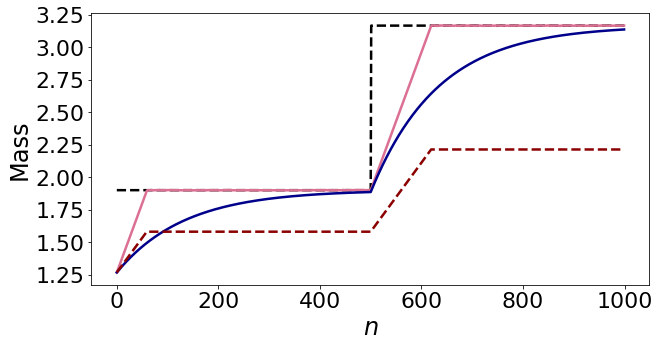

In [13]:


plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_mass_0,
    label=r"$Vanilla(\lambda = 0)$", 
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_mass_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Mass Done---")


In [14]:

### Track momentum
vanilla_opt_control_momentum_0, vanilla_kdv_opt_momentum_soln_0, vanilla_results_momentum_0, vanilla_t_list_momentum_0 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0,
)
vanilla_opt_control_momentum_5, vanilla_kdv_opt_momentum_soln_5, vanilla_results_momentum_5, vanilla_t_list_momentum_5 = VanillaMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    obs_func=compute_momentum,
    loss=mpc_loss_vanilla,
    lambda_param=0.005,
)




Processing time steps:   0%|          | 1/989 [01:34<25:55:27, 94.46s/it]

*** current time *** 0
optimize time:  94.07250475883484


Processing time steps:   0%|          | 2/989 [01:35<10:54:40, 39.80s/it]

*** current time *** 1
optimize time:  1.0559465885162354


Processing time steps:   0%|          | 3/989 [01:37<6:03:41, 22.13s/it] 

*** current time *** 2
optimize time:  0.7751419544219971


Processing time steps:   0%|          | 4/989 [01:38<3:46:35, 13.80s/it]

*** current time *** 3
optimize time:  0.7329096794128418


Processing time steps:   1%|          | 5/989 [01:39<2:30:58,  9.21s/it]

*** current time *** 4
optimize time:  0.7502443790435791


Processing time steps:   1%|          | 6/989 [01:40<1:45:23,  6.43s/it]

*** current time *** 5
optimize time:  0.7264280319213867


Processing time steps:   1%|          | 7/989 [01:41<1:16:32,  4.68s/it]

*** current time *** 6
optimize time:  0.7217967510223389


Processing time steps:   1%|          | 8/989 [01:42<57:36,  3.52s/it]  

*** current time *** 7
optimize time:  0.7368001937866211


Processing time steps:   1%|          | 9/989 [01:43<45:32,  2.79s/it]

*** current time *** 8
optimize time:  0.8135602474212646


Processing time steps:   1%|          | 10/989 [01:44<37:05,  2.27s/it]

*** current time *** 9
optimize time:  0.7871086597442627


Processing time steps:   1%|          | 11/989 [01:45<31:22,  1.92s/it]

*** current time *** 10
optimize time:  0.8206701278686523


Processing time steps:   1%|          | 12/989 [01:46<27:03,  1.66s/it]

*** current time *** 11
optimize time:  0.7431869506835938


Processing time steps:   1%|▏         | 13/989 [01:47<24:04,  1.48s/it]

*** current time *** 12
optimize time:  0.7581920623779297


Processing time steps:   1%|▏         | 14/989 [01:48<21:59,  1.35s/it]

*** current time *** 13
optimize time:  0.7443690299987793


Processing time steps:   2%|▏         | 15/989 [01:50<23:13,  1.43s/it]

*** current time *** 14
optimize time:  1.1619112491607666


Processing time steps:   2%|▏         | 16/989 [01:52<23:48,  1.47s/it]

*** current time *** 15
optimize time:  1.0846846103668213


Processing time steps:   2%|▏         | 17/989 [01:53<22:42,  1.40s/it]

*** current time *** 16
optimize time:  0.9293138980865479


Processing time steps:   2%|▏         | 18/989 [01:54<22:04,  1.36s/it]

*** current time *** 17
optimize time:  0.9256410598754883


Processing time steps:   2%|▏         | 19/989 [01:55<21:07,  1.31s/it]

*** current time *** 18
optimize time:  0.8217940330505371


Processing time steps:   2%|▏         | 20/989 [01:56<19:55,  1.23s/it]

*** current time *** 19
optimize time:  0.7473621368408203


Processing time steps:   2%|▏         | 21/989 [01:57<19:06,  1.18s/it]

*** current time *** 20
optimize time:  0.7369914054870605


Processing time steps:   2%|▏         | 22/989 [01:59<18:30,  1.15s/it]

*** current time *** 21
optimize time:  0.7521796226501465


Processing time steps:   2%|▏         | 23/989 [02:00<18:18,  1.14s/it]

*** current time *** 22
optimize time:  0.7561101913452148


Processing time steps:   2%|▏         | 24/989 [02:01<17:58,  1.12s/it]

*** current time *** 23
optimize time:  0.7772889137268066


Processing time steps:   3%|▎         | 25/989 [02:02<17:44,  1.10s/it]

*** current time *** 24
optimize time:  0.7318971157073975


Processing time steps:   3%|▎         | 26/989 [02:03<17:35,  1.10s/it]

*** current time *** 25
optimize time:  0.75661301612854


Processing time steps:   3%|▎         | 27/989 [02:04<17:20,  1.08s/it]

*** current time *** 26
optimize time:  0.7317698001861572


Processing time steps:   3%|▎         | 28/989 [02:05<19:24,  1.21s/it]

*** current time *** 27
optimize time:  1.036841869354248


Processing time steps:   3%|▎         | 29/989 [02:07<19:05,  1.19s/it]

*** current time *** 28
optimize time:  0.8450043201446533


Processing time steps:   3%|▎         | 30/989 [02:08<18:59,  1.19s/it]

*** current time *** 29
optimize time:  0.8097357749938965


Processing time steps:   3%|▎         | 31/989 [02:09<20:20,  1.27s/it]

*** current time *** 30
optimize time:  1.1028077602386475


Processing time steps:   3%|▎         | 32/989 [02:10<19:20,  1.21s/it]

*** current time *** 31
optimize time:  0.7321138381958008


Processing time steps:   3%|▎         | 33/989 [02:11<18:34,  1.17s/it]

*** current time *** 32
optimize time:  0.7444493770599365


Processing time steps:   3%|▎         | 34/989 [02:12<18:07,  1.14s/it]

*** current time *** 33
optimize time:  0.7310106754302979


Processing time steps:   4%|▎         | 35/989 [02:13<17:44,  1.12s/it]

*** current time *** 34
optimize time:  0.7382903099060059


Processing time steps:   4%|▎         | 36/989 [02:15<17:28,  1.10s/it]

*** current time *** 35
optimize time:  0.7271902561187744


Processing time steps:   4%|▎         | 37/989 [02:16<17:16,  1.09s/it]

*** current time *** 36
optimize time:  0.7358543872833252


Processing time steps:   4%|▍         | 38/989 [02:17<17:04,  1.08s/it]

*** current time *** 37
optimize time:  0.7422447204589844


Processing time steps:   4%|▍         | 39/989 [02:18<16:59,  1.07s/it]

*** current time *** 38
optimize time:  0.7359957695007324


Processing time steps:   4%|▍         | 40/989 [02:19<17:03,  1.08s/it]

*** current time *** 39
optimize time:  0.7744626998901367


Processing time steps:   4%|▍         | 41/989 [02:20<17:09,  1.09s/it]

*** current time *** 40
optimize time:  0.7732911109924316


Processing time steps:   4%|▍         | 42/989 [02:21<16:58,  1.08s/it]

*** current time *** 41
optimize time:  0.7342588901519775


Processing time steps:   4%|▍         | 43/989 [02:22<16:54,  1.07s/it]

*** current time *** 42
optimize time:  0.7618565559387207


Processing time steps:   4%|▍         | 44/989 [02:23<17:11,  1.09s/it]

*** current time *** 43
optimize time:  0.8000829219818115


Processing time steps:   5%|▍         | 45/989 [02:24<17:02,  1.08s/it]

*** current time *** 44
optimize time:  0.743868350982666


Processing time steps:   5%|▍         | 46/989 [02:25<16:57,  1.08s/it]

*** current time *** 45
optimize time:  0.7375268936157227


Processing time steps:   5%|▍         | 47/989 [02:26<17:14,  1.10s/it]

*** current time *** 46
optimize time:  0.7877304553985596


Processing time steps:   5%|▍         | 48/989 [02:28<17:05,  1.09s/it]

*** current time *** 47
optimize time:  0.7454850673675537


Processing time steps:   5%|▍         | 49/989 [02:29<17:17,  1.10s/it]

*** current time *** 48
optimize time:  0.7996845245361328


Processing time steps:   5%|▌         | 50/989 [02:30<17:05,  1.09s/it]

*** current time *** 49
optimize time:  0.7414436340332031


Processing time steps:   5%|▌         | 51/989 [02:31<16:53,  1.08s/it]

*** current time *** 50
optimize time:  0.7279117107391357


Processing time steps:   5%|▌         | 52/989 [02:32<16:48,  1.08s/it]

*** current time *** 51
optimize time:  0.7409617900848389


Processing time steps:   5%|▌         | 53/989 [02:33<16:52,  1.08s/it]

*** current time *** 52
optimize time:  0.7498443126678467


Processing time steps:   5%|▌         | 54/989 [02:34<16:46,  1.08s/it]

*** current time *** 53
optimize time:  0.7511084079742432


Processing time steps:   6%|▌         | 55/989 [02:35<16:42,  1.07s/it]

*** current time *** 54
optimize time:  0.7712843418121338


Processing time steps:   6%|▌         | 56/989 [02:36<16:41,  1.07s/it]

*** current time *** 55
optimize time:  0.7385187149047852


Processing time steps:   6%|▌         | 57/989 [02:37<16:28,  1.06s/it]

*** current time *** 56
optimize time:  0.7455606460571289


Processing time steps:   6%|▌         | 58/989 [02:40<23:17,  1.50s/it]

*** current time *** 57
optimize time:  2.225447654724121


Processing time steps:   6%|▌         | 59/989 [02:42<28:49,  1.86s/it]

*** current time *** 58
optimize time:  2.380467653274536


Processing time steps:   6%|▌         | 60/989 [02:43<25:06,  1.62s/it]

*** current time *** 59
optimize time:  0.7426068782806396


Processing time steps:   6%|▌         | 61/989 [02:45<25:55,  1.68s/it]

*** current time *** 60
optimize time:  1.4651236534118652


Processing time steps:   6%|▋         | 62/989 [02:48<29:50,  1.93s/it]

*** current time *** 61
optimize time:  2.2064239978790283


Processing time steps:   6%|▋         | 63/989 [02:50<33:07,  2.15s/it]

*** current time *** 62
optimize time:  2.2869091033935547


Processing time steps:   6%|▋         | 64/989 [02:52<28:17,  1.84s/it]

*** current time *** 63
optimize time:  0.7691249847412109


Processing time steps:   7%|▋         | 65/989 [02:53<24:56,  1.62s/it]

*** current time *** 64
optimize time:  0.7729153633117676


Processing time steps:   7%|▋         | 66/989 [02:54<22:35,  1.47s/it]

*** current time *** 65
optimize time:  0.7705819606781006


Processing time steps:   7%|▋         | 67/989 [02:57<29:18,  1.91s/it]

*** current time *** 66
optimize time:  2.4792773723602295


Processing time steps:   7%|▋         | 68/989 [02:58<26:48,  1.75s/it]

*** current time *** 67
optimize time:  0.9550905227661133


Processing time steps:   7%|▋         | 69/989 [03:01<32:30,  2.12s/it]

*** current time *** 68
optimize time:  2.5728046894073486


Processing time steps:   7%|▋         | 70/989 [03:02<27:52,  1.82s/it]

*** current time *** 69
optimize time:  0.7921206951141357


Processing time steps:   7%|▋         | 71/989 [03:04<28:06,  1.84s/it]

*** current time *** 70
optimize time:  1.524064064025879


Processing time steps:   7%|▋         | 72/989 [03:07<31:25,  2.06s/it]

*** current time *** 71
optimize time:  2.253614664077759


Processing time steps:   7%|▋         | 73/989 [03:08<26:47,  1.76s/it]

*** current time *** 72
optimize time:  0.7316567897796631


Processing time steps:   7%|▋         | 74/989 [03:10<27:15,  1.79s/it]

*** current time *** 73
optimize time:  1.5131466388702393


Processing time steps:   8%|▊         | 75/989 [03:12<31:14,  2.05s/it]

*** current time *** 74
optimize time:  2.311525583267212


Processing time steps:   8%|▊         | 76/989 [03:13<26:33,  1.75s/it]

*** current time *** 75
optimize time:  0.7276780605316162


Processing time steps:   8%|▊         | 77/989 [03:16<30:57,  2.04s/it]

*** current time *** 76
optimize time:  2.376585006713867


Processing time steps:   8%|▊         | 78/989 [03:18<33:01,  2.18s/it]

*** current time *** 77
optimize time:  2.1798479557037354


Processing time steps:   8%|▊         | 79/989 [03:20<27:59,  1.85s/it]

*** current time *** 78
optimize time:  0.727226734161377


Processing time steps:   8%|▊         | 80/989 [03:21<24:10,  1.60s/it]

*** current time *** 79
optimize time:  0.6983842849731445


Processing time steps:   8%|▊         | 81/989 [03:22<21:38,  1.43s/it]

*** current time *** 80
optimize time:  0.7413206100463867


Processing time steps:   8%|▊         | 82/989 [03:23<19:49,  1.31s/it]

*** current time *** 81
optimize time:  0.7093913555145264


Processing time steps:   8%|▊         | 83/989 [03:24<21:55,  1.45s/it]

*** current time *** 82
optimize time:  1.446155071258545


Processing time steps:   8%|▊         | 84/989 [03:27<26:34,  1.76s/it]

*** current time *** 83
optimize time:  2.1811351776123047


Processing time steps:   9%|▊         | 85/989 [03:29<26:29,  1.76s/it]

*** current time *** 84
optimize time:  1.4488739967346191


Processing time steps:   9%|▊         | 86/989 [03:31<29:49,  1.98s/it]

*** current time *** 85
optimize time:  2.1797547340393066


Processing time steps:   9%|▉         | 87/989 [03:32<26:29,  1.76s/it]

*** current time *** 86
optimize time:  0.8010280132293701


Processing time steps:   9%|▉         | 88/989 [03:36<34:48,  2.32s/it]

*** current time *** 87
optimize time:  3.22782564163208


Processing time steps:   9%|▉         | 89/989 [03:37<29:24,  1.96s/it]

*** current time *** 88
optimize time:  0.7743942737579346


Processing time steps:   9%|▉         | 90/989 [03:38<25:43,  1.72s/it]

*** current time *** 89
optimize time:  0.7822954654693604


Processing time steps:   9%|▉         | 91/989 [03:41<29:59,  2.00s/it]

*** current time *** 90
optimize time:  2.299280881881714


Processing time steps:   9%|▉         | 92/989 [03:42<25:52,  1.73s/it]

*** current time *** 91
optimize time:  0.7798535823822021


Processing time steps:   9%|▉         | 93/989 [03:43<22:46,  1.53s/it]

*** current time *** 92
optimize time:  0.7113626003265381


Processing time steps:  10%|▉         | 94/989 [03:44<20:30,  1.38s/it]

*** current time *** 93
optimize time:  0.7236418724060059


Processing time steps:  10%|▉         | 95/989 [03:46<22:16,  1.50s/it]

*** current time *** 94
optimize time:  1.4699182510375977


Processing time steps:  10%|▉         | 96/989 [03:48<26:49,  1.80s/it]

*** current time *** 95
optimize time:  2.181149482727051


Processing time steps:  10%|▉         | 97/989 [03:49<23:19,  1.57s/it]

*** current time *** 96
optimize time:  0.7233591079711914


Processing time steps:  10%|▉         | 98/989 [03:50<20:54,  1.41s/it]

*** current time *** 97
optimize time:  0.7492566108703613


Processing time steps:  10%|█         | 99/989 [03:52<19:22,  1.31s/it]

*** current time *** 98
optimize time:  0.7350330352783203


Processing time steps:  10%|█         | 100/989 [03:54<24:36,  1.66s/it]

*** current time *** 99
optimize time:  2.1905624866485596


Processing time steps:  10%|█         | 101/989 [03:55<21:54,  1.48s/it]

*** current time *** 100
optimize time:  0.7400329113006592


Processing time steps:  10%|█         | 102/989 [03:58<26:23,  1.78s/it]

*** current time *** 101
optimize time:  2.204474925994873


Processing time steps:  10%|█         | 103/989 [04:00<29:32,  2.00s/it]

*** current time *** 102
optimize time:  2.175977945327759


Processing time steps:  11%|█         | 104/989 [04:01<25:20,  1.72s/it]

*** current time *** 103
optimize time:  0.7459051609039307


Processing time steps:  11%|█         | 105/989 [04:02<22:26,  1.52s/it]

*** current time *** 104
optimize time:  0.7329859733581543


Processing time steps:  11%|█         | 106/989 [04:05<26:52,  1.83s/it]

*** current time *** 105
optimize time:  2.192965030670166


Processing time steps:  11%|█         | 107/989 [04:06<23:51,  1.62s/it]

*** current time *** 106
optimize time:  0.7949440479278564


Processing time steps:  11%|█         | 108/989 [04:08<28:06,  1.91s/it]

*** current time *** 107
optimize time:  2.232208490371704


Processing time steps:  11%|█         | 109/989 [04:10<24:19,  1.66s/it]

*** current time *** 108
optimize time:  0.7567791938781738


Processing time steps:  11%|█         | 110/989 [04:12<28:37,  1.95s/it]

*** current time *** 109
optimize time:  2.304896593093872


Processing time steps:  11%|█         | 111/989 [04:15<31:20,  2.14s/it]

*** current time *** 110
optimize time:  2.2635128498077393


Processing time steps:  11%|█▏        | 112/989 [04:16<26:35,  1.82s/it]

*** current time *** 111
optimize time:  0.7527408599853516


Processing time steps:  11%|█▏        | 113/989 [04:18<29:58,  2.05s/it]

*** current time *** 112
optimize time:  2.2480738162994385


Processing time steps:  12%|█▏        | 114/989 [04:20<26:41,  1.83s/it]

*** current time *** 113
optimize time:  0.8921253681182861


Processing time steps:  12%|█▏        | 115/989 [04:22<29:47,  2.04s/it]

*** current time *** 114
optimize time:  2.2451443672180176


Processing time steps:  12%|█▏        | 116/989 [04:24<26:05,  1.79s/it]

*** current time *** 115
optimize time:  0.8656513690948486


Processing time steps:  12%|█▏        | 117/989 [04:26<29:00,  2.00s/it]

*** current time *** 116
optimize time:  2.171976089477539


Processing time steps:  12%|█▏        | 118/989 [04:28<31:13,  2.15s/it]

*** current time *** 117
optimize time:  2.174899101257324


Processing time steps:  12%|█▏        | 119/989 [04:30<26:16,  1.81s/it]

*** current time *** 118
optimize time:  0.7152857780456543


Processing time steps:  12%|█▏        | 120/989 [04:31<23:32,  1.63s/it]

*** current time *** 119
optimize time:  0.8377501964569092


Processing time steps:  12%|█▏        | 121/989 [04:33<28:05,  1.94s/it]

*** current time *** 120
optimize time:  2.3307673931121826


Processing time steps:  12%|█▏        | 122/989 [04:35<27:24,  1.90s/it]

*** current time *** 121
optimize time:  1.4961254596710205


Processing time steps:  12%|█▏        | 123/989 [04:38<30:31,  2.12s/it]

*** current time *** 122
optimize time:  2.3251841068267822


Processing time steps:  13%|█▎        | 124/989 [04:40<32:12,  2.23s/it]

*** current time *** 123
optimize time:  2.2103376388549805


Processing time steps:  13%|█▎        | 125/989 [04:41<26:57,  1.87s/it]

*** current time *** 124
optimize time:  0.7265474796295166


Processing time steps:  13%|█▎        | 126/989 [04:43<23:59,  1.67s/it]

*** current time *** 125
optimize time:  0.8334264755249023


Processing time steps:  13%|█▎        | 127/989 [04:44<21:23,  1.49s/it]

*** current time *** 126
optimize time:  0.7591385841369629


Processing time steps:  13%|█▎        | 128/989 [04:45<19:40,  1.37s/it]

*** current time *** 127
optimize time:  0.7519838809967041


Processing time steps:  13%|█▎        | 129/989 [04:47<21:59,  1.53s/it]

*** current time *** 128
optimize time:  1.5630872249603271


Processing time steps:  13%|█▎        | 130/989 [04:49<26:28,  1.85s/it]

*** current time *** 129
optimize time:  2.2483532428741455


Processing time steps:  13%|█▎        | 131/989 [04:50<22:58,  1.61s/it]

*** current time *** 130
optimize time:  0.7348787784576416


Processing time steps:  13%|█▎        | 132/989 [04:53<27:29,  1.92s/it]

*** current time *** 131
optimize time:  2.351017713546753


Processing time steps:  13%|█▎        | 133/989 [04:56<30:44,  2.15s/it]

*** current time *** 132
optimize time:  2.336449146270752


Processing time steps:  14%|█▎        | 134/989 [04:57<26:23,  1.85s/it]

*** current time *** 133
optimize time:  0.7863864898681641


Processing time steps:  14%|█▎        | 135/989 [04:59<29:55,  2.10s/it]

*** current time *** 134
optimize time:  2.351905584335327


Processing time steps:  14%|█▍        | 136/989 [05:01<25:43,  1.81s/it]

*** current time *** 135
optimize time:  0.7852287292480469


Processing time steps:  14%|█▍        | 137/989 [05:03<29:33,  2.08s/it]

*** current time *** 136
optimize time:  2.3697144985198975


Processing time steps:  14%|█▍        | 138/989 [05:04<25:09,  1.77s/it]

*** current time *** 137
optimize time:  0.7529458999633789


Processing time steps:  14%|█▍        | 139/989 [05:07<28:57,  2.04s/it]

*** current time *** 138
optimize time:  2.3380353450775146


Processing time steps:  14%|█▍        | 140/989 [05:10<30:58,  2.19s/it]

*** current time *** 139
optimize time:  2.2155635356903076


Processing time steps:  14%|█▍        | 141/989 [05:11<26:10,  1.85s/it]

*** current time *** 140
optimize time:  0.726771354675293


Processing time steps:  14%|█▍        | 142/989 [05:12<22:41,  1.61s/it]

*** current time *** 141
optimize time:  0.7445685863494873


Processing time steps:  14%|█▍        | 143/989 [05:14<27:17,  1.94s/it]

*** current time *** 142
optimize time:  2.3479249477386475


Processing time steps:  15%|█▍        | 144/989 [05:15<23:51,  1.69s/it]

*** current time *** 143
optimize time:  0.7782778739929199


Processing time steps:  15%|█▍        | 145/989 [05:17<21:23,  1.52s/it]

*** current time *** 144
optimize time:  0.7803544998168945


Processing time steps:  15%|█▍        | 146/989 [05:19<26:24,  1.88s/it]

*** current time *** 145
optimize time:  2.3940439224243164


Processing time steps:  15%|█▍        | 147/989 [05:22<29:03,  2.07s/it]

*** current time *** 146
optimize time:  2.189807891845703


Processing time steps:  15%|█▍        | 148/989 [05:23<24:33,  1.75s/it]

*** current time *** 147
optimize time:  0.7225232124328613


Processing time steps:  15%|█▌        | 149/989 [05:24<21:34,  1.54s/it]

*** current time *** 148
optimize time:  0.7534801959991455


Processing time steps:  15%|█▌        | 150/989 [05:25<19:34,  1.40s/it]

*** current time *** 149
optimize time:  0.7339811325073242


Processing time steps:  15%|█▌        | 151/989 [05:27<24:18,  1.74s/it]

*** current time *** 150
optimize time:  2.2216975688934326


Processing time steps:  15%|█▌        | 152/989 [05:30<27:46,  1.99s/it]

*** current time *** 151
optimize time:  2.251396656036377


Processing time steps:  15%|█▌        | 153/989 [05:31<23:47,  1.71s/it]

*** current time *** 152
optimize time:  0.7399845123291016


Processing time steps:  16%|█▌        | 154/989 [05:32<21:06,  1.52s/it]

*** current time *** 153
optimize time:  0.7558608055114746


Processing time steps:  16%|█▌        | 155/989 [05:33<19:06,  1.37s/it]

*** current time *** 154
optimize time:  0.7359127998352051


Processing time steps:  16%|█▌        | 156/989 [05:34<17:45,  1.28s/it]

*** current time *** 155
optimize time:  0.7683494091033936


Processing time steps:  16%|█▌        | 157/989 [05:35<16:52,  1.22s/it]

*** current time *** 156
optimize time:  0.7256615161895752


Processing time steps:  16%|█▌        | 158/989 [05:36<16:10,  1.17s/it]

*** current time *** 157
optimize time:  0.7438125610351562


Processing time steps:  16%|█▌        | 159/989 [05:37<15:38,  1.13s/it]

*** current time *** 158
optimize time:  0.7285995483398438


Processing time steps:  16%|█▌        | 160/989 [05:38<15:17,  1.11s/it]

*** current time *** 159
optimize time:  0.75010085105896


Processing time steps:  16%|█▋        | 161/989 [05:40<14:55,  1.08s/it]

*** current time *** 160
optimize time:  0.7244305610656738


Processing time steps:  16%|█▋        | 162/989 [05:41<14:42,  1.07s/it]

*** current time *** 161
optimize time:  0.7174928188323975


Processing time steps:  16%|█▋        | 163/989 [05:42<14:33,  1.06s/it]

*** current time *** 162
optimize time:  0.720165491104126


Processing time steps:  17%|█▋        | 164/989 [05:43<14:25,  1.05s/it]

*** current time *** 163
optimize time:  0.7351357936859131


Processing time steps:  17%|█▋        | 165/989 [05:44<14:21,  1.05s/it]

*** current time *** 164
optimize time:  0.7432916164398193


Processing time steps:  17%|█▋        | 166/989 [05:45<14:21,  1.05s/it]

*** current time *** 165
optimize time:  0.7218055725097656


Processing time steps:  17%|█▋        | 167/989 [05:46<14:12,  1.04s/it]

*** current time *** 166
optimize time:  0.7056381702423096


Processing time steps:  17%|█▋        | 168/989 [05:47<14:13,  1.04s/it]

*** current time *** 167
optimize time:  0.7472641468048096


Processing time steps:  17%|█▋        | 169/989 [05:48<14:14,  1.04s/it]

*** current time *** 168
optimize time:  0.7248821258544922


Processing time steps:  17%|█▋        | 170/989 [05:49<14:09,  1.04s/it]

*** current time *** 169
optimize time:  0.7130658626556396


Processing time steps:  17%|█▋        | 171/989 [05:51<20:12,  1.48s/it]

*** current time *** 170
optimize time:  2.1948728561401367


Processing time steps:  17%|█▋        | 172/989 [05:54<24:25,  1.79s/it]

*** current time *** 171
optimize time:  2.1958560943603516


Processing time steps:  17%|█▋        | 173/989 [05:55<21:26,  1.58s/it]

*** current time *** 172
optimize time:  0.7424697875976562


Processing time steps:  18%|█▊        | 174/989 [05:56<19:34,  1.44s/it]

*** current time *** 173
optimize time:  0.7810657024383545


Processing time steps:  18%|█▊        | 175/989 [05:57<18:06,  1.33s/it]

*** current time *** 174
optimize time:  0.7382564544677734


Processing time steps:  18%|█▊        | 176/989 [05:58<16:54,  1.25s/it]

*** current time *** 175
optimize time:  0.7053778171539307


Processing time steps:  18%|█▊        | 177/989 [05:59<16:00,  1.18s/it]

*** current time *** 176
optimize time:  0.7015361785888672


Processing time steps:  18%|█▊        | 178/989 [06:00<15:18,  1.13s/it]

*** current time *** 177
optimize time:  0.7204709053039551


Processing time steps:  18%|█▊        | 179/989 [06:01<14:51,  1.10s/it]

*** current time *** 178
optimize time:  0.7286674976348877


Processing time steps:  18%|█▊        | 180/989 [06:02<14:39,  1.09s/it]

*** current time *** 179
optimize time:  0.7402820587158203


Processing time steps:  18%|█▊        | 181/989 [06:03<14:33,  1.08s/it]

*** current time *** 180
optimize time:  0.7545208930969238


Processing time steps:  18%|█▊        | 182/989 [06:04<14:16,  1.06s/it]

*** current time *** 181
optimize time:  0.7236995697021484


Processing time steps:  19%|█▊        | 183/989 [06:05<14:13,  1.06s/it]

*** current time *** 182
optimize time:  0.7454013824462891


Processing time steps:  19%|█▊        | 184/989 [06:07<14:14,  1.06s/it]

*** current time *** 183
optimize time:  0.7207787036895752


Processing time steps:  19%|█▊        | 185/989 [06:08<14:00,  1.05s/it]

*** current time *** 184
optimize time:  0.7135062217712402


Processing time steps:  19%|█▉        | 186/989 [06:09<13:59,  1.05s/it]

*** current time *** 185
optimize time:  0.7417616844177246


Processing time steps:  19%|█▉        | 187/989 [06:10<17:02,  1.27s/it]

*** current time *** 186
optimize time:  1.4698200225830078


Processing time steps:  19%|█▉        | 188/989 [06:12<19:26,  1.46s/it]

*** current time *** 187
optimize time:  1.516822338104248


Processing time steps:  19%|█▉        | 189/989 [06:14<20:52,  1.57s/it]

*** current time *** 188
optimize time:  1.5102496147155762


Processing time steps:  19%|█▉        | 190/989 [06:16<22:07,  1.66s/it]

*** current time *** 189
optimize time:  1.5288729667663574


Processing time steps:  19%|█▉        | 191/989 [06:18<23:02,  1.73s/it]

*** current time *** 190
optimize time:  1.5440731048583984


Processing time steps:  19%|█▉        | 192/989 [06:20<26:29,  1.99s/it]

*** current time *** 191
optimize time:  2.3006577491760254


Processing time steps:  20%|█▉        | 193/989 [06:22<22:56,  1.73s/it]

*** current time *** 192
optimize time:  0.7801783084869385


Processing time steps:  20%|█▉        | 194/989 [06:24<26:30,  2.00s/it]

*** current time *** 193
optimize time:  2.305769920349121


Processing time steps:  20%|█▉        | 195/989 [06:27<28:28,  2.15s/it]

*** current time *** 194
optimize time:  2.1954402923583984


Processing time steps:  20%|█▉        | 196/989 [06:28<24:13,  1.83s/it]

*** current time *** 195
optimize time:  0.7703638076782227


Processing time steps:  20%|█▉        | 197/989 [06:30<23:53,  1.81s/it]

*** current time *** 196
optimize time:  1.4642157554626465


Processing time steps:  20%|██        | 198/989 [06:32<27:16,  2.07s/it]

*** current time *** 197
optimize time:  2.3640315532684326


Processing time steps:  20%|██        | 199/989 [06:33<23:18,  1.77s/it]

*** current time *** 198
optimize time:  0.7421317100524902


Processing time steps:  20%|██        | 200/989 [06:36<28:30,  2.17s/it]

*** current time *** 199
optimize time:  2.8009390830993652


Processing time steps:  20%|██        | 201/989 [06:38<27:00,  2.06s/it]

*** current time *** 200
optimize time:  1.4731581211090088


Processing time steps:  20%|██        | 202/989 [06:41<29:02,  2.21s/it]

*** current time *** 201
optimize time:  2.263348340988159


Processing time steps:  21%|██        | 203/989 [06:43<30:19,  2.31s/it]

*** current time *** 202
optimize time:  2.210505247116089


Processing time steps:  21%|██        | 204/989 [06:44<25:16,  1.93s/it]

*** current time *** 203
optimize time:  0.7253482341766357


Processing time steps:  21%|██        | 205/989 [06:46<24:46,  1.90s/it]

*** current time *** 204
optimize time:  1.482494831085205


Processing time steps:  21%|██        | 206/989 [06:49<27:42,  2.12s/it]

*** current time *** 205
optimize time:  2.3472564220428467


Processing time steps:  21%|██        | 207/989 [06:50<23:38,  1.81s/it]

*** current time *** 206
optimize time:  0.7850487232208252


Processing time steps:  21%|██        | 208/989 [06:52<26:25,  2.03s/it]

*** current time *** 207
optimize time:  2.1972367763519287


Processing time steps:  21%|██        | 209/989 [06:55<28:18,  2.18s/it]

*** current time *** 208
optimize time:  2.2015419006347656


Processing time steps:  21%|██        | 210/989 [06:56<23:52,  1.84s/it]

*** current time *** 209
optimize time:  0.7322015762329102


Processing time steps:  21%|██▏       | 211/989 [06:57<20:55,  1.61s/it]

*** current time *** 210
optimize time:  0.7475733757019043


Processing time steps:  21%|██▏       | 212/989 [06:58<18:40,  1.44s/it]

*** current time *** 211
optimize time:  0.7409043312072754


Processing time steps:  22%|██▏       | 213/989 [06:59<17:08,  1.33s/it]

*** current time *** 212
optimize time:  0.7414805889129639


Processing time steps:  22%|██▏       | 214/989 [07:00<15:57,  1.24s/it]

*** current time *** 213
optimize time:  0.7220492362976074


Processing time steps:  22%|██▏       | 215/989 [07:01<15:08,  1.17s/it]

*** current time *** 214
optimize time:  0.736149787902832


Processing time steps:  22%|██▏       | 216/989 [07:02<14:53,  1.16s/it]

*** current time *** 215
optimize time:  0.7693483829498291


Processing time steps:  22%|██▏       | 217/989 [07:03<14:31,  1.13s/it]

*** current time *** 216
optimize time:  0.7225656509399414


Processing time steps:  22%|██▏       | 218/989 [07:04<14:03,  1.09s/it]

*** current time *** 217
optimize time:  0.7074248790740967


Processing time steps:  22%|██▏       | 219/989 [07:06<13:58,  1.09s/it]

*** current time *** 218
optimize time:  0.7518436908721924


Processing time steps:  22%|██▏       | 220/989 [07:07<13:47,  1.08s/it]

*** current time *** 219
optimize time:  0.7209575176239014


Processing time steps:  22%|██▏       | 221/989 [07:08<13:39,  1.07s/it]

*** current time *** 220
optimize time:  0.7406251430511475


Processing time steps:  22%|██▏       | 222/989 [07:09<13:35,  1.06s/it]

*** current time *** 221
optimize time:  0.7450356483459473


Processing time steps:  23%|██▎       | 223/989 [07:10<13:24,  1.05s/it]

*** current time *** 222
optimize time:  0.7129032611846924


Processing time steps:  23%|██▎       | 224/989 [07:11<13:15,  1.04s/it]

*** current time *** 223
optimize time:  0.721282958984375


Processing time steps:  23%|██▎       | 225/989 [07:13<16:03,  1.26s/it]

*** current time *** 224
optimize time:  1.4590835571289062


Processing time steps:  23%|██▎       | 226/989 [07:14<18:01,  1.42s/it]

*** current time *** 225
optimize time:  1.4714488983154297


Processing time steps:  23%|██▎       | 227/989 [07:16<19:22,  1.53s/it]

*** current time *** 226
optimize time:  1.4853591918945312


Processing time steps:  23%|██▎       | 228/989 [07:18<20:38,  1.63s/it]

*** current time *** 227
optimize time:  1.5570077896118164


Processing time steps:  23%|██▎       | 229/989 [07:20<24:08,  1.91s/it]

*** current time *** 228
optimize time:  2.243628978729248


Processing time steps:  23%|██▎       | 230/989 [07:22<23:43,  1.87s/it]

*** current time *** 229
optimize time:  1.4775006771087646


Processing time steps:  23%|██▎       | 231/989 [07:25<26:14,  2.08s/it]

*** current time *** 230
optimize time:  2.2138216495513916


Processing time steps:  23%|██▎       | 232/989 [07:27<25:07,  1.99s/it]

*** current time *** 231
optimize time:  1.4512827396392822


Processing time steps:  24%|██▎       | 233/989 [07:29<27:42,  2.20s/it]

*** current time *** 232
optimize time:  2.339799404144287


Processing time steps:  24%|██▎       | 234/989 [07:30<23:25,  1.86s/it]

*** current time *** 233
optimize time:  0.7509071826934814


Processing time steps:  24%|██▍       | 235/989 [07:33<25:47,  2.05s/it]

*** current time *** 234
optimize time:  2.185494899749756


Processing time steps:  24%|██▍       | 236/989 [07:34<22:21,  1.78s/it]

*** current time *** 235
optimize time:  0.7823019027709961


Processing time steps:  24%|██▍       | 237/989 [07:36<22:39,  1.81s/it]

*** current time *** 236
optimize time:  1.5402989387512207


Processing time steps:  24%|██▍       | 238/989 [07:38<25:22,  2.03s/it]

*** current time *** 237
optimize time:  2.2368526458740234


Processing time steps:  24%|██▍       | 239/989 [07:42<30:00,  2.40s/it]

*** current time *** 238
optimize time:  2.9694905281066895


Processing time steps:  24%|██▍       | 240/989 [07:43<25:14,  2.02s/it]

*** current time *** 239
optimize time:  0.7903108596801758


Processing time steps:  24%|██▍       | 241/989 [07:45<24:52,  2.00s/it]

*** current time *** 240
optimize time:  1.6004250049591064


Processing time steps:  24%|██▍       | 242/989 [07:47<27:00,  2.17s/it]

*** current time *** 241
optimize time:  2.2456471920013428


Processing time steps:  25%|██▍       | 243/989 [07:48<22:56,  1.85s/it]

*** current time *** 242
optimize time:  0.7537851333618164


Processing time steps:  25%|██▍       | 244/989 [07:52<29:19,  2.36s/it]

*** current time *** 243
optimize time:  3.137432813644409


Processing time steps:  25%|██▍       | 245/989 [07:53<24:32,  1.98s/it]

*** current time *** 244
optimize time:  0.7520103454589844


Processing time steps:  25%|██▍       | 246/989 [07:56<26:38,  2.15s/it]

*** current time *** 245
optimize time:  2.222749710083008


Processing time steps:  25%|██▍       | 247/989 [07:57<22:31,  1.82s/it]

*** current time *** 246
optimize time:  0.739713191986084


Processing time steps:  25%|██▌       | 248/989 [07:59<23:00,  1.86s/it]

*** current time *** 247
optimize time:  1.6252164840698242


Processing time steps:  25%|██▌       | 249/989 [08:01<25:34,  2.07s/it]

*** current time *** 248
optimize time:  2.225773572921753


Processing time steps:  25%|██▌       | 250/989 [08:02<21:46,  1.77s/it]

*** current time *** 249
optimize time:  0.7297101020812988


Processing time steps:  25%|██▌       | 251/989 [08:05<24:43,  2.01s/it]

*** current time *** 250
optimize time:  2.282457113265991


Processing time steps:  25%|██▌       | 252/989 [08:08<27:07,  2.21s/it]

*** current time *** 251
optimize time:  2.3419408798217773


Processing time steps:  26%|██▌       | 253/989 [08:09<25:34,  2.08s/it]

*** current time *** 252
optimize time:  1.4879026412963867


Processing time steps:  26%|██▌       | 254/989 [08:12<27:43,  2.26s/it]

*** current time *** 253
optimize time:  2.348696708679199


Processing time steps:  26%|██▌       | 255/989 [08:15<28:30,  2.33s/it]

*** current time *** 254
optimize time:  2.198444366455078


Processing time steps:  26%|██▌       | 256/989 [08:16<26:22,  2.16s/it]

*** current time *** 255
optimize time:  1.470374345779419


Processing time steps:  26%|██▌       | 257/989 [08:19<28:05,  2.30s/it]

*** current time *** 256
optimize time:  2.3013522624969482


Processing time steps:  26%|██▌       | 258/989 [08:22<30:29,  2.50s/it]

*** current time *** 257
optimize time:  2.564129590988159


Processing time steps:  26%|██▌       | 259/989 [08:23<25:25,  2.09s/it]

*** current time *** 258
optimize time:  0.7758092880249023


Processing time steps:  26%|██▋       | 260/989 [08:24<21:53,  1.80s/it]

*** current time *** 259
optimize time:  0.7759616374969482


Processing time steps:  26%|██▋       | 261/989 [08:26<22:11,  1.83s/it]

*** current time *** 260
optimize time:  1.5491886138916016


Processing time steps:  26%|██▋       | 262/989 [08:29<24:41,  2.04s/it]

*** current time *** 261
optimize time:  2.2021100521087646


Processing time steps:  27%|██▋       | 263/989 [08:30<21:10,  1.75s/it]

*** current time *** 262
optimize time:  0.7448618412017822


Processing time steps:  27%|██▋       | 264/989 [08:32<24:15,  2.01s/it]

*** current time *** 263
optimize time:  2.26042103767395


Processing time steps:  27%|██▋       | 265/989 [08:35<25:54,  2.15s/it]

*** current time *** 264
optimize time:  2.1650173664093018


Processing time steps:  27%|██▋       | 266/989 [08:36<21:55,  1.82s/it]

*** current time *** 265
optimize time:  0.7294116020202637


Processing time steps:  27%|██▋       | 267/989 [08:37<19:03,  1.58s/it]

*** current time *** 266
optimize time:  0.7285027503967285


Processing time steps:  27%|██▋       | 268/989 [08:38<17:08,  1.43s/it]

*** current time *** 267
optimize time:  0.7340161800384521


Processing time steps:  27%|██▋       | 269/989 [08:39<15:41,  1.31s/it]

*** current time *** 268
optimize time:  0.7155187129974365


Processing time steps:  27%|██▋       | 270/989 [08:40<14:45,  1.23s/it]

*** current time *** 269
optimize time:  0.746424674987793


Processing time steps:  27%|██▋       | 271/989 [08:41<14:08,  1.18s/it]

*** current time *** 270
optimize time:  0.731065034866333


Processing time steps:  28%|██▊       | 272/989 [08:42<13:35,  1.14s/it]

*** current time *** 271
optimize time:  0.7229793071746826


Processing time steps:  28%|██▊       | 273/989 [08:43<13:46,  1.15s/it]

*** current time *** 272
optimize time:  0.8012864589691162


Processing time steps:  28%|██▊       | 274/989 [08:44<13:27,  1.13s/it]

*** current time *** 273
optimize time:  0.7246770858764648


Processing time steps:  28%|██▊       | 275/989 [08:45<13:21,  1.12s/it]

*** current time *** 274
optimize time:  0.7864701747894287


Processing time steps:  28%|██▊       | 276/989 [08:47<14:10,  1.19s/it]

*** current time *** 275
optimize time:  1.0036797523498535


Processing time steps:  28%|██▊       | 277/989 [08:48<13:52,  1.17s/it]

*** current time *** 276
optimize time:  0.7791619300842285


Processing time steps:  28%|██▊       | 278/989 [08:49<13:37,  1.15s/it]

*** current time *** 277
optimize time:  0.7637174129486084


Processing time steps:  28%|██▊       | 279/989 [08:50<13:28,  1.14s/it]

*** current time *** 278
optimize time:  0.770845890045166


Processing time steps:  28%|██▊       | 280/989 [08:51<13:16,  1.12s/it]

*** current time *** 279
optimize time:  0.7488157749176025


Processing time steps:  28%|██▊       | 281/989 [08:52<12:53,  1.09s/it]

*** current time *** 280
optimize time:  0.7324535846710205


Processing time steps:  29%|██▊       | 282/989 [08:53<12:54,  1.09s/it]

*** current time *** 281
optimize time:  0.7985579967498779


Processing time steps:  29%|██▊       | 283/989 [08:54<12:40,  1.08s/it]

*** current time *** 282
optimize time:  0.719261646270752


Processing time steps:  29%|██▊       | 284/989 [08:55<12:32,  1.07s/it]

*** current time *** 283
optimize time:  0.7349352836608887


Processing time steps:  29%|██▉       | 285/989 [08:56<12:21,  1.05s/it]

*** current time *** 284
optimize time:  0.7207345962524414


Processing time steps:  29%|██▉       | 286/989 [08:57<12:17,  1.05s/it]

*** current time *** 285
optimize time:  0.7513113021850586


Processing time steps:  29%|██▉       | 287/989 [08:59<12:19,  1.05s/it]

*** current time *** 286
optimize time:  0.7344117164611816


Processing time steps:  29%|██▉       | 288/989 [09:00<12:10,  1.04s/it]

*** current time *** 287
optimize time:  0.7148900032043457


Processing time steps:  29%|██▉       | 289/989 [09:01<12:12,  1.05s/it]

*** current time *** 288
optimize time:  0.7290029525756836


Processing time steps:  29%|██▉       | 290/989 [09:02<12:20,  1.06s/it]

*** current time *** 289
optimize time:  0.7376303672790527


Processing time steps:  29%|██▉       | 291/989 [09:03<12:19,  1.06s/it]

*** current time *** 290
optimize time:  0.7335569858551025


Processing time steps:  30%|██▉       | 292/989 [09:04<12:20,  1.06s/it]

*** current time *** 291
optimize time:  0.7306089401245117


Processing time steps:  30%|██▉       | 293/989 [09:05<12:16,  1.06s/it]

*** current time *** 292
optimize time:  0.7512423992156982


Processing time steps:  30%|██▉       | 294/989 [09:06<12:20,  1.07s/it]

*** current time *** 293
optimize time:  0.7415862083435059


Processing time steps:  30%|██▉       | 295/989 [09:07<12:07,  1.05s/it]

*** current time *** 294
optimize time:  0.7115144729614258


Processing time steps:  30%|██▉       | 296/989 [09:08<12:01,  1.04s/it]

*** current time *** 295
optimize time:  0.742002010345459


Processing time steps:  30%|███       | 297/989 [09:10<14:33,  1.26s/it]

*** current time *** 296
optimize time:  1.4677774906158447


Processing time steps:  30%|███       | 298/989 [09:12<16:16,  1.41s/it]

*** current time *** 297
optimize time:  1.4764485359191895


Processing time steps:  30%|███       | 299/989 [09:14<19:55,  1.73s/it]

*** current time *** 298
optimize time:  2.179226875305176


Processing time steps:  30%|███       | 300/989 [09:17<22:44,  1.98s/it]

*** current time *** 299
optimize time:  2.235459804534912


Processing time steps:  30%|███       | 301/989 [09:18<19:53,  1.73s/it]

*** current time *** 300
optimize time:  0.8273279666900635


Processing time steps:  31%|███       | 302/989 [09:19<17:43,  1.55s/it]

*** current time *** 301
optimize time:  0.7656044960021973


Processing time steps:  31%|███       | 303/989 [09:20<16:10,  1.41s/it]

*** current time *** 302
optimize time:  0.7692646980285645


Processing time steps:  31%|███       | 304/989 [09:21<15:07,  1.33s/it]

*** current time *** 303
optimize time:  0.7484369277954102


Processing time steps:  31%|███       | 305/989 [09:23<16:39,  1.46s/it]

*** current time *** 304
optimize time:  1.4771349430084229


Processing time steps:  31%|███       | 306/989 [09:26<21:20,  1.88s/it]

*** current time *** 305
optimize time:  2.5262339115142822


Processing time steps:  31%|███       | 307/989 [09:27<18:43,  1.65s/it]

*** current time *** 306
optimize time:  0.7858974933624268


Processing time steps:  31%|███       | 308/989 [09:29<22:00,  1.94s/it]

*** current time *** 307
optimize time:  2.283729314804077


Processing time steps:  31%|███       | 309/989 [09:32<24:02,  2.12s/it]

*** current time *** 308
optimize time:  2.2370588779449463


Processing time steps:  31%|███▏      | 310/989 [09:33<20:23,  1.80s/it]

*** current time *** 309
optimize time:  0.7436504364013672


Processing time steps:  31%|███▏      | 311/989 [09:34<17:52,  1.58s/it]

*** current time *** 310
optimize time:  0.7326343059539795


Processing time steps:  32%|███▏      | 312/989 [09:36<18:35,  1.65s/it]

*** current time *** 311
optimize time:  1.4705970287322998


Processing time steps:  32%|███▏      | 313/989 [09:38<21:29,  1.91s/it]

*** current time *** 312
optimize time:  2.207517147064209


Processing time steps:  32%|███▏      | 314/989 [09:41<23:39,  2.10s/it]

*** current time *** 313
optimize time:  2.2612102031707764


Processing time steps:  32%|███▏      | 315/989 [09:42<20:10,  1.80s/it]

*** current time *** 314
optimize time:  0.757279634475708


Processing time steps:  32%|███▏      | 316/989 [09:43<17:37,  1.57s/it]

*** current time *** 315
optimize time:  0.7319352626800537


Processing time steps:  32%|███▏      | 317/989 [09:44<16:12,  1.45s/it]

*** current time *** 316
optimize time:  0.8005626201629639


Processing time steps:  32%|███▏      | 318/989 [09:46<17:41,  1.58s/it]

*** current time *** 317
optimize time:  1.6008086204528809


Processing time steps:  32%|███▏      | 319/989 [09:49<23:07,  2.07s/it]

*** current time *** 318
optimize time:  2.7498514652252197


Processing time steps:  32%|███▏      | 320/989 [09:51<20:47,  1.86s/it]

*** current time *** 319
optimize time:  0.9623818397521973


Processing time steps:  32%|███▏      | 321/989 [09:53<20:48,  1.87s/it]

*** current time *** 320
optimize time:  1.574955940246582


Processing time steps:  33%|███▎      | 322/989 [09:55<23:00,  2.07s/it]

*** current time *** 321
optimize time:  2.235799551010132


Processing time steps:  33%|███▎      | 323/989 [09:57<21:57,  1.98s/it]

*** current time *** 322
optimize time:  1.4557125568389893


Processing time steps:  33%|███▎      | 324/989 [10:00<24:02,  2.17s/it]

*** current time *** 323
optimize time:  2.2625656127929688


Processing time steps:  33%|███▎      | 325/989 [10:01<20:33,  1.86s/it]

*** current time *** 324
optimize time:  0.7783946990966797


Processing time steps:  33%|███▎      | 326/989 [10:04<25:38,  2.32s/it]

*** current time *** 325
optimize time:  3.0492231845855713


Processing time steps:  33%|███▎      | 327/989 [10:05<21:22,  1.94s/it]

*** current time *** 326
optimize time:  0.7265465259552002


Processing time steps:  33%|███▎      | 328/989 [10:08<23:34,  2.14s/it]

*** current time *** 327
optimize time:  2.3084604740142822


Processing time steps:  33%|███▎      | 329/989 [10:10<22:24,  2.04s/it]

*** current time *** 328
optimize time:  1.49171781539917


Processing time steps:  33%|███▎      | 330/989 [10:12<24:06,  2.20s/it]

*** current time *** 329
optimize time:  2.213303565979004


Processing time steps:  33%|███▎      | 331/989 [10:13<20:24,  1.86s/it]

*** current time *** 330
optimize time:  0.769193172454834


Processing time steps:  34%|███▎      | 332/989 [10:14<17:58,  1.64s/it]

*** current time *** 331
optimize time:  0.738652229309082


Processing time steps:  34%|███▎      | 333/989 [10:17<21:24,  1.96s/it]

*** current time *** 332
optimize time:  2.343080520629883


Processing time steps:  34%|███▍      | 334/989 [10:20<26:16,  2.41s/it]

*** current time *** 333
optimize time:  3.1010754108428955


Processing time steps:  34%|███▍      | 335/989 [10:22<22:02,  2.02s/it]

*** current time *** 334
optimize time:  0.7877793312072754


Processing time steps:  34%|███▍      | 336/989 [10:24<23:51,  2.19s/it]

*** current time *** 335
optimize time:  2.271400213241577


Processing time steps:  34%|███▍      | 337/989 [10:25<20:17,  1.87s/it]

*** current time *** 336
optimize time:  0.7584056854248047


Processing time steps:  34%|███▍      | 338/989 [10:26<17:52,  1.65s/it]

*** current time *** 337
optimize time:  0.8014347553253174


Processing time steps:  34%|███▍      | 339/989 [10:29<21:17,  1.96s/it]

*** current time *** 338
optimize time:  2.406719446182251


Processing time steps:  34%|███▍      | 340/989 [10:31<20:43,  1.92s/it]

*** current time *** 339
optimize time:  1.5084547996520996


Processing time steps:  34%|███▍      | 341/989 [10:33<22:40,  2.10s/it]

*** current time *** 340
optimize time:  2.2305610179901123


Processing time steps:  35%|███▍      | 342/989 [10:34<19:15,  1.79s/it]

*** current time *** 341
optimize time:  0.7283196449279785


Processing time steps:  35%|███▍      | 343/989 [10:36<16:47,  1.56s/it]

*** current time *** 342
optimize time:  0.7312965393066406


Processing time steps:  35%|███▍      | 344/989 [10:37<17:44,  1.65s/it]

*** current time *** 343
optimize time:  1.572908639907837


Processing time steps:  35%|███▍      | 345/989 [10:40<21:01,  1.96s/it]

*** current time *** 344
optimize time:  2.3391637802124023


Processing time steps:  35%|███▍      | 346/989 [10:42<20:47,  1.94s/it]

*** current time *** 345
optimize time:  1.5498616695404053


Processing time steps:  35%|███▌      | 347/989 [10:45<22:52,  2.14s/it]

*** current time *** 346
optimize time:  2.288996934890747


Processing time steps:  35%|███▌      | 348/989 [10:46<19:21,  1.81s/it]

*** current time *** 347
optimize time:  0.7356865406036377


Processing time steps:  35%|███▌      | 349/989 [10:47<16:47,  1.57s/it]

*** current time *** 348
optimize time:  0.7437336444854736


Processing time steps:  35%|███▌      | 350/989 [10:49<19:42,  1.85s/it]

*** current time *** 349
optimize time:  2.1851797103881836


Processing time steps:  35%|███▌      | 351/989 [10:52<22:13,  2.09s/it]

*** current time *** 350
optimize time:  2.3324859142303467


Processing time steps:  36%|███▌      | 352/989 [10:53<18:47,  1.77s/it]

*** current time *** 351
optimize time:  0.7237884998321533


Processing time steps:  36%|███▌      | 353/989 [10:54<16:27,  1.55s/it]

*** current time *** 352
optimize time:  0.7282557487487793


Processing time steps:  36%|███▌      | 354/989 [10:56<17:06,  1.62s/it]

*** current time *** 353
optimize time:  1.4490103721618652


Processing time steps:  36%|███▌      | 355/989 [10:58<20:25,  1.93s/it]

*** current time *** 354
optimize time:  2.337186098098755


Processing time steps:  36%|███▌      | 356/989 [11:01<22:28,  2.13s/it]

*** current time *** 355
optimize time:  2.288767099380493


Processing time steps:  36%|███▌      | 357/989 [11:03<23:53,  2.27s/it]

*** current time *** 356
optimize time:  2.2959578037261963


Processing time steps:  36%|███▌      | 358/989 [11:05<20:08,  1.91s/it]

*** current time *** 357
optimize time:  0.7610623836517334


Processing time steps:  36%|███▋      | 359/989 [11:06<19:44,  1.88s/it]

*** current time *** 358
optimize time:  1.4884381294250488


Processing time steps:  36%|███▋      | 360/989 [11:09<21:45,  2.08s/it]

*** current time *** 359
optimize time:  2.2227795124053955


Processing time steps:  37%|███▋      | 361/989 [11:11<21:11,  2.02s/it]

*** current time *** 360
optimize time:  1.6002156734466553


Processing time steps:  37%|███▋      | 362/989 [11:13<22:36,  2.16s/it]

*** current time *** 361
optimize time:  2.1871469020843506


Processing time steps:  37%|███▋      | 363/989 [11:14<19:04,  1.83s/it]

*** current time *** 362
optimize time:  0.751575231552124


Processing time steps:  37%|███▋      | 364/989 [11:17<21:12,  2.04s/it]

*** current time *** 363
optimize time:  2.211266040802002


Processing time steps:  37%|███▋      | 365/989 [11:18<18:03,  1.74s/it]

*** current time *** 364
optimize time:  0.747337818145752


Processing time steps:  37%|███▋      | 366/989 [11:19<15:53,  1.53s/it]

*** current time *** 365
optimize time:  0.7281441688537598


Processing time steps:  37%|███▋      | 367/989 [11:20<14:16,  1.38s/it]

*** current time *** 366
optimize time:  0.7205584049224854


Processing time steps:  37%|███▋      | 368/989 [11:21<13:30,  1.31s/it]

*** current time *** 367
optimize time:  0.8063545227050781


Processing time steps:  37%|███▋      | 369/989 [11:22<12:38,  1.22s/it]

*** current time *** 368
optimize time:  0.7207257747650146


Processing time steps:  37%|███▋      | 370/989 [11:23<12:01,  1.17s/it]

*** current time *** 369
optimize time:  0.735689640045166


Processing time steps:  38%|███▊      | 371/989 [11:24<11:39,  1.13s/it]

*** current time *** 370
optimize time:  0.752312421798706


Processing time steps:  38%|███▊      | 372/989 [11:25<11:35,  1.13s/it]

*** current time *** 371
optimize time:  0.7784795761108398


Processing time steps:  38%|███▊      | 373/989 [11:26<11:31,  1.12s/it]

*** current time *** 372
optimize time:  0.7799108028411865


Processing time steps:  38%|███▊      | 374/989 [11:28<13:42,  1.34s/it]

*** current time *** 373
optimize time:  1.5159502029418945


Processing time steps:  38%|███▊      | 375/989 [11:30<15:26,  1.51s/it]

*** current time *** 374
optimize time:  1.4943439960479736


Processing time steps:  38%|███▊      | 376/989 [11:33<19:06,  1.87s/it]

*** current time *** 375
optimize time:  2.3881995677948


Processing time steps:  38%|███▊      | 377/989 [11:35<18:57,  1.86s/it]

*** current time *** 376
optimize time:  1.4888031482696533


Processing time steps:  38%|███▊      | 378/989 [11:37<21:22,  2.10s/it]

*** current time *** 377
optimize time:  2.246649742126465


Processing time steps:  38%|███▊      | 379/989 [11:40<23:58,  2.36s/it]

*** current time *** 378
optimize time:  2.6387581825256348


Processing time steps:  38%|███▊      | 380/989 [11:41<19:56,  1.97s/it]

*** current time *** 379
optimize time:  0.7498369216918945


Processing time steps:  39%|███▊      | 381/989 [11:44<22:38,  2.23s/it]

*** current time *** 380
optimize time:  2.5155837535858154


Processing time steps:  39%|███▊      | 382/989 [11:47<23:45,  2.35s/it]

*** current time *** 381
optimize time:  2.2817347049713135


Processing time steps:  39%|███▊      | 383/989 [11:48<19:42,  1.95s/it]

*** current time *** 382
optimize time:  0.7364201545715332


Processing time steps:  39%|███▉      | 384/989 [11:49<16:57,  1.68s/it]

*** current time *** 383
optimize time:  0.7644124031066895


Processing time steps:  39%|███▉      | 385/989 [11:50<15:01,  1.49s/it]

*** current time *** 384
optimize time:  0.7404756546020508


Processing time steps:  39%|███▉      | 386/989 [11:51<13:51,  1.38s/it]

*** current time *** 385
optimize time:  0.8176858425140381


Processing time steps:  39%|███▉      | 387/989 [11:52<12:55,  1.29s/it]

*** current time *** 386
optimize time:  0.7503693103790283


Processing time steps:  39%|███▉      | 388/989 [11:54<15:25,  1.54s/it]

*** current time *** 387
optimize time:  1.7596004009246826


Processing time steps:  39%|███▉      | 389/989 [11:57<19:10,  1.92s/it]

*** current time *** 388
optimize time:  2.4520411491394043


Processing time steps:  39%|███▉      | 390/989 [11:58<16:31,  1.65s/it]

*** current time *** 389
optimize time:  0.7336745262145996


Processing time steps:  40%|███▉      | 391/989 [12:01<19:03,  1.91s/it]

*** current time *** 390
optimize time:  2.24161434173584


Processing time steps:  40%|███▉      | 392/989 [12:02<16:24,  1.65s/it]

*** current time *** 391
optimize time:  0.7522614002227783


Processing time steps:  40%|███▉      | 393/989 [12:04<18:54,  1.90s/it]

*** current time *** 392
optimize time:  2.2154042720794678


Processing time steps:  40%|███▉      | 394/989 [12:05<17:06,  1.73s/it]

*** current time *** 393
optimize time:  0.9325063228607178


Processing time steps:  40%|███▉      | 395/989 [12:07<15:11,  1.53s/it]

*** current time *** 394
optimize time:  0.7598049640655518


Processing time steps:  40%|████      | 396/989 [12:08<15:57,  1.62s/it]

*** current time *** 395
optimize time:  1.489048957824707


Processing time steps:  40%|████      | 397/989 [12:11<18:31,  1.88s/it]

*** current time *** 396
optimize time:  2.1943728923797607


Processing time steps:  40%|████      | 398/989 [12:12<16:06,  1.64s/it]

*** current time *** 397
optimize time:  0.758030891418457


Processing time steps:  40%|████      | 399/989 [12:15<20:04,  2.04s/it]

*** current time *** 398
optimize time:  2.6832456588745117


Processing time steps:  40%|████      | 400/989 [12:16<17:14,  1.76s/it]

*** current time *** 399
optimize time:  0.7597665786743164


Processing time steps:  41%|████      | 401/989 [12:19<19:32,  1.99s/it]

*** current time *** 400
optimize time:  2.227215528488159


Processing time steps:  41%|████      | 402/989 [12:20<16:59,  1.74s/it]

*** current time *** 401
optimize time:  0.7980232238769531


Processing time steps:  41%|████      | 403/989 [12:22<19:16,  1.97s/it]

*** current time *** 402
optimize time:  2.2168641090393066


Processing time steps:  41%|████      | 404/989 [12:24<17:21,  1.78s/it]

*** current time *** 403
optimize time:  0.9820363521575928


Processing time steps:  41%|████      | 405/989 [12:25<17:18,  1.78s/it]

*** current time *** 404
optimize time:  1.47892427444458


Processing time steps:  41%|████      | 406/989 [12:28<19:36,  2.02s/it]

*** current time *** 405
optimize time:  2.2477915287017822


Processing time steps:  41%|████      | 407/989 [12:30<21:12,  2.19s/it]

*** current time *** 406
optimize time:  2.2686259746551514


Processing time steps:  41%|████▏     | 408/989 [12:32<17:53,  1.85s/it]

*** current time *** 407
optimize time:  0.7400596141815186


Processing time steps:  41%|████▏     | 409/989 [12:33<15:41,  1.62s/it]

*** current time *** 408
optimize time:  0.763641357421875


Processing time steps:  41%|████▏     | 410/989 [12:34<14:11,  1.47s/it]

*** current time *** 409
optimize time:  0.7773597240447998


Processing time steps:  42%|████▏     | 411/989 [12:35<13:01,  1.35s/it]

*** current time *** 410
optimize time:  0.7742316722869873


Processing time steps:  42%|████▏     | 412/989 [12:37<16:17,  1.69s/it]

*** current time *** 411
optimize time:  2.1992075443267822


Processing time steps:  42%|████▏     | 413/989 [12:38<14:20,  1.49s/it]

*** current time *** 412
optimize time:  0.7386741638183594


Processing time steps:  42%|████▏     | 414/989 [12:41<17:17,  1.80s/it]

*** current time *** 413
optimize time:  2.2335052490234375


Processing time steps:  42%|████▏     | 415/989 [12:42<15:04,  1.58s/it]

*** current time *** 414
optimize time:  0.7440850734710693


Processing time steps:  42%|████▏     | 416/989 [12:44<17:44,  1.86s/it]

*** current time *** 415
optimize time:  2.212167739868164


Processing time steps:  42%|████▏     | 417/989 [12:46<15:24,  1.62s/it]

*** current time *** 416
optimize time:  0.7640702724456787


Processing time steps:  42%|████▏     | 418/989 [12:47<13:50,  1.45s/it]

*** current time *** 417
optimize time:  0.7421627044677734


Processing time steps:  42%|████▏     | 419/989 [12:50<18:56,  1.99s/it]

*** current time *** 418
optimize time:  2.93534779548645


Processing time steps:  42%|████▏     | 420/989 [12:51<16:17,  1.72s/it]

*** current time *** 419
optimize time:  0.7596981525421143


Processing time steps:  43%|████▎     | 421/989 [12:53<18:35,  1.96s/it]

*** current time *** 420
optimize time:  2.2257602214813232


Processing time steps:  43%|████▎     | 422/989 [12:55<16:09,  1.71s/it]

*** current time *** 421
optimize time:  0.7954645156860352


Processing time steps:  43%|████▎     | 423/989 [12:57<18:38,  1.98s/it]

*** current time *** 422
optimize time:  2.3020126819610596


Processing time steps:  43%|████▎     | 424/989 [13:00<20:08,  2.14s/it]

*** current time *** 423
optimize time:  2.201221227645874


Processing time steps:  43%|████▎     | 425/989 [13:01<17:01,  1.81s/it]

*** current time *** 424
optimize time:  0.752955436706543


Processing time steps:  43%|████▎     | 426/989 [13:02<14:51,  1.58s/it]

*** current time *** 425
optimize time:  0.7412629127502441


Processing time steps:  43%|████▎     | 427/989 [13:03<13:33,  1.45s/it]

*** current time *** 426
optimize time:  0.8306372165679932


Processing time steps:  43%|████▎     | 428/989 [13:04<12:48,  1.37s/it]

*** current time *** 427
optimize time:  0.8650727272033691


Processing time steps:  43%|████▎     | 429/989 [13:05<11:55,  1.28s/it]

*** current time *** 428
optimize time:  0.7354817390441895


Processing time steps:  43%|████▎     | 430/989 [13:06<11:13,  1.20s/it]

*** current time *** 429
optimize time:  0.7208681106567383


Processing time steps:  44%|████▎     | 431/989 [13:07<11:01,  1.19s/it]

*** current time *** 430
optimize time:  0.8224384784698486


Processing time steps:  44%|████▎     | 432/989 [13:08<10:39,  1.15s/it]

*** current time *** 431
optimize time:  0.7564022541046143


Processing time steps:  44%|████▍     | 433/989 [13:10<10:45,  1.16s/it]

*** current time *** 432
optimize time:  0.8938043117523193


Processing time steps:  44%|████▍     | 434/989 [13:11<10:24,  1.13s/it]

*** current time *** 433
optimize time:  0.7355995178222656


Processing time steps:  44%|████▍     | 435/989 [13:12<10:23,  1.13s/it]

*** current time *** 434
optimize time:  0.7875263690948486


Processing time steps:  44%|████▍     | 436/989 [13:14<12:31,  1.36s/it]

*** current time *** 435
optimize time:  1.4968664646148682


Processing time steps:  44%|████▍     | 437/989 [13:16<14:02,  1.53s/it]

*** current time *** 436
optimize time:  1.590566873550415


Processing time steps:  44%|████▍     | 438/989 [13:17<14:41,  1.60s/it]

*** current time *** 437
optimize time:  1.4553287029266357


Processing time steps:  44%|████▍     | 439/989 [13:19<15:09,  1.65s/it]

*** current time *** 438
optimize time:  1.4733855724334717


Processing time steps:  44%|████▍     | 440/989 [13:21<15:41,  1.71s/it]

*** current time *** 439
optimize time:  1.5067245960235596


Processing time steps:  45%|████▍     | 441/989 [13:23<15:49,  1.73s/it]

*** current time *** 440
optimize time:  1.4690473079681396


Processing time steps:  45%|████▍     | 442/989 [13:25<17:48,  1.95s/it]

*** current time *** 441
optimize time:  2.1713833808898926


Processing time steps:  45%|████▍     | 443/989 [13:28<19:16,  2.12s/it]

*** current time *** 442
optimize time:  2.1953470706939697


Processing time steps:  45%|████▍     | 444/989 [13:29<16:25,  1.81s/it]

*** current time *** 443
optimize time:  0.7387485504150391


Processing time steps:  45%|████▍     | 445/989 [13:30<14:47,  1.63s/it]

*** current time *** 444
optimize time:  0.8002917766571045


Processing time steps:  45%|████▌     | 446/989 [13:31<13:38,  1.51s/it]

*** current time *** 445
optimize time:  0.887298583984375


Processing time steps:  45%|████▌     | 447/989 [13:32<12:30,  1.39s/it]

*** current time *** 446
optimize time:  0.7765467166900635


Processing time steps:  45%|████▌     | 448/989 [13:34<13:32,  1.50s/it]

*** current time *** 447
optimize time:  1.4676473140716553


Processing time steps:  45%|████▌     | 449/989 [13:36<14:15,  1.58s/it]

*** current time *** 448
optimize time:  1.4846675395965576


Processing time steps:  46%|████▌     | 450/989 [13:38<14:41,  1.64s/it]

*** current time *** 449
optimize time:  1.452298641204834


Processing time steps:  46%|████▌     | 451/989 [13:40<17:13,  1.92s/it]

*** current time *** 450
optimize time:  2.270986795425415


Processing time steps:  46%|████▌     | 452/989 [13:41<15:14,  1.70s/it]

*** current time *** 451
optimize time:  0.8463490009307861


Processing time steps:  46%|████▌     | 453/989 [13:44<17:50,  2.00s/it]

*** current time *** 452
optimize time:  2.348515748977661


Processing time steps:  46%|████▌     | 454/989 [13:46<17:33,  1.97s/it]

*** current time *** 453
optimize time:  1.566875696182251


Processing time steps:  46%|████▌     | 455/989 [13:49<19:24,  2.18s/it]

*** current time *** 454
optimize time:  2.34830904006958


Processing time steps:  46%|████▌     | 456/989 [13:50<16:31,  1.86s/it]

*** current time *** 455
optimize time:  0.7861769199371338


Processing time steps:  46%|████▌     | 457/989 [13:52<18:33,  2.09s/it]

*** current time *** 456
optimize time:  2.3168060779571533


Processing time steps:  46%|████▋     | 458/989 [13:53<15:40,  1.77s/it]

*** current time *** 457
optimize time:  0.7193005084991455


Processing time steps:  46%|████▋     | 459/989 [13:55<13:45,  1.56s/it]

*** current time *** 458
optimize time:  0.7452192306518555


Processing time steps:  47%|████▋     | 460/989 [13:57<16:18,  1.85s/it]

*** current time *** 459
optimize time:  2.2225847244262695


Processing time steps:  47%|████▋     | 461/989 [14:00<18:05,  2.06s/it]

*** current time *** 460
optimize time:  2.2207143306732178


Processing time steps:  47%|████▋     | 462/989 [14:01<15:28,  1.76s/it]

*** current time *** 461
optimize time:  0.7571485042572021


Processing time steps:  47%|████▋     | 463/989 [14:02<13:31,  1.54s/it]

*** current time *** 462
optimize time:  0.7211916446685791


Processing time steps:  47%|████▋     | 464/989 [14:04<16:05,  1.84s/it]

*** current time *** 463
optimize time:  2.191563606262207


Processing time steps:  47%|████▋     | 465/989 [14:05<13:55,  1.60s/it]

*** current time *** 464
optimize time:  0.7269942760467529


Processing time steps:  47%|████▋     | 466/989 [14:08<16:14,  1.86s/it]

*** current time *** 465
optimize time:  2.1925125122070312


Processing time steps:  47%|████▋     | 467/989 [14:09<14:04,  1.62s/it]

*** current time *** 466
optimize time:  0.7488360404968262


Processing time steps:  47%|████▋     | 468/989 [14:11<16:23,  1.89s/it]

*** current time *** 467
optimize time:  2.2071855068206787


Processing time steps:  47%|████▋     | 469/989 [14:14<18:06,  2.09s/it]

*** current time *** 468
optimize time:  2.2574820518493652


Processing time steps:  48%|████▊     | 470/989 [14:15<15:22,  1.78s/it]

*** current time *** 469
optimize time:  0.7385420799255371


Processing time steps:  48%|████▊     | 471/989 [14:17<17:19,  2.01s/it]

*** current time *** 470
optimize time:  2.213364839553833


Processing time steps:  48%|████▊     | 472/989 [14:19<14:48,  1.72s/it]

*** current time *** 471
optimize time:  0.7173120975494385


Processing time steps:  48%|████▊     | 473/989 [14:21<16:51,  1.96s/it]

*** current time *** 472
optimize time:  2.203021764755249


Processing time steps:  48%|████▊     | 474/989 [14:22<14:29,  1.69s/it]

*** current time *** 473
optimize time:  0.730391263961792


Processing time steps:  48%|████▊     | 475/989 [14:25<16:35,  1.94s/it]

*** current time *** 474
optimize time:  2.1848254203796387


Processing time steps:  48%|████▊     | 476/989 [14:26<14:13,  1.66s/it]

*** current time *** 475
optimize time:  0.7184758186340332


Processing time steps:  48%|████▊     | 477/989 [14:28<16:23,  1.92s/it]

*** current time *** 476
optimize time:  2.199361801147461


Processing time steps:  48%|████▊     | 478/989 [14:29<14:03,  1.65s/it]

*** current time *** 477
optimize time:  0.7239625453948975


Processing time steps:  48%|████▊     | 479/989 [14:32<16:12,  1.91s/it]

*** current time *** 478
optimize time:  2.197601318359375


Processing time steps:  49%|████▊     | 480/989 [14:33<13:58,  1.65s/it]

*** current time *** 479
optimize time:  0.746711015701294


Processing time steps:  49%|████▊     | 481/989 [14:35<16:07,  1.90s/it]

*** current time *** 480
optimize time:  2.194963216781616


Processing time steps:  49%|████▊     | 482/989 [14:38<17:32,  2.08s/it]

*** current time *** 481
optimize time:  2.1894474029541016


Processing time steps:  49%|████▉     | 483/989 [14:39<15:00,  1.78s/it]

*** current time *** 482
optimize time:  0.7361514568328857


Processing time steps:  49%|████▉     | 484/989 [14:41<16:52,  2.00s/it]

*** current time *** 483
optimize time:  2.210606336593628


Processing time steps:  49%|████▉     | 485/989 [14:44<18:11,  2.17s/it]

*** current time *** 484
optimize time:  2.2328503131866455


Processing time steps:  49%|████▉     | 486/989 [14:45<15:33,  1.86s/it]

*** current time *** 485
optimize time:  0.7919323444366455


Processing time steps:  49%|████▉     | 487/989 [14:46<13:26,  1.61s/it]

*** current time *** 486
optimize time:  0.7088751792907715


Processing time steps:  49%|████▉     | 488/989 [14:47<11:57,  1.43s/it]

*** current time *** 487
optimize time:  0.7332062721252441


Processing time steps:  49%|████▉     | 489/989 [14:48<11:01,  1.32s/it]

*** current time *** 488
optimize time:  0.7436680793762207


Processing time steps:  50%|████▉     | 490/989 [14:49<10:13,  1.23s/it]

*** current time *** 489
optimize time:  0.7139217853546143


Processing time steps:  50%|████▉     | 491/989 [14:50<09:44,  1.17s/it]

*** current time *** 490
optimize time:  0.749305009841919


Processing time steps:  50%|████▉     | 492/989 [15:02<35:02,  4.23s/it]

*** current time *** 491
optimize time:  11.051276922225952


Processing time steps:  50%|████▉     | 493/989 [15:13<53:20,  6.45s/it]

*** current time *** 492
optimize time:  11.29154634475708


Processing time steps:  50%|████▉     | 494/989 [15:25<1:05:56,  7.99s/it]

*** current time *** 493
optimize time:  11.298738241195679


Processing time steps:  50%|█████     | 495/989 [15:42<1:28:24, 10.74s/it]

*** current time *** 494
optimize time:  16.83817219734192


Processing time steps:  50%|█████     | 496/989 [15:55<1:34:54, 11.55s/it]

*** current time *** 495
optimize time:  13.145684003829956


Processing time steps:  50%|█████     | 497/989 [16:07<1:34:28, 11.52s/it]

*** current time *** 496
optimize time:  11.13931393623352


Processing time steps:  50%|█████     | 498/989 [16:19<1:37:02, 11.86s/it]

*** current time *** 497
optimize time:  12.3484206199646


Processing time steps:  50%|█████     | 499/989 [16:31<1:37:15, 11.91s/it]

*** current time *** 498
optimize time:  11.693458080291748


Processing time steps:  51%|█████     | 500/989 [16:43<1:36:42, 11.87s/it]

*** current time *** 499
optimize time:  11.406923532485962


Processing time steps:  51%|█████     | 501/989 [16:55<1:35:50, 11.78s/it]

*** current time *** 500
optimize time:  11.316097736358643


Processing time steps:  51%|█████     | 502/989 [16:56<1:09:29,  8.56s/it]

*** current time *** 501
optimize time:  0.7422583103179932


Processing time steps:  51%|█████     | 503/989 [16:57<51:03,  6.30s/it]  

*** current time *** 502
optimize time:  0.7229099273681641


Processing time steps:  51%|█████     | 504/989 [16:58<38:12,  4.73s/it]

*** current time *** 503
optimize time:  0.7402136325836182


Processing time steps:  51%|█████     | 505/989 [16:59<29:12,  3.62s/it]

*** current time *** 504
optimize time:  0.7385149002075195


Processing time steps:  51%|█████     | 506/989 [17:00<22:54,  2.85s/it]

*** current time *** 505
optimize time:  0.7422621250152588


Processing time steps:  51%|█████▏    | 507/989 [17:01<18:32,  2.31s/it]

*** current time *** 506
optimize time:  0.7394282817840576


Processing time steps:  51%|█████▏    | 508/989 [17:02<15:24,  1.92s/it]

*** current time *** 507
optimize time:  0.7440938949584961


Processing time steps:  51%|█████▏    | 509/989 [17:03<13:18,  1.66s/it]

*** current time *** 508
optimize time:  0.7483928203582764


Processing time steps:  52%|█████▏    | 510/989 [17:04<11:44,  1.47s/it]

*** current time *** 509
optimize time:  0.7254793643951416


Processing time steps:  52%|█████▏    | 511/989 [17:05<10:42,  1.34s/it]

*** current time *** 510
optimize time:  0.7447819709777832


Processing time steps:  52%|█████▏    | 512/989 [17:06<10:24,  1.31s/it]

*** current time *** 511
optimize time:  0.8397982120513916


Processing time steps:  52%|█████▏    | 513/989 [17:08<09:51,  1.24s/it]

*** current time *** 512
optimize time:  0.7898437976837158


Processing time steps:  52%|█████▏    | 514/989 [17:09<09:19,  1.18s/it]

*** current time *** 513
optimize time:  0.7257933616638184


Processing time steps:  52%|█████▏    | 515/989 [17:10<09:03,  1.15s/it]

*** current time *** 514
optimize time:  0.7311408519744873


Processing time steps:  52%|█████▏    | 516/989 [17:11<09:04,  1.15s/it]

*** current time *** 515
optimize time:  0.8173961639404297


Processing time steps:  52%|█████▏    | 517/989 [17:12<08:59,  1.14s/it]

*** current time *** 516
optimize time:  0.7885663509368896


Processing time steps:  52%|█████▏    | 518/989 [17:13<08:55,  1.14s/it]

*** current time *** 517
optimize time:  0.790125846862793


Processing time steps:  52%|█████▏    | 519/989 [17:14<08:53,  1.13s/it]

*** current time *** 518
optimize time:  0.7884249687194824


Processing time steps:  53%|█████▎    | 520/989 [17:15<08:44,  1.12s/it]

*** current time *** 519
optimize time:  0.7784247398376465


Processing time steps:  53%|█████▎    | 521/989 [17:16<08:32,  1.10s/it]

*** current time *** 520
optimize time:  0.7456879615783691


Processing time steps:  53%|█████▎    | 522/989 [17:17<08:38,  1.11s/it]

*** current time *** 521
optimize time:  0.8227932453155518


Processing time steps:  53%|█████▎    | 523/989 [17:18<08:22,  1.08s/it]

*** current time *** 522
optimize time:  0.6936955451965332


Processing time steps:  53%|█████▎    | 524/989 [17:19<08:15,  1.07s/it]

*** current time *** 523
optimize time:  0.7065098285675049


Processing time steps:  53%|█████▎    | 525/989 [17:20<08:07,  1.05s/it]

*** current time *** 524
optimize time:  0.721275806427002


Processing time steps:  53%|█████▎    | 526/989 [17:22<08:07,  1.05s/it]

*** current time *** 525
optimize time:  0.7355852127075195


Processing time steps:  53%|█████▎    | 527/989 [17:23<09:06,  1.18s/it]

*** current time *** 526
optimize time:  1.0508122444152832


Processing time steps:  53%|█████▎    | 528/989 [17:24<09:34,  1.25s/it]

*** current time *** 527
optimize time:  1.0471231937408447


Processing time steps:  53%|█████▎    | 529/989 [17:26<09:16,  1.21s/it]

*** current time *** 528
optimize time:  0.7820868492126465


Processing time steps:  54%|█████▎    | 530/989 [17:27<09:01,  1.18s/it]

*** current time *** 529
optimize time:  0.7806355953216553


Processing time steps:  54%|█████▎    | 531/989 [17:28<08:51,  1.16s/it]

*** current time *** 530
optimize time:  0.779853343963623


Processing time steps:  54%|█████▍    | 532/989 [17:29<08:43,  1.15s/it]

*** current time *** 531
optimize time:  0.777655839920044


Processing time steps:  54%|█████▍    | 533/989 [17:30<08:38,  1.14s/it]

*** current time *** 532
optimize time:  0.7812199592590332


Processing time steps:  54%|█████▍    | 534/989 [17:31<08:35,  1.13s/it]

*** current time *** 533
optimize time:  0.7842063903808594


Processing time steps:  54%|█████▍    | 535/989 [17:32<08:23,  1.11s/it]

*** current time *** 534
optimize time:  0.7431023120880127


Processing time steps:  54%|█████▍    | 536/989 [17:33<08:14,  1.09s/it]

*** current time *** 535
optimize time:  0.770104169845581


Processing time steps:  54%|█████▍    | 537/989 [17:34<08:11,  1.09s/it]

*** current time *** 536
optimize time:  0.7548489570617676


Processing time steps:  54%|█████▍    | 538/989 [17:35<08:04,  1.07s/it]

*** current time *** 537
optimize time:  0.7180042266845703


Processing time steps:  54%|█████▍    | 539/989 [17:36<08:03,  1.07s/it]

*** current time *** 538
optimize time:  0.7539868354797363


Processing time steps:  55%|█████▍    | 540/989 [17:38<08:25,  1.13s/it]

*** current time *** 539
optimize time:  0.7821459770202637


Processing time steps:  55%|█████▍    | 541/989 [17:39<08:28,  1.13s/it]

*** current time *** 540
optimize time:  0.8339831829071045


Processing time steps:  55%|█████▍    | 542/989 [17:40<08:13,  1.10s/it]

*** current time *** 541
optimize time:  0.7220807075500488


Processing time steps:  55%|█████▍    | 543/989 [17:41<08:04,  1.09s/it]

*** current time *** 542
optimize time:  0.7309050559997559


Processing time steps:  55%|█████▌    | 544/989 [17:42<08:02,  1.08s/it]

*** current time *** 543
optimize time:  0.7501804828643799


Processing time steps:  55%|█████▌    | 545/989 [17:43<07:56,  1.07s/it]

*** current time *** 544
optimize time:  0.7456135749816895


Processing time steps:  55%|█████▌    | 546/989 [17:44<07:53,  1.07s/it]

*** current time *** 545
optimize time:  0.7458057403564453


Processing time steps:  55%|█████▌    | 547/989 [17:45<07:51,  1.07s/it]

*** current time *** 546
optimize time:  0.741633415222168


Processing time steps:  55%|█████▌    | 548/989 [17:46<08:06,  1.10s/it]

*** current time *** 547
optimize time:  0.8474931716918945


Processing time steps:  56%|█████▌    | 549/989 [17:47<08:01,  1.09s/it]

*** current time *** 548
optimize time:  0.7467873096466064


Processing time steps:  56%|█████▌    | 550/989 [17:49<08:21,  1.14s/it]

*** current time *** 549
optimize time:  0.9321050643920898


Processing time steps:  56%|█████▌    | 551/989 [17:50<08:08,  1.11s/it]

*** current time *** 550
optimize time:  0.7329552173614502


Processing time steps:  56%|█████▌    | 552/989 [17:51<08:07,  1.12s/it]

*** current time *** 551
optimize time:  0.7658436298370361


Processing time steps:  56%|█████▌    | 553/989 [17:52<08:00,  1.10s/it]

*** current time *** 552
optimize time:  0.7784335613250732


Processing time steps:  56%|█████▌    | 554/989 [17:53<07:53,  1.09s/it]

*** current time *** 553
optimize time:  0.7259349822998047


Processing time steps:  56%|█████▌    | 555/989 [17:54<07:47,  1.08s/it]

*** current time *** 554
optimize time:  0.750410795211792


Processing time steps:  56%|█████▌    | 556/989 [17:55<07:41,  1.07s/it]

*** current time *** 555
optimize time:  0.7217047214508057


Processing time steps:  56%|█████▋    | 557/989 [17:56<07:38,  1.06s/it]

*** current time *** 556
optimize time:  0.7404813766479492


Processing time steps:  56%|█████▋    | 558/989 [17:57<08:03,  1.12s/it]

*** current time *** 557
optimize time:  0.8065252304077148


Processing time steps:  57%|█████▋    | 559/989 [17:59<08:08,  1.14s/it]

*** current time *** 558
optimize time:  0.8071644306182861


Processing time steps:  57%|█████▋    | 560/989 [18:00<08:07,  1.14s/it]

*** current time *** 559
optimize time:  0.7857165336608887


Processing time steps:  57%|█████▋    | 561/989 [18:01<07:54,  1.11s/it]

*** current time *** 560
optimize time:  0.7224793434143066


Processing time steps:  57%|█████▋    | 562/989 [18:02<07:56,  1.12s/it]

*** current time *** 561
optimize time:  0.7883529663085938


Processing time steps:  57%|█████▋    | 563/989 [18:03<07:51,  1.11s/it]

*** current time *** 562
optimize time:  0.7782254219055176


Processing time steps:  57%|█████▋    | 564/989 [18:04<07:45,  1.10s/it]

*** current time *** 563
optimize time:  0.7528278827667236


Processing time steps:  57%|█████▋    | 565/989 [18:05<07:36,  1.08s/it]

*** current time *** 564
optimize time:  0.7363345623016357


Processing time steps:  57%|█████▋    | 566/989 [18:06<07:30,  1.07s/it]

*** current time *** 565
optimize time:  0.7481093406677246


Processing time steps:  57%|█████▋    | 567/989 [18:07<07:25,  1.06s/it]

*** current time *** 566
optimize time:  0.7229475975036621


Processing time steps:  57%|█████▋    | 568/989 [18:08<07:24,  1.06s/it]

*** current time *** 567
optimize time:  0.739326000213623


Processing time steps:  58%|█████▊    | 569/989 [18:09<07:30,  1.07s/it]

*** current time *** 568
optimize time:  0.7923688888549805


Processing time steps:  58%|█████▊    | 570/989 [18:10<07:33,  1.08s/it]

*** current time *** 569
optimize time:  0.7622573375701904


Processing time steps:  58%|█████▊    | 571/989 [18:12<08:24,  1.21s/it]

*** current time *** 570
optimize time:  1.0365324020385742


Processing time steps:  58%|█████▊    | 572/989 [18:13<08:09,  1.17s/it]

*** current time *** 571
optimize time:  0.7816503047943115


Processing time steps:  58%|█████▊    | 573/989 [18:14<07:59,  1.15s/it]

*** current time *** 572
optimize time:  0.7495319843292236


Processing time steps:  58%|█████▊    | 574/989 [18:15<07:55,  1.15s/it]

*** current time *** 573
optimize time:  0.8326623439788818


Processing time steps:  58%|█████▊    | 575/989 [18:16<08:10,  1.18s/it]

*** current time *** 574
optimize time:  0.8671014308929443


Processing time steps:  58%|█████▊    | 576/989 [18:18<08:09,  1.18s/it]

*** current time *** 575
optimize time:  0.8507051467895508


Processing time steps:  58%|█████▊    | 577/989 [18:19<08:02,  1.17s/it]

*** current time *** 576
optimize time:  0.7806951999664307


Processing time steps:  58%|█████▊    | 578/989 [18:20<07:59,  1.17s/it]

*** current time *** 577
optimize time:  0.7594575881958008


Processing time steps:  59%|█████▊    | 579/989 [18:21<07:51,  1.15s/it]

*** current time *** 578
optimize time:  0.770160436630249


Processing time steps:  59%|█████▊    | 580/989 [18:22<07:46,  1.14s/it]

*** current time *** 579
optimize time:  0.772402286529541


Processing time steps:  59%|█████▊    | 581/989 [18:23<07:43,  1.14s/it]

*** current time *** 580
optimize time:  0.773698091506958


Processing time steps:  59%|█████▉    | 582/989 [18:24<07:38,  1.13s/it]

*** current time *** 581
optimize time:  0.7735466957092285


Processing time steps:  59%|█████▉    | 583/989 [18:26<07:37,  1.13s/it]

*** current time *** 582
optimize time:  0.775761604309082


Processing time steps:  59%|█████▉    | 584/989 [18:27<07:35,  1.12s/it]

*** current time *** 583
optimize time:  0.7703821659088135


Processing time steps:  59%|█████▉    | 585/989 [18:28<07:29,  1.11s/it]

*** current time *** 584
optimize time:  0.7692422866821289


Processing time steps:  59%|█████▉    | 586/989 [18:29<07:23,  1.10s/it]

*** current time *** 585
optimize time:  0.751373291015625


Processing time steps:  59%|█████▉    | 587/989 [18:30<07:17,  1.09s/it]

*** current time *** 586
optimize time:  0.750110387802124


Processing time steps:  59%|█████▉    | 588/989 [18:31<07:13,  1.08s/it]

*** current time *** 587
optimize time:  0.7692005634307861


Processing time steps:  60%|█████▉    | 589/989 [18:32<07:10,  1.08s/it]

*** current time *** 588
optimize time:  0.7500333786010742


Processing time steps:  60%|█████▉    | 590/989 [18:33<07:05,  1.07s/it]

*** current time *** 589
optimize time:  0.7468478679656982


Processing time steps:  60%|█████▉    | 591/989 [18:34<07:03,  1.06s/it]

*** current time *** 590
optimize time:  0.7460410594940186


Processing time steps:  60%|█████▉    | 592/989 [18:35<06:57,  1.05s/it]

*** current time *** 591
optimize time:  0.7240469455718994


Processing time steps:  60%|█████▉    | 593/989 [18:36<06:57,  1.05s/it]

*** current time *** 592
optimize time:  0.7488868236541748


Processing time steps:  60%|██████    | 594/989 [18:37<07:03,  1.07s/it]

*** current time *** 593
optimize time:  0.7185971736907959


Processing time steps:  60%|██████    | 595/989 [18:38<07:11,  1.09s/it]

*** current time *** 594
optimize time:  0.8123252391815186


Processing time steps:  60%|██████    | 596/989 [18:40<07:10,  1.10s/it]

*** current time *** 595
optimize time:  0.7618794441223145


Processing time steps:  60%|██████    | 597/989 [18:41<07:13,  1.11s/it]

*** current time *** 596
optimize time:  0.7801308631896973


Processing time steps:  60%|██████    | 598/989 [18:42<07:16,  1.12s/it]

*** current time *** 597
optimize time:  0.785977840423584


Processing time steps:  61%|██████    | 599/989 [18:43<07:17,  1.12s/it]

*** current time *** 598
optimize time:  0.7879142761230469


Processing time steps:  61%|██████    | 600/989 [18:44<07:18,  1.13s/it]

*** current time *** 599
optimize time:  0.7916750907897949


Processing time steps:  61%|██████    | 601/989 [18:45<07:06,  1.10s/it]

*** current time *** 600
optimize time:  0.7295370101928711


Processing time steps:  61%|██████    | 602/989 [18:46<07:04,  1.10s/it]

*** current time *** 601
optimize time:  0.7754085063934326


Processing time steps:  61%|██████    | 603/989 [18:47<07:00,  1.09s/it]

*** current time *** 602
optimize time:  0.7468893527984619


Processing time steps:  61%|██████    | 604/989 [18:48<06:51,  1.07s/it]

*** current time *** 603
optimize time:  0.7279644012451172


Processing time steps:  61%|██████    | 605/989 [18:49<06:47,  1.06s/it]

*** current time *** 604
optimize time:  0.7354369163513184


Processing time steps:  61%|██████▏   | 606/989 [18:50<06:44,  1.06s/it]

*** current time *** 605
optimize time:  0.7358102798461914


Processing time steps:  61%|██████▏   | 607/989 [18:51<06:41,  1.05s/it]

*** current time *** 606
optimize time:  0.7408232688903809


Processing time steps:  61%|██████▏   | 608/989 [18:53<06:47,  1.07s/it]

*** current time *** 607
optimize time:  0.7738521099090576


Processing time steps:  62%|██████▏   | 609/989 [18:54<06:52,  1.09s/it]

*** current time *** 608
optimize time:  0.7715747356414795


Processing time steps:  62%|██████▏   | 610/989 [18:55<06:54,  1.09s/it]

*** current time *** 609
optimize time:  0.7712008953094482


Processing time steps:  62%|██████▏   | 611/989 [18:56<06:48,  1.08s/it]

*** current time *** 610
optimize time:  0.7491202354431152


Processing time steps:  62%|██████▏   | 612/989 [18:57<06:43,  1.07s/it]

*** current time *** 611
optimize time:  0.7273740768432617


Processing time steps:  62%|██████▏   | 613/989 [18:58<06:47,  1.08s/it]

*** current time *** 612
optimize time:  0.7753567695617676


Processing time steps:  62%|██████▏   | 614/989 [19:01<11:16,  1.80s/it]

*** current time *** 613
optimize time:  3.139359951019287


Processing time steps:  62%|██████▏   | 615/989 [19:04<12:53,  2.07s/it]

*** current time *** 614
optimize time:  2.342313289642334


Processing time steps:  62%|██████▏   | 616/989 [19:05<11:06,  1.79s/it]

*** current time *** 615
optimize time:  0.7820806503295898


Processing time steps:  62%|██████▏   | 617/989 [19:06<09:46,  1.58s/it]

*** current time *** 616
optimize time:  0.7684924602508545


Processing time steps:  62%|██████▏   | 618/989 [19:07<08:47,  1.42s/it]

*** current time *** 617
optimize time:  0.7445487976074219


Processing time steps:  63%|██████▎   | 619/989 [19:09<08:06,  1.32s/it]

*** current time *** 618
optimize time:  0.7569999694824219


Processing time steps:  63%|██████▎   | 620/989 [19:10<07:37,  1.24s/it]

*** current time *** 619
optimize time:  0.752082347869873


Processing time steps:  63%|██████▎   | 621/989 [19:11<07:16,  1.19s/it]

*** current time *** 620
optimize time:  0.7402219772338867


Processing time steps:  63%|██████▎   | 622/989 [19:12<07:02,  1.15s/it]

*** current time *** 621
optimize time:  0.7470901012420654


Processing time steps:  63%|██████▎   | 623/989 [19:13<06:50,  1.12s/it]

*** current time *** 622
optimize time:  0.7368810176849365


Processing time steps:  63%|██████▎   | 624/989 [19:14<06:40,  1.10s/it]

*** current time *** 623
optimize time:  0.7477688789367676


Processing time steps:  63%|██████▎   | 625/989 [19:15<06:37,  1.09s/it]

*** current time *** 624
optimize time:  0.7502129077911377


Processing time steps:  63%|██████▎   | 626/989 [19:16<06:29,  1.07s/it]

*** current time *** 625
optimize time:  0.7229039669036865


Processing time steps:  63%|██████▎   | 627/989 [19:17<06:26,  1.07s/it]

*** current time *** 626
optimize time:  0.7372581958770752


Processing time steps:  63%|██████▎   | 628/989 [19:20<09:02,  1.50s/it]

*** current time *** 627
optimize time:  2.21066951751709


Processing time steps:  64%|██████▎   | 629/989 [19:22<10:49,  1.80s/it]

*** current time *** 628
optimize time:  2.1867289543151855


Processing time steps:  64%|██████▎   | 630/989 [19:23<09:24,  1.57s/it]

*** current time *** 629
optimize time:  0.7314198017120361


Processing time steps:  64%|██████▍   | 631/989 [19:24<08:24,  1.41s/it]

*** current time *** 630
optimize time:  0.7297751903533936


Processing time steps:  64%|██████▍   | 632/989 [19:25<07:42,  1.29s/it]

*** current time *** 631
optimize time:  0.7279777526855469


Processing time steps:  64%|██████▍   | 633/989 [19:26<07:20,  1.24s/it]

*** current time *** 632
optimize time:  0.771428108215332


Processing time steps:  64%|██████▍   | 634/989 [19:27<06:58,  1.18s/it]

*** current time *** 633
optimize time:  0.7478010654449463


Processing time steps:  64%|██████▍   | 635/989 [19:28<07:02,  1.19s/it]

*** current time *** 634
optimize time:  0.8787121772766113


Processing time steps:  64%|██████▍   | 636/989 [19:30<06:54,  1.17s/it]

*** current time *** 635
optimize time:  0.7785425186157227


Processing time steps:  64%|██████▍   | 637/989 [19:31<06:41,  1.14s/it]

*** current time *** 636
optimize time:  0.7377681732177734


Processing time steps:  65%|██████▍   | 638/989 [19:33<09:04,  1.55s/it]

*** current time *** 637
optimize time:  2.21797251701355


Processing time steps:  65%|██████▍   | 639/989 [19:34<08:10,  1.40s/it]

*** current time *** 638
optimize time:  0.7400619983673096


Processing time steps:  65%|██████▍   | 640/989 [19:37<10:11,  1.75s/it]

*** current time *** 639
optimize time:  2.256073474884033


Processing time steps:  65%|██████▍   | 641/989 [19:38<08:56,  1.54s/it]

*** current time *** 640
optimize time:  0.7395932674407959


Processing time steps:  65%|██████▍   | 642/989 [19:40<10:32,  1.82s/it]

*** current time *** 641
optimize time:  2.186155319213867


Processing time steps:  65%|██████▌   | 643/989 [19:41<09:10,  1.59s/it]

*** current time *** 642
optimize time:  0.7347288131713867


Processing time steps:  65%|██████▌   | 644/989 [19:42<08:09,  1.42s/it]

*** current time *** 643
optimize time:  0.7300424575805664


Processing time steps:  65%|██████▌   | 645/989 [19:43<07:29,  1.31s/it]

*** current time *** 644
optimize time:  0.7266812324523926


Processing time steps:  65%|██████▌   | 646/989 [19:44<06:58,  1.22s/it]

*** current time *** 645
optimize time:  0.7380907535552979


Processing time steps:  65%|██████▌   | 647/989 [19:45<06:38,  1.16s/it]

*** current time *** 646
optimize time:  0.7207319736480713


Processing time steps:  66%|██████▌   | 648/989 [19:47<06:26,  1.13s/it]

*** current time *** 647
optimize time:  0.7299506664276123


Processing time steps:  66%|██████▌   | 649/989 [19:48<06:22,  1.12s/it]

*** current time *** 648
optimize time:  0.7786049842834473


Processing time steps:  66%|██████▌   | 650/989 [19:49<06:13,  1.10s/it]

*** current time *** 649
optimize time:  0.7317125797271729


Processing time steps:  66%|██████▌   | 651/989 [19:51<08:43,  1.55s/it]

*** current time *** 650
optimize time:  2.2633249759674072


Processing time steps:  66%|██████▌   | 652/989 [19:52<07:53,  1.41s/it]

*** current time *** 651
optimize time:  0.7610547542572021


Processing time steps:  66%|██████▌   | 653/989 [19:55<10:05,  1.80s/it]

*** current time *** 652
optimize time:  2.377042055130005


Processing time steps:  66%|██████▌   | 654/989 [19:57<09:24,  1.69s/it]

*** current time *** 653
optimize time:  0.9508917331695557


Processing time steps:  66%|██████▌   | 655/989 [19:58<09:35,  1.72s/it]

*** current time *** 654
optimize time:  1.4985597133636475


Processing time steps:  66%|██████▋   | 656/989 [20:01<10:53,  1.96s/it]

*** current time *** 655
optimize time:  2.210631847381592


Processing time steps:  66%|██████▋   | 657/989 [20:02<09:22,  1.69s/it]

*** current time *** 656
optimize time:  0.7520051002502441


Processing time steps:  67%|██████▋   | 658/989 [20:03<08:14,  1.49s/it]

*** current time *** 657
optimize time:  0.7141332626342773


Processing time steps:  67%|██████▋   | 659/989 [20:04<07:28,  1.36s/it]

*** current time *** 658
optimize time:  0.7327280044555664


Processing time steps:  67%|██████▋   | 660/989 [20:05<07:04,  1.29s/it]

*** current time *** 659
optimize time:  0.796654224395752


Processing time steps:  67%|██████▋   | 661/989 [20:06<06:43,  1.23s/it]

*** current time *** 660
optimize time:  0.7699196338653564


Processing time steps:  67%|██████▋   | 662/989 [20:09<09:03,  1.66s/it]

*** current time *** 661
optimize time:  2.338026523590088


Processing time steps:  67%|██████▋   | 663/989 [20:10<08:09,  1.50s/it]

*** current time *** 662
optimize time:  0.7763152122497559


Processing time steps:  67%|██████▋   | 664/989 [20:11<07:28,  1.38s/it]

*** current time *** 663
optimize time:  0.7604789733886719


Processing time steps:  67%|██████▋   | 665/989 [20:14<09:25,  1.75s/it]

*** current time *** 664
optimize time:  2.2841475009918213


Processing time steps:  67%|██████▋   | 666/989 [20:15<08:15,  1.53s/it]

*** current time *** 665
optimize time:  0.7189855575561523


Processing time steps:  67%|██████▋   | 667/989 [20:16<07:29,  1.40s/it]

*** current time *** 666
optimize time:  0.7454879283905029


Processing time steps:  68%|██████▊   | 668/989 [20:17<07:02,  1.32s/it]

*** current time *** 667
optimize time:  0.8217573165893555


Processing time steps:  68%|██████▊   | 669/989 [20:18<06:39,  1.25s/it]

*** current time *** 668
optimize time:  0.7582950592041016


Processing time steps:  68%|██████▊   | 670/989 [20:19<06:28,  1.22s/it]

*** current time *** 669
optimize time:  0.7777421474456787


Processing time steps:  68%|██████▊   | 671/989 [20:22<08:46,  1.66s/it]

*** current time *** 670
optimize time:  2.32924485206604


Processing time steps:  68%|██████▊   | 672/989 [20:23<07:42,  1.46s/it]

*** current time *** 671
optimize time:  0.7253713607788086


Processing time steps:  68%|██████▊   | 673/989 [20:24<07:00,  1.33s/it]

*** current time *** 672
optimize time:  0.7371261119842529


Processing time steps:  68%|██████▊   | 674/989 [20:25<06:31,  1.24s/it]

*** current time *** 673
optimize time:  0.733849048614502


Processing time steps:  68%|██████▊   | 675/989 [20:28<08:41,  1.66s/it]

*** current time *** 674
optimize time:  2.294511556625366


Processing time steps:  68%|██████▊   | 676/989 [20:29<07:47,  1.49s/it]

*** current time *** 675
optimize time:  0.7716867923736572


Processing time steps:  68%|██████▊   | 677/989 [20:30<07:11,  1.38s/it]

*** current time *** 676
optimize time:  0.7753298282623291


Processing time steps:  69%|██████▊   | 678/989 [20:31<06:47,  1.31s/it]

*** current time *** 677
optimize time:  0.789675235748291


Processing time steps:  69%|██████▊   | 679/989 [20:32<06:28,  1.25s/it]

*** current time *** 678
optimize time:  0.7729043960571289


Processing time steps:  69%|██████▉   | 680/989 [20:35<08:41,  1.69s/it]

*** current time *** 679
optimize time:  2.3409998416900635


Processing time steps:  69%|██████▉   | 681/989 [20:36<07:49,  1.53s/it]

*** current time *** 680
optimize time:  0.7873952388763428


Processing time steps:  69%|██████▉   | 682/989 [20:37<07:06,  1.39s/it]

*** current time *** 681
optimize time:  0.7380838394165039


Processing time steps:  69%|██████▉   | 683/989 [20:38<06:37,  1.30s/it]

*** current time *** 682
optimize time:  0.7579197883605957


Processing time steps:  69%|██████▉   | 684/989 [20:39<06:15,  1.23s/it]

*** current time *** 683
optimize time:  0.7474024295806885


Processing time steps:  69%|██████▉   | 685/989 [20:42<08:14,  1.63s/it]

*** current time *** 684
optimize time:  2.21140456199646


Processing time steps:  69%|██████▉   | 686/989 [20:43<07:41,  1.52s/it]

*** current time *** 685
optimize time:  0.9650545120239258


Processing time steps:  69%|██████▉   | 687/989 [20:45<09:04,  1.80s/it]

*** current time *** 686
optimize time:  2.160229444503784


Processing time steps:  70%|██████▉   | 688/989 [20:46<07:52,  1.57s/it]

*** current time *** 687
optimize time:  0.7197318077087402


Processing time steps:  70%|██████▉   | 689/989 [20:49<09:14,  1.85s/it]

*** current time *** 688
optimize time:  2.1655631065368652


Processing time steps:  70%|██████▉   | 690/989 [20:50<07:58,  1.60s/it]

*** current time *** 689
optimize time:  0.7275207042694092


Processing time steps:  70%|██████▉   | 691/989 [20:52<09:18,  1.87s/it]

*** current time *** 690
optimize time:  2.200321674346924


Processing time steps:  70%|██████▉   | 692/989 [20:53<08:00,  1.62s/it]

*** current time *** 691
optimize time:  0.7224540710449219


Processing time steps:  70%|███████   | 693/989 [20:55<07:08,  1.45s/it]

*** current time *** 692
optimize time:  0.7273895740509033


Processing time steps:  70%|███████   | 694/989 [20:56<06:31,  1.33s/it]

*** current time *** 693
optimize time:  0.7387027740478516


Processing time steps:  70%|███████   | 695/989 [20:57<06:03,  1.24s/it]

*** current time *** 694
optimize time:  0.7488563060760498


Processing time steps:  70%|███████   | 696/989 [20:59<08:07,  1.66s/it]

*** current time *** 695
optimize time:  2.324646472930908


Processing time steps:  70%|███████   | 697/989 [21:00<07:19,  1.50s/it]

*** current time *** 696
optimize time:  0.78487229347229


Processing time steps:  71%|███████   | 698/989 [21:03<08:46,  1.81s/it]

*** current time *** 697
optimize time:  2.210875988006592


Processing time steps:  71%|███████   | 699/989 [21:04<07:37,  1.58s/it]

*** current time *** 698
optimize time:  0.7261312007904053


Processing time steps:  71%|███████   | 700/989 [21:07<09:03,  1.88s/it]

*** current time *** 699
optimize time:  2.2821404933929443


Processing time steps:  71%|███████   | 701/989 [21:08<07:51,  1.64s/it]

*** current time *** 700
optimize time:  0.7634067535400391


Processing time steps:  71%|███████   | 702/989 [21:09<06:57,  1.45s/it]

*** current time *** 701
optimize time:  0.7213852405548096


Processing time steps:  71%|███████   | 703/989 [21:10<07:22,  1.55s/it]

*** current time *** 702
optimize time:  1.471182107925415


Processing time steps:  71%|███████   | 704/989 [21:13<08:39,  1.82s/it]

*** current time *** 703
optimize time:  2.1679654121398926


Processing time steps:  71%|███████▏  | 705/989 [21:14<07:33,  1.60s/it]

*** current time *** 704
optimize time:  0.7415735721588135


Processing time steps:  71%|███████▏  | 706/989 [21:16<08:46,  1.86s/it]

*** current time *** 705
optimize time:  2.1624646186828613


Processing time steps:  71%|███████▏  | 707/989 [21:17<07:35,  1.62s/it]

*** current time *** 706
optimize time:  0.7376587390899658


Processing time steps:  72%|███████▏  | 708/989 [21:20<08:50,  1.89s/it]

*** current time *** 707
optimize time:  2.208158254623413


Processing time steps:  72%|███████▏  | 709/989 [21:23<09:42,  2.08s/it]

*** current time *** 708
optimize time:  2.2154200077056885


Processing time steps:  72%|███████▏  | 710/989 [21:24<08:10,  1.76s/it]

*** current time *** 709
optimize time:  0.7093217372894287


Processing time steps:  72%|███████▏  | 711/989 [21:25<07:09,  1.54s/it]

*** current time *** 710
optimize time:  0.7354087829589844


Processing time steps:  72%|███████▏  | 712/989 [21:26<06:29,  1.41s/it]

*** current time *** 711
optimize time:  0.7497780323028564


Processing time steps:  72%|███████▏  | 713/989 [21:28<07:57,  1.73s/it]

*** current time *** 712
optimize time:  2.1710619926452637


Processing time steps:  72%|███████▏  | 714/989 [21:29<07:01,  1.53s/it]

*** current time *** 713
optimize time:  0.7463319301605225


Processing time steps:  72%|███████▏  | 715/989 [21:32<08:20,  1.83s/it]

*** current time *** 714
optimize time:  2.1818182468414307


Processing time steps:  72%|███████▏  | 716/989 [21:34<09:10,  2.02s/it]

*** current time *** 715
optimize time:  2.1762473583221436


Processing time steps:  72%|███████▏  | 717/989 [21:35<07:50,  1.73s/it]

*** current time *** 716
optimize time:  0.7276544570922852


Processing time steps:  73%|███████▎  | 718/989 [21:36<06:54,  1.53s/it]

*** current time *** 717
optimize time:  0.7025101184844971


Processing time steps:  73%|███████▎  | 719/989 [21:37<06:16,  1.40s/it]

*** current time *** 718
optimize time:  0.7581291198730469


Processing time steps:  73%|███████▎  | 720/989 [21:39<05:59,  1.34s/it]

*** current time *** 719
optimize time:  0.8496897220611572


Processing time steps:  73%|███████▎  | 721/989 [21:40<05:40,  1.27s/it]

*** current time *** 720
optimize time:  0.772087812423706


Processing time steps:  73%|███████▎  | 722/989 [21:41<05:26,  1.22s/it]

*** current time *** 721
optimize time:  0.768566370010376


Processing time steps:  73%|███████▎  | 723/989 [21:42<05:19,  1.20s/it]

*** current time *** 722
optimize time:  0.7841343879699707


Processing time steps:  73%|███████▎  | 724/989 [21:43<05:11,  1.17s/it]

*** current time *** 723
optimize time:  0.7718920707702637


Processing time steps:  73%|███████▎  | 725/989 [21:44<05:18,  1.21s/it]

*** current time *** 724
optimize time:  0.9571197032928467


Processing time steps:  73%|███████▎  | 726/989 [21:45<05:08,  1.17s/it]

*** current time *** 725
optimize time:  0.7667596340179443


Processing time steps:  74%|███████▎  | 727/989 [21:47<05:09,  1.18s/it]

*** current time *** 726
optimize time:  0.9067082405090332


Processing time steps:  74%|███████▎  | 728/989 [21:49<06:59,  1.61s/it]

*** current time *** 727
optimize time:  2.2644054889678955


Processing time steps:  74%|███████▎  | 729/989 [21:50<06:19,  1.46s/it]

*** current time *** 728
optimize time:  0.7829246520996094


Processing time steps:  74%|███████▍  | 730/989 [21:53<07:48,  1.81s/it]

*** current time *** 729
optimize time:  2.2626800537109375


Processing time steps:  74%|███████▍  | 731/989 [21:54<06:53,  1.60s/it]

*** current time *** 730
optimize time:  0.768904447555542


Processing time steps:  74%|███████▍  | 732/989 [21:57<08:04,  1.89s/it]

*** current time *** 731
optimize time:  2.229496717453003


Processing time steps:  74%|███████▍  | 733/989 [21:59<08:50,  2.07s/it]

*** current time *** 732
optimize time:  2.2119369506835938


Processing time steps:  74%|███████▍  | 734/989 [22:00<07:31,  1.77s/it]

*** current time *** 733
optimize time:  0.7521815299987793


Processing time steps:  74%|███████▍  | 735/989 [22:01<06:33,  1.55s/it]

*** current time *** 734
optimize time:  0.7318179607391357


Processing time steps:  74%|███████▍  | 736/989 [22:04<07:51,  1.87s/it]

*** current time *** 735
optimize time:  2.2719388008117676


Processing time steps:  75%|███████▍  | 737/989 [22:05<06:48,  1.62s/it]

*** current time *** 736
optimize time:  0.733712911605835


Processing time steps:  75%|███████▍  | 738/989 [22:06<06:03,  1.45s/it]

*** current time *** 737
optimize time:  0.7542300224304199


Processing time steps:  75%|███████▍  | 739/989 [22:07<05:32,  1.33s/it]

*** current time *** 738
optimize time:  0.7307248115539551


Processing time steps:  75%|███████▍  | 740/989 [22:10<06:59,  1.69s/it]

*** current time *** 739
optimize time:  2.199711561203003


Processing time steps:  75%|███████▍  | 741/989 [22:11<06:09,  1.49s/it]

*** current time *** 740
optimize time:  0.7444944381713867


Processing time steps:  75%|███████▌  | 742/989 [22:13<07:23,  1.80s/it]

*** current time *** 741
optimize time:  2.2234160900115967


Processing time steps:  75%|███████▌  | 743/989 [22:16<08:21,  2.04s/it]

*** current time *** 742
optimize time:  2.318618059158325


Processing time steps:  75%|███████▌  | 744/989 [22:17<07:06,  1.74s/it]

*** current time *** 743
optimize time:  0.7394733428955078


Processing time steps:  75%|███████▌  | 745/989 [22:18<06:11,  1.52s/it]

*** current time *** 744
optimize time:  0.7078080177307129


Processing time steps:  75%|███████▌  | 746/989 [22:19<05:33,  1.37s/it]

*** current time *** 745
optimize time:  0.733269214630127


Processing time steps:  76%|███████▌  | 747/989 [22:20<05:07,  1.27s/it]

*** current time *** 746
optimize time:  0.7250995635986328


Processing time steps:  76%|███████▌  | 748/989 [22:21<04:50,  1.21s/it]

*** current time *** 747
optimize time:  0.7310850620269775


Processing time steps:  76%|███████▌  | 749/989 [22:23<06:20,  1.59s/it]

*** current time *** 748
optimize time:  2.1718616485595703


Processing time steps:  76%|███████▌  | 750/989 [22:24<05:42,  1.44s/it]

*** current time *** 749
optimize time:  0.7036128044128418


Processing time steps:  76%|███████▌  | 751/989 [22:27<06:57,  1.76s/it]

*** current time *** 750
optimize time:  2.2092835903167725


Processing time steps:  76%|███████▌  | 752/989 [22:28<06:06,  1.55s/it]

*** current time *** 751
optimize time:  0.7325439453125


Processing time steps:  76%|███████▌  | 753/989 [22:29<05:29,  1.39s/it]

*** current time *** 752
optimize time:  0.7213363647460938


Processing time steps:  76%|███████▌  | 754/989 [22:30<05:03,  1.29s/it]

*** current time *** 753
optimize time:  0.7348794937133789


Processing time steps:  76%|███████▋  | 755/989 [22:31<04:45,  1.22s/it]

*** current time *** 754
optimize time:  0.7435352802276611


Processing time steps:  76%|███████▋  | 756/989 [22:34<06:15,  1.61s/it]

*** current time *** 755
optimize time:  2.2280309200286865


Processing time steps:  77%|███████▋  | 757/989 [22:35<05:43,  1.48s/it]

*** current time *** 756
optimize time:  0.8155863285064697


Processing time steps:  77%|███████▋  | 758/989 [22:36<05:16,  1.37s/it]

*** current time *** 757
optimize time:  0.7734184265136719


Processing time steps:  77%|███████▋  | 759/989 [22:39<06:43,  1.75s/it]

*** current time *** 758
optimize time:  2.3129160404205322


Processing time steps:  77%|███████▋  | 760/989 [22:40<05:57,  1.56s/it]

*** current time *** 759
optimize time:  0.7699391841888428


Processing time steps:  77%|███████▋  | 761/989 [22:41<05:26,  1.43s/it]

*** current time *** 760
optimize time:  0.7695317268371582


Processing time steps:  77%|███████▋  | 762/989 [22:42<05:03,  1.34s/it]

*** current time *** 761
optimize time:  0.7840607166290283


Processing time steps:  77%|███████▋  | 763/989 [22:43<04:43,  1.25s/it]

*** current time *** 762
optimize time:  0.7580175399780273


Processing time steps:  77%|███████▋  | 764/989 [22:44<04:34,  1.22s/it]

*** current time *** 763
optimize time:  0.7260532379150391


Processing time steps:  77%|███████▋  | 765/989 [22:47<06:39,  1.78s/it]

*** current time *** 764
optimize time:  2.7640318870544434


Processing time steps:  77%|███████▋  | 766/989 [22:48<05:48,  1.56s/it]

*** current time *** 765
optimize time:  0.7431197166442871


Processing time steps:  78%|███████▊  | 767/989 [22:50<06:29,  1.76s/it]

*** current time *** 766
optimize time:  1.74149751663208


Processing time steps:  78%|███████▊  | 768/989 [22:53<07:32,  2.05s/it]

*** current time *** 767
optimize time:  2.4178082942962646


Processing time steps:  78%|███████▊  | 769/989 [22:54<06:24,  1.75s/it]

*** current time *** 768
optimize time:  0.7307400703430176


Processing time steps:  78%|███████▊  | 770/989 [22:55<05:35,  1.53s/it]

*** current time *** 769
optimize time:  0.7218658924102783


Processing time steps:  78%|███████▊  | 771/989 [22:56<04:59,  1.37s/it]

*** current time *** 770
optimize time:  0.7371780872344971


Processing time steps:  78%|███████▊  | 772/989 [22:57<04:35,  1.27s/it]

*** current time *** 771
optimize time:  0.7318873405456543


Processing time steps:  78%|███████▊  | 773/989 [23:00<05:52,  1.63s/it]

*** current time *** 772
optimize time:  2.165431261062622


Processing time steps:  78%|███████▊  | 774/989 [23:01<05:16,  1.47s/it]

*** current time *** 773
optimize time:  0.7852504253387451


Processing time steps:  78%|███████▊  | 775/989 [23:02<04:48,  1.35s/it]

*** current time *** 774
optimize time:  0.7509098052978516


Processing time steps:  78%|███████▊  | 776/989 [23:03<04:29,  1.26s/it]

*** current time *** 775
optimize time:  0.7503137588500977


Processing time steps:  79%|███████▊  | 777/989 [23:06<05:48,  1.65s/it]

*** current time *** 776
optimize time:  2.242210626602173


Processing time steps:  79%|███████▊  | 778/989 [23:08<06:45,  1.92s/it]

*** current time *** 777
optimize time:  2.2344284057617188


Processing time steps:  79%|███████▉  | 779/989 [23:09<05:50,  1.67s/it]

*** current time *** 778
optimize time:  0.7794740200042725


Processing time steps:  79%|███████▉  | 780/989 [23:12<07:10,  2.06s/it]

*** current time *** 779
optimize time:  2.6460909843444824


Processing time steps:  79%|███████▉  | 781/989 [23:13<06:08,  1.77s/it]

*** current time *** 780
optimize time:  0.7367491722106934


Processing time steps:  79%|███████▉  | 782/989 [23:16<07:04,  2.05s/it]

*** current time *** 781
optimize time:  2.350900411605835


Processing time steps:  79%|███████▉  | 783/989 [23:17<06:04,  1.77s/it]

*** current time *** 782
optimize time:  0.7703897953033447


Processing time steps:  79%|███████▉  | 784/989 [23:20<06:55,  2.03s/it]

*** current time *** 783
optimize time:  2.2988932132720947


Processing time steps:  79%|███████▉  | 785/989 [23:21<05:57,  1.75s/it]

*** current time *** 784
optimize time:  0.7671294212341309


Processing time steps:  79%|███████▉  | 786/989 [23:22<05:13,  1.55s/it]

*** current time *** 785
optimize time:  0.7481276988983154


Processing time steps:  80%|███████▉  | 787/989 [23:23<04:44,  1.41s/it]

*** current time *** 786
optimize time:  0.801389217376709


Processing time steps:  80%|███████▉  | 788/989 [23:24<04:21,  1.30s/it]

*** current time *** 787
optimize time:  0.7319202423095703


Processing time steps:  80%|███████▉  | 789/989 [23:25<04:03,  1.22s/it]

*** current time *** 788
optimize time:  0.7242662906646729


Processing time steps:  80%|███████▉  | 790/989 [23:26<03:51,  1.16s/it]

*** current time *** 789
optimize time:  0.7180793285369873


Processing time steps:  80%|███████▉  | 791/989 [23:28<04:26,  1.35s/it]

*** current time *** 790
optimize time:  1.457977056503296


Processing time steps:  80%|████████  | 792/989 [23:30<05:31,  1.68s/it]

*** current time *** 791
optimize time:  2.166388988494873


Processing time steps:  80%|████████  | 793/989 [23:31<04:52,  1.49s/it]

*** current time *** 792
optimize time:  0.7386877536773682


Processing time steps:  80%|████████  | 794/989 [23:34<05:47,  1.78s/it]

*** current time *** 793
optimize time:  2.171415328979492


Processing time steps:  80%|████████  | 795/989 [23:36<05:44,  1.78s/it]

*** current time *** 794
optimize time:  1.459920883178711


Processing time steps:  80%|████████  | 796/989 [23:38<06:25,  2.00s/it]

*** current time *** 795
optimize time:  2.199388027191162


Processing time steps:  81%|████████  | 797/989 [23:39<05:27,  1.71s/it]

*** current time *** 796
optimize time:  0.7383623123168945


Processing time steps:  81%|████████  | 798/989 [23:42<06:13,  1.95s/it]

*** current time *** 797
optimize time:  2.23639178276062


Processing time steps:  81%|████████  | 799/989 [23:43<05:19,  1.68s/it]

*** current time *** 798
optimize time:  0.7435007095336914


Processing time steps:  81%|████████  | 800/989 [23:44<04:42,  1.50s/it]

*** current time *** 799
optimize time:  0.7435226440429688


Processing time steps:  81%|████████  | 801/989 [23:46<05:38,  1.80s/it]

*** current time *** 800
optimize time:  2.212430238723755


Processing time steps:  81%|████████  | 802/989 [23:47<04:54,  1.58s/it]

*** current time *** 801
optimize time:  0.7494325637817383


Processing time steps:  81%|████████  | 803/989 [23:49<05:04,  1.64s/it]

*** current time *** 802
optimize time:  1.4699981212615967


Processing time steps:  81%|████████▏ | 804/989 [23:52<05:51,  1.90s/it]

*** current time *** 803
optimize time:  2.2047102451324463


Processing time steps:  81%|████████▏ | 805/989 [23:54<06:23,  2.09s/it]

*** current time *** 804
optimize time:  2.2143282890319824


Processing time steps:  81%|████████▏ | 806/989 [23:57<06:45,  2.22s/it]

*** current time *** 805
optimize time:  2.2004024982452393


Processing time steps:  82%|████████▏ | 807/989 [23:58<05:40,  1.87s/it]

*** current time *** 806
optimize time:  0.7434277534484863


Processing time steps:  82%|████████▏ | 808/989 [24:00<06:14,  2.07s/it]

*** current time *** 807
optimize time:  2.2091522216796875


Processing time steps:  82%|████████▏ | 809/989 [24:01<05:16,  1.76s/it]

*** current time *** 808
optimize time:  0.738518476486206


Processing time steps:  82%|████████▏ | 810/989 [24:04<05:55,  1.99s/it]

*** current time *** 809
optimize time:  2.2098257541656494


Processing time steps:  82%|████████▏ | 811/989 [24:05<05:03,  1.71s/it]

*** current time *** 810
optimize time:  0.7509424686431885


Processing time steps:  82%|████████▏ | 812/989 [24:06<04:26,  1.51s/it]

*** current time *** 811
optimize time:  0.7452192306518555


Processing time steps:  82%|████████▏ | 813/989 [24:07<04:02,  1.38s/it]

*** current time *** 812
optimize time:  0.7558269500732422


Processing time steps:  82%|████████▏ | 814/989 [24:08<03:42,  1.27s/it]

*** current time *** 813
optimize time:  0.7299554347991943


Processing time steps:  82%|████████▏ | 815/989 [24:11<04:46,  1.65s/it]

*** current time *** 814
optimize time:  2.2359728813171387


Processing time steps:  83%|████████▎ | 816/989 [24:13<05:30,  1.91s/it]

*** current time *** 815
optimize time:  2.2195205688476562


Processing time steps:  83%|████████▎ | 817/989 [24:14<04:43,  1.65s/it]

*** current time *** 816
optimize time:  0.7319536209106445


Processing time steps:  83%|████████▎ | 818/989 [24:15<04:10,  1.47s/it]

*** current time *** 817
optimize time:  0.748375415802002


Processing time steps:  83%|████████▎ | 819/989 [24:16<03:46,  1.33s/it]

*** current time *** 818
optimize time:  0.730827808380127


Processing time steps:  83%|████████▎ | 820/989 [24:17<03:31,  1.25s/it]

*** current time *** 819
optimize time:  0.7450733184814453


Processing time steps:  83%|████████▎ | 821/989 [24:19<03:56,  1.41s/it]

*** current time *** 820
optimize time:  1.4553520679473877


Processing time steps:  83%|████████▎ | 822/989 [24:22<04:49,  1.74s/it]

*** current time *** 821
optimize time:  2.2084598541259766


Processing time steps:  83%|████████▎ | 823/989 [24:24<05:28,  1.98s/it]

*** current time *** 822
optimize time:  2.250473976135254


Processing time steps:  83%|████████▎ | 824/989 [24:25<04:41,  1.70s/it]

*** current time *** 823
optimize time:  0.7407073974609375


Processing time steps:  83%|████████▎ | 825/989 [24:26<04:07,  1.51s/it]

*** current time *** 824
optimize time:  0.7513542175292969


Processing time steps:  84%|████████▎ | 826/989 [24:28<04:17,  1.58s/it]

*** current time *** 825
optimize time:  1.4743034839630127


Processing time steps:  84%|████████▎ | 827/989 [24:30<05:01,  1.86s/it]

*** current time *** 826
optimize time:  2.224252223968506


Processing time steps:  84%|████████▎ | 828/989 [24:33<05:33,  2.07s/it]

*** current time *** 827
optimize time:  2.2482638359069824


Processing time steps:  84%|████████▍ | 829/989 [24:34<04:43,  1.77s/it]

*** current time *** 828
optimize time:  0.7645609378814697


Processing time steps:  84%|████████▍ | 830/989 [24:35<04:07,  1.55s/it]

*** current time *** 829
optimize time:  0.7486882209777832


Processing time steps:  84%|████████▍ | 831/989 [24:36<03:43,  1.41s/it]

*** current time *** 830
optimize time:  0.7503862380981445


Processing time steps:  84%|████████▍ | 832/989 [24:37<03:23,  1.29s/it]

*** current time *** 831
optimize time:  0.7286865711212158


Processing time steps:  84%|████████▍ | 833/989 [24:38<03:13,  1.24s/it]

*** current time *** 832
optimize time:  0.7917046546936035


Processing time steps:  84%|████████▍ | 834/989 [24:39<03:03,  1.19s/it]

*** current time *** 833
optimize time:  0.7461059093475342


Processing time steps:  84%|████████▍ | 835/989 [24:41<02:59,  1.17s/it]

*** current time *** 834
optimize time:  0.7504193782806396


Processing time steps:  85%|████████▍ | 836/989 [24:42<02:54,  1.14s/it]

*** current time *** 835
optimize time:  0.7253539562225342


Processing time steps:  85%|████████▍ | 837/989 [24:43<02:48,  1.11s/it]

*** current time *** 836
optimize time:  0.7223801612854004


Processing time steps:  85%|████████▍ | 838/989 [24:44<02:44,  1.09s/it]

*** current time *** 837
optimize time:  0.7283029556274414


Processing time steps:  85%|████████▍ | 839/989 [24:45<03:14,  1.30s/it]

*** current time *** 838
optimize time:  1.457604169845581


Processing time steps:  85%|████████▍ | 840/989 [24:46<03:00,  1.21s/it]

*** current time *** 839
optimize time:  0.7316961288452148


Processing time steps:  85%|████████▌ | 841/989 [24:48<02:51,  1.16s/it]

*** current time *** 840
optimize time:  0.7302300930023193


Processing time steps:  85%|████████▌ | 842/989 [24:49<02:45,  1.13s/it]

*** current time *** 841
optimize time:  0.7322700023651123


Processing time steps:  85%|████████▌ | 843/989 [24:50<02:41,  1.11s/it]

*** current time *** 842
optimize time:  0.7293529510498047


Processing time steps:  85%|████████▌ | 844/989 [24:51<02:59,  1.24s/it]

*** current time *** 843
optimize time:  1.0968849658966064


Processing time steps:  85%|████████▌ | 845/989 [24:52<02:53,  1.21s/it]

*** current time *** 844
optimize time:  0.7795476913452148


Processing time steps:  86%|████████▌ | 846/989 [24:53<02:48,  1.18s/it]

*** current time *** 845
optimize time:  0.7870800495147705


Processing time steps:  86%|████████▌ | 847/989 [24:55<03:19,  1.40s/it]

*** current time *** 846
optimize time:  1.5750329494476318


Processing time steps:  86%|████████▌ | 848/989 [24:58<04:10,  1.78s/it]

*** current time *** 847
optimize time:  2.3187832832336426


Processing time steps:  86%|████████▌ | 849/989 [25:00<04:13,  1.81s/it]

*** current time *** 848
optimize time:  1.541358232498169


Processing time steps:  86%|████████▌ | 850/989 [25:03<04:53,  2.11s/it]

*** current time *** 849
optimize time:  2.503382921218872


Processing time steps:  86%|████████▌ | 851/989 [25:04<04:06,  1.79s/it]

*** current time *** 850
optimize time:  0.7237482070922852


Processing time steps:  86%|████████▌ | 852/989 [25:06<04:34,  2.00s/it]

*** current time *** 851
optimize time:  2.192728042602539


Processing time steps:  86%|████████▌ | 853/989 [25:09<04:52,  2.15s/it]

*** current time *** 852
optimize time:  2.1748499870300293


Processing time steps:  86%|████████▋ | 854/989 [25:10<04:07,  1.84s/it]

*** current time *** 853
optimize time:  0.7964162826538086


Processing time steps:  86%|████████▋ | 855/989 [25:11<03:29,  1.56s/it]

*** current time *** 854
optimize time:  0.6654322147369385


Processing time steps:  87%|████████▋ | 856/989 [25:13<03:51,  1.74s/it]

*** current time *** 855
optimize time:  1.8922650814056396


Processing time steps:  87%|████████▋ | 857/989 [25:15<04:06,  1.87s/it]

*** current time *** 856
optimize time:  1.9147803783416748


Processing time steps:  87%|████████▋ | 858/989 [25:16<03:26,  1.57s/it]

*** current time *** 857
optimize time:  0.6338293552398682


Processing time steps:  87%|████████▋ | 859/989 [25:17<02:58,  1.37s/it]

*** current time *** 858
optimize time:  0.6346132755279541


Processing time steps:  87%|████████▋ | 860/989 [25:18<02:40,  1.25s/it]

*** current time *** 859
optimize time:  0.703127384185791


Processing time steps:  87%|████████▋ | 861/989 [25:19<02:26,  1.14s/it]

*** current time *** 860
optimize time:  0.6469058990478516


Processing time steps:  87%|████████▋ | 862/989 [25:20<02:15,  1.07s/it]

*** current time *** 861
optimize time:  0.6392495632171631


Processing time steps:  87%|████████▋ | 863/989 [25:21<02:08,  1.02s/it]

*** current time *** 862
optimize time:  0.6446902751922607


Processing time steps:  87%|████████▋ | 864/989 [25:21<02:03,  1.01it/s]

*** current time *** 863
optimize time:  0.6449661254882812


Processing time steps:  87%|████████▋ | 865/989 [25:22<01:59,  1.04it/s]

*** current time *** 864
optimize time:  0.6460239887237549


Processing time steps:  88%|████████▊ | 866/989 [25:23<01:56,  1.06it/s]

*** current time *** 865
optimize time:  0.6439027786254883


Processing time steps:  88%|████████▊ | 867/989 [25:24<01:54,  1.07it/s]

*** current time *** 866
optimize time:  0.6448750495910645


Processing time steps:  88%|████████▊ | 868/989 [25:25<01:52,  1.08it/s]

*** current time *** 867
optimize time:  0.6542537212371826


Processing time steps:  88%|████████▊ | 869/989 [25:26<01:57,  1.02it/s]

*** current time *** 868
optimize time:  0.7700989246368408


Processing time steps:  88%|████████▊ | 870/989 [25:27<02:01,  1.02s/it]

*** current time *** 869
optimize time:  0.7758529186248779


Processing time steps:  88%|████████▊ | 871/989 [25:28<02:04,  1.05s/it]

*** current time *** 870
optimize time:  0.8029522895812988


Processing time steps:  88%|████████▊ | 872/989 [25:30<02:04,  1.07s/it]

*** current time *** 871
optimize time:  0.769533634185791


Processing time steps:  88%|████████▊ | 873/989 [25:31<02:04,  1.08s/it]

*** current time *** 872
optimize time:  0.7696692943572998


Processing time steps:  88%|████████▊ | 874/989 [25:32<02:05,  1.09s/it]

*** current time *** 873
optimize time:  0.769925594329834


Processing time steps:  88%|████████▊ | 875/989 [25:33<02:04,  1.09s/it]

*** current time *** 874
optimize time:  0.7677764892578125


Processing time steps:  89%|████████▊ | 876/989 [25:34<02:04,  1.10s/it]

*** current time *** 875
optimize time:  0.7658734321594238


Processing time steps:  89%|████████▊ | 877/989 [25:35<02:03,  1.10s/it]

*** current time *** 876
optimize time:  0.758591890335083


Processing time steps:  89%|████████▉ | 878/989 [25:36<02:02,  1.10s/it]

*** current time *** 877
optimize time:  0.7585067749023438


Processing time steps:  89%|████████▉ | 879/989 [25:37<02:01,  1.10s/it]

*** current time *** 878
optimize time:  0.7575340270996094


Processing time steps:  89%|████████▉ | 880/989 [25:38<01:59,  1.10s/it]

*** current time *** 879
optimize time:  0.7569890022277832


Processing time steps:  89%|████████▉ | 881/989 [25:39<01:58,  1.10s/it]

*** current time *** 880
optimize time:  0.7584950923919678


Processing time steps:  89%|████████▉ | 882/989 [25:41<01:58,  1.10s/it]

*** current time *** 881
optimize time:  0.7677180767059326


Processing time steps:  89%|████████▉ | 883/989 [25:42<01:56,  1.10s/it]

*** current time *** 882
optimize time:  0.7637205123901367


Processing time steps:  89%|████████▉ | 884/989 [25:43<01:56,  1.11s/it]

*** current time *** 883
optimize time:  0.7661941051483154


Processing time steps:  89%|████████▉ | 885/989 [25:44<01:55,  1.11s/it]

*** current time *** 884
optimize time:  0.7682404518127441


Processing time steps:  90%|████████▉ | 886/989 [25:45<01:53,  1.10s/it]

*** current time *** 885
optimize time:  0.7673013210296631


Processing time steps:  90%|████████▉ | 887/989 [25:46<01:52,  1.10s/it]

*** current time *** 886
optimize time:  0.7678263187408447


Processing time steps:  90%|████████▉ | 888/989 [25:47<01:51,  1.10s/it]

*** current time *** 887
optimize time:  0.7671165466308594


Processing time steps:  90%|████████▉ | 889/989 [25:48<01:49,  1.10s/it]

*** current time *** 888
optimize time:  0.7661941051483154


Processing time steps:  90%|████████▉ | 890/989 [25:49<01:48,  1.10s/it]

*** current time *** 889
optimize time:  0.7688496112823486


Processing time steps:  90%|█████████ | 891/989 [25:50<01:47,  1.10s/it]

*** current time *** 890
optimize time:  0.7645137310028076


Processing time steps:  90%|█████████ | 892/989 [25:52<01:47,  1.10s/it]

*** current time *** 891
optimize time:  0.7695658206939697


Processing time steps:  90%|█████████ | 893/989 [25:53<01:46,  1.11s/it]

*** current time *** 892
optimize time:  0.7657151222229004


Processing time steps:  90%|█████████ | 894/989 [25:54<01:45,  1.11s/it]

*** current time *** 893
optimize time:  0.7672295570373535


Processing time steps:  90%|█████████ | 895/989 [25:55<01:44,  1.11s/it]

*** current time *** 894
optimize time:  0.7666568756103516


Processing time steps:  91%|█████████ | 896/989 [25:56<01:43,  1.11s/it]

*** current time *** 895
optimize time:  0.7633068561553955


Processing time steps:  91%|█████████ | 897/989 [25:57<01:41,  1.11s/it]

*** current time *** 896
optimize time:  0.7586483955383301


Processing time steps:  91%|█████████ | 898/989 [25:58<01:40,  1.11s/it]

*** current time *** 897
optimize time:  0.7583966255187988


Processing time steps:  91%|█████████ | 899/989 [25:59<01:39,  1.10s/it]

*** current time *** 898
optimize time:  0.7574238777160645


Processing time steps:  91%|█████████ | 900/989 [26:00<01:37,  1.10s/it]

*** current time *** 899
optimize time:  0.7570385932922363


Processing time steps:  91%|█████████ | 901/989 [26:02<01:36,  1.10s/it]

*** current time *** 900
optimize time:  0.7611656188964844


Processing time steps:  91%|█████████ | 902/989 [26:03<01:35,  1.09s/it]

*** current time *** 901
optimize time:  0.7661483287811279


Processing time steps:  91%|█████████▏| 903/989 [26:04<01:34,  1.10s/it]

*** current time *** 902
optimize time:  0.762958288192749


Processing time steps:  91%|█████████▏| 904/989 [26:05<01:33,  1.10s/it]

*** current time *** 903
optimize time:  0.7661783695220947


Processing time steps:  92%|█████████▏| 905/989 [26:06<01:31,  1.09s/it]

*** current time *** 904
optimize time:  0.767509937286377


Processing time steps:  92%|█████████▏| 906/989 [26:07<01:30,  1.09s/it]

*** current time *** 905
optimize time:  0.7657914161682129


Processing time steps:  92%|█████████▏| 907/989 [26:08<01:30,  1.10s/it]

*** current time *** 906
optimize time:  0.76578688621521


Processing time steps:  92%|█████████▏| 908/989 [26:09<01:29,  1.10s/it]

*** current time *** 907
optimize time:  0.7658591270446777


Processing time steps:  92%|█████████▏| 909/989 [26:10<01:27,  1.10s/it]

*** current time *** 908
optimize time:  0.7664053440093994


Processing time steps:  92%|█████████▏| 910/989 [26:11<01:27,  1.10s/it]

*** current time *** 909
optimize time:  0.7690131664276123


Processing time steps:  92%|█████████▏| 911/989 [26:13<01:26,  1.10s/it]

*** current time *** 910
optimize time:  0.7656574249267578


Processing time steps:  92%|█████████▏| 912/989 [26:14<01:25,  1.11s/it]

*** current time *** 911
optimize time:  0.7702827453613281


Processing time steps:  92%|█████████▏| 913/989 [26:15<01:24,  1.11s/it]

*** current time *** 912
optimize time:  0.7648093700408936


Processing time steps:  92%|█████████▏| 914/989 [26:16<01:23,  1.11s/it]

*** current time *** 913
optimize time:  0.7655625343322754


Processing time steps:  93%|█████████▎| 915/989 [26:18<01:41,  1.37s/it]

*** current time *** 914
optimize time:  1.528641700744629


Processing time steps:  93%|█████████▎| 916/989 [26:19<01:35,  1.31s/it]

*** current time *** 915
optimize time:  0.7894175052642822


Processing time steps:  93%|█████████▎| 917/989 [26:20<01:31,  1.28s/it]

*** current time *** 916
optimize time:  0.7908041477203369


Processing time steps:  93%|█████████▎| 918/989 [26:21<01:28,  1.25s/it]

*** current time *** 917
optimize time:  0.79058837890625


Processing time steps:  93%|█████████▎| 919/989 [26:23<01:26,  1.23s/it]

*** current time *** 918
optimize time:  0.7909078598022461


Processing time steps:  93%|█████████▎| 920/989 [26:24<01:23,  1.22s/it]

*** current time *** 919
optimize time:  0.7910680770874023


Processing time steps:  93%|█████████▎| 921/989 [26:25<01:22,  1.21s/it]

*** current time *** 920
optimize time:  0.7895777225494385


Processing time steps:  93%|█████████▎| 922/989 [26:26<01:20,  1.20s/it]

*** current time *** 921
optimize time:  0.7902843952178955


Processing time steps:  93%|█████████▎| 923/989 [26:27<01:15,  1.14s/it]

*** current time *** 922
optimize time:  0.7287585735321045


Processing time steps:  93%|█████████▎| 924/989 [26:28<01:09,  1.06s/it]

*** current time *** 923
optimize time:  0.637336015701294


Processing time steps:  94%|█████████▎| 925/989 [26:29<01:13,  1.14s/it]

*** current time *** 924
optimize time:  0.9070348739624023


Processing time steps:  94%|█████████▎| 926/989 [26:30<01:08,  1.09s/it]

*** current time *** 925
optimize time:  0.706561803817749


Processing time steps:  94%|█████████▎| 927/989 [26:31<01:04,  1.04s/it]

*** current time *** 926
optimize time:  0.6535520553588867


Processing time steps:  94%|█████████▍| 928/989 [26:32<01:01,  1.00s/it]

*** current time *** 927
optimize time:  0.6537282466888428


Processing time steps:  94%|█████████▍| 929/989 [26:33<00:58,  1.02it/s]

*** current time *** 928
optimize time:  0.6501848697662354


Processing time steps:  94%|█████████▍| 930/989 [26:34<00:56,  1.04it/s]

*** current time *** 929
optimize time:  0.6740481853485107


Processing time steps:  94%|█████████▍| 931/989 [26:35<00:55,  1.05it/s]

*** current time *** 930
optimize time:  0.6539533138275146


Processing time steps:  94%|█████████▍| 932/989 [26:36<00:53,  1.07it/s]

*** current time *** 931
optimize time:  0.6513123512268066


Processing time steps:  94%|█████████▍| 933/989 [26:37<00:52,  1.07it/s]

*** current time *** 932
optimize time:  0.65690016746521


Processing time steps:  94%|█████████▍| 934/989 [26:38<00:50,  1.08it/s]

*** current time *** 933
optimize time:  0.6535561084747314


Processing time steps:  95%|█████████▍| 935/989 [26:39<00:49,  1.08it/s]

*** current time *** 934
optimize time:  0.6520636081695557


Processing time steps:  95%|█████████▍| 936/989 [26:39<00:48,  1.09it/s]

*** current time *** 935
optimize time:  0.6529741287231445


Processing time steps:  95%|█████████▍| 937/989 [26:40<00:47,  1.09it/s]

*** current time *** 936
optimize time:  0.6534566879272461


Processing time steps:  95%|█████████▍| 938/989 [26:41<00:46,  1.09it/s]

*** current time *** 937
optimize time:  0.653355598449707


Processing time steps:  95%|█████████▍| 939/989 [26:42<00:45,  1.09it/s]

*** current time *** 938
optimize time:  0.6534781455993652


Processing time steps:  95%|█████████▌| 940/989 [26:43<00:44,  1.09it/s]

*** current time *** 939
optimize time:  0.6515254974365234


Processing time steps:  95%|█████████▌| 941/989 [26:44<00:43,  1.09it/s]

*** current time *** 940
optimize time:  0.6592373847961426


Processing time steps:  95%|█████████▌| 942/989 [26:46<01:01,  1.31s/it]

*** current time *** 941
optimize time:  1.9531421661376953


Processing time steps:  95%|█████████▌| 943/989 [26:48<01:03,  1.38s/it]

*** current time *** 942
optimize time:  1.2931883335113525


Processing time steps:  95%|█████████▌| 944/989 [26:50<01:13,  1.62s/it]

*** current time *** 943
optimize time:  1.934278964996338


Processing time steps:  96%|█████████▌| 945/989 [26:52<01:19,  1.80s/it]

*** current time *** 944
optimize time:  1.9492931365966797


Processing time steps:  96%|█████████▌| 946/989 [26:53<01:05,  1.53s/it]

*** current time *** 945
optimize time:  0.6535670757293701


Processing time steps:  96%|█████████▌| 947/989 [26:55<01:04,  1.54s/it]

*** current time *** 946
optimize time:  1.305954933166504


Processing time steps:  96%|█████████▌| 948/989 [26:56<01:03,  1.55s/it]

*** current time *** 947
optimize time:  1.3015868663787842


Processing time steps:  96%|█████████▌| 949/989 [26:58<01:09,  1.75s/it]

*** current time *** 948
optimize time:  1.9544053077697754


Processing time steps:  96%|█████████▌| 950/989 [26:59<00:58,  1.50s/it]

*** current time *** 949
optimize time:  0.6516532897949219


Processing time steps:  96%|█████████▌| 951/989 [27:02<01:05,  1.71s/it]

*** current time *** 950
optimize time:  1.9500432014465332


Processing time steps:  96%|█████████▋| 952/989 [27:03<00:54,  1.47s/it]

*** current time *** 951
optimize time:  0.653325080871582


Processing time steps:  96%|█████████▋| 953/989 [27:05<01:00,  1.69s/it]

*** current time *** 952
optimize time:  1.951122522354126


Processing time steps:  96%|█████████▋| 954/989 [27:07<01:04,  1.85s/it]

*** current time *** 953
optimize time:  1.945669174194336


Processing time steps:  97%|█████████▋| 955/989 [27:08<00:59,  1.76s/it]

*** current time *** 954
optimize time:  1.2894527912139893


Processing time steps:  97%|█████████▋| 956/989 [27:11<01:02,  1.89s/it]

*** current time *** 955
optimize time:  1.9271609783172607


Processing time steps:  97%|█████████▋| 957/989 [27:13<01:03,  1.98s/it]

*** current time *** 956
optimize time:  1.9356060028076172


Processing time steps:  97%|█████████▋| 958/989 [27:14<00:51,  1.66s/it]

*** current time *** 957
optimize time:  0.6514928340911865


Processing time steps:  97%|█████████▋| 959/989 [27:15<00:42,  1.43s/it]

*** current time *** 958
optimize time:  0.6484858989715576


Processing time steps:  97%|█████████▋| 960/989 [27:16<00:36,  1.27s/it]

*** current time *** 959
optimize time:  0.6519374847412109


Processing time steps:  97%|█████████▋| 961/989 [27:16<00:32,  1.17s/it]

*** current time *** 960
optimize time:  0.6547863483428955


Processing time steps:  97%|█████████▋| 962/989 [27:17<00:29,  1.09s/it]

*** current time *** 961
optimize time:  0.6511509418487549


Processing time steps:  97%|█████████▋| 963/989 [27:18<00:26,  1.04s/it]

*** current time *** 962
optimize time:  0.6546525955200195


Processing time steps:  97%|█████████▋| 964/989 [27:19<00:25,  1.00s/it]

*** current time *** 963
optimize time:  0.6544408798217773


Processing time steps:  98%|█████████▊| 965/989 [27:20<00:23,  1.02it/s]

*** current time *** 964
optimize time:  0.6520678997039795


Processing time steps:  98%|█████████▊| 966/989 [27:21<00:22,  1.04it/s]

*** current time *** 965
optimize time:  0.6524264812469482


Processing time steps:  98%|█████████▊| 967/989 [27:23<00:25,  1.14s/it]

*** current time *** 966
optimize time:  1.3034887313842773


Processing time steps:  98%|█████████▊| 968/989 [27:25<00:30,  1.46s/it]

*** current time *** 967
optimize time:  1.9520604610443115


Processing time steps:  98%|█████████▊| 969/989 [27:27<00:33,  1.68s/it]

*** current time *** 968
optimize time:  1.949183464050293


Processing time steps:  98%|█████████▊| 970/989 [27:29<00:34,  1.84s/it]

*** current time *** 969
optimize time:  1.9471139907836914


Processing time steps:  98%|█████████▊| 971/989 [27:32<00:37,  2.07s/it]

*** current time *** 970
optimize time:  2.1911354064941406


Processing time steps:  98%|█████████▊| 972/989 [27:33<00:30,  1.77s/it]

*** current time *** 971
optimize time:  0.8287174701690674


Processing time steps:  98%|█████████▊| 973/989 [27:34<00:24,  1.51s/it]

*** current time *** 972
optimize time:  0.6457767486572266


Processing time steps:  98%|█████████▊| 974/989 [27:36<00:26,  1.75s/it]

*** current time *** 973
optimize time:  2.036560297012329


Processing time steps:  99%|█████████▊| 975/989 [27:37<00:20,  1.50s/it]

*** current time *** 974
optimize time:  0.652141809463501


Processing time steps:  99%|█████████▊| 976/989 [27:39<00:22,  1.71s/it]

*** current time *** 975
optimize time:  1.9615662097930908


Processing time steps:  99%|█████████▉| 977/989 [27:40<00:17,  1.47s/it]

*** current time *** 976
optimize time:  0.655393123626709


Processing time steps:  99%|█████████▉| 978/989 [27:42<00:16,  1.50s/it]

*** current time *** 977
optimize time:  1.3077340126037598


Processing time steps:  99%|█████████▉| 979/989 [27:44<00:17,  1.73s/it]

*** current time *** 978
optimize time:  1.9916350841522217


Processing time steps:  99%|█████████▉| 980/989 [27:46<00:17,  1.89s/it]

*** current time *** 979
optimize time:  2.007063388824463


Processing time steps:  99%|█████████▉| 981/989 [27:48<00:14,  1.79s/it]

*** current time *** 980
optimize time:  1.3074274063110352


Processing time steps:  99%|█████████▉| 982/989 [27:50<00:13,  1.92s/it]

*** current time *** 981
optimize time:  1.9630823135375977


Processing time steps:  99%|█████████▉| 983/989 [27:51<00:09,  1.62s/it]

*** current time *** 982
optimize time:  0.6491072177886963


Processing time steps:  99%|█████████▉| 984/989 [27:53<00:08,  1.78s/it]

*** current time *** 983
optimize time:  1.9083011150360107


Processing time steps: 100%|█████████▉| 985/989 [27:54<00:06,  1.52s/it]

*** current time *** 984
optimize time:  0.6386816501617432


Processing time steps: 100%|█████████▉| 986/989 [27:56<00:05,  1.72s/it]

*** current time *** 985
optimize time:  1.9116899967193604


Processing time steps: 100%|█████████▉| 987/989 [27:57<00:02,  1.48s/it]

*** current time *** 986
optimize time:  0.6476223468780518


Processing time steps: 100%|█████████▉| 988/989 [27:59<00:01,  1.69s/it]

*** current time *** 987
optimize time:  1.9246056079864502


Processing time steps: 100%|██████████| 989/989 [28:00<00:00,  1.70s/it]

*** current time *** 988
optimize time:  0.6402504444122314
t mean:  1.3792288831319317



Processing time steps:   0%|          | 1/989 [00:02<35:03,  2.13s/it]

*** current time *** 0
optimize time:  1.9129047393798828


Processing time steps:   0%|          | 2/989 [00:03<23:14,  1.41s/it]

*** current time *** 1
optimize time:  0.6496343612670898


Processing time steps:   0%|          | 3/989 [00:03<19:28,  1.18s/it]

*** current time *** 2
optimize time:  0.6486225128173828


Processing time steps:   0%|          | 4/989 [00:04<17:42,  1.08s/it]

*** current time *** 3
optimize time:  0.6495838165283203


Processing time steps:   1%|          | 5/989 [00:05<16:42,  1.02s/it]

*** current time *** 4
optimize time:  0.6556458473205566


Processing time steps:   1%|          | 6/989 [00:06<16:03,  1.02it/s]

*** current time *** 5
optimize time:  0.6403994560241699


Processing time steps:   1%|          | 7/989 [00:08<19:03,  1.16s/it]

*** current time *** 6
optimize time:  1.2767744064331055


Processing time steps:   1%|          | 8/989 [00:09<21:06,  1.29s/it]

*** current time *** 7
optimize time:  1.292468786239624


Processing time steps:   1%|          | 9/989 [00:11<22:26,  1.37s/it]

*** current time *** 8
optimize time:  1.2838451862335205


Processing time steps:   1%|          | 10/989 [00:12<23:20,  1.43s/it]

*** current time *** 9
optimize time:  1.283996343612671


Processing time steps:   1%|          | 11/989 [00:14<23:52,  1.46s/it]

*** current time *** 10
optimize time:  1.2832119464874268


Processing time steps:   1%|          | 12/989 [00:16<24:21,  1.50s/it]

*** current time *** 11
optimize time:  1.3029603958129883


Processing time steps:   1%|▏         | 13/989 [00:16<21:29,  1.32s/it]

*** current time *** 12
optimize time:  0.6533124446868896


Processing time steps:   1%|▏         | 14/989 [00:17<19:27,  1.20s/it]

*** current time *** 13
optimize time:  0.647289514541626


Processing time steps:   2%|▏         | 15/989 [00:18<18:03,  1.11s/it]

*** current time *** 14
optimize time:  0.6489372253417969


Processing time steps:   2%|▏         | 16/989 [00:20<20:13,  1.25s/it]

*** current time *** 15
optimize time:  1.2987966537475586


Processing time steps:   2%|▏         | 17/989 [00:22<24:53,  1.54s/it]

*** current time *** 16
optimize time:  1.9452061653137207


Processing time steps:   2%|▏         | 18/989 [00:23<21:51,  1.35s/it]

*** current time *** 17
optimize time:  0.6522209644317627


Processing time steps:   2%|▏         | 19/989 [00:24<19:44,  1.22s/it]

*** current time *** 18
optimize time:  0.6524403095245361


Processing time steps:   2%|▏         | 20/989 [00:25<18:16,  1.13s/it]

*** current time *** 19
optimize time:  0.6508665084838867


Processing time steps:   2%|▏         | 21/989 [00:26<17:15,  1.07s/it]

*** current time *** 20
optimize time:  0.6548151969909668


Processing time steps:   2%|▏         | 22/989 [00:27<16:33,  1.03s/it]

*** current time *** 21
optimize time:  0.6536126136779785


Processing time steps:   2%|▏         | 23/989 [00:28<16:26,  1.02s/it]

*** current time *** 22
optimize time:  0.6613953113555908


Processing time steps:   2%|▏         | 24/989 [00:29<16:45,  1.04s/it]

*** current time *** 23
optimize time:  0.7596874237060547


Processing time steps:   3%|▎         | 25/989 [00:30<16:59,  1.06s/it]

*** current time *** 24
optimize time:  0.7581725120544434


Processing time steps:   3%|▎         | 26/989 [00:31<17:06,  1.07s/it]

*** current time *** 25
optimize time:  0.7572331428527832


Processing time steps:   3%|▎         | 27/989 [00:32<17:06,  1.07s/it]

*** current time *** 26
optimize time:  0.7495977878570557


Processing time steps:   3%|▎         | 28/989 [00:33<17:07,  1.07s/it]

*** current time *** 27
optimize time:  0.7491252422332764


Processing time steps:   3%|▎         | 29/989 [00:34<16:18,  1.02s/it]

*** current time *** 28
optimize time:  0.6463520526885986


Processing time steps:   3%|▎         | 30/989 [00:35<15:41,  1.02it/s]

*** current time *** 29
optimize time:  0.6310863494873047


Processing time steps:   3%|▎         | 31/989 [00:36<15:16,  1.05it/s]

*** current time *** 30
optimize time:  0.6362535953521729


Processing time steps:   3%|▎         | 32/989 [00:37<18:00,  1.13s/it]

*** current time *** 31
optimize time:  1.268808364868164


Processing time steps:   3%|▎         | 33/989 [00:39<19:54,  1.25s/it]

*** current time *** 32
optimize time:  1.2713379859924316


Processing time steps:   3%|▎         | 34/989 [00:40<21:14,  1.33s/it]

*** current time *** 33
optimize time:  1.2725706100463867


Processing time steps:   4%|▎         | 35/989 [00:42<22:12,  1.40s/it]

*** current time *** 34
optimize time:  1.2743051052093506


Processing time steps:   4%|▎         | 36/989 [00:44<25:55,  1.63s/it]

*** current time *** 35
optimize time:  1.9106478691101074


Processing time steps:   4%|▎         | 37/989 [00:45<22:26,  1.41s/it]

*** current time *** 36
optimize time:  0.6382997035980225


Processing time steps:   4%|▍         | 38/989 [00:46<19:59,  1.26s/it]

*** current time *** 37
optimize time:  0.6405270099639893


Processing time steps:   4%|▍         | 39/989 [00:47<18:15,  1.15s/it]

*** current time *** 38
optimize time:  0.6410858631134033


Processing time steps:   4%|▍         | 40/989 [00:48<17:01,  1.08s/it]

*** current time *** 39
optimize time:  0.6384193897247314


Processing time steps:   4%|▍         | 41/989 [00:49<16:10,  1.02s/it]

*** current time *** 40
optimize time:  0.6403229236602783


Processing time steps:   4%|▍         | 42/989 [00:49<15:34,  1.01it/s]

*** current time *** 41
optimize time:  0.6396961212158203


Processing time steps:   4%|▍         | 43/989 [00:50<15:08,  1.04it/s]

*** current time *** 42
optimize time:  0.6381180286407471


Processing time steps:   4%|▍         | 44/989 [00:52<17:49,  1.13s/it]

*** current time *** 43
optimize time:  1.2734119892120361


Processing time steps:   5%|▍         | 45/989 [00:53<19:41,  1.25s/it]

*** current time *** 44
optimize time:  1.2715189456939697


Processing time steps:   5%|▍         | 46/989 [00:56<23:52,  1.52s/it]

*** current time *** 45
optimize time:  1.8866121768951416


Processing time steps:   5%|▍         | 47/989 [00:56<20:54,  1.33s/it]

*** current time *** 46
optimize time:  0.6357429027557373


Processing time steps:   5%|▍         | 48/989 [00:57<18:49,  1.20s/it]

*** current time *** 47
optimize time:  0.6289947032928467


Processing time steps:   5%|▍         | 49/989 [00:58<17:21,  1.11s/it]

*** current time *** 48
optimize time:  0.6288650035858154


Processing time steps:   5%|▌         | 50/989 [00:59<16:22,  1.05s/it]

*** current time *** 49
optimize time:  0.6352949142456055


Processing time steps:   5%|▌         | 51/989 [01:00<15:42,  1.01s/it]

*** current time *** 50
optimize time:  0.6494576930999756


Processing time steps:   5%|▌         | 52/989 [01:01<15:09,  1.03it/s]

*** current time *** 51
optimize time:  0.6295902729034424


Processing time steps:   5%|▌         | 53/989 [01:02<14:45,  1.06it/s]

*** current time *** 52
optimize time:  0.6285827159881592


Processing time steps:   5%|▌         | 54/989 [01:03<14:27,  1.08it/s]

*** current time *** 53
optimize time:  0.628556489944458


Processing time steps:   6%|▌         | 55/989 [01:04<14:15,  1.09it/s]

*** current time *** 54
optimize time:  0.628807544708252


Processing time steps:   6%|▌         | 56/989 [01:05<17:01,  1.10s/it]

*** current time *** 55
optimize time:  1.2553510665893555


Processing time steps:   6%|▌         | 57/989 [01:07<19:14,  1.24s/it]

*** current time *** 56
optimize time:  1.3171892166137695


Processing time steps:   6%|▌         | 58/989 [01:08<20:57,  1.35s/it]

*** current time *** 57
optimize time:  1.2799882888793945


Processing time steps:   6%|▌         | 59/989 [01:10<22:25,  1.45s/it]

*** current time *** 58
optimize time:  1.4146835803985596


Processing time steps:   6%|▌         | 60/989 [01:12<22:44,  1.47s/it]

*** current time *** 59
optimize time:  1.2632436752319336


Processing time steps:   6%|▌         | 61/989 [01:13<23:02,  1.49s/it]

*** current time *** 60
optimize time:  1.280156135559082


Processing time steps:   6%|▋         | 62/989 [01:15<23:07,  1.50s/it]

*** current time *** 61
optimize time:  1.25347900390625


Processing time steps:   6%|▋         | 63/989 [01:16<24:06,  1.56s/it]

*** current time *** 62
optimize time:  1.4505088329315186


Processing time steps:   6%|▋         | 64/989 [01:18<24:00,  1.56s/it]

*** current time *** 63
optimize time:  1.282475471496582


Processing time steps:   7%|▋         | 65/989 [01:19<23:55,  1.55s/it]

*** current time *** 64
optimize time:  1.2754426002502441


Processing time steps:   7%|▋         | 66/989 [01:22<26:46,  1.74s/it]

*** current time *** 65
optimize time:  1.9160504341125488


Processing time steps:   7%|▋         | 67/989 [01:22<22:52,  1.49s/it]

*** current time *** 66
optimize time:  0.6400072574615479


Processing time steps:   7%|▋         | 68/989 [01:23<20:08,  1.31s/it]

*** current time *** 67
optimize time:  0.6395814418792725


Processing time steps:   7%|▋         | 69/989 [01:24<18:12,  1.19s/it]

*** current time *** 68
optimize time:  0.6383976936340332


Processing time steps:   7%|▋         | 70/989 [01:25<16:51,  1.10s/it]

*** current time *** 69
optimize time:  0.6386032104492188


Processing time steps:   7%|▋         | 71/989 [01:26<15:54,  1.04s/it]

*** current time *** 70
optimize time:  0.6413016319274902


Processing time steps:   7%|▋         | 72/989 [01:27<16:07,  1.06s/it]

*** current time *** 71
optimize time:  0.6850757598876953


Processing time steps:   7%|▋         | 73/989 [01:28<17:04,  1.12s/it]

*** current time *** 72
optimize time:  0.8627622127532959


Processing time steps:   7%|▋         | 74/989 [01:29<16:46,  1.10s/it]

*** current time *** 73
optimize time:  0.7985708713531494


Processing time steps:   8%|▊         | 75/989 [01:30<15:54,  1.04s/it]

*** current time *** 74
optimize time:  0.6521766185760498


Processing time steps:   8%|▊         | 76/989 [01:32<18:05,  1.19s/it]

*** current time *** 75
optimize time:  1.2686266899108887


Processing time steps:   8%|▊         | 77/989 [01:33<19:38,  1.29s/it]

*** current time *** 76
optimize time:  1.2653658390045166


Processing time steps:   8%|▊         | 78/989 [01:35<20:42,  1.36s/it]

*** current time *** 77
optimize time:  1.2664308547973633


Processing time steps:   8%|▊         | 79/989 [01:37<21:27,  1.42s/it]

*** current time *** 78
optimize time:  1.268646478652954


Processing time steps:   8%|▊         | 80/989 [01:37<19:07,  1.26s/it]

*** current time *** 79
optimize time:  0.6413881778717041


Processing time steps:   8%|▊         | 81/989 [01:38<17:26,  1.15s/it]

*** current time *** 80
optimize time:  0.63498854637146


Processing time steps:   8%|▊         | 82/989 [01:39<16:21,  1.08s/it]

*** current time *** 81
optimize time:  0.6363630294799805


Processing time steps:   8%|▊         | 83/989 [01:40<15:39,  1.04s/it]

*** current time *** 82
optimize time:  0.6713159084320068


Processing time steps:   8%|▊         | 84/989 [01:41<15:01,  1.00it/s]

*** current time *** 83
optimize time:  0.6401262283325195


Processing time steps:   9%|▊         | 85/989 [01:43<17:28,  1.16s/it]

*** current time *** 84
optimize time:  1.284710168838501


Processing time steps:   9%|▊         | 86/989 [01:45<21:56,  1.46s/it]

*** current time *** 85
optimize time:  1.8967816829681396


Processing time steps:   9%|▉         | 87/989 [01:46<19:21,  1.29s/it]

*** current time *** 86
optimize time:  0.6331055164337158


Processing time steps:   9%|▉         | 88/989 [01:47<17:32,  1.17s/it]

*** current time *** 87
optimize time:  0.6328151226043701


Processing time steps:   9%|▉         | 89/989 [01:47<16:17,  1.09s/it]

*** current time *** 88
optimize time:  0.6371235847473145


Processing time steps:   9%|▉         | 90/989 [01:48<15:24,  1.03s/it]

*** current time *** 89
optimize time:  0.6351706981658936


Processing time steps:   9%|▉         | 91/989 [01:49<14:48,  1.01it/s]

*** current time *** 90
optimize time:  0.6351540088653564


Processing time steps:   9%|▉         | 92/989 [01:50<14:23,  1.04it/s]

*** current time *** 91
optimize time:  0.6342480182647705


Processing time steps:   9%|▉         | 93/989 [01:51<14:05,  1.06it/s]

*** current time *** 92
optimize time:  0.6366112232208252


Processing time steps:  10%|▉         | 94/989 [01:52<13:51,  1.08it/s]

*** current time *** 93
optimize time:  0.6347594261169434


Processing time steps:  10%|▉         | 95/989 [01:53<13:40,  1.09it/s]

*** current time *** 94
optimize time:  0.6351332664489746


Processing time steps:  10%|▉         | 96/989 [01:54<13:33,  1.10it/s]

*** current time *** 95
optimize time:  0.6356325149536133


Processing time steps:  10%|▉         | 97/989 [01:55<16:16,  1.09s/it]

*** current time *** 96
optimize time:  1.2669587135314941


Processing time steps:  10%|▉         | 98/989 [01:57<18:10,  1.22s/it]

*** current time *** 97
optimize time:  1.2655260562896729


Processing time steps:  10%|█         | 99/989 [01:58<19:32,  1.32s/it]

*** current time *** 98
optimize time:  1.2769794464111328


Processing time steps:  10%|█         | 100/989 [02:00<20:25,  1.38s/it]

*** current time *** 99
optimize time:  1.2646050453186035


Processing time steps:  10%|█         | 101/989 [02:01<21:03,  1.42s/it]

*** current time *** 100
optimize time:  1.2665603160858154


Processing time steps:  10%|█         | 102/989 [02:02<18:43,  1.27s/it]

*** current time *** 101
optimize time:  0.6355366706848145


Processing time steps:  10%|█         | 103/989 [02:04<19:51,  1.34s/it]

*** current time *** 102
optimize time:  1.2668278217315674


Processing time steps:  11%|█         | 104/989 [02:05<20:37,  1.40s/it]

*** current time *** 103
optimize time:  1.2651474475860596


Processing time steps:  11%|█         | 105/989 [02:07<21:11,  1.44s/it]

*** current time *** 104
optimize time:  1.2677388191223145


Processing time steps:  11%|█         | 106/989 [02:09<24:23,  1.66s/it]

*** current time *** 105
optimize time:  1.903688907623291


Processing time steps:  11%|█         | 107/989 [02:10<21:00,  1.43s/it]

*** current time *** 106
optimize time:  0.6349327564239502


Processing time steps:  11%|█         | 108/989 [02:11<18:37,  1.27s/it]

*** current time *** 107
optimize time:  0.6358580589294434


Processing time steps:  11%|█         | 109/989 [02:12<16:58,  1.16s/it]

*** current time *** 108
optimize time:  0.6362683773040771


Processing time steps:  11%|█         | 110/989 [02:13<15:47,  1.08s/it]

*** current time *** 109
optimize time:  0.6336140632629395


Processing time steps:  11%|█         | 111/989 [02:13<14:57,  1.02s/it]

*** current time *** 110
optimize time:  0.6337172985076904


Processing time steps:  11%|█▏        | 112/989 [02:14<14:21,  1.02it/s]

*** current time *** 111
optimize time:  0.6338462829589844


Processing time steps:  11%|█▏        | 113/989 [02:15<13:56,  1.05it/s]

*** current time *** 112
optimize time:  0.6322591304779053


Processing time steps:  12%|█▏        | 114/989 [02:16<13:38,  1.07it/s]

*** current time *** 113
optimize time:  0.6331629753112793


Processing time steps:  12%|█▏        | 115/989 [02:18<16:12,  1.11s/it]

*** current time *** 114
optimize time:  1.2646887302398682


Processing time steps:  12%|█▏        | 116/989 [02:19<18:04,  1.24s/it]

*** current time *** 115
optimize time:  1.2832224369049072


Processing time steps:  12%|█▏        | 117/989 [02:21<22:02,  1.52s/it]

*** current time *** 116
optimize time:  1.898289442062378


Processing time steps:  12%|█▏        | 118/989 [02:22<19:18,  1.33s/it]

*** current time *** 117
optimize time:  0.6353332996368408


Processing time steps:  12%|█▏        | 119/989 [02:23<17:24,  1.20s/it]

*** current time *** 118
optimize time:  0.633643388748169


Processing time steps:  12%|█▏        | 120/989 [02:24<16:04,  1.11s/it]

*** current time *** 119
optimize time:  0.633636474609375


Processing time steps:  12%|█▏        | 121/989 [02:25<15:09,  1.05s/it]

*** current time *** 120
optimize time:  0.6359226703643799


Processing time steps:  12%|█▏        | 122/989 [02:26<14:28,  1.00s/it]

*** current time *** 121
optimize time:  0.63576340675354


Processing time steps:  12%|█▏        | 123/989 [02:27<14:41,  1.02s/it]

*** current time *** 122
optimize time:  0.6494083404541016


Processing time steps:  13%|█▎        | 124/989 [02:28<15:45,  1.09s/it]

*** current time *** 123
optimize time:  0.8643851280212402


Processing time steps:  13%|█▎        | 125/989 [02:30<18:57,  1.32s/it]

*** current time *** 124
optimize time:  1.513221263885498


Processing time steps:  13%|█▎        | 126/989 [02:32<20:14,  1.41s/it]

*** current time *** 125
optimize time:  1.3582839965820312


Processing time steps:  13%|█▎        | 127/989 [02:33<20:44,  1.44s/it]

*** current time *** 126
optimize time:  1.2735531330108643


Processing time steps:  13%|█▎        | 128/989 [02:35<23:53,  1.67s/it]

*** current time *** 127
optimize time:  1.922821044921875


Processing time steps:  13%|█▎        | 129/989 [02:36<20:34,  1.44s/it]

*** current time *** 128
optimize time:  0.6413044929504395


Processing time steps:  13%|█▎        | 130/989 [02:37<18:15,  1.27s/it]

*** current time *** 129
optimize time:  0.6403460502624512


Processing time steps:  13%|█▎        | 131/989 [02:38<16:37,  1.16s/it]

*** current time *** 130
optimize time:  0.6423192024230957


Processing time steps:  13%|█▎        | 132/989 [02:39<15:30,  1.09s/it]

*** current time *** 131
optimize time:  0.6471359729766846


Processing time steps:  13%|█▎        | 133/989 [02:40<14:44,  1.03s/it]

*** current time *** 132
optimize time:  0.643383264541626


Processing time steps:  14%|█▎        | 134/989 [02:41<14:11,  1.00it/s]

*** current time *** 133
optimize time:  0.6437282562255859


Processing time steps:  14%|█▎        | 135/989 [02:42<13:48,  1.03it/s]

*** current time *** 134
optimize time:  0.6433029174804688


Processing time steps:  14%|█▍        | 136/989 [02:43<16:16,  1.15s/it]

*** current time *** 135
optimize time:  1.2872986793518066


Processing time steps:  14%|█▍        | 137/989 [02:45<17:58,  1.27s/it]

*** current time *** 136
optimize time:  1.2843434810638428


Processing time steps:  14%|█▍        | 138/989 [02:46<19:08,  1.35s/it]

*** current time *** 137
optimize time:  1.2825427055358887


Processing time steps:  14%|█▍        | 139/989 [02:48<22:38,  1.60s/it]

*** current time *** 138
optimize time:  1.9201626777648926


Processing time steps:  14%|█▍        | 140/989 [02:49<19:40,  1.39s/it]

*** current time *** 139
optimize time:  0.6456248760223389


Processing time steps:  14%|█▍        | 141/989 [02:50<17:34,  1.24s/it]

*** current time *** 140
optimize time:  0.6418857574462891


Processing time steps:  14%|█▍        | 142/989 [02:51<16:06,  1.14s/it]

*** current time *** 141
optimize time:  0.6428484916687012


Processing time steps:  14%|█▍        | 143/989 [02:52<15:04,  1.07s/it]

*** current time *** 142
optimize time:  0.6423869132995605


Processing time steps:  15%|█▍        | 144/989 [02:53<14:21,  1.02s/it]

*** current time *** 143
optimize time:  0.6434187889099121


Processing time steps:  15%|█▍        | 145/989 [02:54<13:50,  1.02it/s]

*** current time *** 144
optimize time:  0.6424853801727295


Processing time steps:  15%|█▍        | 146/989 [02:55<16:09,  1.15s/it]

*** current time *** 145
optimize time:  1.2802441120147705


Processing time steps:  15%|█▍        | 147/989 [02:57<17:46,  1.27s/it]

*** current time *** 146
optimize time:  1.281660556793213


Processing time steps:  15%|█▍        | 148/989 [02:59<18:56,  1.35s/it]

*** current time *** 147
optimize time:  1.2823681831359863


Processing time steps:  15%|█▌        | 149/989 [03:00<19:49,  1.42s/it]

*** current time *** 148
optimize time:  1.3030955791473389


Processing time steps:  15%|█▌        | 150/989 [03:02<20:21,  1.46s/it]

*** current time *** 149
optimize time:  1.2847084999084473


Processing time steps:  15%|█▌        | 151/989 [03:03<20:42,  1.48s/it]

*** current time *** 150
optimize time:  1.2845640182495117


Processing time steps:  15%|█▌        | 152/989 [03:05<20:55,  1.50s/it]

*** current time *** 151
optimize time:  1.2838397026062012


Processing time steps:  15%|█▌        | 153/989 [03:07<23:49,  1.71s/it]

*** current time *** 152
optimize time:  1.7996344566345215


Processing time steps:  16%|█▌        | 154/989 [03:10<28:23,  2.04s/it]

*** current time *** 153
optimize time:  2.551651954650879


Processing time steps:  16%|█▌        | 155/989 [03:11<23:39,  1.70s/it]

*** current time *** 154
optimize time:  0.6458370685577393


Processing time steps:  16%|█▌        | 156/989 [03:12<20:20,  1.46s/it]

*** current time *** 155
optimize time:  0.6458971500396729


Processing time steps:  16%|█▌        | 157/989 [03:12<17:59,  1.30s/it]

*** current time *** 156
optimize time:  0.6445789337158203


Processing time steps:  16%|█▌        | 158/989 [03:15<21:41,  1.57s/it]

*** current time *** 157
optimize time:  1.7886128425598145


Processing time steps:  16%|█▌        | 159/989 [03:17<24:17,  1.76s/it]

*** current time *** 158
optimize time:  1.7902488708496094


Processing time steps:  16%|█▌        | 160/989 [03:18<22:21,  1.62s/it]

*** current time *** 159
optimize time:  0.8976058959960938


Processing time steps:  16%|█▋        | 161/989 [03:19<21:02,  1.53s/it]

*** current time *** 160
optimize time:  0.8973104953765869


Processing time steps:  16%|█▋        | 162/989 [03:22<23:49,  1.73s/it]

*** current time *** 161
optimize time:  1.787623405456543


Processing time steps:  16%|█▋        | 163/989 [03:24<25:47,  1.87s/it]

*** current time *** 162
optimize time:  1.7865476608276367


Processing time steps:  17%|█▋        | 164/989 [03:27<30:49,  2.24s/it]

*** current time *** 163
optimize time:  2.6819756031036377


Processing time steps:  17%|█▋        | 165/989 [03:28<26:56,  1.96s/it]

*** current time *** 164
optimize time:  0.8973875045776367


Processing time steps:  17%|█▋        | 166/989 [03:30<24:13,  1.77s/it]

*** current time *** 165
optimize time:  0.8933260440826416


Processing time steps:  17%|█▋        | 167/989 [03:31<22:18,  1.63s/it]

*** current time *** 166
optimize time:  0.9010193347930908


Processing time steps:  17%|█▋        | 168/989 [03:32<20:58,  1.53s/it]

*** current time *** 167
optimize time:  0.8963391780853271


Processing time steps:  17%|█▋        | 169/989 [03:34<20:00,  1.46s/it]

*** current time *** 168
optimize time:  0.8954401016235352


Processing time steps:  17%|█▋        | 170/989 [03:35<19:20,  1.42s/it]

*** current time *** 169
optimize time:  0.8991544246673584


Processing time steps:  17%|█▋        | 171/989 [03:36<18:51,  1.38s/it]

*** current time *** 170
optimize time:  0.8948726654052734


Processing time steps:  17%|█▋        | 172/989 [03:37<18:28,  1.36s/it]

*** current time *** 171
optimize time:  0.8941340446472168


Processing time steps:  17%|█▋        | 173/989 [03:39<18:12,  1.34s/it]

*** current time *** 172
optimize time:  0.8968052864074707


Processing time steps:  18%|█▊        | 174/989 [03:40<17:59,  1.32s/it]

*** current time *** 173
optimize time:  0.8932783603668213


Processing time steps:  18%|█▊        | 175/989 [03:42<21:35,  1.59s/it]

*** current time *** 174
optimize time:  1.792386770248413


Processing time steps:  18%|█▊        | 176/989 [03:45<27:39,  2.04s/it]

*** current time *** 175
optimize time:  2.6824278831481934


Processing time steps:  18%|█▊        | 177/989 [03:47<24:41,  1.82s/it]

*** current time *** 176
optimize time:  0.8960347175598145


Processing time steps:  18%|█▊        | 178/989 [03:48<22:35,  1.67s/it]

*** current time *** 177
optimize time:  0.8933312892913818


Processing time steps:  18%|█▊        | 179/989 [03:49<21:05,  1.56s/it]

*** current time *** 178
optimize time:  0.8930671215057373


Processing time steps:  18%|█▊        | 180/989 [03:51<20:03,  1.49s/it]

*** current time *** 179
optimize time:  0.8985710144042969


Processing time steps:  18%|█▊        | 181/989 [03:52<19:18,  1.43s/it]

*** current time *** 180
optimize time:  0.8949975967407227


Processing time steps:  18%|█▊        | 182/989 [03:53<18:45,  1.39s/it]

*** current time *** 181
optimize time:  0.8938586711883545


Processing time steps:  19%|█▊        | 183/989 [03:54<18:18,  1.36s/it]

*** current time *** 182
optimize time:  0.8991663455963135


Processing time steps:  19%|█▊        | 184/989 [03:56<17:59,  1.34s/it]

*** current time *** 183
optimize time:  0.8928484916687012


Processing time steps:  19%|█▊        | 185/989 [03:57<18:54,  1.41s/it]

*** current time *** 184
optimize time:  1.3115646839141846


Processing time steps:  19%|█▉        | 186/989 [03:59<20:24,  1.52s/it]

*** current time *** 185
optimize time:  1.4559259414672852


Processing time steps:  19%|█▉        | 187/989 [04:02<24:35,  1.84s/it]

*** current time *** 186
optimize time:  2.233807325363159


Processing time steps:  19%|█▉        | 188/989 [04:03<21:30,  1.61s/it]

*** current time *** 187
optimize time:  0.7450807094573975


Processing time steps:  19%|█▉        | 189/989 [04:04<19:27,  1.46s/it]

*** current time *** 188
optimize time:  0.744260311126709


Processing time steps:  19%|█▉        | 190/989 [04:05<17:58,  1.35s/it]

*** current time *** 189
optimize time:  0.7460994720458984


Processing time steps:  19%|█▉        | 191/989 [04:06<16:56,  1.27s/it]

*** current time *** 190
optimize time:  0.7457208633422852


Processing time steps:  19%|█▉        | 192/989 [04:07<16:13,  1.22s/it]

*** current time *** 191
optimize time:  0.7458553314208984


Processing time steps:  20%|█▉        | 193/989 [04:08<14:54,  1.12s/it]

*** current time *** 192
optimize time:  0.6320662498474121


Processing time steps:  20%|█▉        | 194/989 [04:09<13:59,  1.06s/it]

*** current time *** 193
optimize time:  0.6333215236663818


Processing time steps:  20%|█▉        | 195/989 [04:10<15:48,  1.19s/it]

*** current time *** 194
optimize time:  1.2594127655029297


Processing time steps:  20%|█▉        | 196/989 [04:12<17:06,  1.29s/it]

*** current time *** 195
optimize time:  1.2692160606384277


Processing time steps:  20%|█▉        | 197/989 [04:14<20:27,  1.55s/it]

*** current time *** 196
optimize time:  1.8866972923278809


Processing time steps:  20%|██        | 198/989 [04:15<17:49,  1.35s/it]

*** current time *** 197
optimize time:  0.6333169937133789


Processing time steps:  20%|██        | 199/989 [04:16<15:58,  1.21s/it]

*** current time *** 198
optimize time:  0.6314432621002197


Processing time steps:  20%|██        | 200/989 [04:17<14:41,  1.12s/it]

*** current time *** 199
optimize time:  0.6325948238372803


Processing time steps:  20%|██        | 201/989 [04:18<13:46,  1.05s/it]

*** current time *** 200
optimize time:  0.6325578689575195


Processing time steps:  20%|██        | 202/989 [04:19<13:08,  1.00s/it]

*** current time *** 201
optimize time:  0.6323511600494385


Processing time steps:  21%|██        | 203/989 [04:20<12:42,  1.03it/s]

*** current time *** 202
optimize time:  0.6319968700408936


Processing time steps:  21%|██        | 204/989 [04:20<12:24,  1.05it/s]

*** current time *** 203
optimize time:  0.6322517395019531


Processing time steps:  21%|██        | 205/989 [04:22<14:56,  1.14s/it]

*** current time *** 204
optimize time:  1.332733392715454


Processing time steps:  21%|██        | 206/989 [04:24<18:54,  1.45s/it]

*** current time *** 205
optimize time:  1.8929388523101807


Processing time steps:  21%|██        | 207/989 [04:25<16:44,  1.28s/it]

*** current time *** 206
optimize time:  0.6338932514190674


Processing time steps:  21%|██        | 208/989 [04:26<15:10,  1.17s/it]

*** current time *** 207
optimize time:  0.629464864730835


Processing time steps:  21%|██        | 209/989 [04:27<14:05,  1.08s/it]

*** current time *** 208
optimize time:  0.6322188377380371


Processing time steps:  21%|██        | 210/989 [04:28<13:19,  1.03s/it]

*** current time *** 209
optimize time:  0.6345572471618652


Processing time steps:  21%|██▏       | 211/989 [04:29<12:45,  1.02it/s]

*** current time *** 210
optimize time:  0.6292502880096436


Processing time steps:  21%|██▏       | 212/989 [04:30<12:22,  1.05it/s]

*** current time *** 211
optimize time:  0.6275718212127686


Processing time steps:  22%|██▏       | 213/989 [04:31<14:31,  1.12s/it]

*** current time *** 212
optimize time:  1.252063274383545


Processing time steps:  22%|██▏       | 214/989 [04:33<16:23,  1.27s/it]

*** current time *** 213
optimize time:  1.3546953201293945


Processing time steps:  22%|██▏       | 215/989 [04:35<19:44,  1.53s/it]

*** current time *** 214
optimize time:  1.8799214363098145


Processing time steps:  22%|██▏       | 216/989 [04:36<17:13,  1.34s/it]

*** current time *** 215
optimize time:  0.6293027400970459


Processing time steps:  22%|██▏       | 217/989 [04:37<15:28,  1.20s/it]

*** current time *** 216
optimize time:  0.62760329246521


Processing time steps:  22%|██▏       | 218/989 [04:37<14:15,  1.11s/it]

*** current time *** 217
optimize time:  0.6276416778564453


Processing time steps:  22%|██▏       | 219/989 [04:38<13:23,  1.04s/it]

*** current time *** 218
optimize time:  0.6267256736755371


Processing time steps:  22%|██▏       | 220/989 [04:39<12:47,  1.00it/s]

*** current time *** 219
optimize time:  0.6281776428222656


Processing time steps:  22%|██▏       | 221/989 [04:40<12:22,  1.03it/s]

*** current time *** 220
optimize time:  0.6292057037353516


Processing time steps:  22%|██▏       | 222/989 [04:41<12:03,  1.06it/s]

*** current time *** 221
optimize time:  0.6284234523773193


Processing time steps:  23%|██▎       | 223/989 [04:43<14:14,  1.12s/it]

*** current time *** 222
optimize time:  1.2576377391815186


Processing time steps:  23%|██▎       | 224/989 [04:44<15:44,  1.23s/it]

*** current time *** 223
optimize time:  1.2532165050506592


Processing time steps:  23%|██▎       | 225/989 [04:46<19:10,  1.51s/it]

*** current time *** 224
optimize time:  1.8804163932800293


Processing time steps:  23%|██▎       | 226/989 [04:47<16:47,  1.32s/it]

*** current time *** 225
optimize time:  0.6292133331298828


Processing time steps:  23%|██▎       | 227/989 [04:48<15:06,  1.19s/it]

*** current time *** 226
optimize time:  0.6274566650390625


Processing time steps:  23%|██▎       | 228/989 [04:49<13:55,  1.10s/it]

*** current time *** 227
optimize time:  0.6268603801727295


Processing time steps:  23%|██▎       | 229/989 [04:50<13:06,  1.04s/it]

*** current time *** 228
optimize time:  0.6291840076446533


Processing time steps:  23%|██▎       | 230/989 [04:51<12:32,  1.01it/s]

*** current time *** 229
optimize time:  0.6299307346343994


Processing time steps:  23%|██▎       | 231/989 [04:52<12:09,  1.04it/s]

*** current time *** 230
optimize time:  0.6293768882751465


Processing time steps:  23%|██▎       | 232/989 [04:52<11:54,  1.06it/s]

*** current time *** 231
optimize time:  0.6329667568206787


Processing time steps:  24%|██▎       | 233/989 [04:53<11:41,  1.08it/s]

*** current time *** 232
optimize time:  0.6302812099456787


Processing time steps:  24%|██▎       | 234/989 [04:55<13:55,  1.11s/it]

*** current time *** 233
optimize time:  1.256453514099121


Processing time steps:  24%|██▍       | 235/989 [04:57<17:47,  1.42s/it]

*** current time *** 234
optimize time:  1.8789331912994385


Processing time steps:  24%|██▍       | 236/989 [04:58<15:46,  1.26s/it]

*** current time *** 235
optimize time:  0.6276073455810547


Processing time steps:  24%|██▍       | 237/989 [04:59<14:21,  1.15s/it]

*** current time *** 236
optimize time:  0.6273374557495117


Processing time steps:  24%|██▍       | 238/989 [05:00<13:22,  1.07s/it]

*** current time *** 237
optimize time:  0.6282119750976562


Processing time steps:  24%|██▍       | 239/989 [05:01<12:39,  1.01s/it]

*** current time *** 238
optimize time:  0.627493143081665


Processing time steps:  24%|██▍       | 240/989 [05:01<12:10,  1.03it/s]

*** current time *** 239
optimize time:  0.627601146697998


Processing time steps:  24%|██▍       | 241/989 [05:02<11:50,  1.05it/s]

*** current time *** 240
optimize time:  0.630375862121582


Processing time steps:  24%|██▍       | 242/989 [05:03<11:35,  1.07it/s]

*** current time *** 241
optimize time:  0.6263079643249512


Processing time steps:  25%|██▍       | 243/989 [05:04<11:24,  1.09it/s]

*** current time *** 242
optimize time:  0.6269688606262207


Processing time steps:  25%|██▍       | 244/989 [05:06<13:36,  1.10s/it]

*** current time *** 243
optimize time:  1.2541565895080566


Processing time steps:  25%|██▍       | 245/989 [05:07<15:09,  1.22s/it]

*** current time *** 244
optimize time:  1.2545220851898193


Processing time steps:  25%|██▍       | 246/989 [05:09<18:32,  1.50s/it]

*** current time *** 245
optimize time:  1.8742263317108154


Processing time steps:  25%|██▍       | 247/989 [05:10<16:17,  1.32s/it]

*** current time *** 246
optimize time:  0.630450963973999


Processing time steps:  25%|██▌       | 248/989 [05:11<14:42,  1.19s/it]

*** current time *** 247
optimize time:  0.6292908191680908


Processing time steps:  25%|██▌       | 249/989 [05:12<13:35,  1.10s/it]

*** current time *** 248
optimize time:  0.6295595169067383


Processing time steps:  25%|██▌       | 250/989 [05:13<12:51,  1.04s/it]

*** current time *** 249
optimize time:  0.6432313919067383


Processing time steps:  25%|██▌       | 251/989 [05:14<12:18,  1.00s/it]

*** current time *** 250
optimize time:  0.636146068572998


Processing time steps:  25%|██▌       | 252/989 [05:15<11:55,  1.03it/s]

*** current time *** 251
optimize time:  0.636847972869873


Processing time steps:  26%|██▌       | 253/989 [05:16<11:39,  1.05it/s]

*** current time *** 252
optimize time:  0.6360502243041992


Processing time steps:  26%|██▌       | 254/989 [05:17<13:46,  1.12s/it]

*** current time *** 253
optimize time:  1.2692992687225342


Processing time steps:  26%|██▌       | 255/989 [05:19<17:34,  1.44s/it]

*** current time *** 254
optimize time:  1.9014291763305664


Processing time steps:  26%|██▌       | 256/989 [05:20<15:32,  1.27s/it]

*** current time *** 255
optimize time:  0.6297402381896973


Processing time steps:  26%|██▌       | 257/989 [05:21<14:07,  1.16s/it]

*** current time *** 256
optimize time:  0.6303231716156006


Processing time steps:  26%|██▌       | 258/989 [05:22<13:07,  1.08s/it]

*** current time *** 257
optimize time:  0.6304869651794434


Processing time steps:  26%|██▌       | 259/989 [05:23<12:27,  1.02s/it]

*** current time *** 258
optimize time:  0.6371707916259766


Processing time steps:  26%|██▋       | 260/989 [05:24<11:59,  1.01it/s]

*** current time *** 259
optimize time:  0.6303491592407227


Processing time steps:  26%|██▋       | 261/989 [05:25<11:38,  1.04it/s]

*** current time *** 260
optimize time:  0.6300418376922607


Processing time steps:  26%|██▋       | 262/989 [05:25<11:23,  1.06it/s]

*** current time *** 261
optimize time:  0.6293461322784424


Processing time steps:  27%|██▋       | 263/989 [05:27<14:19,  1.18s/it]

*** current time *** 262
optimize time:  1.3516969680786133


Processing time steps:  27%|██▋       | 264/989 [05:29<17:35,  1.46s/it]

*** current time *** 263
optimize time:  1.6763129234313965


Processing time steps:  27%|██▋       | 265/989 [05:32<20:55,  1.73s/it]

*** current time *** 264
optimize time:  2.1248772144317627


Processing time steps:  27%|██▋       | 266/989 [05:33<17:49,  1.48s/it]

*** current time *** 265
optimize time:  0.6275210380554199


Processing time steps:  27%|██▋       | 267/989 [05:33<15:40,  1.30s/it]

*** current time *** 266
optimize time:  0.6320843696594238


Processing time steps:  27%|██▋       | 268/989 [05:34<14:10,  1.18s/it]

*** current time *** 267
optimize time:  0.6268939971923828


Processing time steps:  27%|██▋       | 269/989 [05:35<13:05,  1.09s/it]

*** current time *** 268
optimize time:  0.626624584197998


Processing time steps:  27%|██▋       | 270/989 [05:36<12:19,  1.03s/it]

*** current time *** 269
optimize time:  0.625823974609375


Processing time steps:  27%|██▋       | 271/989 [05:37<11:49,  1.01it/s]

*** current time *** 270
optimize time:  0.6298024654388428


Processing time steps:  28%|██▊       | 272/989 [05:38<11:26,  1.04it/s]

*** current time *** 271
optimize time:  0.6288025379180908


Processing time steps:  28%|██▊       | 273/989 [05:39<11:09,  1.07it/s]

*** current time *** 272
optimize time:  0.6269867420196533


Processing time steps:  28%|██▊       | 274/989 [05:40<13:15,  1.11s/it]

*** current time *** 273
optimize time:  1.254307746887207


Processing time steps:  28%|██▊       | 275/989 [05:42<16:55,  1.42s/it]

*** current time *** 274
optimize time:  1.8810937404632568


Processing time steps:  28%|██▊       | 276/989 [05:43<15:01,  1.26s/it]

*** current time *** 275
optimize time:  0.6339132785797119


Processing time steps:  28%|██▊       | 277/989 [05:44<13:39,  1.15s/it]

*** current time *** 276
optimize time:  0.6294026374816895


Processing time steps:  28%|██▊       | 278/989 [05:45<12:42,  1.07s/it]

*** current time *** 277
optimize time:  0.6295897960662842


Processing time steps:  28%|██▊       | 279/989 [05:46<12:02,  1.02s/it]

*** current time *** 278
optimize time:  0.6294162273406982


Processing time steps:  28%|██▊       | 280/989 [05:47<11:33,  1.02it/s]

*** current time *** 279
optimize time:  0.6312439441680908


Processing time steps:  28%|██▊       | 281/989 [05:48<11:13,  1.05it/s]

*** current time *** 280
optimize time:  0.628380537033081


Processing time steps:  29%|██▊       | 282/989 [05:49<10:59,  1.07it/s]

*** current time *** 281
optimize time:  0.6295576095581055


Processing time steps:  29%|██▊       | 283/989 [05:50<13:00,  1.10s/it]

*** current time *** 282
optimize time:  1.2527127265930176


Processing time steps:  29%|██▊       | 284/989 [05:52<16:37,  1.41s/it]

*** current time *** 283
optimize time:  1.879511833190918


Processing time steps:  29%|██▉       | 285/989 [05:53<14:46,  1.26s/it]

*** current time *** 284
optimize time:  0.6293480396270752


Processing time steps:  29%|██▉       | 286/989 [05:54<13:27,  1.15s/it]

*** current time *** 285
optimize time:  0.6313259601593018


Processing time steps:  29%|██▉       | 287/989 [05:55<12:31,  1.07s/it]

*** current time *** 286
optimize time:  0.6294825077056885


Processing time steps:  29%|██▉       | 288/989 [05:56<11:54,  1.02s/it]

*** current time *** 287
optimize time:  0.6287698745727539


Processing time steps:  29%|██▉       | 289/989 [05:57<11:27,  1.02it/s]

*** current time *** 288
optimize time:  0.6292047500610352


Processing time steps:  29%|██▉       | 290/989 [05:58<11:07,  1.05it/s]

*** current time *** 289
optimize time:  0.6272058486938477


Processing time steps:  29%|██▉       | 291/989 [05:59<10:51,  1.07it/s]

*** current time *** 290
optimize time:  0.6268908977508545


Processing time steps:  30%|██▉       | 292/989 [05:59<10:41,  1.09it/s]

*** current time *** 291
optimize time:  0.6281688213348389


Processing time steps:  30%|██▉       | 293/989 [06:01<12:44,  1.10s/it]

*** current time *** 292
optimize time:  1.2558879852294922


Processing time steps:  30%|██▉       | 294/989 [06:03<16:19,  1.41s/it]

*** current time *** 293
optimize time:  1.8782885074615479


Processing time steps:  30%|██▉       | 295/989 [06:04<14:30,  1.25s/it]

*** current time *** 294
optimize time:  0.6339089870452881


Processing time steps:  30%|██▉       | 296/989 [06:05<13:13,  1.15s/it]

*** current time *** 295
optimize time:  0.6271252632141113


Processing time steps:  30%|███       | 297/989 [06:06<12:18,  1.07s/it]

*** current time *** 296
optimize time:  0.6264214515686035


Processing time steps:  30%|███       | 298/989 [06:07<11:39,  1.01s/it]

*** current time *** 297
optimize time:  0.6271264553070068


Processing time steps:  30%|███       | 299/989 [06:08<11:12,  1.03it/s]

*** current time *** 298
optimize time:  0.6269772052764893


Processing time steps:  30%|███       | 300/989 [06:08<10:53,  1.06it/s]

*** current time *** 299
optimize time:  0.6275031566619873


Processing time steps:  30%|███       | 301/989 [06:09<10:39,  1.08it/s]

*** current time *** 300
optimize time:  0.627687931060791


Processing time steps:  31%|███       | 302/989 [06:11<14:50,  1.30s/it]

*** current time *** 301
optimize time:  1.8798694610595703


Processing time steps:  31%|███       | 303/989 [06:12<13:25,  1.17s/it]

*** current time *** 302
optimize time:  0.626685380935669


Processing time steps:  31%|███       | 304/989 [06:13<12:26,  1.09s/it]

*** current time *** 303
optimize time:  0.6270179748535156


Processing time steps:  31%|███       | 305/989 [06:14<11:45,  1.03s/it]

*** current time *** 304
optimize time:  0.6317768096923828


Processing time steps:  31%|███       | 306/989 [06:15<11:15,  1.01it/s]

*** current time *** 305
optimize time:  0.627777099609375


Processing time steps:  31%|███       | 307/989 [06:17<13:00,  1.14s/it]

*** current time *** 306
optimize time:  1.251723051071167


Processing time steps:  31%|███       | 308/989 [06:18<14:14,  1.25s/it]

*** current time *** 307
optimize time:  1.254539966583252


Processing time steps:  31%|███       | 309/989 [06:20<15:04,  1.33s/it]

*** current time *** 308
optimize time:  1.2524797916412354


Processing time steps:  31%|███▏      | 310/989 [06:21<15:39,  1.38s/it]

*** current time *** 309
optimize time:  1.2529282569885254


Processing time steps:  31%|███▏      | 311/989 [06:23<18:13,  1.61s/it]

*** current time *** 310
optimize time:  1.8888843059539795


Processing time steps:  32%|███▏      | 312/989 [06:24<15:44,  1.40s/it]

*** current time *** 311
optimize time:  0.6294898986816406


Processing time steps:  32%|███▏      | 313/989 [06:25<13:59,  1.24s/it]

*** current time *** 312
optimize time:  0.6286478042602539


Processing time steps:  32%|███▏      | 314/989 [06:26<12:45,  1.13s/it]

*** current time *** 313
optimize time:  0.6285417079925537


Processing time steps:  32%|███▏      | 315/989 [06:27<11:54,  1.06s/it]

*** current time *** 314
optimize time:  0.6272726058959961


Processing time steps:  32%|███▏      | 316/989 [06:28<11:21,  1.01s/it]

*** current time *** 315
optimize time:  0.6321258544921875


Processing time steps:  32%|███▏      | 317/989 [06:29<10:57,  1.02it/s]

*** current time *** 316
optimize time:  0.6295080184936523


Processing time steps:  32%|███▏      | 318/989 [06:30<12:41,  1.13s/it]

*** current time *** 317
optimize time:  1.2550349235534668


Processing time steps:  32%|███▏      | 319/989 [06:32<16:05,  1.44s/it]

*** current time *** 318
optimize time:  1.89146089553833


Processing time steps:  32%|███▏      | 320/989 [06:33<14:55,  1.34s/it]

*** current time *** 319
optimize time:  0.7566571235656738


Processing time steps:  32%|███▏      | 321/989 [06:34<14:08,  1.27s/it]

*** current time *** 320
optimize time:  0.7555177211761475


Processing time steps:  33%|███▎      | 322/989 [06:36<13:33,  1.22s/it]

*** current time *** 321
optimize time:  0.7549560070037842


Processing time steps:  33%|███▎      | 323/989 [06:37<13:08,  1.18s/it]

*** current time *** 322
optimize time:  0.7562577724456787


Processing time steps:  33%|███▎      | 324/989 [06:38<12:48,  1.16s/it]

*** current time *** 323
optimize time:  0.7549362182617188


Processing time steps:  33%|███▎      | 325/989 [06:40<15:07,  1.37s/it]

*** current time *** 324
optimize time:  1.5059680938720703


Processing time steps:  33%|███▎      | 326/989 [06:42<19:11,  1.74s/it]

*** current time *** 325
optimize time:  2.2583892345428467


Processing time steps:  33%|███▎      | 327/989 [06:43<16:59,  1.54s/it]

*** current time *** 326
optimize time:  0.7562966346740723


Processing time steps:  33%|███▎      | 328/989 [06:44<15:25,  1.40s/it]

*** current time *** 327
optimize time:  0.7556836605072021


Processing time steps:  33%|███▎      | 329/989 [06:45<14:26,  1.31s/it]

*** current time *** 328
optimize time:  0.7582666873931885


Processing time steps:  33%|███▎      | 330/989 [06:47<13:45,  1.25s/it]

*** current time *** 329
optimize time:  0.7561671733856201


Processing time steps:  33%|███▎      | 331/989 [06:48<13:15,  1.21s/it]

*** current time *** 330
optimize time:  0.7566804885864258


Processing time steps:  34%|███▎      | 332/989 [06:49<12:52,  1.18s/it]

*** current time *** 331
optimize time:  0.7571976184844971


Processing time steps:  34%|███▎      | 333/989 [06:50<12:14,  1.12s/it]

*** current time *** 332
optimize time:  0.724665641784668


Processing time steps:  34%|███▍      | 334/989 [06:51<11:30,  1.05s/it]

*** current time *** 333
optimize time:  0.6424410343170166


Processing time steps:  34%|███▍      | 335/989 [06:52<13:04,  1.20s/it]

*** current time *** 334
optimize time:  1.2778213024139404


Processing time steps:  34%|███▍      | 336/989 [06:54<14:09,  1.30s/it]

*** current time *** 335
optimize time:  1.278914213180542


Processing time steps:  34%|███▍      | 337/989 [06:56<17:03,  1.57s/it]

*** current time *** 336
optimize time:  1.9333062171936035


Processing time steps:  34%|███▍      | 338/989 [06:57<14:52,  1.37s/it]

*** current time *** 337
optimize time:  0.6491751670837402


Processing time steps:  34%|███▍      | 339/989 [06:58<13:21,  1.23s/it]

*** current time *** 338
optimize time:  0.6485257148742676


Processing time steps:  34%|███▍      | 340/989 [06:59<12:17,  1.14s/it]

*** current time *** 339
optimize time:  0.6482434272766113


Processing time steps:  34%|███▍      | 341/989 [07:00<11:31,  1.07s/it]

*** current time *** 340
optimize time:  0.6501412391662598


Processing time steps:  35%|███▍      | 342/989 [07:01<11:00,  1.02s/it]

*** current time *** 341
optimize time:  0.6500062942504883


Processing time steps:  35%|███▍      | 343/989 [07:01<10:40,  1.01it/s]

*** current time *** 342
optimize time:  0.6491611003875732


Processing time steps:  35%|███▍      | 344/989 [07:03<12:31,  1.17s/it]

*** current time *** 343
optimize time:  1.2941954135894775


Processing time steps:  35%|███▍      | 345/989 [07:05<13:47,  1.28s/it]

*** current time *** 344
optimize time:  1.2939000129699707


Processing time steps:  35%|███▍      | 346/989 [07:07<16:45,  1.56s/it]

*** current time *** 345
optimize time:  1.9458270072937012


Processing time steps:  35%|███▌      | 347/989 [07:08<14:38,  1.37s/it]

*** current time *** 346
optimize time:  0.649561882019043


Processing time steps:  35%|███▌      | 348/989 [07:09<13:09,  1.23s/it]

*** current time *** 347
optimize time:  0.6496942043304443


Processing time steps:  35%|███▌      | 349/989 [07:10<12:07,  1.14s/it]

*** current time *** 348
optimize time:  0.6508352756500244


Processing time steps:  35%|███▌      | 350/989 [07:10<11:24,  1.07s/it]

*** current time *** 349
optimize time:  0.6502194404602051


Processing time steps:  35%|███▌      | 351/989 [07:11<10:52,  1.02s/it]

*** current time *** 350
optimize time:  0.6491584777832031


Processing time steps:  36%|███▌      | 352/989 [07:12<10:30,  1.01it/s]

*** current time *** 351
optimize time:  0.6484427452087402


Processing time steps:  36%|███▌      | 353/989 [07:13<10:14,  1.04it/s]

*** current time *** 352
optimize time:  0.6486613750457764


Processing time steps:  36%|███▌      | 354/989 [07:15<12:05,  1.14s/it]

*** current time *** 353
optimize time:  1.2927775382995605


Processing time steps:  36%|███▌      | 355/989 [07:17<15:27,  1.46s/it]

*** current time *** 354
optimize time:  1.948878526687622


Processing time steps:  36%|███▌      | 356/989 [07:18<13:41,  1.30s/it]

*** current time *** 355
optimize time:  0.6507856845855713


Processing time steps:  36%|███▌      | 357/989 [07:19<12:23,  1.18s/it]

*** current time *** 356
optimize time:  0.6409423351287842


Processing time steps:  36%|███▌      | 358/989 [07:20<11:31,  1.10s/it]

*** current time *** 357
optimize time:  0.6397335529327393


Processing time steps:  36%|███▋      | 359/989 [07:21<10:55,  1.04s/it]

*** current time *** 358
optimize time:  0.6390633583068848


Processing time steps:  36%|███▋      | 360/989 [07:23<15:25,  1.47s/it]

*** current time *** 359
optimize time:  2.205253839492798


Processing time steps:  37%|███▋      | 361/989 [07:25<17:45,  1.70s/it]

*** current time *** 360
optimize time:  1.9586336612701416


Processing time steps:  37%|███▋      | 362/989 [07:26<15:16,  1.46s/it]

*** current time *** 361
optimize time:  0.6530871391296387


Processing time steps:  37%|███▋      | 363/989 [07:28<17:33,  1.68s/it]

*** current time *** 362
optimize time:  1.938849925994873


Processing time steps:  37%|███▋      | 364/989 [07:31<19:08,  1.84s/it]

*** current time *** 363
optimize time:  1.9384162425994873


Processing time steps:  37%|███▋      | 365/989 [07:33<20:12,  1.94s/it]

*** current time *** 364
optimize time:  1.9301881790161133


Processing time steps:  37%|███▋      | 366/989 [07:35<20:56,  2.02s/it]

*** current time *** 365
optimize time:  1.927976131439209


Processing time steps:  37%|███▋      | 367/989 [07:36<17:28,  1.69s/it]

*** current time *** 366
optimize time:  0.6442594528198242


Processing time steps:  37%|███▋      | 368/989 [07:37<15:02,  1.45s/it]

*** current time *** 367
optimize time:  0.6460120677947998


Processing time steps:  37%|███▋      | 369/989 [07:38<13:18,  1.29s/it]

*** current time *** 368
optimize time:  0.645078182220459


Processing time steps:  37%|███▋      | 370/989 [07:39<12:06,  1.17s/it]

*** current time *** 369
optimize time:  0.6453812122344971


Processing time steps:  38%|███▊      | 371/989 [07:39<11:16,  1.09s/it]

*** current time *** 370
optimize time:  0.6452634334564209


Processing time steps:  38%|███▊      | 372/989 [07:40<10:41,  1.04s/it]

*** current time *** 371
optimize time:  0.6455023288726807


Processing time steps:  38%|███▊      | 373/989 [07:41<10:17,  1.00s/it]

*** current time *** 372
optimize time:  0.64630126953125


Processing time steps:  38%|███▊      | 374/989 [07:43<11:58,  1.17s/it]

*** current time *** 373
optimize time:  1.2873938083648682


Processing time steps:  38%|███▊      | 375/989 [07:45<15:06,  1.48s/it]

*** current time *** 374
optimize time:  1.9331028461456299


Processing time steps:  38%|███▊      | 376/989 [07:46<13:19,  1.30s/it]

*** current time *** 375
optimize time:  0.6450040340423584


Processing time steps:  38%|███▊      | 377/989 [07:47<12:01,  1.18s/it]

*** current time *** 376
optimize time:  0.6278812885284424


Processing time steps:  38%|███▊      | 378/989 [07:48<11:12,  1.10s/it]

*** current time *** 377
optimize time:  0.6601107120513916


Processing time steps:  38%|███▊      | 379/989 [07:49<10:34,  1.04s/it]

*** current time *** 378
optimize time:  0.6404855251312256


Processing time steps:  38%|███▊      | 380/989 [07:50<10:08,  1.00it/s]

*** current time *** 379
optimize time:  0.6398849487304688


Processing time steps:  39%|███▊      | 381/989 [07:50<09:48,  1.03it/s]

*** current time *** 380
optimize time:  0.6399655342102051


Processing time steps:  39%|███▊      | 382/989 [07:52<10:11,  1.01s/it]

*** current time *** 381
optimize time:  0.646308422088623


Processing time steps:  39%|███▊      | 383/989 [07:54<13:21,  1.32s/it]

*** current time *** 382
optimize time:  1.754021167755127


Processing time steps:  39%|███▉      | 384/989 [07:57<18:25,  1.83s/it]

*** current time *** 383
optimize time:  2.6029272079467773


Processing time steps:  39%|███▉      | 385/989 [07:58<16:05,  1.60s/it]

*** current time *** 384
optimize time:  0.7714967727661133


Processing time steps:  39%|███▉      | 386/989 [07:59<14:24,  1.43s/it]

*** current time *** 385
optimize time:  0.712601900100708


Processing time steps:  39%|███▉      | 387/989 [08:00<13:12,  1.32s/it]

*** current time *** 386
optimize time:  0.719120979309082


Processing time steps:  39%|███▉      | 388/989 [08:01<12:20,  1.23s/it]

*** current time *** 387
optimize time:  0.7124588489532471


Processing time steps:  39%|███▉      | 389/989 [08:02<11:44,  1.17s/it]

*** current time *** 388
optimize time:  0.7227282524108887


Processing time steps:  39%|███▉      | 390/989 [08:03<11:53,  1.19s/it]

*** current time *** 389
optimize time:  0.8850886821746826


Processing time steps:  40%|███▉      | 391/989 [08:04<11:29,  1.15s/it]

*** current time *** 390
optimize time:  0.7506978511810303


Processing time steps:  40%|███▉      | 392/989 [08:05<11:07,  1.12s/it]

*** current time *** 391
optimize time:  0.7243831157684326


Processing time steps:  40%|███▉      | 393/989 [08:08<15:08,  1.52s/it]

*** current time *** 392
optimize time:  2.1636407375335693


Processing time steps:  40%|███▉      | 394/989 [08:09<13:40,  1.38s/it]

*** current time *** 393
optimize time:  0.7225894927978516


Processing time steps:  40%|███▉      | 395/989 [08:10<12:37,  1.27s/it]

*** current time *** 394
optimize time:  0.7221219539642334


Processing time steps:  40%|████      | 396/989 [08:11<12:01,  1.22s/it]

*** current time *** 395
optimize time:  0.7520473003387451


Processing time steps:  40%|████      | 397/989 [08:12<11:35,  1.17s/it]

*** current time *** 396
optimize time:  0.7530429363250732


Processing time steps:  40%|████      | 398/989 [08:13<11:18,  1.15s/it]

*** current time *** 397
optimize time:  0.7522592544555664


Processing time steps:  40%|████      | 399/989 [08:14<11:04,  1.13s/it]

*** current time *** 398
optimize time:  0.7533972263336182


Processing time steps:  40%|████      | 400/989 [08:16<13:11,  1.34s/it]

*** current time *** 399
optimize time:  1.502464771270752


Processing time steps:  41%|████      | 401/989 [08:19<16:53,  1.72s/it]

*** current time *** 400
optimize time:  2.2957708835601807


Processing time steps:  41%|████      | 402/989 [08:20<14:52,  1.52s/it]

*** current time *** 401
optimize time:  0.7251701354980469


Processing time steps:  41%|████      | 403/989 [08:21<13:22,  1.37s/it]

*** current time *** 402
optimize time:  0.713341236114502


Processing time steps:  41%|████      | 404/989 [08:22<12:23,  1.27s/it]

*** current time *** 403
optimize time:  0.7342700958251953


Processing time steps:  41%|████      | 405/989 [08:23<11:39,  1.20s/it]

*** current time *** 404
optimize time:  0.721776008605957


Processing time steps:  41%|████      | 406/989 [08:24<11:29,  1.18s/it]

*** current time *** 405
optimize time:  0.8571755886077881


Processing time steps:  41%|████      | 407/989 [08:26<13:16,  1.37s/it]

*** current time *** 406
optimize time:  1.4788811206817627


Processing time steps:  41%|████▏     | 408/989 [08:27<14:26,  1.49s/it]

*** current time *** 407
optimize time:  1.4627397060394287


Processing time steps:  41%|████▏     | 409/989 [08:29<15:23,  1.59s/it]

*** current time *** 408
optimize time:  1.5334532260894775


Processing time steps:  41%|████▏     | 410/989 [08:31<15:55,  1.65s/it]

*** current time *** 409
optimize time:  1.4878613948822021


Processing time steps:  42%|████▏     | 411/989 [08:33<16:16,  1.69s/it]

*** current time *** 410
optimize time:  1.4836461544036865


Processing time steps:  42%|████▏     | 412/989 [08:35<18:51,  1.96s/it]

*** current time *** 411
optimize time:  2.2664873600006104


Processing time steps:  42%|████▏     | 413/989 [08:36<16:04,  1.67s/it]

*** current time *** 412
optimize time:  0.6924340724945068


Processing time steps:  42%|████▏     | 414/989 [08:37<14:28,  1.51s/it]

*** current time *** 413
optimize time:  0.8027606010437012


Processing time steps:  42%|████▏     | 415/989 [08:39<13:05,  1.37s/it]

*** current time *** 414
optimize time:  0.7262954711914062


Processing time steps:  42%|████▏     | 416/989 [08:40<12:15,  1.28s/it]

*** current time *** 415
optimize time:  0.7614848613739014


Processing time steps:  42%|████▏     | 417/989 [08:41<11:34,  1.21s/it]

*** current time *** 416
optimize time:  0.7393381595611572


Processing time steps:  42%|████▏     | 418/989 [08:43<13:57,  1.47s/it]

*** current time *** 417
optimize time:  1.6499156951904297


Processing time steps:  42%|████▏     | 419/989 [08:45<14:57,  1.58s/it]

*** current time *** 418
optimize time:  1.505918025970459


Processing time steps:  42%|████▏     | 420/989 [08:47<17:32,  1.85s/it]

*** current time *** 419
optimize time:  2.1860170364379883


Processing time steps:  43%|████▎     | 421/989 [08:48<15:14,  1.61s/it]

*** current time *** 420
optimize time:  0.7439181804656982


Processing time steps:  43%|████▎     | 422/989 [08:49<13:31,  1.43s/it]

*** current time *** 421
optimize time:  0.7229902744293213


Processing time steps:  43%|████▎     | 423/989 [08:50<12:25,  1.32s/it]

*** current time *** 422
optimize time:  0.7409687042236328


Processing time steps:  43%|████▎     | 424/989 [08:51<11:31,  1.22s/it]

*** current time *** 423
optimize time:  0.7217502593994141


Processing time steps:  43%|████▎     | 425/989 [08:52<11:00,  1.17s/it]

*** current time *** 424
optimize time:  0.734760046005249


Processing time steps:  43%|████▎     | 426/989 [08:54<12:51,  1.37s/it]

*** current time *** 425
optimize time:  1.5284371376037598


Processing time steps:  43%|████▎     | 427/989 [08:56<13:48,  1.47s/it]

*** current time *** 426
optimize time:  1.4394326210021973


Processing time steps:  43%|████▎     | 428/989 [08:58<14:34,  1.56s/it]

*** current time *** 427
optimize time:  1.4294004440307617


Processing time steps:  43%|████▎     | 429/989 [08:59<15:05,  1.62s/it]

*** current time *** 428
optimize time:  1.4279775619506836


Processing time steps:  43%|████▎     | 430/989 [09:01<15:24,  1.65s/it]

*** current time *** 429
optimize time:  1.425638198852539


Processing time steps:  44%|████▎     | 431/989 [09:04<17:43,  1.91s/it]

*** current time *** 430
optimize time:  2.1735243797302246


Processing time steps:  44%|████▎     | 432/989 [09:05<15:42,  1.69s/it]

*** current time *** 431
optimize time:  0.7945947647094727


Processing time steps:  44%|████▍     | 433/989 [09:06<14:42,  1.59s/it]

*** current time *** 432
optimize time:  0.9339911937713623


Processing time steps:  44%|████▍     | 434/989 [09:07<13:16,  1.44s/it]

*** current time *** 433
optimize time:  0.7762546539306641


Processing time steps:  44%|████▍     | 435/989 [09:08<12:05,  1.31s/it]

*** current time *** 434
optimize time:  0.7241652011871338


Processing time steps:  44%|████▍     | 436/989 [09:09<11:18,  1.23s/it]

*** current time *** 435
optimize time:  0.7183339595794678


Processing time steps:  44%|████▍     | 437/989 [09:10<10:42,  1.16s/it]

*** current time *** 436
optimize time:  0.7269973754882812


Processing time steps:  44%|████▍     | 438/989 [09:13<14:20,  1.56s/it]

*** current time *** 437
optimize time:  2.1954081058502197


Processing time steps:  44%|████▍     | 439/989 [09:14<12:48,  1.40s/it]

*** current time *** 438
optimize time:  0.7227349281311035


Processing time steps:  44%|████▍     | 440/989 [09:15<11:57,  1.31s/it]

*** current time *** 439
optimize time:  0.7681784629821777


Processing time steps:  45%|████▍     | 441/989 [09:16<11:22,  1.25s/it]

*** current time *** 440
optimize time:  0.7738780975341797


Processing time steps:  45%|████▍     | 442/989 [09:17<10:57,  1.20s/it]

*** current time *** 441
optimize time:  0.7741055488586426


Processing time steps:  45%|████▍     | 443/989 [09:18<10:33,  1.16s/it]

*** current time *** 442
optimize time:  0.7431902885437012


Processing time steps:  45%|████▍     | 444/989 [09:19<10:16,  1.13s/it]

*** current time *** 443
optimize time:  0.7463839054107666


Processing time steps:  45%|████▍     | 445/989 [09:21<12:03,  1.33s/it]

*** current time *** 444
optimize time:  1.4503586292266846


Processing time steps:  45%|████▌     | 446/989 [09:23<15:17,  1.69s/it]

*** current time *** 445
optimize time:  2.2315707206726074


Processing time steps:  45%|████▌     | 447/989 [09:24<13:32,  1.50s/it]

*** current time *** 446
optimize time:  0.7339098453521729


Processing time steps:  45%|████▌     | 448/989 [09:26<12:21,  1.37s/it]

*** current time *** 447
optimize time:  0.7871389389038086


Processing time steps:  45%|████▌     | 449/989 [09:27<11:28,  1.27s/it]

*** current time *** 448
optimize time:  0.7280957698822021


Processing time steps:  46%|████▌     | 450/989 [09:28<10:53,  1.21s/it]

*** current time *** 449
optimize time:  0.7634422779083252


Processing time steps:  46%|████▌     | 451/989 [09:29<10:26,  1.16s/it]

*** current time *** 450
optimize time:  0.738227367401123


Processing time steps:  46%|████▌     | 452/989 [09:30<10:02,  1.12s/it]

*** current time *** 451
optimize time:  0.7538626194000244


Processing time steps:  46%|████▌     | 453/989 [09:31<10:05,  1.13s/it]

*** current time *** 452
optimize time:  0.741645097732544


Processing time steps:  46%|████▌     | 454/989 [09:32<10:40,  1.20s/it]

*** current time *** 453
optimize time:  0.9547111988067627


Processing time steps:  46%|████▌     | 455/989 [09:33<10:38,  1.20s/it]

*** current time *** 454
optimize time:  0.9000744819641113


Processing time steps:  46%|████▌     | 456/989 [09:36<14:07,  1.59s/it]

*** current time *** 455
optimize time:  2.200608968734741


Processing time steps:  46%|████▌     | 457/989 [09:37<12:51,  1.45s/it]

*** current time *** 456
optimize time:  0.8272058963775635


Processing time steps:  46%|████▋     | 458/989 [09:38<11:43,  1.33s/it]

*** current time *** 457
optimize time:  0.7299299240112305


Processing time steps:  46%|████▋     | 459/989 [09:39<11:01,  1.25s/it]

*** current time *** 458
optimize time:  0.7404325008392334


Processing time steps:  47%|████▋     | 460/989 [09:40<10:24,  1.18s/it]

*** current time *** 459
optimize time:  0.7379770278930664


Processing time steps:  47%|████▋     | 461/989 [09:41<10:13,  1.16s/it]

*** current time *** 460
optimize time:  0.7296593189239502


Processing time steps:  47%|████▋     | 462/989 [09:42<10:06,  1.15s/it]

*** current time *** 461
optimize time:  0.7978613376617432


Processing time steps:  47%|████▋     | 463/989 [09:44<12:04,  1.38s/it]

*** current time *** 462
optimize time:  1.5656116008758545


Processing time steps:  47%|████▋     | 464/989 [09:47<15:27,  1.77s/it]

*** current time *** 463
optimize time:  2.3405823707580566


Processing time steps:  47%|████▋     | 465/989 [09:48<13:44,  1.57s/it]

*** current time *** 464
optimize time:  0.7776153087615967


Processing time steps:  47%|████▋     | 466/989 [09:49<12:23,  1.42s/it]

*** current time *** 465
optimize time:  0.7388100624084473


Processing time steps:  47%|████▋     | 467/989 [09:50<11:16,  1.30s/it]

*** current time *** 466
optimize time:  0.7243969440460205


Processing time steps:  47%|████▋     | 468/989 [09:51<10:40,  1.23s/it]

*** current time *** 467
optimize time:  0.7472903728485107


Processing time steps:  47%|████▋     | 469/989 [09:52<10:04,  1.16s/it]

*** current time *** 468
optimize time:  0.6934878826141357


Processing time steps:  48%|████▊     | 470/989 [09:53<09:50,  1.14s/it]

*** current time *** 469
optimize time:  0.7526934146881104


Processing time steps:  48%|████▊     | 471/989 [09:54<09:31,  1.10s/it]

*** current time *** 470
optimize time:  0.736098051071167


Processing time steps:  48%|████▊     | 472/989 [09:56<11:12,  1.30s/it]

*** current time *** 471
optimize time:  1.4571959972381592


Processing time steps:  48%|████▊     | 473/989 [09:58<13:23,  1.56s/it]

*** current time *** 472
optimize time:  1.7001216411590576


Processing time steps:  48%|████▊     | 474/989 [10:01<16:38,  1.94s/it]

*** current time *** 473
optimize time:  2.530222177505493


Processing time steps:  48%|████▊     | 475/989 [10:02<14:18,  1.67s/it]

*** current time *** 474
optimize time:  0.7259047031402588


Processing time steps:  48%|████▊     | 476/989 [10:03<12:42,  1.49s/it]

*** current time *** 475
optimize time:  0.7445545196533203


Processing time steps:  48%|████▊     | 477/989 [10:04<11:33,  1.36s/it]

*** current time *** 476
optimize time:  0.7391796112060547


Processing time steps:  48%|████▊     | 478/989 [10:05<10:45,  1.26s/it]

*** current time *** 477
optimize time:  0.7420001029968262


Processing time steps:  48%|████▊     | 479/989 [10:06<10:10,  1.20s/it]

*** current time *** 478
optimize time:  0.7446579933166504


Processing time steps:  49%|████▊     | 480/989 [10:08<10:04,  1.19s/it]

*** current time *** 479
optimize time:  0.7261085510253906


Processing time steps:  49%|████▊     | 481/989 [10:09<10:38,  1.26s/it]

*** current time *** 480
optimize time:  1.047205924987793


Processing time steps:  49%|████▊     | 482/989 [10:10<10:13,  1.21s/it]

*** current time *** 481
optimize time:  0.7795934677124023


Processing time steps:  49%|████▉     | 483/989 [10:12<11:49,  1.40s/it]

*** current time *** 482
optimize time:  1.5446453094482422


Processing time steps:  49%|████▉     | 484/989 [10:14<14:20,  1.70s/it]

*** current time *** 483
optimize time:  2.1288559436798096


Processing time steps:  49%|████▉     | 485/989 [10:15<12:50,  1.53s/it]

*** current time *** 484
optimize time:  0.7836263179779053


Processing time steps:  49%|████▉     | 486/989 [10:17<11:49,  1.41s/it]

*** current time *** 485
optimize time:  0.7880301475524902


Processing time steps:  49%|████▉     | 487/989 [10:18<10:57,  1.31s/it]

*** current time *** 486
optimize time:  0.7686309814453125


Processing time steps:  49%|████▉     | 488/989 [10:19<10:20,  1.24s/it]

*** current time *** 487
optimize time:  0.7507407665252686


Processing time steps:  49%|████▉     | 489/989 [10:20<10:08,  1.22s/it]

*** current time *** 488
optimize time:  0.8426909446716309


Processing time steps:  50%|████▉     | 490/989 [10:21<10:10,  1.22s/it]

*** current time *** 489
optimize time:  0.8640456199645996


Processing time steps:  50%|████▉     | 491/989 [10:22<09:50,  1.19s/it]

*** current time *** 490
optimize time:  0.7691256999969482


Processing time steps:  50%|████▉     | 492/989 [10:25<14:55,  1.80s/it]

*** current time *** 491
optimize time:  2.9542582035064697


Processing time steps:  50%|████▉     | 493/989 [10:28<17:08,  2.07s/it]

*** current time *** 492
optimize time:  2.2990787029266357


Processing time steps:  50%|████▉     | 494/989 [10:32<20:47,  2.52s/it]

*** current time *** 493
optimize time:  3.277069568634033


Processing time steps:  50%|█████     | 495/989 [10:35<22:32,  2.74s/it]

*** current time *** 494
optimize time:  2.9518728256225586


Processing time steps:  50%|█████     | 496/989 [10:38<23:35,  2.87s/it]

*** current time *** 495
optimize time:  2.8640596866607666


Processing time steps:  50%|█████     | 497/989 [10:41<24:31,  2.99s/it]

*** current time *** 496
optimize time:  2.8673930168151855


Processing time steps:  50%|█████     | 498/989 [10:45<25:53,  3.16s/it]

*** current time *** 497
optimize time:  3.257438898086548


Processing time steps:  50%|█████     | 499/989 [10:48<25:53,  3.17s/it]

*** current time *** 498
optimize time:  2.9187185764312744


Processing time steps:  51%|█████     | 500/989 [10:51<26:05,  3.20s/it]

*** current time *** 499
optimize time:  2.967275857925415


Processing time steps:  51%|█████     | 501/989 [10:55<26:12,  3.22s/it]

*** current time *** 500
optimize time:  2.9565296173095703


Processing time steps:  51%|█████     | 502/989 [10:57<22:35,  2.78s/it]

*** current time *** 501
optimize time:  1.4355676174163818


Processing time steps:  51%|█████     | 503/989 [10:58<20:07,  2.48s/it]

*** current time *** 502
optimize time:  1.4765994548797607


Processing time steps:  51%|█████     | 504/989 [11:02<21:57,  2.72s/it]

*** current time *** 503
optimize time:  2.93046236038208


Processing time steps:  51%|█████     | 505/989 [11:03<19:34,  2.43s/it]

*** current time *** 504
optimize time:  1.4561848640441895


Processing time steps:  51%|█████     | 506/989 [11:05<17:58,  2.23s/it]

*** current time *** 505
optimize time:  1.4688518047332764


Processing time steps:  51%|█████▏    | 507/989 [11:08<20:19,  2.53s/it]

*** current time *** 506
optimize time:  2.9343342781066895


Processing time steps:  51%|█████▏    | 508/989 [11:10<18:27,  2.30s/it]

*** current time *** 507
optimize time:  1.4463403224945068


Processing time steps:  51%|█████▏    | 509/989 [11:12<17:04,  2.13s/it]

*** current time *** 508
optimize time:  1.438870906829834


Processing time steps:  52%|█████▏    | 510/989 [11:15<19:36,  2.46s/it]

*** current time *** 509
optimize time:  2.9085304737091064


Processing time steps:  52%|█████▏    | 511/989 [11:17<17:52,  2.24s/it]

*** current time *** 510
optimize time:  1.4388153553009033


Processing time steps:  52%|█████▏    | 512/989 [11:20<20:07,  2.53s/it]

*** current time *** 511
optimize time:  2.9103939533233643


Processing time steps:  52%|█████▏    | 513/989 [11:22<18:43,  2.36s/it]

*** current time *** 512
optimize time:  1.6272213459014893


Processing time steps:  52%|█████▏    | 514/989 [11:24<17:20,  2.19s/it]

*** current time *** 513
optimize time:  1.4739952087402344


Processing time steps:  52%|█████▏    | 515/989 [11:26<16:43,  2.12s/it]

*** current time *** 514
optimize time:  1.6186046600341797


Processing time steps:  52%|█████▏    | 516/989 [11:28<16:01,  2.03s/it]

*** current time *** 515
optimize time:  1.5424230098724365


Processing time steps:  52%|█████▏    | 517/989 [11:31<18:56,  2.41s/it]

*** current time *** 516
optimize time:  2.96475887298584


Processing time steps:  52%|█████▏    | 518/989 [11:33<17:27,  2.22s/it]

*** current time *** 517
optimize time:  1.4668209552764893


Processing time steps:  52%|█████▏    | 519/989 [11:34<16:20,  2.09s/it]

*** current time *** 518
optimize time:  1.4498090744018555


Processing time steps:  53%|█████▎    | 520/989 [11:38<20:46,  2.66s/it]

*** current time *** 519
optimize time:  3.67952561378479


Processing time steps:  53%|█████▎    | 521/989 [11:40<18:37,  2.39s/it]

*** current time *** 520
optimize time:  1.4496946334838867


Processing time steps:  53%|█████▎    | 522/989 [11:44<21:11,  2.72s/it]

*** current time *** 521
optimize time:  3.104736566543579


Processing time steps:  53%|█████▎    | 523/989 [11:46<20:39,  2.66s/it]

*** current time *** 522
optimize time:  2.057368040084839


Processing time steps:  53%|█████▎    | 524/989 [11:48<18:44,  2.42s/it]

*** current time *** 523
optimize time:  1.535515308380127


Processing time steps:  53%|█████▎    | 525/989 [11:50<17:11,  2.22s/it]

*** current time *** 524
optimize time:  1.4656341075897217


Processing time steps:  53%|█████▎    | 526/989 [11:53<19:32,  2.53s/it]

*** current time *** 525
optimize time:  2.935992479324341


Processing time steps:  53%|█████▎    | 527/989 [11:55<17:46,  2.31s/it]

*** current time *** 526
optimize time:  1.471726894378662


Processing time steps:  53%|█████▎    | 528/989 [11:57<16:30,  2.15s/it]

*** current time *** 527
optimize time:  1.4663875102996826


Processing time steps:  53%|█████▎    | 529/989 [12:00<18:59,  2.48s/it]

*** current time *** 528
optimize time:  2.938145637512207


Processing time steps:  54%|█████▎    | 530/989 [12:02<17:21,  2.27s/it]

*** current time *** 529
optimize time:  1.4739651679992676


Processing time steps:  54%|█████▎    | 531/989 [12:05<19:30,  2.56s/it]

*** current time *** 530
optimize time:  2.9034903049468994


Processing time steps:  54%|█████▍    | 532/989 [12:07<17:44,  2.33s/it]

*** current time *** 531
optimize time:  1.484689712524414


Processing time steps:  54%|█████▍    | 533/989 [12:08<16:29,  2.17s/it]

*** current time *** 532
optimize time:  1.4729204177856445


Processing time steps:  54%|█████▍    | 534/989 [12:10<15:39,  2.07s/it]

*** current time *** 533
optimize time:  1.4770874977111816


Processing time steps:  54%|█████▍    | 535/989 [12:14<18:40,  2.47s/it]

*** current time *** 534
optimize time:  3.0570170879364014


Processing time steps:  54%|█████▍    | 536/989 [12:15<17:13,  2.28s/it]

*** current time *** 535
optimize time:  1.5227854251861572


Processing time steps:  54%|█████▍    | 537/989 [12:19<19:43,  2.62s/it]

*** current time *** 536
optimize time:  3.0809478759765625


Processing time steps:  54%|█████▍    | 538/989 [12:21<17:45,  2.36s/it]

*** current time *** 537
optimize time:  1.453221082687378


Processing time steps:  54%|█████▍    | 539/989 [12:22<16:19,  2.18s/it]

*** current time *** 538
optimize time:  1.4247372150421143


Processing time steps:  55%|█████▍    | 540/989 [12:24<15:23,  2.06s/it]

*** current time *** 539
optimize time:  1.4731628894805908


Processing time steps:  55%|█████▍    | 541/989 [12:27<17:57,  2.40s/it]

*** current time *** 540
optimize time:  2.9081904888153076


Processing time steps:  55%|█████▍    | 542/989 [12:29<16:30,  2.22s/it]

*** current time *** 541
optimize time:  1.4528789520263672


Processing time steps:  55%|█████▍    | 543/989 [12:31<15:24,  2.07s/it]

*** current time *** 542
optimize time:  1.4394209384918213


Processing time steps:  55%|█████▌    | 544/989 [12:34<17:59,  2.43s/it]

*** current time *** 543
optimize time:  2.964243173599243


Processing time steps:  55%|█████▌    | 545/989 [12:36<16:26,  2.22s/it]

*** current time *** 544
optimize time:  1.442206859588623


Processing time steps:  55%|█████▌    | 546/989 [12:39<18:34,  2.52s/it]

*** current time *** 545
optimize time:  2.8975741863250732


Processing time steps:  55%|█████▌    | 547/989 [12:41<16:56,  2.30s/it]

*** current time *** 546
optimize time:  1.475987195968628


Processing time steps:  55%|█████▌    | 548/989 [12:43<15:44,  2.14s/it]

*** current time *** 547
optimize time:  1.462451696395874


Processing time steps:  56%|█████▌    | 549/989 [12:46<18:16,  2.49s/it]

*** current time *** 548
optimize time:  3.0039374828338623


Processing time steps:  56%|█████▌    | 550/989 [12:48<16:42,  2.28s/it]

*** current time *** 549
optimize time:  1.4609336853027344


Processing time steps:  56%|█████▌    | 551/989 [12:52<20:41,  2.83s/it]

*** current time *** 550
optimize time:  3.8209848403930664


Processing time steps:  56%|█████▌    | 552/989 [12:54<18:16,  2.51s/it]

*** current time *** 551
optimize time:  1.45046067237854


Processing time steps:  56%|█████▌    | 553/989 [12:57<19:41,  2.71s/it]

*** current time *** 552
optimize time:  2.873866319656372


Processing time steps:  56%|█████▌    | 554/989 [12:59<17:33,  2.42s/it]

*** current time *** 553
optimize time:  1.454655408859253


Processing time steps:  56%|█████▌    | 555/989 [13:00<16:09,  2.23s/it]

*** current time *** 554
optimize time:  1.4779341220855713


Processing time steps:  56%|█████▌    | 556/989 [13:04<18:18,  2.54s/it]

*** current time *** 555
optimize time:  2.942319631576538


Processing time steps:  56%|█████▋    | 557/989 [13:05<16:38,  2.31s/it]

*** current time *** 556
optimize time:  1.470083475112915


Processing time steps:  56%|█████▋    | 558/989 [13:07<15:24,  2.14s/it]

*** current time *** 557
optimize time:  1.449192762374878


Processing time steps:  57%|█████▋    | 559/989 [13:09<14:39,  2.04s/it]

*** current time *** 558
optimize time:  1.489640235900879


Processing time steps:  57%|█████▋    | 560/989 [13:11<14:02,  1.96s/it]

*** current time *** 559
optimize time:  1.4674317836761475


Processing time steps:  57%|█████▋    | 561/989 [13:14<16:47,  2.36s/it]

*** current time *** 560
optimize time:  2.9512290954589844


Processing time steps:  57%|█████▋    | 562/989 [13:16<15:31,  2.18s/it]

*** current time *** 561
optimize time:  1.4670114517211914


Processing time steps:  57%|█████▋    | 563/989 [13:18<15:12,  2.14s/it]

*** current time *** 562
optimize time:  1.7553954124450684


Processing time steps:  57%|█████▋    | 564/989 [13:20<14:38,  2.07s/it]

*** current time *** 563
optimize time:  1.5193254947662354


Processing time steps:  57%|█████▋    | 565/989 [13:23<17:24,  2.46s/it]

*** current time *** 564
optimize time:  3.0616185665130615


Processing time steps:  57%|█████▋    | 566/989 [13:25<16:13,  2.30s/it]

*** current time *** 565
optimize time:  1.6224241256713867


Processing time steps:  57%|█████▋    | 567/989 [13:29<18:46,  2.67s/it]

*** current time *** 566
optimize time:  3.1836817264556885


Processing time steps:  57%|█████▋    | 568/989 [13:30<16:54,  2.41s/it]

*** current time *** 567
optimize time:  1.4831948280334473


Processing time steps:  58%|█████▊    | 569/989 [13:32<15:33,  2.22s/it]

*** current time *** 568
optimize time:  1.4736964702606201


Processing time steps:  58%|█████▊    | 570/989 [13:35<17:46,  2.55s/it]

*** current time *** 569
optimize time:  2.9870429039001465


Processing time steps:  58%|█████▊    | 571/989 [13:37<16:19,  2.34s/it]

*** current time *** 570
optimize time:  1.5288002490997314


Processing time steps:  58%|█████▊    | 572/989 [13:41<18:37,  2.68s/it]

*** current time *** 571
optimize time:  3.1241705417633057


Processing time steps:  58%|█████▊    | 573/989 [13:43<16:46,  2.42s/it]

*** current time *** 572
optimize time:  1.4968581199645996


Processing time steps:  58%|█████▊    | 574/989 [13:44<15:30,  2.24s/it]

*** current time *** 573
optimize time:  1.4943323135375977


Processing time steps:  58%|█████▊    | 575/989 [13:46<14:35,  2.12s/it]

*** current time *** 574
optimize time:  1.506387710571289


Processing time steps:  58%|█████▊    | 576/989 [13:50<17:09,  2.49s/it]

*** current time *** 575
optimize time:  3.0908188819885254


Processing time steps:  58%|█████▊    | 577/989 [13:51<15:42,  2.29s/it]

*** current time *** 576
optimize time:  1.497657060623169


Processing time steps:  58%|█████▊    | 578/989 [13:53<14:42,  2.15s/it]

*** current time *** 577
optimize time:  1.5134782791137695


Processing time steps:  59%|█████▊    | 579/989 [13:55<14:01,  2.05s/it]

*** current time *** 578
optimize time:  1.498666763305664


Processing time steps:  59%|█████▊    | 580/989 [13:58<16:37,  2.44s/it]

*** current time *** 579
optimize time:  3.034797430038452


Processing time steps:  59%|█████▊    | 581/989 [14:00<15:12,  2.24s/it]

*** current time *** 580
optimize time:  1.468970537185669


Processing time steps:  59%|█████▉    | 582/989 [14:03<17:04,  2.52s/it]

*** current time *** 581
optimize time:  2.8711044788360596


Processing time steps:  59%|█████▉    | 583/989 [14:05<15:30,  2.29s/it]

*** current time *** 582
optimize time:  1.457310676574707


Processing time steps:  59%|█████▉    | 584/989 [14:08<17:21,  2.57s/it]

*** current time *** 583
optimize time:  2.927504777908325


Processing time steps:  59%|█████▉    | 585/989 [14:10<15:40,  2.33s/it]

*** current time *** 584
optimize time:  1.4540228843688965


Processing time steps:  59%|█████▉    | 586/989 [14:13<17:24,  2.59s/it]

*** current time *** 585
optimize time:  2.8534796237945557


Processing time steps:  59%|█████▉    | 587/989 [14:15<15:43,  2.35s/it]

*** current time *** 586
optimize time:  1.464832067489624


Processing time steps:  59%|█████▉    | 588/989 [14:17<14:33,  2.18s/it]

*** current time *** 587
optimize time:  1.4567193984985352


Processing time steps:  60%|█████▉    | 589/989 [14:19<13:40,  2.05s/it]

*** current time *** 588
optimize time:  1.427999496459961


Processing time steps:  60%|█████▉    | 590/989 [14:22<15:58,  2.40s/it]

*** current time *** 589
optimize time:  2.900726795196533


Processing time steps:  60%|█████▉    | 591/989 [14:24<14:41,  2.22s/it]

*** current time *** 590
optimize time:  1.465862512588501


Processing time steps:  60%|█████▉    | 592/989 [14:27<16:53,  2.55s/it]

*** current time *** 591
optimize time:  3.038511276245117


Processing time steps:  60%|█████▉    | 593/989 [14:28<14:05,  2.13s/it]

*** current time *** 592
optimize time:  0.8363487720489502


Processing time steps:  60%|██████    | 594/989 [14:30<13:20,  2.03s/it]

*** current time *** 593
optimize time:  1.4759011268615723


Processing time steps:  60%|██████    | 595/989 [14:34<17:10,  2.62s/it]

*** current time *** 594
optimize time:  3.7014970779418945


Processing time steps:  60%|██████    | 596/989 [14:36<15:40,  2.39s/it]

*** current time *** 595
optimize time:  1.5775768756866455


Processing time steps:  60%|██████    | 597/989 [14:38<15:51,  2.43s/it]

*** current time *** 596
optimize time:  2.1990716457366943


Processing time steps:  60%|██████    | 598/989 [14:40<14:41,  2.26s/it]

*** current time *** 597
optimize time:  1.5187296867370605


Processing time steps:  61%|██████    | 599/989 [14:42<14:34,  2.24s/it]

*** current time *** 598
optimize time:  1.8627145290374756


Processing time steps:  61%|██████    | 600/989 [14:44<14:10,  2.19s/it]

*** current time *** 599
optimize time:  1.6409103870391846


Processing time steps:  61%|██████    | 601/989 [14:46<13:29,  2.09s/it]

*** current time *** 600
optimize time:  1.5464072227478027


Processing time steps:  61%|██████    | 602/989 [14:50<15:45,  2.44s/it]

*** current time *** 601
optimize time:  2.948495388031006


Processing time steps:  61%|██████    | 603/989 [14:51<13:07,  2.04s/it]

*** current time *** 602
optimize time:  0.7857065200805664


Processing time steps:  61%|██████    | 604/989 [14:52<12:37,  1.97s/it]

*** current time *** 603
optimize time:  1.497795581817627


Processing time steps:  61%|██████    | 605/989 [14:56<14:58,  2.34s/it]

*** current time *** 604
optimize time:  2.887869358062744


Processing time steps:  61%|██████▏   | 606/989 [14:57<13:47,  2.16s/it]

*** current time *** 605
optimize time:  1.4432218074798584


Processing time steps:  61%|██████▏   | 607/989 [15:01<15:45,  2.48s/it]

*** current time *** 606
optimize time:  2.887723445892334


Processing time steps:  61%|██████▏   | 608/989 [15:02<14:23,  2.27s/it]

*** current time *** 607
optimize time:  1.4794979095458984


Processing time steps:  62%|██████▏   | 609/989 [15:04<13:26,  2.12s/it]

*** current time *** 608
optimize time:  1.4915707111358643


Processing time steps:  62%|██████▏   | 610/989 [15:06<12:49,  2.03s/it]

*** current time *** 609
optimize time:  1.4898021221160889


Processing time steps:  62%|██████▏   | 611/989 [15:08<12:25,  1.97s/it]

*** current time *** 610
optimize time:  1.5274901390075684


Processing time steps:  62%|██████▏   | 612/989 [15:10<12:58,  2.07s/it]

*** current time *** 611
optimize time:  1.8321361541748047


Processing time steps:  62%|██████▏   | 613/989 [15:12<12:58,  2.07s/it]

*** current time *** 612
optimize time:  1.738694429397583


Processing time steps:  62%|██████▏   | 614/989 [15:16<15:28,  2.48s/it]

*** current time *** 613
optimize time:  3.078348398208618


Processing time steps:  62%|██████▏   | 615/989 [15:17<14:18,  2.30s/it]

*** current time *** 614
optimize time:  1.533696174621582


Processing time steps:  62%|██████▏   | 616/989 [15:21<16:16,  2.62s/it]

*** current time *** 615
optimize time:  3.0555477142333984


Processing time steps:  62%|██████▏   | 617/989 [15:23<14:40,  2.37s/it]

*** current time *** 616
optimize time:  1.46164870262146


Processing time steps:  62%|██████▏   | 618/989 [15:26<16:13,  2.63s/it]

*** current time *** 617
optimize time:  2.9177424907684326


Processing time steps:  63%|██████▎   | 619/989 [15:28<14:45,  2.39s/it]

*** current time *** 618
optimize time:  1.5007450580596924


Processing time steps:  63%|██████▎   | 620/989 [15:30<13:59,  2.28s/it]

*** current time *** 619
optimize time:  1.6959140300750732


Processing time steps:  63%|██████▎   | 621/989 [15:33<15:38,  2.55s/it]

*** current time *** 620
optimize time:  2.883129358291626


Processing time steps:  63%|██████▎   | 622/989 [15:35<14:21,  2.35s/it]

*** current time *** 621
optimize time:  1.5348036289215088


Processing time steps:  63%|██████▎   | 623/989 [15:38<16:15,  2.67s/it]

*** current time *** 622
optimize time:  3.08063006401062


Processing time steps:  63%|██████▎   | 624/989 [15:40<14:46,  2.43s/it]

*** current time *** 623
optimize time:  1.5450544357299805


Processing time steps:  63%|██████▎   | 625/989 [15:43<16:30,  2.72s/it]

*** current time *** 624
optimize time:  3.0911309719085693


Processing time steps:  63%|██████▎   | 626/989 [15:47<17:42,  2.93s/it]

*** current time *** 625
optimize time:  3.069977283477783


Processing time steps:  63%|██████▎   | 627/989 [15:49<15:41,  2.60s/it]

*** current time *** 626
optimize time:  1.5307977199554443


Processing time steps:  63%|██████▎   | 628/989 [15:52<16:46,  2.79s/it]

*** current time *** 627
optimize time:  2.9234848022460938


Processing time steps:  64%|██████▎   | 629/989 [15:54<14:55,  2.49s/it]

*** current time *** 628
optimize time:  1.467458963394165


Processing time steps:  64%|██████▎   | 630/989 [15:56<13:38,  2.28s/it]

*** current time *** 629
optimize time:  1.4746835231781006


Processing time steps:  64%|██████▍   | 631/989 [15:57<12:42,  2.13s/it]

*** current time *** 630
optimize time:  1.474010705947876


Processing time steps:  64%|██████▍   | 632/989 [16:01<14:39,  2.46s/it]

*** current time *** 631
optimize time:  2.9496872425079346


Processing time steps:  64%|██████▍   | 633/989 [16:02<13:24,  2.26s/it]

*** current time *** 632
optimize time:  1.4595355987548828


Processing time steps:  64%|██████▍   | 634/989 [16:06<15:06,  2.55s/it]

*** current time *** 633
optimize time:  2.9513604640960693


Processing time steps:  64%|██████▍   | 635/989 [16:09<16:14,  2.75s/it]

*** current time *** 634
optimize time:  2.893972635269165


Processing time steps:  64%|██████▍   | 636/989 [16:12<17:02,  2.90s/it]

*** current time *** 635
optimize time:  2.9169745445251465


Processing time steps:  64%|██████▍   | 637/989 [16:15<17:33,  2.99s/it]

*** current time *** 636
optimize time:  2.905013084411621


Processing time steps:  65%|██████▍   | 638/989 [16:17<15:20,  2.62s/it]

*** current time *** 637
optimize time:  1.4584612846374512


Processing time steps:  65%|██████▍   | 639/989 [16:20<16:23,  2.81s/it]

*** current time *** 638
optimize time:  2.9203786849975586


Processing time steps:  65%|██████▍   | 640/989 [16:22<14:29,  2.49s/it]

*** current time *** 639
optimize time:  1.447927474975586


Processing time steps:  65%|██████▍   | 641/989 [16:24<13:12,  2.28s/it]

*** current time *** 640
optimize time:  1.4759950637817383


Processing time steps:  65%|██████▍   | 642/989 [16:27<15:05,  2.61s/it]

*** current time *** 641
optimize time:  3.0430703163146973


Processing time steps:  65%|██████▌   | 643/989 [16:29<13:38,  2.37s/it]

*** current time *** 642
optimize time:  1.4847044944763184


Processing time steps:  65%|██████▌   | 644/989 [16:33<16:49,  2.93s/it]

*** current time *** 643
optimize time:  3.8822970390319824


Processing time steps:  65%|██████▌   | 645/989 [16:35<15:00,  2.62s/it]

*** current time *** 644
optimize time:  1.556302785873413


Processing time steps:  65%|██████▌   | 646/989 [16:39<16:23,  2.87s/it]

*** current time *** 645
optimize time:  3.1189284324645996


Processing time steps:  65%|██████▌   | 647/989 [16:40<14:29,  2.54s/it]

*** current time *** 646
optimize time:  1.47877836227417


Processing time steps:  66%|██████▌   | 648/989 [16:44<15:40,  2.76s/it]

*** current time *** 647
optimize time:  2.9690001010894775


Processing time steps:  66%|██████▌   | 649/989 [16:45<13:56,  2.46s/it]

*** current time *** 648
optimize time:  1.4633698463439941


Processing time steps:  66%|██████▌   | 650/989 [16:47<12:45,  2.26s/it]

*** current time *** 649
optimize time:  1.4876964092254639


Processing time steps:  66%|██████▌   | 651/989 [16:49<11:54,  2.11s/it]

*** current time *** 650
optimize time:  1.4697942733764648


Processing time steps:  66%|██████▌   | 652/989 [16:51<11:14,  2.00s/it]

*** current time *** 651
optimize time:  1.4323644638061523


Processing time steps:  66%|██████▌   | 653/989 [16:52<10:48,  1.93s/it]

*** current time *** 652
optimize time:  1.4716672897338867


Processing time steps:  66%|██████▌   | 654/989 [16:54<10:26,  1.87s/it]

*** current time *** 653
optimize time:  1.468008041381836


Processing time steps:  66%|██████▌   | 655/989 [16:58<12:59,  2.33s/it]

*** current time *** 654
optimize time:  3.1079680919647217


Processing time steps:  66%|██████▋   | 656/989 [17:01<14:21,  2.59s/it]

*** current time *** 655
optimize time:  2.893674850463867


Processing time steps:  66%|██████▋   | 657/989 [17:04<15:25,  2.79s/it]

*** current time *** 656
optimize time:  2.937420606613159


Processing time steps:  67%|██████▋   | 658/989 [17:06<13:42,  2.49s/it]

*** current time *** 657
optimize time:  1.475043535232544


Processing time steps:  67%|██████▋   | 659/989 [17:07<12:25,  2.26s/it]

*** current time *** 658
optimize time:  1.4247465133666992


Processing time steps:  67%|██████▋   | 660/989 [17:11<13:51,  2.53s/it]

*** current time *** 659
optimize time:  2.877392292022705


Processing time steps:  67%|██████▋   | 661/989 [17:12<12:31,  2.29s/it]

*** current time *** 660
optimize time:  1.4477238655090332


Processing time steps:  67%|██████▋   | 662/989 [17:16<14:04,  2.58s/it]

*** current time *** 661
optimize time:  2.960127592086792


Processing time steps:  67%|██████▋   | 663/989 [17:17<12:38,  2.33s/it]

*** current time *** 662
optimize time:  1.4252378940582275


Processing time steps:  67%|██████▋   | 664/989 [17:21<14:05,  2.60s/it]

*** current time *** 663
optimize time:  2.9107775688171387


Processing time steps:  67%|██████▋   | 665/989 [17:24<15:13,  2.82s/it]

*** current time *** 664
optimize time:  3.0424516201019287


Processing time steps:  67%|██████▋   | 666/989 [17:27<15:53,  2.95s/it]

*** current time *** 665
optimize time:  2.9723358154296875


Processing time steps:  67%|██████▋   | 667/989 [17:31<16:39,  3.10s/it]

*** current time *** 666
optimize time:  3.135382652282715


Processing time steps:  68%|██████▊   | 668/989 [17:33<14:33,  2.72s/it]

*** current time *** 667
optimize time:  1.489511489868164


Processing time steps:  68%|██████▊   | 669/989 [17:36<15:20,  2.88s/it]

*** current time *** 668
optimize time:  2.8952181339263916


Processing time steps:  68%|██████▊   | 670/989 [17:37<12:20,  2.32s/it]

*** current time *** 669
optimize time:  0.718026876449585


Processing time steps:  68%|██████▊   | 671/989 [17:38<10:17,  1.94s/it]

*** current time *** 670
optimize time:  0.7287676334381104


Processing time steps:  68%|██████▊   | 672/989 [17:40<09:58,  1.89s/it]

*** current time *** 671
optimize time:  1.4475500583648682


Processing time steps:  68%|██████▊   | 673/989 [17:41<08:34,  1.63s/it]

*** current time *** 672
optimize time:  0.7242817878723145


Processing time steps:  68%|██████▊   | 674/989 [17:42<08:51,  1.69s/it]

*** current time *** 673
optimize time:  1.487292766571045


Processing time steps:  68%|██████▊   | 675/989 [17:46<11:35,  2.22s/it]

*** current time *** 674
optimize time:  3.101578712463379


Processing time steps:  68%|██████▊   | 676/989 [17:49<12:16,  2.35s/it]

*** current time *** 675
optimize time:  2.315309762954712


Processing time steps:  68%|██████▊   | 677/989 [17:52<13:41,  2.63s/it]

*** current time *** 676
optimize time:  2.9720046520233154


Processing time steps:  69%|██████▊   | 678/989 [17:54<12:18,  2.37s/it]

*** current time *** 677
optimize time:  1.439326524734497


Processing time steps:  69%|██████▊   | 679/989 [17:57<13:37,  2.64s/it]

*** current time *** 678
optimize time:  2.8728044033050537


Processing time steps:  69%|██████▉   | 680/989 [17:58<11:07,  2.16s/it]

*** current time *** 679
optimize time:  0.7286925315856934


Processing time steps:  69%|██████▉   | 681/989 [18:01<12:48,  2.49s/it]

*** current time *** 680
optimize time:  2.922393798828125


Processing time steps:  69%|██████▉   | 682/989 [18:03<11:49,  2.31s/it]

*** current time *** 681
optimize time:  1.5337340831756592


Processing time steps:  69%|██████▉   | 683/989 [18:06<13:18,  2.61s/it]

*** current time *** 682
optimize time:  2.9490270614624023


Processing time steps:  69%|██████▉   | 684/989 [18:08<12:09,  2.39s/it]

*** current time *** 683
optimize time:  1.5302355289459229


Processing time steps:  69%|██████▉   | 685/989 [18:12<13:42,  2.70s/it]

*** current time *** 684
optimize time:  3.078683376312256


Processing time steps:  69%|██████▉   | 686/989 [18:15<14:31,  2.88s/it]

*** current time *** 685
optimize time:  2.9759509563446045


Processing time steps:  69%|██████▉   | 687/989 [18:17<13:57,  2.77s/it]

*** current time *** 686
optimize time:  2.2033772468566895


Processing time steps:  70%|██████▉   | 688/989 [18:20<13:40,  2.73s/it]

*** current time *** 687
optimize time:  2.2885231971740723


Processing time steps:  70%|██████▉   | 689/989 [18:22<12:16,  2.46s/it]

*** current time *** 688
optimize time:  1.4854295253753662


Processing time steps:  70%|██████▉   | 690/989 [18:25<13:40,  2.74s/it]

*** current time *** 689
optimize time:  3.0984103679656982


Processing time steps:  70%|██████▉   | 691/989 [18:26<11:07,  2.24s/it]

*** current time *** 690
optimize time:  0.7437949180603027


Processing time steps:  70%|██████▉   | 692/989 [18:28<10:23,  2.10s/it]

*** current time *** 691
optimize time:  1.4548330307006836


Processing time steps:  70%|███████   | 693/989 [18:30<10:07,  2.05s/it]

*** current time *** 692
optimize time:  1.5952179431915283


Processing time steps:  70%|███████   | 694/989 [18:33<12:01,  2.45s/it]

*** current time *** 693
optimize time:  3.024254083633423


Processing time steps:  70%|███████   | 695/989 [18:37<13:31,  2.76s/it]

*** current time *** 694
optimize time:  3.1626992225646973


Processing time steps:  70%|███████   | 696/989 [18:40<14:16,  2.92s/it]

*** current time *** 695
optimize time:  3.004908800125122


Processing time steps:  70%|███████   | 697/989 [18:44<14:45,  3.03s/it]

*** current time *** 696
optimize time:  2.9897232055664062


Processing time steps:  71%|███████   | 698/989 [18:47<14:59,  3.09s/it]

*** current time *** 697
optimize time:  2.9125595092773438


Processing time steps:  71%|███████   | 699/989 [18:49<13:11,  2.73s/it]

*** current time *** 698
optimize time:  1.5116722583770752


Processing time steps:  71%|███████   | 700/989 [18:51<12:53,  2.68s/it]

*** current time *** 699
optimize time:  2.238778829574585


Processing time steps:  71%|███████   | 701/989 [18:53<11:32,  2.41s/it]

*** current time *** 700
optimize time:  1.4626832008361816


Processing time steps:  71%|███████   | 702/989 [18:56<12:41,  2.65s/it]

*** current time *** 701
optimize time:  2.913600206375122


Processing time steps:  71%|███████   | 703/989 [18:58<11:27,  2.40s/it]

*** current time *** 702
optimize time:  1.4811384677886963


Processing time steps:  71%|███████   | 704/989 [19:01<12:38,  2.66s/it]

*** current time *** 703
optimize time:  2.9572200775146484


Processing time steps:  71%|███████▏  | 705/989 [19:04<12:29,  2.64s/it]

*** current time *** 704
optimize time:  2.2660470008850098


Processing time steps:  71%|███████▏  | 706/989 [19:07<13:17,  2.82s/it]

*** current time *** 705
optimize time:  2.952643394470215


Processing time steps:  71%|███████▏  | 707/989 [19:10<13:49,  2.94s/it]

*** current time *** 706
optimize time:  2.92610502243042


Processing time steps:  72%|███████▏  | 708/989 [19:13<13:14,  2.83s/it]

*** current time *** 707
optimize time:  2.250157356262207


Processing time steps:  72%|███████▏  | 709/989 [19:16<13:45,  2.95s/it]

*** current time *** 708
optimize time:  2.924004316329956


Processing time steps:  72%|███████▏  | 710/989 [19:18<12:01,  2.59s/it]

*** current time *** 709
optimize time:  1.4585418701171875


Processing time steps:  72%|███████▏  | 711/989 [19:21<12:54,  2.78s/it]

*** current time *** 710
optimize time:  2.9410641193389893


Processing time steps:  72%|███████▏  | 712/989 [19:23<11:25,  2.48s/it]

*** current time *** 711
optimize time:  1.4622409343719482


Processing time steps:  72%|███████▏  | 713/989 [19:26<12:25,  2.70s/it]

*** current time *** 712
optimize time:  2.9112119674682617


Processing time steps:  72%|███████▏  | 714/989 [19:29<12:10,  2.66s/it]

*** current time *** 713
optimize time:  2.2362847328186035


Processing time steps:  72%|███████▏  | 715/989 [19:32<13:05,  2.87s/it]

*** current time *** 714
optimize time:  3.011474370956421


Processing time steps:  72%|███████▏  | 716/989 [19:35<12:59,  2.86s/it]

*** current time *** 715
optimize time:  2.5272252559661865


Processing time steps:  72%|███████▏  | 717/989 [19:38<13:26,  2.96s/it]

*** current time *** 716
optimize time:  2.9309377670288086


Processing time steps:  73%|███████▎  | 718/989 [19:41<13:46,  3.05s/it]

*** current time *** 717
optimize time:  2.9555113315582275


Processing time steps:  73%|███████▎  | 719/989 [19:45<14:13,  3.16s/it]

*** current time *** 718
optimize time:  3.1340811252593994


Processing time steps:  73%|███████▎  | 720/989 [19:47<12:18,  2.75s/it]

*** current time *** 719
optimize time:  1.4878969192504883


Processing time steps:  73%|███████▎  | 721/989 [19:49<12:07,  2.72s/it]

*** current time *** 720
optimize time:  2.347449779510498


Processing time steps:  73%|███████▎  | 722/989 [19:51<10:52,  2.44s/it]

*** current time *** 721
optimize time:  1.4791452884674072


Processing time steps:  73%|███████▎  | 723/989 [19:54<11:02,  2.49s/it]

*** current time *** 722
optimize time:  2.296739101409912


Processing time steps:  73%|███████▎  | 724/989 [19:56<11:10,  2.53s/it]

*** current time *** 723
optimize time:  2.258474826812744


Processing time steps:  73%|███████▎  | 725/989 [20:00<12:42,  2.89s/it]

*** current time *** 724
optimize time:  3.3084380626678467


Processing time steps:  73%|███████▎  | 726/989 [20:03<13:16,  3.03s/it]

*** current time *** 725
optimize time:  3.0194191932678223


Processing time steps:  74%|███████▎  | 727/989 [20:07<13:47,  3.16s/it]

*** current time *** 726
optimize time:  3.123939275741577


Processing time steps:  74%|███████▎  | 728/989 [20:10<13:55,  3.20s/it]

*** current time *** 727
optimize time:  2.9760968685150146


Processing time steps:  74%|███████▎  | 729/989 [20:13<13:00,  3.00s/it]

*** current time *** 728
optimize time:  2.2299351692199707


Processing time steps:  74%|███████▍  | 730/989 [20:14<11:28,  2.66s/it]

*** current time *** 729
optimize time:  1.5132710933685303


Processing time steps:  74%|███████▍  | 731/989 [20:18<12:11,  2.83s/it]

*** current time *** 730
optimize time:  2.9640984535217285


Processing time steps:  74%|███████▍  | 732/989 [20:19<09:50,  2.30s/it]

*** current time *** 731
optimize time:  0.7274153232574463


Processing time steps:  74%|███████▍  | 733/989 [20:22<11:01,  2.58s/it]

*** current time *** 732
optimize time:  2.9592292308807373


Processing time steps:  74%|███████▍  | 734/989 [20:25<10:54,  2.56s/it]

*** current time *** 733
optimize time:  2.2171242237091064


Processing time steps:  74%|███████▍  | 735/989 [20:27<10:48,  2.55s/it]

*** current time *** 734
optimize time:  2.2010338306427


Processing time steps:  74%|███████▍  | 736/989 [20:30<10:45,  2.55s/it]

*** current time *** 735
optimize time:  2.2291247844696045


Processing time steps:  75%|███████▍  | 737/989 [20:33<11:36,  2.76s/it]

*** current time *** 736
optimize time:  2.9385862350463867


Processing time steps:  75%|███████▍  | 738/989 [20:35<11:18,  2.70s/it]

*** current time *** 737
optimize time:  2.263667583465576


Processing time steps:  75%|███████▍  | 739/989 [20:38<11:02,  2.65s/it]

*** current time *** 738
optimize time:  2.2261600494384766


Processing time steps:  75%|███████▍  | 740/989 [20:40<10:05,  2.43s/it]

*** current time *** 739
optimize time:  1.5773987770080566


Processing time steps:  75%|███████▍  | 741/989 [20:42<09:24,  2.27s/it]

*** current time *** 740
optimize time:  1.5715305805206299


Processing time steps:  75%|███████▌  | 742/989 [20:45<10:40,  2.59s/it]

*** current time *** 741
optimize time:  3.0146586894989014


Processing time steps:  75%|███████▌  | 743/989 [20:47<09:35,  2.34s/it]

*** current time *** 742
optimize time:  1.443300485610962


Processing time steps:  75%|███████▌  | 744/989 [20:49<09:43,  2.38s/it]

*** current time *** 743
optimize time:  2.1711175441741943


Processing time steps:  75%|███████▌  | 745/989 [20:52<09:48,  2.41s/it]

*** current time *** 744
optimize time:  2.152430534362793


Processing time steps:  75%|███████▌  | 746/989 [20:54<10:00,  2.47s/it]

*** current time *** 745
optimize time:  2.2802324295043945


Processing time steps:  76%|███████▌  | 747/989 [20:57<10:06,  2.50s/it]

*** current time *** 746
optimize time:  2.2650845050811768


Processing time steps:  76%|███████▌  | 748/989 [21:00<10:07,  2.52s/it]

*** current time *** 747
optimize time:  2.2656307220458984


Processing time steps:  76%|███████▌  | 749/989 [21:02<10:13,  2.56s/it]

*** current time *** 748
optimize time:  2.2560129165649414


Processing time steps:  76%|███████▌  | 750/989 [21:04<09:14,  2.32s/it]

*** current time *** 749
optimize time:  1.4692716598510742


Processing time steps:  76%|███████▌  | 751/989 [21:07<09:28,  2.39s/it]

*** current time *** 750
optimize time:  2.232032060623169


Processing time steps:  76%|███████▌  | 752/989 [21:08<08:41,  2.20s/it]

*** current time *** 751
optimize time:  1.4569461345672607


Processing time steps:  76%|███████▌  | 753/989 [21:11<09:06,  2.32s/it]

*** current time *** 752
optimize time:  2.32554292678833


Processing time steps:  76%|███████▌  | 754/989 [21:13<09:19,  2.38s/it]

*** current time *** 753
optimize time:  2.229593276977539


Processing time steps:  76%|███████▋  | 755/989 [21:16<09:27,  2.43s/it]

*** current time *** 754
optimize time:  2.225170612335205


Processing time steps:  76%|███████▋  | 756/989 [21:19<10:01,  2.58s/it]

*** current time *** 755
optimize time:  2.526343822479248


Processing time steps:  77%|███████▋  | 757/989 [21:22<10:10,  2.63s/it]

*** current time *** 756
optimize time:  2.4528186321258545


Processing time steps:  77%|███████▋  | 758/989 [21:24<09:59,  2.59s/it]

*** current time *** 757
optimize time:  2.2174696922302246


Processing time steps:  77%|███████▋  | 759/989 [21:27<09:51,  2.57s/it]

*** current time *** 758
optimize time:  2.2249643802642822


Processing time steps:  77%|███████▋  | 760/989 [21:29<09:01,  2.36s/it]

*** current time *** 759
optimize time:  1.4802477359771729


Processing time steps:  77%|███████▋  | 761/989 [21:31<09:11,  2.42s/it]

*** current time *** 760
optimize time:  2.2313318252563477


Processing time steps:  77%|███████▋  | 762/989 [21:33<08:26,  2.23s/it]

*** current time *** 761
optimize time:  1.4484105110168457


Processing time steps:  77%|███████▋  | 763/989 [21:36<09:21,  2.48s/it]

*** current time *** 762
optimize time:  2.69549822807312


Processing time steps:  77%|███████▋  | 764/989 [21:39<09:29,  2.53s/it]

*** current time *** 763
optimize time:  2.2040812969207764


Processing time steps:  77%|███████▋  | 765/989 [21:41<09:29,  2.54s/it]

*** current time *** 764
optimize time:  2.2667055130004883


Processing time steps:  77%|███████▋  | 766/989 [21:44<09:25,  2.54s/it]

*** current time *** 765
optimize time:  2.2221126556396484


Processing time steps:  78%|███████▊  | 767/989 [21:46<09:29,  2.56s/it]

*** current time *** 766
optimize time:  2.3020637035369873


Processing time steps:  78%|███████▊  | 768/989 [21:49<09:23,  2.55s/it]

*** current time *** 767
optimize time:  2.209904909133911


Processing time steps:  78%|███████▊  | 769/989 [21:52<10:04,  2.75s/it]

*** current time *** 768
optimize time:  2.9055347442626953


Processing time steps:  78%|███████▊  | 770/989 [21:54<08:57,  2.45s/it]

*** current time *** 769
optimize time:  1.4734246730804443


Processing time steps:  78%|███████▊  | 771/989 [21:56<08:58,  2.47s/it]

*** current time *** 770
optimize time:  2.1880080699920654


Processing time steps:  78%|███████▊  | 772/989 [21:57<07:24,  2.05s/it]

*** current time *** 771
optimize time:  0.7544882297515869


Processing time steps:  78%|███████▊  | 773/989 [22:00<07:49,  2.17s/it]

*** current time *** 772
optimize time:  2.1510238647460938


Processing time steps:  78%|███████▊  | 774/989 [22:02<08:06,  2.26s/it]

*** current time *** 773
optimize time:  2.1648666858673096


Processing time steps:  78%|███████▊  | 775/989 [22:05<08:20,  2.34s/it]

*** current time *** 774
optimize time:  2.176410436630249


Processing time steps:  78%|███████▊  | 776/989 [22:07<08:27,  2.38s/it]

*** current time *** 775
optimize time:  2.1751067638397217


Processing time steps:  79%|███████▊  | 777/989 [22:10<08:36,  2.44s/it]

*** current time *** 776
optimize time:  2.2514188289642334


Processing time steps:  79%|███████▊  | 778/989 [22:12<08:36,  2.45s/it]

*** current time *** 777
optimize time:  2.160066843032837


Processing time steps:  79%|███████▉  | 779/989 [22:15<08:35,  2.45s/it]

*** current time *** 778
optimize time:  2.141352891921997


Processing time steps:  79%|███████▉  | 780/989 [22:18<09:20,  2.68s/it]

*** current time *** 779
optimize time:  2.892793655395508


Processing time steps:  79%|███████▉  | 781/989 [22:20<08:18,  2.40s/it]

*** current time *** 780
optimize time:  1.4332969188690186


Processing time steps:  79%|███████▉  | 782/989 [22:22<08:19,  2.41s/it]

*** current time *** 781
optimize time:  2.141192674636841


Processing time steps:  79%|███████▉  | 783/989 [22:25<08:27,  2.47s/it]

*** current time *** 782
optimize time:  2.180438756942749


Processing time steps:  79%|███████▉  | 784/989 [22:27<08:36,  2.52s/it]

*** current time *** 783
optimize time:  2.3005969524383545


Processing time steps:  79%|███████▉  | 785/989 [22:30<08:34,  2.52s/it]

*** current time *** 784
optimize time:  2.1821954250335693


Processing time steps:  79%|███████▉  | 786/989 [22:33<09:18,  2.75s/it]

*** current time *** 785
optimize time:  2.976264476776123


Processing time steps:  80%|███████▉  | 787/989 [22:36<09:10,  2.72s/it]

*** current time *** 786
optimize time:  2.344841718673706


Processing time steps:  80%|███████▉  | 788/989 [22:38<08:56,  2.67s/it]

*** current time *** 787
optimize time:  2.2369329929351807


Processing time steps:  80%|███████▉  | 789/989 [22:41<08:44,  2.62s/it]

*** current time *** 788
optimize time:  2.201927661895752


Processing time steps:  80%|███████▉  | 790/989 [22:44<08:35,  2.59s/it]

*** current time *** 789
optimize time:  2.2327890396118164


Processing time steps:  80%|███████▉  | 791/989 [22:46<08:33,  2.60s/it]

*** current time *** 790
optimize time:  2.2969377040863037


Processing time steps:  80%|████████  | 792/989 [22:48<07:54,  2.41s/it]

*** current time *** 791
optimize time:  1.4922502040863037


Processing time steps:  80%|████████  | 793/989 [22:51<08:31,  2.61s/it]

*** current time *** 792
optimize time:  2.771099328994751


Processing time steps:  80%|████████  | 794/989 [22:54<08:26,  2.60s/it]

*** current time *** 793
optimize time:  2.2335944175720215


Processing time steps:  80%|████████  | 795/989 [22:56<08:29,  2.63s/it]

*** current time *** 794
optimize time:  2.3566622734069824


Processing time steps:  80%|████████  | 796/989 [22:59<08:33,  2.66s/it]

*** current time *** 795
optimize time:  2.331672191619873


Processing time steps:  81%|████████  | 797/989 [23:02<08:37,  2.70s/it]

*** current time *** 796
optimize time:  2.434929609298706


Processing time steps:  81%|████████  | 798/989 [23:04<08:24,  2.64s/it]

*** current time *** 797
optimize time:  2.1887831687927246


Processing time steps:  81%|████████  | 799/989 [23:07<08:15,  2.61s/it]

*** current time *** 798
optimize time:  2.2034456729888916


Processing time steps:  81%|████████  | 800/989 [23:10<08:07,  2.58s/it]

*** current time *** 799
optimize time:  2.1797170639038086


Processing time steps:  81%|████████  | 801/989 [23:12<08:02,  2.57s/it]

*** current time *** 800
optimize time:  2.2089650630950928


Processing time steps:  81%|████████  | 802/989 [23:15<08:07,  2.61s/it]

*** current time *** 801
optimize time:  2.3648085594177246


Processing time steps:  81%|████████  | 803/989 [23:17<07:59,  2.58s/it]

*** current time *** 802
optimize time:  2.2054226398468018


Processing time steps:  81%|████████▏ | 804/989 [23:20<07:52,  2.55s/it]

*** current time *** 803
optimize time:  2.1953840255737305


Processing time steps:  81%|████████▏ | 805/989 [23:22<07:45,  2.53s/it]

*** current time *** 804
optimize time:  2.165419578552246


Processing time steps:  81%|████████▏ | 806/989 [23:25<07:43,  2.53s/it]

*** current time *** 805
optimize time:  2.216749429702759


Processing time steps:  82%|████████▏ | 807/989 [23:27<07:40,  2.53s/it]

*** current time *** 806
optimize time:  2.187067985534668


Processing time steps:  82%|████████▏ | 808/989 [23:30<07:36,  2.52s/it]

*** current time *** 807
optimize time:  2.1892290115356445


Processing time steps:  82%|████████▏ | 809/989 [23:32<07:32,  2.52s/it]

*** current time *** 808
optimize time:  2.183666706085205


Processing time steps:  82%|████████▏ | 810/989 [23:35<07:30,  2.51s/it]

*** current time *** 809
optimize time:  2.1854248046875


Processing time steps:  82%|████████▏ | 811/989 [23:37<07:28,  2.52s/it]

*** current time *** 810
optimize time:  2.205080032348633


Processing time steps:  82%|████████▏ | 812/989 [23:39<06:46,  2.30s/it]

*** current time *** 811
optimize time:  1.4428150653839111


Processing time steps:  82%|████████▏ | 813/989 [23:42<06:56,  2.37s/it]

*** current time *** 812
optimize time:  2.236117124557495


Processing time steps:  82%|████████▏ | 814/989 [23:44<07:00,  2.40s/it]

*** current time *** 813
optimize time:  2.19126296043396


Processing time steps:  82%|████████▏ | 815/989 [23:47<07:17,  2.51s/it]

*** current time *** 814
optimize time:  2.443373918533325


Processing time steps:  83%|████████▎ | 816/989 [23:49<07:17,  2.53s/it]

*** current time *** 815
optimize time:  2.246683120727539


Processing time steps:  83%|████████▎ | 817/989 [23:52<07:12,  2.51s/it]

*** current time *** 816
optimize time:  2.196377992630005


Processing time steps:  83%|████████▎ | 818/989 [23:54<07:08,  2.51s/it]

*** current time *** 817
optimize time:  2.2074122428894043


Processing time steps:  83%|████████▎ | 819/989 [23:57<07:05,  2.50s/it]

*** current time *** 818
optimize time:  2.195545196533203


Processing time steps:  83%|████████▎ | 820/989 [23:59<07:03,  2.51s/it]

*** current time *** 819
optimize time:  2.203828811645508


Processing time steps:  83%|████████▎ | 821/989 [24:01<06:28,  2.31s/it]

*** current time *** 820
optimize time:  1.5362579822540283


Processing time steps:  83%|████████▎ | 822/989 [24:04<06:43,  2.42s/it]

*** current time *** 821
optimize time:  2.321058511734009


Processing time steps:  83%|████████▎ | 823/989 [24:06<06:16,  2.27s/it]

*** current time *** 822
optimize time:  1.586524248123169


Processing time steps:  83%|████████▎ | 824/989 [24:09<06:39,  2.42s/it]

*** current time *** 823
optimize time:  2.433919668197632


Processing time steps:  83%|████████▎ | 825/989 [24:11<06:42,  2.45s/it]

*** current time *** 824
optimize time:  2.2331056594848633


Processing time steps:  84%|████████▎ | 826/989 [24:14<06:42,  2.47s/it]

*** current time *** 825
optimize time:  2.2141671180725098


Processing time steps:  84%|████████▎ | 827/989 [24:16<06:48,  2.52s/it]

*** current time *** 826
optimize time:  2.265138626098633


Processing time steps:  84%|████████▎ | 828/989 [24:19<06:50,  2.55s/it]

*** current time *** 827
optimize time:  2.3210556507110596


Processing time steps:  84%|████████▍ | 829/989 [24:21<06:45,  2.54s/it]

*** current time *** 828
optimize time:  2.191133975982666


Processing time steps:  84%|████████▍ | 830/989 [24:24<06:43,  2.54s/it]

*** current time *** 829
optimize time:  2.2590420246124268


Processing time steps:  84%|████████▍ | 831/989 [24:27<06:46,  2.57s/it]

*** current time *** 830
optimize time:  2.3190855979919434


Processing time steps:  84%|████████▍ | 832/989 [24:29<06:21,  2.43s/it]

*** current time *** 831
optimize time:  1.7678985595703125


Processing time steps:  84%|████████▍ | 833/989 [24:31<06:22,  2.45s/it]

*** current time *** 832
optimize time:  2.2023496627807617


Processing time steps:  84%|████████▍ | 834/989 [24:34<06:26,  2.49s/it]

*** current time *** 833
optimize time:  2.2519900798797607


Processing time steps:  84%|████████▍ | 835/989 [24:36<06:24,  2.49s/it]

*** current time *** 834
optimize time:  2.2042794227600098


Processing time steps:  85%|████████▍ | 836/989 [24:39<06:20,  2.48s/it]

*** current time *** 835
optimize time:  2.1654391288757324


Processing time steps:  85%|████████▍ | 837/989 [24:41<06:17,  2.48s/it]

*** current time *** 836
optimize time:  2.1591103076934814


Processing time steps:  85%|████████▍ | 838/989 [24:44<06:29,  2.58s/it]

*** current time *** 837
optimize time:  2.4501407146453857


Processing time steps:  85%|████████▍ | 839/989 [24:47<06:32,  2.61s/it]

*** current time *** 838
optimize time:  2.356081008911133


Processing time steps:  85%|████████▍ | 840/989 [24:49<06:33,  2.64s/it]

*** current time *** 839
optimize time:  2.3532721996307373


Processing time steps:  85%|████████▌ | 841/989 [24:51<05:53,  2.39s/it]

*** current time *** 840
optimize time:  1.4846975803375244


Processing time steps:  85%|████████▌ | 842/989 [24:54<05:57,  2.43s/it]

*** current time *** 841
optimize time:  2.2259328365325928


Processing time steps:  85%|████████▌ | 843/989 [24:55<04:55,  2.03s/it]

*** current time *** 842
optimize time:  0.7478156089782715


Processing time steps:  85%|████████▌ | 844/989 [24:57<05:16,  2.18s/it]

*** current time *** 843
optimize time:  2.2416579723358154


Processing time steps:  85%|████████▌ | 845/989 [25:00<05:28,  2.28s/it]

*** current time *** 844
optimize time:  2.2033541202545166


Processing time steps:  86%|████████▌ | 846/989 [25:02<05:35,  2.35s/it]

*** current time *** 845
optimize time:  2.1833620071411133


Processing time steps:  86%|████████▌ | 847/989 [25:05<05:46,  2.44s/it]

*** current time *** 846
optimize time:  2.316976308822632


Processing time steps:  86%|████████▌ | 848/989 [25:08<05:48,  2.47s/it]

*** current time *** 847
optimize time:  2.256826400756836


Processing time steps:  86%|████████▌ | 849/989 [25:10<05:48,  2.49s/it]

*** current time *** 848
optimize time:  2.161008596420288


Processing time steps:  86%|████████▌ | 850/989 [25:13<05:56,  2.57s/it]

*** current time *** 849
optimize time:  2.387348175048828


Processing time steps:  86%|████████▌ | 851/989 [25:15<05:50,  2.54s/it]

*** current time *** 850
optimize time:  2.1825194358825684


Processing time steps:  86%|████████▌ | 852/989 [25:18<05:33,  2.43s/it]

*** current time *** 851
optimize time:  1.8640801906585693


Processing time steps:  86%|████████▌ | 853/989 [25:20<05:33,  2.45s/it]

*** current time *** 852
optimize time:  2.1905977725982666


Processing time steps:  86%|████████▋ | 854/989 [25:22<05:02,  2.24s/it]

*** current time *** 853
optimize time:  1.4506545066833496


Processing time steps:  86%|████████▋ | 855/989 [25:24<05:12,  2.33s/it]

*** current time *** 854
optimize time:  2.2176222801208496


Processing time steps:  87%|████████▋ | 856/989 [25:27<05:18,  2.40s/it]

*** current time *** 855
optimize time:  2.190227508544922


Processing time steps:  87%|████████▋ | 857/989 [25:30<05:34,  2.53s/it]

*** current time *** 856
optimize time:  2.5337798595428467


Processing time steps:  87%|████████▋ | 858/989 [25:32<05:35,  2.56s/it]

*** current time *** 857
optimize time:  2.294768810272217


Processing time steps:  87%|████████▋ | 859/989 [25:35<05:30,  2.55s/it]

*** current time *** 858
optimize time:  2.2043092250823975


Processing time steps:  87%|████████▋ | 860/989 [25:37<04:59,  2.32s/it]

*** current time *** 859
optimize time:  1.4880285263061523


Processing time steps:  87%|████████▋ | 861/989 [25:39<05:04,  2.38s/it]

*** current time *** 860
optimize time:  2.1836698055267334


Processing time steps:  87%|████████▋ | 862/989 [25:41<04:39,  2.20s/it]

*** current time *** 861
optimize time:  1.4893555641174316


Processing time steps:  87%|████████▋ | 863/989 [25:43<04:22,  2.08s/it]

*** current time *** 862
optimize time:  1.4703106880187988


Processing time steps:  87%|████████▋ | 864/989 [25:46<04:43,  2.26s/it]

*** current time *** 863
optimize time:  2.336761236190796


Processing time steps:  87%|████████▋ | 865/989 [25:48<04:49,  2.33s/it]

*** current time *** 864
optimize time:  2.1887667179107666


Processing time steps:  88%|████████▊ | 866/989 [25:51<04:53,  2.39s/it]

*** current time *** 865
optimize time:  2.1792261600494385


Processing time steps:  88%|████████▊ | 867/989 [25:53<05:02,  2.48s/it]

*** current time *** 866
optimize time:  2.372915744781494


Processing time steps:  88%|████████▊ | 868/989 [25:56<05:04,  2.52s/it]

*** current time *** 867
optimize time:  2.2974443435668945


Processing time steps:  88%|████████▊ | 869/989 [25:58<04:36,  2.31s/it]

*** current time *** 868
optimize time:  1.4882562160491943


Processing time steps:  88%|████████▊ | 870/989 [26:00<04:42,  2.37s/it]

*** current time *** 869
optimize time:  2.218130350112915


Processing time steps:  88%|████████▊ | 871/989 [26:02<04:18,  2.19s/it]

*** current time *** 870
optimize time:  1.4522488117218018


Processing time steps:  88%|████████▊ | 872/989 [26:04<04:28,  2.30s/it]

*** current time *** 871
optimize time:  2.2453553676605225


Processing time steps:  88%|████████▊ | 873/989 [26:06<04:08,  2.15s/it]

*** current time *** 872
optimize time:  1.4862697124481201


Processing time steps:  88%|████████▊ | 874/989 [26:09<04:20,  2.26s/it]

*** current time *** 873
optimize time:  2.239140272140503


Processing time steps:  88%|████████▊ | 875/989 [26:11<04:01,  2.12s/it]

*** current time *** 874
optimize time:  1.4733881950378418


Processing time steps:  89%|████████▊ | 876/989 [26:13<04:13,  2.24s/it]

*** current time *** 875
optimize time:  2.2290666103363037


Processing time steps:  89%|████████▊ | 877/989 [26:16<04:22,  2.34s/it]

*** current time *** 876
optimize time:  2.2372400760650635


Processing time steps:  89%|████████▉ | 878/989 [26:18<04:26,  2.40s/it]

*** current time *** 877
optimize time:  2.2026283740997314


Processing time steps:  89%|████████▉ | 879/989 [26:21<04:27,  2.43s/it]

*** current time *** 878
optimize time:  2.217866897583008


Processing time steps:  89%|████████▉ | 880/989 [26:23<04:28,  2.47s/it]

*** current time *** 879
optimize time:  2.2252748012542725


Processing time steps:  89%|████████▉ | 881/989 [26:26<04:32,  2.53s/it]

*** current time *** 880
optimize time:  2.32778000831604


Processing time steps:  89%|████████▉ | 882/989 [26:28<04:08,  2.32s/it]

*** current time *** 881
optimize time:  1.5380096435546875


Processing time steps:  89%|████████▉ | 883/989 [26:30<04:14,  2.40s/it]

*** current time *** 882
optimize time:  2.258918523788452


Processing time steps:  89%|████████▉ | 884/989 [26:31<03:29,  2.00s/it]

*** current time *** 883
optimize time:  0.7260088920593262


Processing time steps:  89%|████████▉ | 885/989 [26:34<03:44,  2.16s/it]

*** current time *** 884
optimize time:  2.1947455406188965


Processing time steps:  90%|████████▉ | 886/989 [26:36<03:33,  2.07s/it]

*** current time *** 885
optimize time:  1.5749506950378418


Processing time steps:  90%|████████▉ | 887/989 [26:38<03:47,  2.23s/it]

*** current time *** 886
optimize time:  2.221144914627075


Processing time steps:  90%|████████▉ | 888/989 [26:41<03:59,  2.37s/it]

*** current time *** 887
optimize time:  2.3598992824554443


Processing time steps:  90%|████████▉ | 889/989 [26:44<04:04,  2.45s/it]

*** current time *** 888
optimize time:  2.29673433303833


Processing time steps:  90%|████████▉ | 890/989 [26:46<04:06,  2.49s/it]

*** current time *** 889
optimize time:  2.271777868270874


Processing time steps:  90%|█████████ | 891/989 [26:48<03:43,  2.28s/it]

*** current time *** 890
optimize time:  1.4851443767547607


Processing time steps:  90%|█████████ | 892/989 [26:51<03:55,  2.42s/it]

*** current time *** 891
optimize time:  2.3965871334075928


Processing time steps:  90%|█████████ | 893/989 [26:52<03:14,  2.03s/it]

*** current time *** 892
optimize time:  0.7730624675750732


Processing time steps:  90%|█████████ | 894/989 [26:54<03:07,  1.97s/it]

*** current time *** 893
optimize time:  1.5345005989074707


Processing time steps:  90%|█████████ | 895/989 [26:56<03:20,  2.14s/it]

*** current time *** 894
optimize time:  2.220790386199951


Processing time steps:  91%|█████████ | 896/989 [26:59<03:28,  2.24s/it]

*** current time *** 895
optimize time:  2.176058292388916


Processing time steps:  91%|█████████ | 897/989 [27:01<03:34,  2.33s/it]

*** current time *** 896
optimize time:  2.203185796737671


Processing time steps:  91%|█████████ | 898/989 [27:04<03:36,  2.37s/it]

*** current time *** 897
optimize time:  2.1633059978485107


Processing time steps:  91%|█████████ | 899/989 [27:06<03:35,  2.40s/it]

*** current time *** 898
optimize time:  2.1713125705718994


Processing time steps:  91%|█████████ | 900/989 [27:09<03:36,  2.43s/it]

*** current time *** 899
optimize time:  2.181913375854492


Processing time steps:  91%|█████████ | 901/989 [27:11<03:19,  2.27s/it]

*** current time *** 900
optimize time:  1.580063819885254


Processing time steps:  91%|█████████ | 902/989 [27:13<03:23,  2.34s/it]

*** current time *** 901
optimize time:  2.201902389526367


Processing time steps:  91%|█████████▏| 903/989 [27:14<02:47,  1.95s/it]

*** current time *** 902
optimize time:  0.708815336227417


Processing time steps:  91%|█████████▏| 904/989 [27:15<02:22,  1.68s/it]

*** current time *** 903
optimize time:  0.7136037349700928


Processing time steps:  92%|█████████▏| 905/989 [27:18<02:48,  2.00s/it]

*** current time *** 904
optimize time:  2.4258170127868652


Processing time steps:  92%|█████████▏| 906/989 [27:20<02:40,  1.93s/it]

*** current time *** 905
optimize time:  1.4350030422210693


Processing time steps:  92%|█████████▏| 907/989 [27:22<02:52,  2.10s/it]

*** current time *** 906
optimize time:  2.181392192840576


Processing time steps:  92%|█████████▏| 908/989 [27:25<02:59,  2.22s/it]

*** current time *** 907
optimize time:  2.1818556785583496


Processing time steps:  92%|█████████▏| 909/989 [27:28<03:10,  2.38s/it]

*** current time *** 908
optimize time:  2.2672321796417236


Processing time steps:  92%|█████████▏| 910/989 [27:31<03:21,  2.56s/it]

*** current time *** 909
optimize time:  2.6341471672058105


Processing time steps:  92%|█████████▏| 911/989 [27:32<02:43,  2.10s/it]

*** current time *** 910
optimize time:  0.7247469425201416


Processing time steps:  92%|█████████▏| 912/989 [27:34<02:53,  2.25s/it]

*** current time *** 911
optimize time:  2.281383514404297


Processing time steps:  92%|█████████▏| 913/989 [27:35<02:23,  1.89s/it]

*** current time *** 912
optimize time:  0.7565343379974365


Processing time steps:  92%|█████████▏| 914/989 [27:36<02:03,  1.64s/it]

*** current time *** 913
optimize time:  0.7445518970489502


Processing time steps:  93%|█████████▎| 915/989 [27:38<01:58,  1.60s/it]

*** current time *** 914
optimize time:  1.0536994934082031


Processing time steps:  93%|█████████▎| 916/989 [27:41<02:27,  2.02s/it]

*** current time *** 915
optimize time:  2.698357105255127


Processing time steps:  93%|█████████▎| 917/989 [27:43<02:36,  2.17s/it]

*** current time *** 916
optimize time:  2.2185285091400146


Processing time steps:  93%|█████████▎| 918/989 [27:46<02:46,  2.34s/it]

*** current time *** 917
optimize time:  2.324037551879883


Processing time steps:  93%|█████████▎| 919/989 [27:49<03:00,  2.58s/it]

*** current time *** 918
optimize time:  2.7374355792999268


Processing time steps:  93%|█████████▎| 920/989 [27:52<03:07,  2.71s/it]

*** current time *** 919
optimize time:  2.7026009559631348


Processing time steps:  93%|█████████▎| 921/989 [27:53<02:29,  2.20s/it]

*** current time *** 920
optimize time:  0.753978967666626


Processing time steps:  93%|█████████▎| 922/989 [27:56<02:34,  2.31s/it]

*** current time *** 921
optimize time:  2.2333974838256836


Processing time steps:  93%|█████████▎| 923/989 [27:57<02:08,  1.94s/it]

*** current time *** 922
optimize time:  0.7499618530273438


Processing time steps:  93%|█████████▎| 924/989 [27:58<01:49,  1.68s/it]

*** current time *** 923
optimize time:  0.7446494102478027


Processing time steps:  94%|█████████▎| 925/989 [28:01<02:04,  1.95s/it]

*** current time *** 924
optimize time:  2.2321383953094482


Processing time steps:  94%|█████████▎| 926/989 [28:02<02:00,  1.92s/it]

*** current time *** 925
optimize time:  1.5012071132659912


Processing time steps:  94%|█████████▎| 927/989 [28:05<02:11,  2.12s/it]

*** current time *** 926
optimize time:  2.2983877658843994


Processing time steps:  94%|█████████▍| 928/989 [28:07<02:16,  2.24s/it]

*** current time *** 927
optimize time:  2.1963295936584473


Processing time steps:  94%|█████████▍| 929/989 [28:10<02:19,  2.32s/it]

*** current time *** 928
optimize time:  2.197695016860962


Processing time steps:  94%|█████████▍| 930/989 [28:12<02:19,  2.37s/it]

*** current time *** 929
optimize time:  2.182892322540283


Processing time steps:  94%|█████████▍| 931/989 [28:14<01:53,  1.96s/it]

*** current time *** 930
optimize time:  0.7377450466156006


Processing time steps:  94%|█████████▍| 932/989 [28:16<02:01,  2.13s/it]

*** current time *** 931
optimize time:  2.1661529541015625


Processing time steps:  94%|█████████▍| 933/989 [28:17<01:40,  1.80s/it]

*** current time *** 932
optimize time:  0.7395527362823486


Processing time steps:  94%|█████████▍| 934/989 [28:18<01:26,  1.58s/it]

*** current time *** 933
optimize time:  0.7329440116882324


Processing time steps:  95%|█████████▍| 935/989 [28:20<01:28,  1.63s/it]

*** current time *** 934
optimize time:  1.4629707336425781


Processing time steps:  95%|█████████▍| 936/989 [28:22<01:41,  1.91s/it]

*** current time *** 935
optimize time:  2.2474324703216553


Processing time steps:  95%|█████████▍| 937/989 [28:24<01:37,  1.87s/it]

*** current time *** 936
optimize time:  1.4701502323150635


Processing time steps:  95%|█████████▍| 938/989 [28:27<01:45,  2.07s/it]

*** current time *** 937
optimize time:  2.2475709915161133


Processing time steps:  95%|█████████▍| 939/989 [28:29<01:50,  2.21s/it]

*** current time *** 938
optimize time:  2.220690965652466


Processing time steps:  95%|█████████▌| 940/989 [28:31<01:42,  2.08s/it]

*** current time *** 939
optimize time:  1.4439027309417725


Processing time steps:  95%|█████████▌| 941/989 [28:34<01:46,  2.22s/it]

*** current time *** 940
optimize time:  2.241400957107544


Processing time steps:  95%|█████████▌| 942/989 [28:35<01:27,  1.87s/it]

*** current time *** 941
optimize time:  0.737678050994873


Processing time steps:  95%|█████████▌| 943/989 [28:36<01:14,  1.62s/it]

*** current time *** 942
optimize time:  0.7467203140258789


Processing time steps:  95%|█████████▌| 944/989 [28:37<01:05,  1.46s/it]

*** current time *** 943
optimize time:  0.7410364151000977


Processing time steps:  96%|█████████▌| 945/989 [28:39<01:20,  1.82s/it]

*** current time *** 944
optimize time:  2.340688467025757


Processing time steps:  96%|█████████▌| 946/989 [28:41<01:09,  1.61s/it]

*** current time *** 945
optimize time:  0.7822535037994385


Processing time steps:  96%|█████████▌| 947/989 [28:43<01:19,  1.88s/it]

*** current time *** 946
optimize time:  2.219881057739258


Processing time steps:  96%|█████████▌| 948/989 [28:46<01:24,  2.07s/it]

*** current time *** 947
optimize time:  2.166071891784668


Processing time steps:  96%|█████████▌| 949/989 [28:48<01:31,  2.29s/it]

*** current time *** 948
optimize time:  2.5109894275665283


Processing time steps:  96%|█████████▌| 950/989 [28:50<01:26,  2.21s/it]

*** current time *** 949
optimize time:  1.7255122661590576


Processing time steps:  96%|█████████▌| 951/989 [28:53<01:27,  2.30s/it]

*** current time *** 950
optimize time:  2.1873481273651123


Processing time steps:  96%|█████████▋| 952/989 [28:54<01:11,  1.92s/it]

*** current time *** 951
optimize time:  0.737093448638916


Processing time steps:  96%|█████████▋| 953/989 [28:55<00:59,  1.66s/it]

*** current time *** 952
optimize time:  0.740025520324707


Processing time steps:  96%|█████████▋| 954/989 [28:57<00:58,  1.68s/it]

*** current time *** 953
optimize time:  1.450420618057251


Processing time steps:  97%|█████████▋| 955/989 [28:59<01:05,  1.94s/it]

*** current time *** 954
optimize time:  2.233741283416748


Processing time steps:  97%|█████████▋| 956/989 [29:01<01:02,  1.89s/it]

*** current time *** 955
optimize time:  1.4755363464355469


Processing time steps:  97%|█████████▋| 957/989 [29:04<01:06,  2.09s/it]

*** current time *** 956
optimize time:  2.228317975997925


Processing time steps:  97%|█████████▋| 958/989 [29:05<00:55,  1.78s/it]

*** current time *** 957
optimize time:  0.7378735542297363


Processing time steps:  97%|█████████▋| 959/989 [29:07<01:00,  2.00s/it]

*** current time *** 958
optimize time:  2.172252655029297


Processing time steps:  97%|█████████▋| 960/989 [29:08<00:49,  1.71s/it]

*** current time *** 959
optimize time:  0.7025063037872314


Processing time steps:  97%|█████████▋| 961/989 [29:09<00:41,  1.50s/it]

*** current time *** 960
optimize time:  0.726414680480957


Processing time steps:  97%|█████████▋| 962/989 [29:12<00:49,  1.83s/it]

*** current time *** 961
optimize time:  2.2956454753875732


Processing time steps:  97%|█████████▋| 963/989 [29:13<00:41,  1.60s/it]

*** current time *** 962
optimize time:  0.7347245216369629


Processing time steps:  97%|█████████▋| 964/989 [29:15<00:47,  1.89s/it]

*** current time *** 963
optimize time:  2.2530510425567627


Processing time steps:  98%|█████████▊| 965/989 [29:17<00:39,  1.65s/it]

*** current time *** 964
optimize time:  0.7605063915252686


Processing time steps:  98%|█████████▊| 966/989 [29:19<00:45,  1.98s/it]

*** current time *** 965
optimize time:  2.476895332336426


Processing time steps:  98%|█████████▊| 967/989 [29:21<00:38,  1.76s/it]

*** current time *** 966
optimize time:  0.8326606750488281


Processing time steps:  98%|█████████▊| 968/989 [29:23<00:39,  1.86s/it]

*** current time *** 967
optimize time:  1.7647068500518799


Processing time steps:  98%|█████████▊| 969/989 [29:25<00:42,  2.14s/it]

*** current time *** 968
optimize time:  2.4290404319763184


Processing time steps:  98%|█████████▊| 970/989 [29:27<00:39,  2.07s/it]

*** current time *** 969
optimize time:  1.5757231712341309


Processing time steps:  98%|█████████▊| 971/989 [29:30<00:40,  2.28s/it]

*** current time *** 970
optimize time:  2.442257881164551


Processing time steps:  98%|█████████▊| 972/989 [29:32<00:36,  2.13s/it]

*** current time *** 971
optimize time:  1.4849398136138916


Processing time steps:  98%|█████████▊| 973/989 [29:34<00:35,  2.25s/it]

*** current time *** 972
optimize time:  2.2304954528808594


Processing time steps:  98%|█████████▊| 974/989 [29:36<00:29,  1.95s/it]

*** current time *** 973
optimize time:  0.9506897926330566


Processing time steps:  99%|█████████▊| 975/989 [29:37<00:23,  1.70s/it]

*** current time *** 974
optimize time:  0.7818565368652344


Processing time steps:  99%|█████████▊| 976/989 [29:38<00:19,  1.50s/it]

*** current time *** 975
optimize time:  0.7077252864837646


Processing time steps:  99%|█████████▉| 977/989 [29:40<00:21,  1.80s/it]

*** current time *** 976
optimize time:  2.2003211975097656


Processing time steps:  99%|█████████▉| 978/989 [29:43<00:22,  2.02s/it]

*** current time *** 977
optimize time:  2.188394546508789


Processing time steps:  99%|█████████▉| 979/989 [29:46<00:22,  2.24s/it]

*** current time *** 978
optimize time:  2.4582149982452393


Processing time steps:  99%|█████████▉| 980/989 [29:47<00:18,  2.10s/it]

*** current time *** 979
optimize time:  1.459399938583374


Processing time steps:  99%|█████████▉| 981/989 [29:50<00:18,  2.28s/it]

*** current time *** 980
optimize time:  2.389512300491333


Processing time steps:  99%|█████████▉| 982/989 [29:51<00:13,  1.92s/it]

*** current time *** 981
optimize time:  0.7772490978240967


Processing time steps:  99%|█████████▉| 983/989 [29:52<00:09,  1.66s/it]

*** current time *** 982
optimize time:  0.7447700500488281


Processing time steps:  99%|█████████▉| 984/989 [29:53<00:07,  1.47s/it]

*** current time *** 983
optimize time:  0.7254388332366943


Processing time steps: 100%|█████████▉| 985/989 [29:55<00:06,  1.57s/it]

*** current time *** 984
optimize time:  1.500260829925537


Processing time steps: 100%|█████████▉| 986/989 [29:58<00:05,  1.85s/it]

*** current time *** 985
optimize time:  2.194108247756958


Processing time steps: 100%|█████████▉| 987/989 [29:59<00:03,  1.60s/it]

*** current time *** 986
optimize time:  0.7238359451293945


Processing time steps: 100%|█████████▉| 988/989 [30:01<00:01,  1.89s/it]

*** current time *** 987
optimize time:  2.245326042175293


Processing time steps: 100%|██████████| 989/989 [30:02<00:00,  1.82s/it]

*** current time *** 988
optimize time:  0.7296271324157715
t mean:  1.517637238343396


---Track Momentum Done---


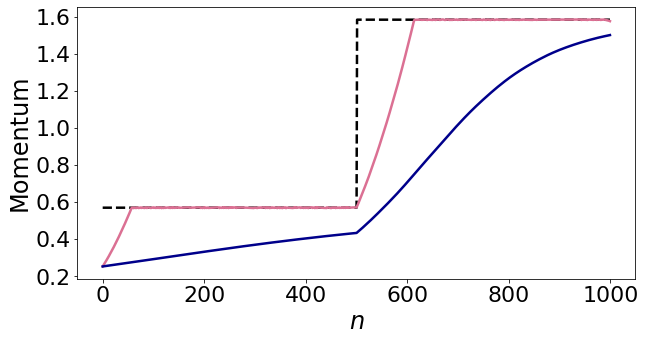

In [15]:

vanilla_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_0), axis=-1)

vanilla_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(vanilla_kdv_opt_momentum_soln_5), axis=-1)

plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)


plt.plot(
    vanilla_kdv_opt_momentum_0,
    label=r"$Vanilla(\lambda = 0)$",
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    vanilla_kdv_opt_momentum_5,
    label=r"$Vanilla(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking_tau'+str(tau)+'.pdf'), dpi=200, bbox_inches='tight')

# plt.close()

print("---Track Momentum Done---")


In [16]:



# Save data
results_dict = {'vanilla_kdv_opt_momentum_0': vanilla_kdv_opt_momentum_0,
            'vanilla_kdv_opt_momentum_5': vanilla_kdv_opt_momentum_5,
            'vanilla_kdv_opt_mass_0': vanilla_kdv_opt_mass_0,
            'vanilla_kdv_opt_mass_5': vanilla_kdv_opt_mass_5,
            'mass_ref':mass_ref,
            'momentum_ref':momentum_ref,
            'vanilla_t_list_momentum_0': vanilla_t_list_momentum_0,
            'vanilla_t_list_momentum_5': vanilla_t_list_momentum_5,
}

np.save(os.path.join(data_path,'vanilla_'+forcing_type+'_tau_'+str(tau)+'_tracking_results.npy'), results_dict)